In [4]:
import os
import random
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Define the Transformer Input Layer:

# For past target tokens in the decoder, we combine position embeddings and token embeddings.
# For audio features, we use convolutional layers to downsample them and capture local relationships.

In [3]:
class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions


class SpeechFeatureEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)

In [4]:
# Transformer Encoder

In [5]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [6]:
# Transformer Decoder

In [7]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masking the upper half of the dot product matrix (cuts the information flow from future tokens to current).
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out))
        return ffn_out_norm

In [9]:
class Transformer(keras.Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=10,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = SpeechFeatureEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y)
        return y

    def call(self, inputs):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source)
        y = self.decode(x, target)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        """Processes one batch inside model.fit()."""
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def test_step(self, batch):
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def generate(self, source, target_start_token_idx):
        """Performs inference over one batch of inputs using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = self.encoder(source)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = tf.expand_dims(logits[:, -1], axis=-1)
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input

In [10]:
# Loading the Dataset

In [11]:

import os
saveto = "D:\\shishir_ml\\Untitled Folder\\datasets/LJSpeech"
wavs = glob("{}\**\*.wav".format(saveto), recursive=True)
print(wavs[1]) 

id_to_text = {}
with open(os.path.join(saveto, "utt_spk_text.tsv"), encoding="utf-8") as f:
    for line in f:
        id = line.strip().split("\t")[0]
        print(id)
        text = line.strip().split("\t")[2]
        print(text)
        id_to_text[id] = text

def get_data(wavs, id_to_text, maxlen=50):
    """ returns mapping of audio paths and transcription texts """
    data = []
    for w in wavs:
        id = w.split("\\")[-1].split(".")[0]
        
        if len(id_to_text[id]) < maxlen:
            data.append({"audio": w, "text": id_to_text[id]})
#     print(data)
    return data
    

D:\shishir_ml\Untitled Folder\datasets/LJSpeech\wavs\00014b6780.wav
4aa1fdca33
००७ मिलको दूरीमा
86e521554a
००७ मिलको दूरीमा
c96b2b1afb
००७ मिलको दूरीमा
2f7ab41953
०११ देखि काङ्ग्रेसको
c290e5124b
०१ सौर द्रव्यमान
1d7f225bd0
०२३ सम्म
5e766d189e
०२३ सम्म
8190842174
०२३ सम्म
b6c37578d2
०२३ सम्म
c40938bd06
०२३ सम्म
c89e1079c6
०२३ सम्म
2bedce5635
०२४ देखि वाम
e4ed3e951c
०२४ देखि वाम
0ba8e6bacd
०३१ सालमा पञ्चायती
de4dc39a7a
०३२ मा उहाँ
3ed2cee22b
०३५ देखि भूमिगत
96cf842c07
०३५ देखि विद्यार्थी
a7f5ba44bb
०३६ देखि नै राजनीतिमा लाग्नुभएका गुरुङ ०४२ मा अखिल छैठौँको अध्यक्ष हुनुभएको थियो।
6c3b5fab5f
०३६ देखि राजनीति
c977a4d3eb
०३६ देखि राजनीति
d4ff76ee65
०३८ मा चौँथो महाधिबेसनको
6d49b03fdc
०३९ सालतिर निर्मल
74c4e5c052
०३ अर्गोन
76eebeef6c
०४६को जनआन्दोलनमा संयुक्त
f911dd9e32
०४६को जनआन्दोलनमा संयुक्त
0d7fef5a4c
०४६ सालको जनआन्दोलन
5a358087ff
०४६ सालको जनआन्दोलनपछि
d98faa2143
०४६ सालको जनआन्दोलनपछि
e36e68cf49
०४६ सालको जनआन्दोलनपछि
142063b43f
०४७ मा बाबुराम
d01c86d69d
०४७ मा बाबुराम
e88c438186
०४७ 

42ca28d07a
१३ लाख लिटर
dbfff43e69
१३ लाख लिटर
052ecc4005
१३ वटा अङ्क
bd010f53f0
१३ वटा अङ्क
ec963a376f
१३ वटा हुने भएकोले
365b445339
१३ वर्षका
400ad1790e
१३ वर्षको उमेरमा
4203718261
१३ वर्षको उमेरमा
01e1270a5a
१३ वर्षको भइस्
1577c7bf46
१३ वर्षको भइस्
1d9c94ceaa
१३ वर्षको भइस्
f3980dfab4
१३ सन्तान मध्ये
4d43c1ae43
१३ हजार ८३० वटा नम्बर
57879e0795
१३ हजार ८३० वटा नम्बर
71f1bfa9b6
१३ हजार ८३० वटा नम्बर
9b7ef6cdd4
१३ हुन्छन्
daf8dc9d24
१३ हुन्छन्
4ab71ea94a
१४११ इस्वीमा
0b10f8368d
१४१४ इस्वीमा
f3ea2f87ec
१४१४ इस्वीमा
cbf4e99696
१४२२ मा जीर्णोद्धार
25ff5d668a
१४२३ इस्वीमा गरियो
bfb2581cef
१४२३ इस्वीमा गरियो
e6eba09824
१४२३ इस्वीमा गरियो
28a345a254
१४८ बैशाख पूर्णिमामै
a9825bacda
१४८ बैशाख पूर्णिमामै
4223d79409
१४ अगस्ट २००७
6b868a7a9f
१४ अगस्ट २००७
4064d7c6a9
१४ अध्याय छन्
5619da912a
१४ अध्याय छन्
d0d573eb57
१४ औं शताब्दीका
2df2ebe2c4
१४औं शताब्दीको
c84c620f3e
१४औं शताब्दीको
02b2941e30
१४औं शताब्दीको महामारीले
61fc66fde3
१४औं शताब्दीको महामारीले
765cfcdcb2
१४ औं शताब्दीमा
894a6653d3
१४ औं श

१९९१ मा अन्ना
e5d010bd7f
१९९१ मा अन्ना
a0a1abde66
१९९१ मा पोल किटिङ
32763d209e
१९९१ श्री पञ्चमीमा
6502622c20
१९९१ श्री पञ्चमीमा
093c6c606e
१९९२ ९३ मा
3139ebe636
१९९२ अगस्ट २०
b7c9e000a2
१९९२ अगस्ट २०
02c8eb1394
१९९२ को अप्रिल देखि
1bfbc005d9
१९९२ मा
c54e7ce632
१९९२मा ग्रीष्मकालीन खेलको तयारीको क्रममा माथिल्लो भागमा दुई पङ्क्ति कुर्सीहरू थपियो।
9114af9d0c
१९९२ मा दलाइ
240d0ad1d5
१९९२ मा निर्वाचित
edb01dd04b
१९९२ मा निर्वाचित
8ab0d756ee
१९९२ मा प्रकाशित
36b2869f9c
१९९२मा प्रकाशित भएको
75bbab3250
१९९२मा प्रकाशित भएको
ac757f0eaa
१९९२ मा विज्ञान
0b96e4dd09
१९९२ सम्म बसे
982148c8dc
१९९२ सम्म बसे
6a6c1ebeb4
१९९२ सम्म विश्वमा
6bf7446200
१९९२ सम्म विश्वमा
d7ef405a49
१९९२ सम्म विश्वमा
2a3bc6b897
१९९३ को अप्रिलदेखि
7aa58ab856
१९९३ को अप्रिलदेखि
7a43868d8e
१९९३ मा धनकुटामा
89ee43f165
१९९३ मा पोल्यान्डको
1f0b2175c3
१९९३ मा ब्यारिमोर
fedba1a319
१९९३मा स्थापित गरिएको
6710b3adad
१९९३ र फरेस्ट
c07c264601
१९९३ र फरेस्ट
f63fe7e73f
१९९३ र फरेस्ट
42b405e34a
१९९३ साल मङ्सिरमा
ea5d4473ec
१९९३ साल मङ्सिरमा
bb

300160a652
२०२० वैशाखमा
63a0d370e7
२०२० वैशाखमा
94df9bab23
२०२० वैशाखमा
b424f6d086
२०२० वैशाखमा
d8ff9d8b59
२०२० वैशाखमा
5c4e0a848e
२०२० वैशाखमा प्रकाशित
d851b492a8
२०२० वैशाखमा प्रकाशित
149d2952a6
२०२० साल असार
ad1045dfdf
२०२० साल असार
b78b7bb26d
२०२० साल असार
17a0f95096
२०२० सालतिर किन
c10b1fbd90
२०२० सालतिर किन
75e1b8cbfa
२०२१ असोजमा प्रकाशित
e27c34229e
२०२१ असोजमा प्रकाशित
c8a1789100
२०२१ गाविस बनेर
49905b2640
२०२१ मङ्सिरमा
1ff41cfd0d
२०२१ सालमा काँक्री
813921fb88
२०२१ सालमा काँक्री
a57f006338
२०२१ सालमा काँक्री
13f28204c9
२०२२ असोजमा प्रकाशित
576699f347
२०२२ असोजमा प्रकाशित
82ce34c173
२०२२ असोजमा प्रकाशित
1617bbcfab
२०२२ पुसमा प्रकाशित
142d96f340
२०२२ वर्षको समय
c2e33d7b6a
२०२२ वर्षको समय
30155ba211
२०२२ वर्षहरूको
465660598a
२०२२ वर्षहरूको
9ae79f0cc0
२०२२ वर्षहरूको
20031289e6
२०२२ साल पुस
53944f6592
२०२२ साल पुस
cbdaa328e5
२०२२ सालमा पञ्चायत
2b15f96ea7
२०२३ साल भदौ
a718d3f045
२०२३ साल भदौ
1404fc143d
२०२३ सालमा
1fe0b907c7
२०२३ सालमा
d292028f92
२०२३ सालमा
ea5f8f032c
२०२३ सालमा
1f3fc6

२६ अप्रिल सन्
28ebd7b991
२६ औँ राज्य हो
a6808e859c
२६ कोष पूर्वमा
d1e4133ceb
२६को साक्षरता दर
8e5e6fe669
२६ गते
9fd36b47c7
२६ गते
a0a11871ea
२६ गते
43caeae7aa
२६ गतेका दिन
370f01e7d4
२६ गतेको हकमा
fc0149a972
२६ गतेको हकमा
60a56a7e2b
२६ जनवरी व्यक्तिहरूलाई
578c813194
२६ जुन २०११
afaca1979e
२६ जुन २०११
06681e8b18
२६ प्रदेशहरू जसलाई
154c140687
२६ प्रदेशहरू जसलाई
f370ee656f
२६ प्रदेशहरू जसलाई
03c249f17e
२६ मार्च १९८९
a53794bbba
२६ मार्च १९८९
30f76cd569
२६ यातनाविरुद्धको हक
20133bc087
२६ रोपनि जग्गामा
a11c4e3c4a
२६ रोपनि जग्गामा
9c86d4d440
२६ वर्षको उमेरमा
07e13e8811
२६ वर्षीय कपाली
48eb8c745c
२६ वर्षीय कपाली
efa0e349a1
२६ वर्षीय कपाली
075d6a2efe
२६ सम्म भएको
8b18d20b98
२७६ छ
ca5555909d
२७ अप्रिल २०१०
8942a059b6
२७ किमि अग्लो
b1914a5cac
२७ किमि अग्लो
c4b59e511c
२७ किमि अग्लो
3ec04e3ad7
२७ गते देशव्यापी
94bb549a68
२७ गते देशव्यापी
3ddf7c84e9
२७ गते पोखरामा
447a3dd4bf
२७ जुन २०१० धन्यवाद
8155d3adbb
२७ जुन २०१० धन्यवाद
99a759d84a
२७ दशमलव २
d46ca9b1bd
२७ दशमलव २
f7c20924fb
२७ दशमलव २
f8b92dccd

४६ लाख ६३
09d6bfc498
४६ वर्षअघि जन्मनुभएका
a4332dfa59
४६ वर्षीय परियारले
dd7af144a2
४६ वर्षीय परियारले
2276a3c40b
४७ किलोमिटर सडक
90bedcf1e6
४७ कूल खर्च
bbd32e7267
४७ को मुख्यालय
125c2e9a0e
४७ पुरा गरिएको
1eb31cdee0
४७ पुरा गरिएको
efbcce3dd2
४७ पुरा गरिएको
78fdf75898
४७ प्रतिशत रहेको छ
a38ecde8b2
४७ प्रतिशत रहेको छ
1db7d94aea
४७ वर्गकिलोमिटर छ
50c35c1732
४७ वर्षीया भुसाल
038706d279
४८५ मध्ये ३९२ स्थान ल्याई
80f74a0420
४८ छन्
b7d5e6fb8a
४८ प्रतिशत र महिला
6bf1aa46e1
४८ बोरका बन्दुक
072630543c
४८ वर्षका थिए
0be0146031
४८ वर्षका थिए
74f69d9c5f
४८ वर्षका थिए
3116cad911
४९००० वर्ग किमि
fd7feaf72e
४९००० वर्ग किमि
2f7f47cc22
४९ का बेला
3019eaee31
४९ का बेला
993abc780e
४९ छन्
dc335c92fe
४९ छन्
3d43822356
४९ प्रतिशत छन्
c5c4d57970
४९ प्रतिशत छन्
cb01bc652c
४९ प्रतिशत छन्
83ded071e6
४९ र महिला
2cfd4e0d9b
४९ वर्षीया न्यौपानेले
ac22e756d2
४ अकस्मात् दण्ड
1111c0fda9
४ अप्रिल २०१२
5765700d98
४ अप्रिल २०१२
a292805480
४ अप्रिल २०१२
ec72f2d722
४ अप्रिल २०१२
0eaa31adfb
४ अर्ब भएको
177f1c9c6a
४ अर्ब भएको

6094cd0782
९० प्रतिशत रोमन
85b90bf746
९० प्रतिशत रोमन
bc98ad9916
९० प्रतिशत रोमन
38dbce0a6e
९० महिलाहरूको लिङ्ग
6a52cdba1b
९० महिलाहरूको लिङ्ग
6f369c3ffa
९० महिलाहरूको लिङ्ग
29f145362d
९० सालको भूकम्पमा
3504eb4e72
९० सालको भूकम्पमा
65b90f77a5
९० सालको भूकम्पमा
664df5b0bd
९० साल महाभूकम्प
6e6cdee7db
९१ लाख भयो
da242a3d0e
९१ लाख भयो
1505f4c9c1
९१ वर्ग किलोमिटर
49d708622e
९२ प्रतिशत क्याल्सियम
d396a83ff9
९२ प्रतिशत क्याल्सियम
d9f10e2b10
९२ प्रतिशत क्याल्सियम
f755f22b3a
९४६ महिलाको
da602f79d4
९४ मेगावाट छ
310ea570aa
९५ किमिको गतिमा
9d18cd0a9f
९५ भन्दा अधिकको
bc6824d454
९५ भन्दा अधिकको
f7e3342dd6
९६१ मेघाहर्जमा
8779d95aaf
९६ प्रतिशत
8a4845cce3
९६ प्रतिशत
cc9be568db
९६ प्रतिशत
5310a71a6e
९६ वर्ग किलोमिटर
bdbe0140bf
९७ औँ स्थानमा रहे
332d827d34
९८ भाग
c50a6d333f
९८ भाग
ae1582d787
९९२ इन्च ७६
17a234abb1
९ औँ शताब्दीमा
8448a7dc97
९ औँ शताब्दीमा
a520569ded
९ औँ शताब्दीमा
61796016f1
९ को मुख्य
8830f141c2
९ को मुख्य
a2f148657c
९ को मुख्य
f678278b74
९ को मुख्य
cbfeb5d8e5
९ क्षयरोग १० चर्म
ec11c9ec5

अझ बढी प्रभावकारिता
078b3db39c
अझ बढी हुन्छ
3116d70f9e
अझ बढेछ
64c1dacc5f
अझ बढेछ
b940aaf2bc
अझ बाहिर आएका
6df0a5a00d
अझ मलमास परेको
2f69eaa2a6
अझ यति छरितो
89a6e8cfec
अझ यति छरितो
33756b2f52
अझ लम्ब्याउँदै गयो।
6c3107863f
अझ लम्ब्याउँदै गयो।
82b13976c3
अझ व्यापारीले
b59ce67a08
अझ सजिलो हुनेछ
32ad9b85d2
अझसम्म पनि त्यो
4534b31e54
अझसम्म पनि प्रशस्त
5f64b70c92
अझ सिक्नु पर्छ
9a8e6959e4
अझ सिक्नु पर्छ
e0a9ed3bf1
अझ सिक्नु पर्छ
1cac48169b
अझ स्तरीय बनाई
4c38f928f4
अझ स्तरीय बनाई
7bff840df0
अझै अनुभव गर्ने छु
332d097cf9
अझै केही
cad48e30f0
अझै केही
18b58689a2
अझै खत्म
a81dd4eaeb
अझै खत्म
fb85e71965
अझै घरहरू छन्
9d1fc812bc
अझै थपिँदै
ab47981e15
अझै थपिँदै
bfb3ac103b
अझै थपिँदै
e7155fe902
अझै थपिँदै
2077dbab72
अझै धेरै
7dfce1298d
अझै निर्माणाधीन छ
92bb779e8d
अझै पनि
af91e24b03
अझै पनि
54e59516be
अझै पनि आफ्नो
873a7f575c
अझै पनि घिमिरे
925515d8de
अझै पनि घिमिरे
65d1ee330a
अझै पनि बिरालोले
c93f8846d7
अझै पनि बिरालोले
d464af57ba
अझै पनि बिरालोले
6be733375a
अझै पनि भविष्यको
8c9f5fbb1d
अझै पनि भ

b17845dfc8
अधिक भारी बाउन्ने
53d5c0ac14
अधिक मत प्राप्त
bc3cf63d67
अधिक मत प्राप्त
3201abfb7e
अधिक मनोहर हुने
539982fdb9
अधिक मनोहर हुने
9a5848b391
अधिक मनोहर हुने
6086e68a88
अधिक महाव्रत कहलाउने
2bc6153cc0
अधिक मात्रामा जैविक
3f669401fc
अधिक मात्रामा जैविक
9a7ce65d37
अधिक मात्रामा जैविक
ad0275da8a
अधिक मिल्दछ
838e7892bf
अधिक रूचि राख्थे
5eeb1a50b8
अधिक लोकप्रिय छ
e9f6126760
अधिक लोकप्रिय छ
fe9faa945c
अधिक लोकप्रिय छ
37bafc1d76
अधिक विश्वास थियो
87448f2ea1
अधिक विश्वास थियो
cf093a1dca
अधिक विश्वास थियो
e732c5caca
अधिक विस्तारित पृथ्वी
05e9d62619
अधिक व्यय गर्नु पर्छ
59324f8dc0
अधिक शक्तिशाली विस्फोटक
0b2c582c51
अधिक शाक्तिशाली परमाणु
ac4ff33e6a
अधिक शुद्ध मानिन्छ
91f958ab2e
अधिक समय पहिलेको मध्ययुगीन
f558ab809c
अधिक समय पहिलेको मध्ययुगीन
6dc3c5b79a
अधिक समयसम्म
d09d463475
अधिक समयसम्म
595ca4cb26
अधिक समयसम्म अन्तरिक्षमा
aa7aa32b66
अधिक समयसम्म अन्तरिक्षमा
f380ab8dff
अधिक सम्भावित विकल्प
50997db9ff
अधिकहीन छ
a4ea748844
अधिक हुनु स्वाभाविक छ
f45b2c1350
अधिक हुनु स्वाभाविक छ
72caa3864c
अध

50380dfc8d
अनि उनी स्रेस्ता
b8b1a2944b
अनि उनीहरूको यथावत्
f1da5358bd
अनि उनीहरूको यथावत्
f62cbb5dfd
अनि उनीहरूको यथावत्
f23d2e2bb2
अनि उहाँ २०५४
9e8df8eb40
अनि उहाँले यो
c91a4ef04f
अनि उहाँसँगै जानुपर्ने
74c61ca644
अनि काम थाल्नुभन्दा
50af21fabc
अनि कुनै प्रयोग
2c6d906756
अनि के हामी
62710cc690
अनि के हामी
8c0088d624
अनि के हामी
98f7ba6bb0
अनि के हामी
ccf01e63a8
अनि के हामी
d33315b796
अनि के हामी
d547b98514
अनि के हामी
b44cf6f4c6
अनि केही उपाय नदेखेर
9d07e7b97b
अनि केही दिनभित्रै
3de69b132d
अनि कोमल
4db88b4bf8
अनि कोमल
96cb91a853
अनि कोमल
bdb9936d22
अनि कोमल
f4c077d205
अनि कोमल
c9a19fa2af
अनि गुरुजीलाई चढाउँदै
71e243355a
अनि चिसो बियरको
9cc6180ed1
अनि चिसो बियरको
3db4eb0eab
अनि चेलाहरूले जोगी
55f4900058
अनि छ उनको
5c6afc656b
अनि छ उनको
958edf0f3f
अनि छ उनको
f782979b9b
अनि छ उनको
9c5d91bddd
अनि छात्रबृत्तिको
2b3182d9b7
अनि छिमेकी कुटिल स्त्रीलाई बोलाएर उचित दण्ड दिए।
76815e6a09
अनि जसरी टङ्गाल
dc755f19b4
अनि जसरी टङ्गाल
01c4a54c46
अनि तपाईँको शिर
1ee762a35b
अनि तपाईँको शिर
20f4227ecd
अ

अनेक शारीरिक अवस्थाहरू
578b3e4c79
अनेक सभ्यताहरू र समाजहरूले
8c12d89b61
अनेक सभ्यताहरू र समाजहरूले
bf97eb56f8
अनेक सभ्यताहरू र समाजहरूले
ed835af306
अनेक सभ्यताहरू र समाजहरूले
350f585ef5
अनेक समस्याहरूमा गम्भीरतापूर्वक
dd3fec56e1
अनेक समस्याहरूमा गम्भीरतापूर्वक
5c9f3cdef9
अनेक सिद्धान्त
fee329b353
अनेक स्वरूपहरूलाई लिए
830bec25a1
अनेकहरू दुर्ग छन्
075acf2820
अनेक हुन्छन् यसैले
ef5a5387be
अनेक हुन्छन् यसैले
3cda3598c1
अनेकानेक कष्ट व्यहोर्नुपर्छ
98717f3ce9
अनेकानेक कष्ट व्यहोर्नुपर्छ
a3972ce5f4
अनेकानेक शिष्यहरूले उनिसित
4403f3cf89
अनेकौं कठिनाइका बावजुद
8995867207
अनेकौं कठिनाइका बावजुद
03b2dfa97d
अनेकौं कारणहरूले गर्दा
24b9e75dbf
अनेकौं कारणहरूले गर्दा
c30308d9f0
अनेकौं कारणहरूले गर्दा
d255cad156
अनेकौं कारणहरूले गर्दा
af8c78c925
अनेकौं दर्शन शास्त्र
3060d4d721
अनेकौं प्रवासिए
a4d8dccf46
अनेकौं मान्छेहरूका
4232f502a6
अनेकौँ सूचनाहरूको माध्यमबाट
18f880a6f2
अनेकौँ स्वानुभूतिको
6a9bf4dc05
अनेकौँ स्वानुभूतिको
b8603c6e41
अनेकौँ स्वानुभूतिको
e75ce90212
अनेकौँ स्वानुभूतिको
7189eee8aa
अनैकोट क

3f366c14e6
अन्नपूर्ण भोजपुर जिल्लामा
856ab830a4
अन्नपूर्ण लमजुङ गणेश
12174d21c7
अन्नपूर्ण श्रृङ्खलाको दक्षिणमा पर्छ
8f46eb93ce
अन्नपूर्ण श्रृङ्खलाको दक्षिणमा पर्छ
977f95236f
अन्नपूर्ण श्रृङ्खलाको दक्षिणमा पर्छ
b1748d93a6
अन्नपूर्ण श्रृङ्खलाको दक्षिणमा पर्छ
d7643c8fbb
अन्नपूर्ण श्रृङ्खलाको दक्षिणमा पर्छ
e37509f026
अन्नपूर्ण श्रृङ्खलाको दक्षिणमा पर्छ
0c36f63edf
अन्नपूर्ण संरक्षण क्षेत्र
1a06157b36
अन्नपूर्ण संरक्षण क्षेत्र
c924f27651
अन्नपूर्ण संरक्षण क्षेत्र
639a372ee3
अन्नपूर्ण संस्कृत नेपाली
a9f83173d5
अन्नपूर्ण संस्कृत नेपाली
eacfe1b54a
अन्नपूर्ण संस्कृत नेपाली
08c13d1b15
अन्नपूर्ण हिम श्रृङ्खला
e220909dd2
अन्नपूर्ण हिम श्रृङ्खला
e9e5118b7b
अन्नपूर्ण हिम श्रृङ्खला
a413f4adce
अन्नपूर्ण होटल स्वागत
cee936ebd0
अन्नपूर्णा प्रेस असन
4dd5e18c2e
अन्‍नपूर्णा रेस्टुरेन्टमा
1fee0a157c
अन्नबाली उत्पादन हुने
3882776080
अन्नबाली उत्पादन हुने
9c236184bb
अन्नबाली उत्पादन हुने
116d5e475b
अन्नबालीको राम्रो उब्जनी
72e2d60d78
अन्नबालीको राम्रो उब्जनी
5bf5a5d2c5
अन्नबाली पाकेको बेला
f3fa36a22e
अन्नबाली 

अप्टिकल केबुल परिपथ
d310cfd61d
अप्टिकल खगोल विज्ञान
5c34efea4a
अप्टिकल फाइबरको प्रचलन
6e02cbe087
अप्टिकल फाइबरमा अरू
d714c75c28
अप्टिकल फाइबरमा अरू
02483f7881
अप्टिकल शब्दबाट नै
12a655d7e9
अप्टिकल शब्दबाट नै
0c09c816c9
अप्टिक्सको अध्ययन गरे
462106c6ce
अप्ठेरोमा पर्‍यो
e4b5c81eb7
अप्ठेरोमा पार्‍यो
7fdf5f2f94
अप्ठ्याराहरू छन्
2455f1a522
अप्ठ्यारो पनि हुन्छ
c2fd19665a
अप्ठ्यारो परे अथवा
0895fa1a49
अप्ठ्यारो परेमा
c6217c122e
अप्ठ्यारो परेमा
735457cba4
अप्पी हिमालको फेदीबाट
579acbd589
अप्रचलित भएको छ
c92b07c324
अप्रचलित भएको छ
a0c92c5676
अप्रतिम प्रतिभाका धनी
a6a17395e1
अप्रत्यक्ष फाइदाले पनि
d73c1f418d
अप्रत्यक्ष फाइदाले पनि
f54b598817
अप्रत्यक्ष फाइदाले पनि
ee2c8dd13c
अप्रसन्न रहनु भनेको
cbbd64bd9a
अप्राकृतिक मैथुनको रूपमा
ead479432f
अप्राकृतिक मैथुन भन्नाले
b01a639d11
अप्रादुर्भाव अहिंसा
deeac0a306
अप्रादुर्भाव अहिंसा
84cc86cd30
अप्रिल १८ सन् २००३
ab3bfb66bf
अप्रिल १८ सन् २००३
e981d43b6b
अप्रिल १८ सन् २००३
33a71c416e
अप्रिल १९४७ मा
428f3c341c
अप्रिल १९७४ एक
db1d718875
अप्रिल २ मा
e94c0fa

d2bde1fd4c
अभिलेख विश्वका पर्वत
23d3da1d93
अभिलेखाकरण छ
28aea4eeb8
अभिवक्तालाई लाग्दछ
43b605dc1e
अभिवक्तालाई लाग्दछ
a216ea1cc0
अभिवक्तालाई लाग्दछ
21aa61633e
अभिवदन गरिने शब्द
38bc01a13a
अभिव्यक्ति पत्रिका एक
a5a9220ae8
अभिव्यक्ति पत्रिका एक
e55d3073f4
अभिव्यक्ति भएको छ
96e96129a7
अभिव्यक्तिलाई रसपूर्ण बनाउनमा
c352d81fb6
अभिव्यक्तिलाई रसपूर्ण बनाउनमा
10fdf28b32
अभिव्यक्तिहरूलाई नैबन्धिक रूप
8f38186c60
अभिव्यक्तिहरूलाई नैबन्धिक रूप
852b5635d1
अभिव्यक्ति हुन्छ
9ead8ae8f4
अभिव्यक्ति हुन्छ
d52ac9defe
अभिव्यक्ति हो
a773539e92
अभिशाप मिल्यो
c714b8b97b
अभिशाप मिल्यो
3e8f133f23
अभिषेकजी नमस्ते
f87194ea44
अभिषेकजी नमस्ते
4c915306fc
अभिषेकजी मैले तपाईँको
7b2ec85807
अभिषेकजी मैले तपाईँको
2ef944e108
अभिषेक नामच्याग पुटी
373b0d070e
अभिषेक बच्चन
825434f347
अभिषेक बच्चन
affc123fa1
अभिषेक बच्चन
22439ae8b7
अभिषेक बच्चन भारतीय
625047e799
अभिषेक बच्चन भारतीय
63ad71f2b0
अभिष्ट थियो
da67049eca
अभिष्ट थियो
dd7efc4f4c
अभिष्ट थियो
56f2e27305
अभूतपूर्व गति
69f83aaf51
अभूतपूर्व प्रयोगहरू द्वारा
55b69e46c5
अभूतपू

अर्को ग्रह पनि
27c782b524
अर्को घर पौवा हो
55ab1a4aff
अर्को घर पौवा हो
bcda60dd99
अर्को घर पौवा हो
5777676ca6
अर्को चार दिनहरूमा
c86875f89e
अर्को चार दिनहरूमा
0518207f26
अर्को चेलो गोबर्धन दासले
3c922fc830
अर्को चेलो गोबर्धन दासले
6346e2d6a6
अर्को छुट्टै लेख
60f2b61894
अर्को जन्ममा दुवैको
be4f61ef8a
अर्को जन्ममा दुवैको
4ce5ecb044
अर्को जातिको काँचो
77b64096a1
अर्को जातिको काँचो
be8ae45371
अर्को जातिको काँचो
694a3054d9
अर्को जुका हुन्छ
8a443e38de
अर्को टावर गर्दै
f7bde1406a
अर्को ठाउँ
c5119423e8
अर्को ठाउँमा पुग्छन्
04b76619c4
अर्को ठाउँमा सर्नु हो
6c31dd5801
अर्कोतर्फ मेरो एक
9bdc3622ab
अर्कोतर्फ मेरो एक
64df780336
अर्कोतिर उनी भन्थे
976b04a789
अर्को त्यतिबेला जब
44d76c3434
अर्को त्यतिबेला जब कण्व ऋषिले शकुन्तलालाई आफ्नो आश्रमबाट बिदा गर्दछन्।
c3baf1d828
अर्को त्यतिबेला जब कण्व ऋषिले शकुन्तलालाई आफ्नो आश्रमबाट बिदा गर्दछन्।
dcb7b7f2c6
अर्को दिन उनकी
1d476d323a
अर्को दिन साह्रै
5256c9389f
अर्को दोस्रो भाषा हो
0acd234500
अर्को नयाँ टेम्प्लेट
3781c627f9
अर्को नाम तमु हो
4d95dd47db
अर्को न

2b592515ef
अवश्य यहाँ परिचय
e6a17dacaf
अवश्य यहाँ परिचय
0477e1e401
अवश्य हुने गर्दछ
d133471f98
अवश्य हुने गर्दछ
dc84d23e4f
अवश्य हुने गर्दछ
38656b0f12
अवश्य होस्
41e73fc895
अवश्य होस्
9cb31e4635
अवसर अवश्य दिनुपर्नेछ
130adb4049
अवसर उपलब्ध गराइन्छ
1bdac4498c
अवसर उपलब्ध गराइन्छ
dee90d8b7f
अवसर उपलब्ध गराइन्छ
1b9edc898f
अवसर थियो
621b6448cc
अवसर थियो जब
07fd4affc3
अवसर पनि यस
5cf000d5a9
अवसर पनि यस
708d0b989c
अवसर पाउनुपर्छ
f202145ed1
अवसर पाउनुपर्छ
07eae924a7
अवसर प्राप्त गरे
68b6650242
अवसर प्राप्त गरे
6bfe4a893b
अवसर प्राप्त भएमा
f54114d2fe
अवसर प्राप्त भएमा
2ea28409f2
अवसरमा अनेक
cafc9f508f
अवसरमा अनेक
da92629d0c
अवसरमा अनेक
4fafc990e3
अवसरमा दशैँ नामको
8c541ce736
अवसरमा प्रदर्शन
95ac4a88ce
अवसरमा प्रदर्शन
763ac8d060
अवसरमा भव्य रूपमा
80416eb0be
अवसरमा भव्य रूपमा
ec067f2024
अवसरमा भव्य रूपमा
223d8ba152
अवसरमा समुद्रकुमारी राणालाई
7d4b16bd0d
अवसरमा समुद्रकुमारी राणालाई
98cd4a285f
अवसरमा समुद्रकुमारी राणालाई
2958d5dc6b
अवसरमा संसारभर छरिएर
5c9de75aba
अवसरमा संसारभर छरिएर
98f8ad7341
अव

8eea165ff6
अस्ट्रेलियाली संविधानद्वारा
ed6a840fc8
अस्ट्रेलियाली संविधानद्वारा
2e95472c6e
अस्ट्रेलियाले यातायात
20891e91a0
अस्ट्रेलियासँग अरु धेरै
b991aec048
अस्ट्रेलिया स्थित इसाई
8adc12c303
अस्ताउँदो सूर्य र उदाउँदो
10dc0ca1ae
अस्ति तपाईँले चौतारीमा
bb5a6a1a33
अस्ति तपाईँले चौतारीमा
cacec1666a
अस्ति तपाईँले चौतारीमा
16a2a6700e
अस्तित्व कायम राख्न
3f37d41bc7
अस्तित्व कायम राख्न
4a4f86df0b
अस्तित्वको अन्त
ca9aa953ff
अस्तित्वको अन्त
0fde1323cb
अस्तित्व छ
24bcb366d1
अस्तित्व छ वा छैन
e0846ed251
अस्तित्व छ वा छैन
f7275dee1b
अस्तित्व छ वा छैन
3024ba1f37
अस्तित्व भूमिगत जलको
b433505dca
अस्तित्व भूसतहमा
a6c118e7bc
अस्तित्वमा आएको हो
c6c9c5c085
अस्तित्व रहेको
db29e6d490
अस्तित्व रहेको
21958f625e
अस्तित्ववादी दर्शनको प्रस्तुति
e1adec32dc
अस्तित्ववादी दर्शनको प्रस्तुति
762ddf2ff8
अस्तित्व समाएर सुदूर
e2cf3dfccb
अस्तित्व समाएर सुदूर
d88312bcbd
अस्तिनैदेखि गर्न
9ea153cf44
अस्ति राजेशसँग पनि
c22c9822dd
अस्ति राजेशसँग पनि
46c5970ba8
अस्थायी क्याम्पस
4fff21c230
अस्थायी क्याम्पस
531900fa01
अस्थायी क्य

आउँदै गर्दा लेखनाथ
1afa92399a
आउँदैन त्यसको लागि
648b043ea5
आउँदो दशकमा निर्माण
81f8d4b0bb
आउँदो दशकमा निर्माण
e717538b28
आउँदो दशकमा निर्माण
085949d913
आउँ पर्दा
a51003013b
आउँ पर्दा
8595cca820
आऊ लौ पस मुखमा जब भनिन् बोले हनुमान त्यसै।
42b77cb08e
आऊँ परेकोमा यसको
48b6c23c3a
आऊँ परेकोमा यसको
ed36f85091
आएअनुसार लाहुरे बन्ने
ee8ad03dd8
आएअनुसार लाहुरे बन्ने
ab2e5439f4
आएका उहाँ लेप्चा
7c6456dcda
आएका किम
b61f5c048b
आएका किम
49f575346a
आएका छन्
3402e3abaf
आएका थिए
e6b7363664
आएका थिए
b5bcc14be2
आएका थिए उनी
5b5c6d8478
आएका थिए जुनबेला
74cb5afc81
आएका थिए जुनबेला
29b8951876
आएका थियौँ
b605ed15f7
आएका थियौँ
79789967b3
आएका नवग्रहहरूमध्ये आकाशमा
93d93a6ebc
आएका पहिराका
5d6a7f771d
आएका पाइन्छन्
92373c9ac5
आएका पाइन्छन्
4e98d4dd30
आएका भारतीयको पनि
72d9ee168d
आएका भारतीयको पनि
b9a8e8d7d5
आएका मान्छेहरूको मातृभाषा
050c7cc109
आएका युरेनस नेप्च्युन
bc02d42127
आएका युरेनस नेप्च्युन
347ea5073c
आएकाले आफूलाई जनताले
d025940126
आएकाले आफूलाई जनताले
f7b90e6841
आएकाले आफूलाई जनताले
a7652ef139
आएकाले त

आचार्य भरतमुनि
c6a73f7b08
आचार्य भरतमुनि
26582eb93b
आचार्य मिश्रका पालेका
46253de640
आचार्य मिश्रका पालेका
50789ccbc7
आचार्य मिश्रका पालेका
3a1517302f
आचार्यले अध्‍ययन
df70a1e40b
आचार्यले अध्‍ययन
497f3c6a71
आचार्यले सङ्घबाट मात्रै
5055ffefca
आचार्यले सङ्घबाट मात्रै
e306077ef3
आचार्यले सङ्घबाट मात्रै
3dd55287c7
आचार्य शङ्करको जन्म
59e4c489c1
आचार्य शङ्करको जन्म
76317a80ad
आचार्य शङ्करको जन्म
79c972e53f
आचार्य शङ्करको जन्म
b2a241891d
आचार्य शङ्करको जन्म
c16c3cc95d
आचार्य शङ्कर यस्ता
ea628b5eaf
आचार्य शङ्कर यस्ता
5152f1d94d
आचार्य शङ्करले
5c796bfef9
आचार्य शङ्करले
320b775438
आज उनको पेन्सनको
5ebe26aa17
आज उनको पेन्सनको
4413febfa6
आज कता हरायो
6723f8202e
आज कता हरायो
bcbcc2ddad
आज कता हरायो
1aadeb05b1
आजकल आनुवंशिकीको
ca3e808169
आजकल उन्नत जातका
f03ebc527d
आजकल धेरै दिनदेखि
f3a1f7c22b
आजकल धेरै दिनदेखि
3c3c86c5f2
आजकल म सामान्यतया
b771d6fe5d
आजकल यो प्रयत्न
c4def88762
आजकल यो प्रयत्न
8357a7c258
आजकल समाजसेवा
19c7645671
आज काटेको प्याज
2432152fd7
आज काटेको प्याज
39492bf98a
आज काटेको प्याज
5

आधार बन्ने छ्न्
368a0ac182
आधार बन्ने छ्न्
da99c59385
आधार बन्ने छ्न्
28905fe27c
आधार बहुसाँस्कृतिक समावेशी
0d75638196
आधारबाट नगरकोट नाम
1e415eb196
आधारभूत तत्त्व हुन्
2f0626828d
आधारभूत तत्त्व हुन्
89858d9f72
आधारभूत तत्त्व हुन्
87f24f1890
आधारभूत सहयोग
b32fed1261
आधारभूत स्वास्थ्य र
c7dc069fca
आधारभूत स्वास्थ्य र
eb6acb4cc9
आधारभूत स्वास्थ्य र
aba5d22aa6
आधारमा अस्ट्रेलियाली उपनिवेसहरूमा
22f06e1712
आधारमा आत्मतत्त्वहरूको
4ce446b0d1
आधारमा आत्मतत्त्वहरूको
b4632e84dd
आधारमा आत्मतत्त्वहरूको
4b715b0a0f
आधारमा उनको डेटको
7b13b37192
आधारमा उनको डेटको
8591212312
आधारमा उनको डेटको
4b5e6d76db
आधारमा एक डोजोले
b1f60b3861
आधारमा कार्य गर्दछ
146fa58a0c
आधारमा गरिन्थ्यो त्यो
434e9f646f
आधारमा गरिन्थ्यो त्यो
cf029a6262
आधारमा गरिन्थ्यो त्यो
0f32721eac
आधारमा छुवाछुत गर्न
9ca4c9d9e7
आधारमा छुवाछुत गर्न
9e3ff9aae8
आधारमा छुवाछुत गर्न
e3e3fe42f0
आधारमा तथा बिना
6bbd0834c5
आधारमा तय गरिन्छ
71b7aa498e
आधारमा तय गरिन्छ
e426c7c33d
आधारमा तय गरिन्छ
e83f0daf9f
आधारमा तय गरिन्छ
f11e2409a7
आधारमा तय गरिन्छ


f9ad7348fe
आफूलाई जनताले जिताएको
fb3cecbb72
आफूलाई जनताले जिताएको
e74a2b7455
आफूलाई जिताएको
cc4ccfe57d
आफूलाई ठूलो देखाउनका
2c66fbfc02
आफूलाई नयाँ अनि
e5ca4c94de
आफूलाई नयाँ अनि
632266fc4c
आफूलाई निम्न वर्गको
bebab3e5f8
आफूलाई निम्न वर्गको
ea6b9f9e9c
आफूलाई निम्न वर्गको
228c849935
आफूलाई पढाउने भने
addfeca453
आफूलाई पढाउने भने
e502ef55a8
आफूलाई पढाउने भने
336917d77e
आफूलाई पुनर्सुसज्जित
c16e79006e
आफूलाई प्रष्ट रूपमा
5a0dc03e2c
आफूलाई फेरि एकपटक
cdf879c2ed
आफूलाई फेरि एकपटक
1b2013aa62
आफूलाई भोटे भनेको
4df990890e
आफूलाई भोटे भनेको
ee367d4034
आफूलाई भोटे भनेको
2aefcae1e4
आफूलाई विजय बनाएको
9383fdfa09
आफूलाई विजय बनाएको
95e766f289
आफूलाई विजय बनाएको
2af29e03ae
आफूलाई सफलतापूर्वक बालकलाकारको
52ea5f42df
आफूलाई सफलतापूर्वक बालकलाकारको
1d966afbbd
आफूलाई समाजमा स्थापित
1dbc2ced7b
आफूलाई समाजमा स्थापित
4992d1ba35
आफूलाई समाजमा स्थापित
380b2eeb38
आफूलाई सुम्पिएको
4ae642ab74
आफूलाई सुम्पिएको
732ab09e1f
आफूलाई सुम्पिएको
8bbc659cdd
आफूलाई सुम्पिएको
f16d34c428
आफूलाई सुम्पिएको
35f0e34993
आफूलाई सुर

416c253808
आफ्नो पुस्तक जियोग्राफी
645e93d989
आफ्नो पुस्तक जियोग्राफी
46d324571a
आफ्नो पुस्तकमा किम
7bf3579a19
आफ्नो पुस्तकमा किम
cd77e5ff79
आफ्नो पुस्तकमा किम
fa6c9d959a
आफ्नो पुस्तकमा स्पष्ट
54199ae585
आफ्नो पुस्तकहरूको सन्देशमा
6ab6a2c00c
आफ्नो पुस्तकहरूको सन्देशमा
71483dedfe
आफ्नो पुस्तकहरूको सन्देशमा
7dfef94d2e
आफ्नो पुस्तकहरूको सन्देशमा
ed059e5b6a
आफ्नो पुस्तकहरूको सन्देशमा
fc8ae81fd7
आफ्नो पुस्तकहरूको सन्देशमा
1aa7b80b1d
आफ्नो पूर्वजहरूको
8b64f704df
आफ्नो पूर्वजहरूको
d7005743d2
आफ्नो पूर्वजहरूको
a4ab25c64b
आफ्नो पँखेटालाई खुट्टाजस्तै उपयोग
e1f6b4039d
आफ्नो पँखेटालाई खुट्टाजस्तै उपयोग
0a42fd7288
आफ्नो प्रजनन केन्द्रको
656f33eff0
आफ्नो प्रजनन केन्द्रको
825f5ee355
आफ्नो प्रजनन केन्द्रको
aa07e0037d
आफ्नो प्रजनन केन्द्रको
390b64df4e
आफ्नो प्रतिनीधि चुन्दछन्
e3bdd24c27
आफ्नो प्रतिनीधि चुन्दछन्
6363434af6
आफ्नो प्रतिनीधित्व गर्न
15546e45f6
आफ्नो प्रतिनीधिहरूलाई चुन्दछ
204b3e887b
आफ्नो प्रभाव देखाउन
3dd12ff738
आफ्नो प्रभाव देखाउन
67ef7095bf
आफ्नो प्रभाव देखाउन
6840635ca5
आफ्नो प्रभावलाई

आर वी एस
4b4038f47a
आर वी एस
579ac435e6
आरसीडी मेलोरकाको बिरूद्ध
fabd7d850b
आराधनमा केही संशोधनको
49ed390b25
आराधना गरी नेपाल
3c82deb140
आराधना गरे।
08e26dbdb0
आराधना तन मन
07521933f3
आरान् संस्कृतको र
f0f6db2217
आराम गर्ने पाटी छ
d07ddd7bcc
आरामशाह गद्दीमा बसेकोमा
38bbdbb9d6
आराम हुन्छ
15a9400232
आरुखर्क नेपालको
76fa24e363
आरुखर्क नेपालको
c326926f16
आरुनो काखैमा रहेको
ebc5223659
आरुबखडा अम्बा नासपाती
1eea21ae25
आरू ओखर उत्तिस
3885d4c756
आरू ओखर उत्तिस
c0fde2cb4a
आरोप छ
dd2aa113e0
आरोप थियो
e1ea9213b5
आरोपमा अदालतमा
a82ffb531d
आरोपमा अमेरिकाले अफगानिस्तानमाथि
db5eb39f46
आरोपमा गिरफ्तार गरिएको
d5fa5249c1
आरोपमा प्रतिबन्धित गरिएको
d22f4ecb89
आरोपमा संविधानसभाका
5a3d5ce267
आरोप लगाए
e7bf4cb75a
आरोप लगाए
2a1b080268
आरोप लगाएमा म
af3c060aa0
आरोप लगाएमा म
5591cf9e38
आरोप लागेको थियो
62175ea28c
आरोप लागेको थियो
6ab0e3400f
आरोप लागेको थियो
f42029d19b
आरोप लागेको थियो
e235b32edd
आरोप सहित समातियो
3056eaa071
आरोपहरूका कारण राजनीतिमा
41bc0b9c44
आरोपहरूका कारण राजनीतिमा
d1191335a8
आरोपहरूका कारण र

आँगनलाई गाईको गोबरले
e46d82c29d
आँगनलाई गाईको गोबरले
e830317f03
आँगनलाई गाईको गोबरले
c16668ac50
आँचल एक
973da4ee04
आँटेजसरी हिँडिरहेछौँ
243b003cee
आँटो र पिठो
48113cb46d
आँधीखोला एक
97b78053b3
आँधीखोला एक
a69c303472
आँधीखोला एक
435c45b9ce
आँधीखोला जलविद्युत
6f31df63f7
आँधीखोला सेतीखोला जरेखोला
eb79764f67
आँधी धूलो
d0f77de7a1
आँधी बुलेटिन
a531438151
आँधीबेहरी हो
fc58d77872
आँधीबेहरी हो
70678b9126
आँप कफवर्धक
777284937d
आँपका केही रूखहरू
c92c53651f
आँपका केही रूखहरू
16c3327023
आँप कागति आदिको
d1dfc322c7
आँप कागति आदिको
dbbd9dc98c
आँप कागति आदिको
311cc8677e
आँप काँचो होस्
37c04ed6d9
आँप काँचो होस्
1edde80c0d
आँपको अचार
4d9e11627e
आँपको अचार
4fc7adcff7
आँपको पात
a9ca2fa9c4
आँपको फल
9e1a6e2202
आँपको बूढो रूख
c67baa65b7
आँपको रूख
f11ccce3ec
आँपको रूख
10ef2ce4cc
आँपको सेवनले
da45db8f1b
आँप चाउरी रोक्न
f71d6b6260
आँप चाउरी रोक्न
8716f498fe
आँपचौर गुल्मी जिल्लामा
f2c7b56d84
आँपचौर गुल्मी जिल्लामा
0cc4b4dca2
आँपटार गाविसको सुकेपोखरी
3f25cf4046
आँपटार नेपालको
bdba223e9d
आँप तयार भयो
0cf4ae73fb
आँ

इलाहाबाद विश्वविद्यालयलाई पूर्वको
4a0ad43998
इलाहाबाद विश्वविद्यालयलाई पूर्वको
7fcf34245c
इलाहाबाद विश्वविद्यालयलाई पूर्वको
d542672f03
इलाहाबाद स्थित शिलालेखमा
17c96b2731
इलाहाबाद हल्दिए राष्ट्रिय
c183a91c70
इलाहाबाद हल्दिए राष्ट्रिय
1bd109bd22
इलाहावाद बोर्डबाट प्राइभेट
ac875da081
इलाहावाद बोर्डबाट प्राइभेट
e91954b0ac
इलाहावाद बोर्डबाट प्राइभेट
400b0620fd
इलियटलाई गुरु थापे
c6b0df7f53
इलियटलाई गुरु थापे
9022eb5f30
इलेक्ट्रनिक कम्प्युटरहरूका सहायताबाट
39536f9ce0
इलेक्ट्रान वोल्ट हो
073489b4ea
इलेक्ट्रिक टेलिग्राफ बनाउनुभयो
3664a2ec18
इलेक्ट्रिसियले तत्काल नै
a52bd9ee27
इलेक्ट्रिसियले तत्काल नै
9f49929829
इलेक्ट्रोनिक पब्लिकेशन
b8024a6a7b
इलेक्ट्रोनिक भोटिङ्ग मेसिन
1f15943aba
इलंगो अडिगलको जन्म
55c7c2b5bd
इलंगो अडिगलको जन्म
fce55a7c4e
इल्या अडोल्फोभिच रुवानोभिच
cb7810d34e
इल्लल्लाह वल्लाह अक्बर
fae9d0b98d
इल्लल्लाह वल्लाह अक्बर
9e66049f8b
इवाल्यूशन भ्रौणिकी
49a43dfeed
इशानी श्रेष्ठपछि प्रथम
aff5f98a8b
इशानी श्रेष्ठपछि प्रथम
bf22d77695
इशानी श्रेष्ठपछि प्रथम
5f30d22636
इशानी श्रेष्ठ सत्र

1d70ca6342
ईश्वरलाई हुन्छ
4a1ba2f0a3
ईश्वरलाई हुन्छ
85f89110ee
ईश्वरलाई हुन्छ
f80ac9fa0e
ईश्वरलाई हुन्छ
5b43f37c34
ईश्वरले समय समयमा
5d53219344
ईश्वरवचन लगाएका छन्
5ee9d64569
ईश्वरवचन लगाएका छन्
1a14487dc9
ईश्वरवादी धर्म हो
34fb66ff9f
ईश्वरवादी धर्म हो
9019c3218b
ईश्वरवादी धर्म हो
0acbfe522d
ईश्वरी न्यौपाने समानुपातिक
03cc2ee5da
ईसमा टीकमगढकी राजकुमारी
a99b1ccdc5
ईसमा टीकमगढकी राजकुमारी
6cd50729a7
ईसा अलेही
c91da703f5
ईसा अलेही
ba0cacd69a
ईसा अलेही सलामका
b276504d2d
ईसाइ धर्म
fec14edfe1
ईसाइ धर्म
4c8c794a04
ईसाई एवं ग्रहीय
87fed1ab54
ईसाई धर्म र यहुदी
04c326c2fe
ईसाईयतमा गैब्रिएल नामक
274fe34288
ईसाको १२ शिष्यहरूले
2b6a0f4a12
ईसाको १२ शिष्यहरूले
e574a58e8b
ईसाको चौथो शताब्दीमा
2cedff5795
ईसाको जन्म भयो
57bac5e87d
ईसाको जन्मलाई
9ee5983ba9
ईसाको जन्मलाई
c396e0fd8c
ईसाको जन्मलाई
3e56a78b20
ईसाको जन्मलाई आधार
ac2e49ae11
ईसाको जीवनी र उपदेश
ec16f2be4b
ईसाको जीवनी र उपदेश
a9d3237ac1
ईसाको नवौँ शताब्दीपछि
a4bcce0742
ईसाको विरोधी बने
1d6673adca
ईसा जब ३० वर्षको
e788a8756a
ईसा जब ३० वर्षको
776d

उत्तर कोरिया पठाएका
be3bc4d563
उत्तर कोरिया पठाएका
39542b5bea
उत्तर कोरियाली भावी
77cf470828
उत्तर कोरियाली भावी
d3da5bc208
उत्तर कोरियाली भावी
1ac9cd6bdb
उत्तर कोरियाली राजदूतसँग
b107e54126
उत्तर कोरियाली वर्कर्स
bc79d099a2
उत्तर कोरियाली वर्कर्स
37411418c1
उत्तर कोरियाली सरकारी
4bb461aefc
उत्तर कोरियाली सरकारी
73dfd6d94b
उत्तर कोरियाली सरकारी
80f682e3cb
उत्तर कोरियाली सरकारी
a8c84ce1a4
उत्तर कोरियाली सरकारी
53cb0fee92
उत्तर कोरियाले
9cb58e4543
उत्तर कोरियाले
aff63e3eb0
उत्तर कोरियाले
81c93e54c7
उत्तरगया महाक्षेत्र तथा
df52f474fb
उत्तरगया महाक्षेत्र तथा
170ef7f9c3
उत्तरगयासमेत मानिने यो
30fbfd49b7
उत्तरगयासमेत मानिने यो
b3b0aa3c63
उत्तरगयासमेत मानिने यो
790befed90
उत्तर गाईघाट भन्ने
ebb3dc1fd9
उत्तर गाईघाट भन्ने
4cd8f02f99
उत्तर तथा पश्चिममा
749b3558ad
उत्तर तथा पश्चिममा
8da53a41bc
उत्तर तथा पश्चिममा
8f1d199602
उत्तर तथा पश्चिममा
0d712c6bfc
उत्तरतर्फ ११ जुलाई १९६३ मा
297eda2bd8
उत्तरतर्फ अविरल
4c2a933f3e
उत्तरतर्फ अविरल
25db0914c3
उत्तर तर्फको उच्च
007b1b872b
उत्तरतर्फको द्वारअगाडि
29

bd078b7a7f
उदाहरण पानी पर्नै
bcbc3a8075
उदाहरण प्रस्तुत गरेका छन्
e730732b52
उदाहरण प्रस्तुत गरेका छन्
d612565a38
उदाहरण भेटिन्छन्
78df750cc1
उदाहरणलायक हुन्छ
44ea8354ff
उदाहरण शनिको परिक्रमा
71b1573893
उदाहरण शनिको परिक्रमा
a004a883ee
उदाहरण शनिको परिक्रमा
445f0e551f
उदाहरण सन् १६०० देखि
5be21a51e4
उदाहरण सन् १६०० देखि
6127a8c782
उदाहरण स्वरूप छोटे
7ad988eca9
उदाहरण स्वरूप छोटे
b6d9d8d572
उदाहरण स्वरूप छोटे
31f82709ce
उदाहरणस्वरूप पाश्चात्य संगीतमा
1a5a072038
उदाहरण हो
5a4bfa20b9
उदाहरण हो
6eb9e7c193
उदाहरण हो
da7ec5fc53
उदाहरण हो
43754ba203
उदाहरणार्थ अमेरिकाका दलीय
c5fb4ee23e
उदाहरणार्थ अमेरिकाका दलीय
d3b82fe95d
उदाहरणार्थ अमेरिकाका दलीय
49e13e85da
उदाहरणार्थ पाषाण युग
33e5e7d813
उदित नारायण झा एउटा प्रसिद्ध नेपाली पार्श्व गायक हुनुहुन्छ।
033b491c94
उदिपुर नेपालको पश्चिमाञ्चल
0bd25eb6bc
उदिपुर नेपालको पश्चिमाञ्चल
14e52b40b4
उदिपुर नेपालको पश्चिमाञ्चल
cd21e336f8
उद्घाटनको लागि आफ्नो
2a80cd63c0
उद्घाटन गरी एउटा
ff97cec3ec
उद्घाटन रहेको छ
0ee830c056
उद्दार कार्यलाई अपरेसन
1586ce8208
उद

उनको पाठ गर्नाले
84dc81cc09
उनको पाठ गर्नाले
8723c4d57a
उनको पाठ गर्नाले
4a22e68cd2
उनको पार्टी
4c7dd2152c
उनको पार्टी
2dd8855f1e
उनको पार्टीका नेताहरूले
34ec93e5d5
उनको पार्टीका नेताहरूले
65a997683d
उनको पार्टीका नेताहरूले
ccd84d7317
उनको पार्टीका नेताहरूले
09668cfc47
उनको पित्रागत लक्षण
fc42ff38c4
उनको पित्रागत लक्षण
131034c449
उनको पुराण वाचनशैलीबाट
3de67fe424
उनको पुर्ख्यौली घर
4ec13327ec
उनको पुस्तक द टाइरनी
e75c07ff3b
उनको पुस्तक द टाइरनी
74c2282743
उनको पेटमा ठोक्कियो
d379b99d32
उनको पेटमा ठोक्कियो
d0d97c3c2f
उनको पेटमा दुखाइको
789de30e64
उनको प्योङ्याङ सहर
41546f2bf1
उनको प्रतिक्रिया ढङ्गको
a59d2863cd
उनको प्रभाव अभिनय
58b10817aa
उनको प्रशंसा गरे
730823587b
उनको प्रशंसा गरे
99e1786dad
उनको प्रशंसा गरे
c4bf03ff6e
उनको प्रशंसा गरे
42c3348359
उनको प्रसिद्धिको कारण
c8151510d0
उनको प्रारम्भिक शिक्षा
13c539a76e
उनको प्रिय विधा हो
bb372b22b7
उनको प्रिय विधा हो
78dddb3f13
उनको फर्म फिक्का
996ab78c82
उनको फर्म फिक्का
2c3afd7a0e
उनको फलामे खेल
6ec6d411c3
उनको फलामे खेल
7312e3b90c
उनको फल

उनले छोडदिए
2bab233b06
उनले जनवादी संस्थाहरूको
7d4d189760
उनले जर्मनी युगोस्लाभिया
2783db1c7a
उनले जवलपुरमा
df1b31d62a
उनले जवलपुरमा
0eb3066018
उनले जानकारी दिए
7c63dd1893
उनले जोखाङ्ग मन्दिर
716c62e51e
उनले जोसमनी सन्त
504c362ed3
उनले झन्नै सत्रवर्ष
69d0a57b6a
उनले झम्टेको देखे
7259d0c045
उनले झम्टेको देखे
794aa10b25
उनले झम्टेको देखे
9241381244
उनले झम्टेको देखे
a3b3d503c5
उनले झम्टेको देखे
e846234715
उनले झम्टेको देखे
6e3aeb8ea3
उनले टुकी प्रज्ञा
d4bbd83469
उनले डाक्टरेटको उपाधि
4d95541677
उनले डा बलराम जोशी
56f3eb0477
उनले डा बलराम जोशी
a21aa47459
उनले डा बलराम जोशी
1df65bb2e5
उनले तिब्बत पस्नु अघि
9dcbb3e170
उनले तिब्बत पस्नु अघि
cde0162bd4
उनले तिब्बत पस्नु अघि
6424266ba4
उनले ती वर्ष
65256d653f
उनले ती वर्ष
bb511fa1b5
उनले ती वर्ष
14c61587ac
उनले तुरुन्त
a6e49801f5
उनले त्यसबेलाका दार्शनिकहरू
047b48d185
उनले त्यहाँ उपन्यासकार
77418ed3b5
उनले त्यहाँ उपन्यासकार
a01e595b37
उनले त्यहाँ उपन्यासकार
c96e43c722
उनले त्यहाँ उपन्यासकार
d0b323e732
उनले त्यहाँ उपन्यासकार
2aa828987f
उनले त्य

उनी निसन्तान भएकै
d0dc447e4e
उनी निसन्तान भएकै
fc6c6f0e98
उनी निसन्तान भएकै
f4a385c450
उनी नेपालको परराष्ट्र
89fc8dd52c
उनी नेपाल प्रज्ञा
bf61ef2bfc
उनी नेपाल सरकारको
c88e14929d
उनी नेपाल सरकारको
dd8a35a2f4
उनी नेपाली
f406c1ee9f
उनी नेपाली
866ddbb38e
उनी नेपाली चलचित्रमा
b5b8eb23d6
उनी नेपाली चलचित्रमा
d722a0d799
उनी नेपाली चलचित्रमा
f42ce3e662
उनी नेपाली चलचित्रमा
0e608e48a9
उनी नेपाली भाषा
12564966d1
उनी नेपाली भाषाको
ce429ec17c
उनी नेपाली भाषाको
cfdcdcc42f
उनी नेपाली भाषाको
7aa4062849
उनी नै नेपालको
4834117cef
उनी नौ वर्षको
096b5a3f17
उनी पक्षपातसँग नियुक्ति
a94f941d69
उनी पक्षपातसँग नियुक्ति
523388131f
उनी पछि उनकै
1fec2cb0c8
उनी पछिको १२ औँ
d8d97c8203
उनी पछिको १२ औँ
304da5dcb6
उनी पटकपटक हिरासत
cd70ba26fc
उनी पटकपटक हिरासत
1cf6a44313
उनी पत्रिकालाई माध्यम
fe71692a60
उनी पत्रिकालाई माध्यम
0e1c7bd7f2
उनी पनि थिए
e822763385
उनी पनि थिए
3c9b0b1b42
उनी पनि बगे
433890ec29
उनी पनि बगे
43dc5d200b
उनी पनि बगे
e7f838d6c1
उनी पनि बगे
70681634d9
उनी पनि हजरत
9dd446280f
उनी पनि हजरत
f89c7ab3d

उन्यु पाइन्छ्न्
cd8b4bf4df
उन्यु पाइन्छ्न्
86b879ef53
उपकथा पनि गाँसिएको छ
929317043d
उपकथा पनि गाँसिएको छ
ed778fff76
उपकथा पनि गाँसिएको छ
031a4b1adf
उपकप्तान ज्ञानेन्द्र मल्ल
600d2fd13b
उपकप्तान ज्ञानेन्द्र मल्ल
ee0fc23a88
उपकप्तान ज्ञानेन्द्र मल्ल
7374b12c26
उपकप्तान ज्ञानेन्द्र मल्लले
d10b4dad2a
उपकप्तान ज्ञानेन्द्र मल्लले
0b3cadd727
उपकरण बियर चुरोट
8aa3968563
उपकरण बियर चुरोट
c16a7268d7
उपकरण बियर चुरोट
2545f0e7d9
उपकरणमा उल्लेख्य
828592fa36
उपकरणमा उल्लेख्य
94ec780ea0
उपकरणमा उल्लेख्य
d691b75042
उपकरणमार्फत अप्टिकल
1812bbbb93
उपकरणले १० गिगाहर्जसेकेन्डको
175b2cca8f
उपकरणले उठाउँछ जसलाई
ac0fe613ce
उपकरणले उठाउँछ जसलाई
71ae3fd0a9
उपकरण वाहनहरू र पुस्तकहरू
a48c59f63e
उपकरण सङ्कलन र जानकारीमूलक
2812b5a459
उपकरणहरू आदिले
7f8fb9b22c
उपकरणहरू आदिले
dfa2c5cca4
उपकरणहरू आदिले
0cb5f8f906
उपकरणहरू नवौँ र
641242d76b
उपकरणहरू नवौँ र
cba03ce866
उपकरणहरू नवौँ र
ce1b235507
उपकरणहरू नवौँ र
e3f642e306
उपकरणहरू नवौँ र
4e76168b59
उपकरणहरूमा तारामण्डल
73e4e3ad45
उपकरणहरूमा तारामण्डल
93fd259b41
उपकरणह

31ebac7197
उपाय छैन्
a76c86f168
उपाय थिएन
c26cc89e70
उपाय प्रतिदिन महामृत्युञ्जय
e4b5a35b1c
उपाय प्रदान गर्दछ
48cf818c72
उपाय सिक्दैछु
bdc8fcc056
उपाय सिक्दैछु
c1af09363c
उपाय सोचे
6079df649c
उपायहरू अपनाइनेछ
a88b262c91
उपायहरू अपनाइनेछन्
cdfb85e2ab
उपायहरू अपनाइनेछन्
4b087b0513
उपायहरू अपनाउने
1e9943fa31
उपायहरू अपनाउने छन्
6a7776f0c5
उपायहरू अपनाउने छन्
998d94c10b
उपायहरू अपनाउने छन्
b1dc1d806c
उपायहरू प्रस्ताव गर्ने
6523b7b133
उपायहरूसँग समन्वय गरिनेछ
3fe2642566
उपाय हो
f99272b9bf
उपाय हो
063ae337d9
उपासना गर्ने
0af91ce201
उपासना गर्ने
1e07879768
उपियाँको मध्य पेट
4b3b4835e0
उपियाँको मध्य पेट
6e8a170891
उपियाँको मध्य पेट
1af660aab2
उपेक्षित देखिन्छ
67bace6061
उपेक्षित देखिन्छ
6b0876edba
उपेक्षित देखिन्छ
7dbcafc358
उपेक्षित बन्नु परेको थियो
3522eed716
उपेक्षित शैक्षिक जीवन
55352682a2
उपेक्षित शैक्षिक जीवन
7b4c72b41a
उपेक्षित शैक्षिक जीवन
46f6613319
उपेन्द्र महतोले
b52dd636eb
उपेन्द्र महतोले
c07acf1dd0
उपेन्द्र महतोले
fa5b0ab3b4
उपेन्द्र महतोले
02440f12c7
उपेन्द्र यादव नेताका
8d8b4f01

उहाँ धनीलाल यादव
6f260d517d
उहाँ धनीलाल यादव
7e546aab2d
उहाँ धेरै लामो
f00bcc8e46
उहाँ धेरै लामो
0acd8c6b40
उहाँ धौलागिरी अञ्चलबाट
2fcd575bbe
उहाँ धौलागिरी अञ्चलबाट
24cba86c4f
उहाँ ध्वनीको स्वरूपको
a5eaa69610
उहाँ ध्वनीको स्वरूपको
0472f8472c
उहाँ नेपालका खानी
95c2df64b2
उहाँ नेपालका खानी
e09511ff59
उहाँ नेपाल महिला
85e363e814
उहाँ नेपाल रेडक्रसका
9ccd26e7c9
उहाँ नेपाल रेडक्रसका
064c460aaa
उहाँ नेपाली चलचित्रमा
9665d4ef73
उहाँ पनि हुनुहुन्छ
a947e71f70
उहाँ पनि हुनुहुन्छ
b1642e1a5c
उहाँ पनि हुनुहुन्छ
d0bab5abc6
उहाँ पनि हुनुहुन्छ
02d8b5b93a
उहाँ पहाडी जनजातिको
151a2d38a5
उहाँ पहाडी जनजातिको
8a0db40d9a
उहाँ पहाडी जनजातिको
9857a9f75d
उहाँ पहाडी जनजातिको
dcabaf9cad
उहाँ पहाडी जनजातिको
495cb11a57
उहाँ पहिलोपटक मञ्चमा
f586517e32
उहाँ पहिलोपटक मञ्चमा
18ccd8abcd
उहाँ पूर्वमन्त्री बलबहादुर
5ba0956537
उहाँ पूर्वमन्त्री बलबहादुर
b12eea83a5
उहाँ पूर्वमन्त्री बलबहादुर
01f03d8242
उहाँ प्रगतिशील विद्यार्थी
52146894fa
उहाँ प्रवासमा दुईचोटि
a9e12cbd0f
उहाँ प्रवासमा दुईचोटि
35c9ba3c32
उहाँ प्रायः खोटाङ
b

635a4233d2
एउटा प्रशासनिक एकाइ हो
a00f221905
एउटा प्रसिद्ध अभिनेत्री हुन्
f1d19f76c5
एउटा प्रसिद्ध अभिनेत्री हुन्
656bee4dbb
एउटा प्रसिद्ध अमेरिकी
f5c097d1b3
एउटा प्रसिद्ध अमेरिकी
a295fe2e86
एउटा प्रसिद्ध नेपाली
e83f3a1842
एउटा प्रसिद्ध नेपाली
1ff953dece
एउटा प्रहार कति
c082d9301f
एउटा प्रहार कति
e9abbc37f8
एउटा प्रहार कति
01365ef7b5
एउटा प्राइभेट मेडिकल
9d999c916f
एउटा प्रारम्भिक दृश्यमा
8bc27ae865
एउटा प्रेरणाको रूपमा
ba907ee376
एउटा प्रोग्रामेबल यन्त्र
e6254d154b
एउटा प्रोग्रामेबल यन्त्र
ba40c265cd
एउटा प्रोटोन र
9bc162a9fb
एउटा फलमा जम्मा
1ef059f233
एउटा फेसोका रूपमा
5c39cb0f98
एउटा फेसोका रूपमा
0ebb9133bd
एउटा फोटो लगाइएको
2b1d184ed2
एउटा फोटो लगाइएको
6bbd4bd5d2
एउटा फोटो लगाइएको
bb85150534
एउटा फोटो लगाइएको
0b9314771c
एउटा बयान
0e59561308
एउटा बयान
d49ab9d702
एउटा बयान
7b860b9afe
एउटा बाछी दिइछन्
f28b2c82b6
एउटा बाल
7c999e331c
एउटा बाहिरी व्यक्ति
7b27e523da
एउटा बिरानो कम
d16e3657d9
एउटा बुनियादी परिवर्तनको
24fd66356a
एउटा बैंक हो
5c372d4cd3
एउटा बैंक हो
588f154dee
एउटा ब्याङ्क ह

एक गाविस
2f3073f8cd
एक गाविस हो
d79ee3f8cb
एक गाविस हो
a217695908
एक गाविस हो।
12e6b61dd8
एक गिलास पानीमा
4c38d83803
एक गिलास पानीमा
b91507c743
एक गिलास पानीमा
c502a3fb4d
एक गिलास पानीमा
be22da1d34
एक गीतमा यस
dc55e8a906
एक गैरमुस्लिमले इस्लाम
085f7e936a
एक गैरसरकारी संस्था
1a205cb3b7
एक गैरसरकारी संस्था
895a3a669e
एक गैरसरकारी संस्था
b36d267dbd
एक गैरसरकारी संस्था
d765705718
एक गैरसरकारी संस्था
315bdf7743
एक गोल गर्दै
6a7727d253
एक गोल गर्दै
6d1c60ca3d
एक गोल गर्दै
94e042fd9b
एक गोल्फ कोर्स
0bab80b953
एक गौण इकाई
6552b10cfb
एक गौतम ऋषि हुन्
5340935f8d
एक ग्रन्थीबाट
d71117b06d
एक ग्रामका पिण्डमा
dd9e57f8eb
एक ग्रामका पिण्डमा
298ba4dd7a
एक ग्लास
c92302ccbe
एक ग्लास
ed767e6bde
एक ग्लास
02527afb84
एक घण्टा
21f19c475f
एक घण्टा
49ebb07acc
एक घण्टा लामो
89f3491d1e
एक घण्टा लामो
28efa73d97
एक चतुर्युगी भनिन्छ
afa01d9d3f
एक चतुर्युगी भनिन्छ
beb07b560f
एक चतुर्युगी भनिन्छ
f70be73bd3
एक चतुर्युगी भनिन्छ
2a3f5001dc
एक चम्चा खाना
5ae149a3b2
एक चम्चा खाना
abe3b430b0
एक चम्चा खाना
248be2066c
एक चम्च

एक मुख्य शक्ति
698cadf52d
एकमुष्ट वार्षिक
d46344c775
एकमुस्ट सङ्कलन गरिन्छ
e4252358e4
एकमुस्ट सङ्कलन गरिन्छ
23df6e9dc2
एक मुस्लिम बहुल
28064edfe1
एक मुस्लिम बहुल
9137a0ada9
एक मुस्लिम बहुल
d2a5aa88a6
एक मुस्लिम बहुल
664d31b671
एक मुस्लिम भनिन्छ
12e138ba47
एक मूल धर्म
c6663b4b94
एक मूल धर्म
ee8eea28c0
एक मूल्यवान पत्थर हो
a2244b6288
एक यन्त्रमा संयोजित
f5c5c21efd
एक यन्त्रमा संयोजित
4acb6bc58e
एक यशोधरा थिइन्
772b5ab6c6
एक यस्ता देशमा
a367090eeb
एक यस्ता देशमा
b87824d4cb
एक यस्तो ऐश्वर्यशाली
262a982fb4
एक यस्तो प्रवृत्ति सुरू गरे
333974365a
एक यान्त्रिक इन्डोस्केलेटन
59a64b5642
एक यान्त्रिक इन्डोस्केलेटन
2793349aa9
एक युग
d3472d1052
एक युग
fc03d00fc0
एक युद्धमा उनले
fd29831a3a
एक युद्धमा उनले
4fb3bfd447
एक युवालाई बहकाउने
9bf975d8a4
एक युवालाई बहकाउने
cd6a0984ac
एक योग्य युक्तिलाई
886bf5e476
एक योग्य व्यक्तिलाई
0408c9f57b
एक रमणीय स्थल हो
9b4420ebdc
एक रमणीय स्थल हो
c6d33e3a65
एक रमणीय स्थल हो
6e9049c577
एक रहेको थियो
d7961196f1
एक राजनीतिक दल हो
88fc717414
एक राज्य बनाइयो
92acb6936f
एक

7ea24bedd9
एम ४४
aa8a039723
एम ४५
f4ff33d5c9
एम ४५
bf95b0fef1
एम ६०
573ec5049a
एम ६१
eba1d5ee38
एम ६१
c795a28e78
एम ६३
54710cb494
एम ६४
9067a9efc4
एम ६४
a1f52930d4
एमएको डिग्री
18ed803248
एमए गरे
b6a5a648db
एमए गरेका छन्
b7a1a614aa
एमए गरेका छन्
c238cf89f1
एमए गरेका छन्
641abe7d36
एमएफए गर्नुभएको छ
65141d0826
एमएफए गर्नुभएको छ
8b8101117e
एमएफए गर्नुभएको छ
98b9521b42
एमएफए गर्नुभएको छ
0e2b27ffb4
एमए बराबरको पढाइ
b8b4ce75a7
एमए बराबरको पढाइ
e22942a623
एमएमा उनले नेपालीले
7ad77ff54a
एमए र जनसङ्ख्यामा
de9990f683
एमएस वर्डमा लेखी
fed5e54497
एमएस वर्डमा लेखी
0a0f56342e
एमएस्सीका लागि
5f7bdfe064
एमएस्सीका लागि
96bfa344f0
एमएस्सीका लागि
7e7f7049bd
एमकम र एलएलबीसम्म पढे
93cd9fed05
एमकम र एलएलबीसम्म पढे
8e08f9f39c
‍एमजिएमको नजिकै टर्मिनेटर
ac427e3d10
एमनेस्टी इन्टरनेसनललगायत
fd7c572f35
एमफिल र पीएचडी
7abc7a99af
एमबिएको कोर्स
20c686bcba
एमानिटा च्याउ पकाएर
7bdaeda03f
एमानिटा च्याउ पकाएर
bc90789181
एमाले अखिलबाट
107efea58c
एमालेका तत्कालीन संगठन
dde3a56844
एमालेका समानुपातिकतर्फ
3cd7fc5d9f
एमालेको

कक्षासम्म पढ्नुभएको छ
25b2bf7ac4
कक्षाहरू हुन्छन्
26886377d1
कक्षाहरू हुन्छन्
cd5af62aed
कक्षाहरू हुन्छन्
097c947e6e
कक्ष्यान्ड र स्पेनको
768f7a3107
कक्ष्यान्ड र स्पेनको
83c8291986
कङ्कर्ड क्यालिफोर्नियामा
8b368e941e
कङ्कर्ड क्यालिफोर्नियामा
190efff621
कङ्काल शरीरलाई श्रीखण्डजडित
06b9e95460
कङ्खाथर गढमुक्तेश्रवरका पूर्वदेखि
fafc5b576b
कङ्खाथर गढमुक्तेश्रवरका पूर्वदेखि
c4b624942e
कङ्ग्रेस ६२ मतका साथ
dd9b01077e
कङ्ग्रेसको भ्रातृसङ्गठन थियो
eeacece041
कङ्ग्रेस खोलेर बसे
b963719f81
कङ्ग्रेसबाट छुट्टियो
d9a557cfb0
कङ्ग्रेसबाट छुट्टियो
2a6aac94cd
कङ्ग्रेसबाट हात झिके
9ecd9c3b6a
कङ्ग्रेसबाट हात झिके
021bc3e8ad
कङ्ग्रेसमा आबद्ध भए
c0f1fd0bcd
कङ्ग्रेसमा आबद्ध भए
c995188af1
कङ्ग्रेसमा आबद्ध भए
aadff5c122
कङ्ग्रेसले गरेका
f66f0989f6
कचुर जोखानामा उनीहरू
74533a34df
कचौरा आसुत जल
8c2fb48503
कचौरा आसुत जल
b50fe3ecb3
कचौरा आसुत जल
179eb7ce03
कच्ची बाटोबाट
57273b7a8f
कच्ची बाटोबाट
a9cf6df5cd
कच्ची मोटर
b64ccc597c
कच्ची मोटर
2cbd477868
कच्ची सडक मार्गले
722839b8a9
कच्ची सडक मार्गले
b899a4b931
कच्ची सड

कमलरी राख्ने चलन
b8b57865b8
कमलरी राख्ने चलन
d070505f46
कमलरी राख्ने चलन
4e627aa051
कमला उपत्यकाको सिन्धुली
7cbc243f27
कमला उपत्यकाको सिन्धुलीमाढीमा
22b4001f46
कमला क्षेत्रीसँग उनको
52107a72bc
कमला क्षेत्रीसँग उनको
ae317e3a4f
कमला गजल धार्मिक
c09ea28bd2
कमला गजल धार्मिक
71a237dd98
कमलाजीको कुरा सुनेर
d9d0c5ce91
कमलाजीको कुरा सुनेर
f441d3252e
कमलाजीको कुरा सुनेर
1afb49e2f9
कमला नदीको किनारमा
75e8dd60d5
कमला नदीको किनारमा
d0ef4ed632
कमला नदीबाट सिंचित
55efa36274
कमला नदी र गौतमी
fc432a56f5
कमला नदी र गौतमी
1ce4026d69
कमला नै हो
4393c256e5
कमला नै हो
a3640d76fb
कमला नै हो
d6ae29271b
कमला नै हो
2184008373
कमला बहुमुखी क्याम्पस
49fc9d158e
कमला बहुमुखी क्याम्पस
afee1e416e
कमला बहुमुखी क्याम्पस
c00c938fcf
कमलामाईको मन्दिरमा पाठी
c579c64fa8
कमलामाईको मन्दिरमा पाठी
4cf8d5857c
कमलामाई गङ्गा हुन्
dc6f38f475
कमलामाई गङ्गा हुन्
a920dccad0
कमलामाई तीन नदीहरू
1acccc80d4
कमलामाई र गौतमी
ab29241390
कमला साइन्स क्याम्पस
da0b6ddf37
कमलासँग विवाह गरे
8cb7bc7639
कम वजनका ताराहरूमा
07789660bc
कम सङ्ख्यामा र

fb861edd9f
कर्णालीको विकासका लागि
193c06eb3f
कर्णाली चिसापानी
c08715bd3b
कर्णाली चिसापानी
8853b535ad
कर्णाली चिसापानी कर्णाली
f845921740
कर्णाली चिसापानी कर्णाली
4033c5df92
कर्णाली चिसापानीलाई नेपालको
70d9da01ac
कर्णाली चिसापानीलाई नेपालको
7bd4c5fc42
कर्णाली चिसापानीलाई नेपालको
843444cb37
कर्णाली चिसापानीलाई नेपालको
02184cb4c4
कर्णाली जिल्लाको
9612622c5d
कर्णाली जिल्लाको
3eefff5f89
कर्णाली नदीको
b87a54edf7
कर्णाली नदीको
646ad8c9a9
कर्णाली नदीको नामबाट
fabe2ff1aa
कर्णाली नदीको नामबाट
a56e42eacb
कर्णाली नदीको माछा
ea31fcb6c8
कर्णाली नदीको माछा
20c3075e90
कर्णाली नदीको संगममा
5e5e6c2e38
कर्णाली नदीको संगममा
c993111bf1
कर्णाली नदीमा पाइने
a40795fca5
कर्णाली नदीमा बाँध
01c365dec2
कर्णाली नदीमा साना
111367e399
कर्णाली नदीमा साना
6721432233
कर्णाली नदीले पहाड
6cc5e8b1c0
कर्णाली नदीसँग
9a1ac28dd0
कर्णाली नदीसँग
df5a7c1c16
कर्णाली नदीसँग
1d6a958cce
कर्णाली पुल नेपालको
701dc14330
कर्णाली पुल नेपालको
382888e02e
कर्णाली पुललाई विश्वकै
6fd90370b1
कर्णाली पुललाई विश्वकै
9d3c8a76cd
कर्णालीबासी बाध्य 

2e537a667f
कविले मुद्रिकाद्वारा यसको
5873ceaa73
कवि वाल्मीकिले रामायण
da5ddf30e3
कविशिरोमणिको उपाधि पाए
1075a98775
कवि शिरोमणि भनेको
28f5b19618
कवि सन्त चिन्तक
70f37e1218
कवि सन्त चिन्तक
0ac4e0700b
कवि हरिदासको धु्रवचरित्र
d83e4e06f5
कविहरूको बारम्बार
41236f0ae0
कवीर अरूको आलोचना
73a0f69826
कवीर कतै बाहिर
8045ffaf28
कवीर कतै बाहिर
be591ef1d4
कवीर कतै बाहिर
2fc657d22b
कवीर कपडा बुन्ने
47eb91b1d0
कवीर कपडा बुन्ने
1881d7cd9e
कवीरका यस्ता कैयौँ
1ab247a214
कवीरका यस्ता कैयौँ
1f7685ec8c
कवीरका शिष्य धर्मदास
3a19f36585
कवीरका शिष्य भए
c42f1c4ee3
कवीरका हरेक वाणीमा
8c58ea8e34
कवीरको घर त
a93a602d96
कवीरको घर त
09dc41e3fc
कवीरको रहस्यवादको
34c8c65a3c
कवीरको रहस्यवादको
3709b1d8f4
कवीरको रहस्यवादको
4eb90e59ee
कवीरको रहस्यवादको
04acf30b61
कवीरको शान्त र तेजस्वी
09029cbe63
कवीर जस्ता महासन्त
f13c3714e2
कवीर जस्ता महासन्त
49fb22dd52
कवीर डगेनन्
639f332890
कवीर डगेनन्
e4bb3ce522
कवीर डगेनन्
044cf51fd9
कवीरपन्थीहरू कवीरका कुनै
6e51606f6a
कवीरपन्थीहरू कवीरका कुनै
97f6fe9b0f
कवीरपन्थीहरू कवीरका कुनै
1a2

a4e5294f7c
काजीको दर्जा दिइने
d1c1a5f3dc
काजीको दर्जा दिइने
b299ca6dad
काजी जगजीत पाण्डे
cb0a536337
काजी जगजीत पाण्डे
42c878f0ed
काजीद्वारा भएको छ
4f45c18d68
काजीद्वारा भएको छ
c912152ccc
काजीद्वारा भएको छ
367deded7d
काजी बलभद्र कुँवर नेपालका राष्ट्रिय विभूति हुन्।
df175f0533
काजी साहेब भनेर
028f8ce9d3
काञ्ची अवन्तिका
b062a8601b
काञ्ची अवन्तिका
04a15e01f9
काटिएको शिरलाई जोडे
004afc2286
काटिएर राखेको प्याजले
450ed7ae1e
काटिनु वा धपाइनु
7d14e4b64c
काटिनु वा धपाइनु
a263c9d580
काटिनु वा धपाइनु
0a624fea1c
काटी आफ्नो छोराहरू
bb8afd7ebc
काटी आफ्नो छोराहरू
6356e8c6e7
काटेको स्थानमा यिनीहरूको
6a107bfa1a
काटेको स्थानमा यिनीहरूको
dbac3eeab8
काटेको स्थानमा यिनीहरूको
139cfbc6a4
काटेपछि चारकुने
39e773f6c8
काटेपछि चारकुने
985c50234e
काटेर झिकिन्छ
f90252af45
काटेर भित्र पस्नु
d1a0093f15
काटेर मान्छे नभएको
a2292ef8ec
काट्छ तब तिमी
027383e3c0
काट्छ भन्ने धार्मिकहरूको
1be599709b
काट्छ भन्ने धार्मिकहरूको
a3057143f8
काट्छ भन्ने धार्मिकहरूको
8333760cd8
काट्दै गइरहेका थिए
7941d6858b
काट्न पुगेँछु
4f2aed76cb
क

1a5095bf7c
काम गर्न
5710818ec2
काम गर्न
f28bb2944e
काम गर्न
7f03354270
काम गर्नका लागि
6d35acbf24
काम गर्न चाहनुहुन्छ
671a306f55
काम गर्न चाहन्छौँ
a42fc53745
काम गर्न चाहन्छौँ
33b1bf36cd
काम गर्न छोड्छ
22e469a5f6
काम गर्न थाले
31fdcbe402
काम गर्न थाले
8b7d28bfa9
काम गर्न थाले
63f1923683
काम गर्न थालेपछि
8bdd141e75
काम गर्न थालेपछि
bd7313d580
काम गर्न थालेपछि
0e96079a85
काम गर्न पनि
c9c5d58981
काम गर्न पनि
1604968255
काम गर्न यसको
f98f6a473b
काम गर्न सक्छन्
f8d08465f8
काम गर्न सक्दैन
2c5f34b3e7
काम गर्न सक्ने हुन्छन्
add25ff481
काम गर्न सक्ने हुन्छन्
1108b7d3f0
काम गर्न सम्भव
6e6b7091ab
काम गर्नुपर्दछ
d55b4dc730
काम गर्नुपर्दछ
d8ba92f96e
काम गर्नुपर्दछ
f95c92e68d
काम गर्नुपर्दछ
048749c038
काम गर्नुपर्ने भएकाले
0afc207f08
काम गर्नुभएको छ
25a715fa30
काम गर्नुभएको छ
b6e99b0e28
काम गर्नुभएको छ
695521e9e3
काम गर्नुभएको छ।
4c5e14a4d6
काम गर्नुभएको थियो
73d5afeab8
काम गर्नुभयो
a10f23aa77
काम गर्नुभयो
d8a45d2a80
काम गर्नुभयो
41ef17bab4
काम गर्नु हुन्छ
d0b391c428
काम गर्नु हुन्छ
45ea682ec8
काम ग

कार्की गीत सुन्ने
ea20afddd4
कार्की गीत सुन्ने
166db3e52e
कार्कीनेटा नेपालको
56149f9775
कार्कीबाडा नेपालको
1b6745d4ba
कार्कीबाडा नेपालको मध्यपश्चिमाञ्चल विकास क्षेत्रको कर्णाली अञ्चल मुगु जिल्लामा अवस्थित गाउँ विकास समिति हो।
971df46317
कार्कीबाडा नेपालको मध्यपश्चिमाञ्चल विकास क्षेत्रको कर्णाली अञ्चल मुगु जिल्लामा अवस्थित गाउँ विकास समिति हो।
06ab4888d0
कार्कीले हालसम्म करिब
5750e5425b
कार्की सन् २०००देखि
1ea5b8e98a
कार्के दह लगायत
5abb087cdd
कार्के दह लगायत
b48d9afd1b
कार्के दह लगायत
cbba3daac6
कार्के दह लगायत
c20600c352
कार्कोट नामक नागको
2ac4a97bcf
कार्टरले उक्त कार
834b17dab9
कार्टा तथा बिल
8e6c77939d
कार्टा तथा बिल
2157f40596
कार्टुनकलामा नेपाल भित्र
5c24b194e8
कार्टुन प्रतियोगिताहरूमा पटकपटक
8402cd3fec
कार्टुन प्रतियोगिताहरूमा पटकपटक
c7fcdca7b4
कार्टुन प्रतियोगिताहरूमा पटकपटक
d358a5c911
कार्टुन फिल्म बनाई
ec54b1c83c
कार्टुनमा कलात्मक पक्षको
bc17083009
कार्टुन लेखिरहेका वात्स्यायन
648e1612e0
कार्टुन वरिपरिको
30bf26902a
कार्टुन सिर्जनामा
c02a085913
कार्टुन सिर्जनामा
42098b87c2
कार्

2984dda74b
काल सधैँ
433276bc67
काल सधैँ
da6d9dd0a2
काल सधैँ
19b90a3528
कालसम्म रहिरह्यो
e3aca13cda
कालसम्म सुनिश्चित गर्ने
f9d5914ff3
कालसम्म सुनिश्चित गर्ने
282e7a4206
कालसर्प योगको
a378204a76
कालसर्प योगको
ef32bf6be1
कालसर्प योगको
9e560cb9ea
कालसर्पयोगको अवधारणा
e83375b498
कालसर्पयोगको अवधारणा
42f84e99c8
कालसर्पयोगको उल्लेख
865ec186c5
कालसर्पयोगको उल्लेख
29acd229aa
कालसर्पयोगको फलका
375abeb069
कालसर्पयोगको फलका
a5df51056f
कालसर्पयोगको फलका
fbfbb64583
कालसर्पयोगको फलका
6abdb2483b
कालसर्पयोग पनि
3511c8ec9c
कालसर्प योग भनिन्छ
4a88ba3924
कालसर्प योग भनिन्छ
d839dd105f
कालसर्प योग भनिन्छ
573960a642
कालसर्पयोग भनेर व्याख्या
3857d76aee
कालसर्पयोग भन्ने नाम
39bfc6c1b4
कालसर्पयोग भन्ने नाम
4c4762211c
कालसर्पयोग भन्ने नाम
eda5ed6e14
कालसर्प योग शान्ति
08beb7042d
कालसित सम्बद्ध छ
bb80492fec
कालसित सम्बद्ध छ
fc7ec121e2
कालसित सम्बद्ध छ
569c88e58d
काल सुरु हुनुभन्दा
711e1545b9
काल सुरु हुनुभन्दा
0e975341f7
काल स्वयं उत्पन्न
78950ed16a
काला अफ्रिकीहरूले सबै क्षेत्रमा अधिकार पाउन थाले।
05879b1bc3
का

किच्चक नामको
e9ed9ff8a8
किच्चक बध
0a212a6414
किच्चक बधको
371b46e7e7
किच्चक बधको
b8b95ad261
किच्चक बधको
c31e66054f
किच्चक बधको
631d376eef
किच्चक बध पर्दछ
6e27c42e3f
किच्चक बध पर्दछ
9c194c8272
किच्चक बध पर्दछ
5a9e2b0139
किच्चक वधको उत्खनन
7c20b78af4
किच्चक वधको उत्खनन
ce31def59d
किच्चक वधको उत्खनन
debb6cea35
किच्चक वधको उत्खनन
300c6a287a
किच्चक विराटको सालो
9c1eccce6b
किच्चक विराटको सालो
33b3329653
कि जब तिब्बत
340b3382d7
कि जब तिब्बत
40b22a6d42
कि जब तिब्बत
40c3702fb2
कि जब तिब्बत
525e419502
कि जसको लागि
71056adb94
कि जसको लागि
0891034b1b
कि जस दलको
12fe9181ef
कि जस दलको
4838151dd8
कि जस दलको
737f482df9
कि जस दलको
74a1272119
कि जस दलको
f9d24617f3
कि जस दलको
c46a6e0ad6
कि जस्तो लाग्छ
cdf6eaf8b4
कि जस्तो लाग्छ
fb3de98abb
कि जेव ला ग्रान्डे
d3d67fd1f5
किटनाशक रासायनिक या
c9f7e233bc
किटाणुहरू उत्पन्न भएर
4cef2d6e18
किटिङ मूलनिवासीहरूका
7b417f2955
किटिङ मूलनिवासीहरूका
df85125854
किटिङ मूलनिवासीहरूका
e84ef4ac40
किटिङले लेखापालहरूलाई बदलिदिए
8af9be444c
किटु पश्चिममा झ्याल
4105d4636b
किटेर कवित

किरा रहेछन्
5eaa74add6
किराहरूको नाम
f59bd1a89b
किराहरूको नाम
701f4141bc
किराहरूबाट हुनेवाला दुष्प्रभावहरूको
2a650a6f69
किराहरूले विषालु च्याउ
7c550db7d2
किराहरूले विषालु च्याउ
a1701d5dc8
किराँतकालतिर काठमाडौँ उपत्यकाको
5a347ff3cf
किराँतकाल थियो
ba5fe21599
किराँतकाल थियो
0772de4844
किराँतकालदेखि नै यस
7e8e1c3558
किराँतकालदेखि नै यस
b51a3e93ee
किराँत कालमा
89ce14f5fc
किराँतकालमा नै सङ्गठित
b953920ced
किराँत काल रहेको
98ce1599ed
किराँतकालीन इतिहास आजसम्म
cd5e613bb7
किराँतकालीन देवताको
3bb82dca9c
किराँत कोइँच भाषामा
d57993ffd9
किराँत कोइँच भाषामा
54c6cc4251
किराँतको उत्तरी सिमाना
6b48d23773
किराँतको उत्तरी सिमाना
80f89cf4a8
किराँतको उत्तरी सिमाना
2e9aa2db91
किराँत जागरण गीत
3a3533a66d
किराँत जागरण गीत
0b8db4ba76
किराँत जातिसँग सम्बन्धित
896f2d4134
किराँत जातिसँग सम्बन्धित
89e8e77c3a
किराँत जातिसँग सम्बन्धित
23b424de71
किराँत धर्म भाषा
147eab3041
किराँत बस्तीका
35879d8726
किराँत बस्तीका
041d8d83f3
किराँत भाषाको हुनुको
1152faa7a0
किराँत भाषाको हुनुको
4382c48cec
किराँत भाषाको हुनुको
09523f7b

9ec6fe0692
कुनै काम गर्न
ec1c97b349
कुनै काम गर्न
721e0c8fda
कुनै काम गर्नु
c65bf17ee8
कुनै कार्यकारी व्यक्ति
cb6f043b5a
कुनै कार्य गर्न
1d8083fc1e
कुनै किसिमको रूपरेखा
5ce28aa500
कुनै किसिमको रूपरेखा
6c6dab8838
कुनै किसिमको रूपरेखा
dac0e28357
कुनै किसिमको रूपरेखा
a78ee03c69
कुनै किसिमले काठमाडौँ
da403f880c
कुनै किसिमले काठमाडौँ
231bb021cc
कुनैकुनै कुकुरले मान्छेले
4c02975f23
कुनै कुनै क्षेत्रको
01436277ba
कुनै कुनै गतिविधि
6be2a72f00
कुनै कुनै गतिविधि
5d6dca68a3
कुनै कुनै च्याउले
ccdf1b3871
कुनै कुनै च्याउले
dad4c4d9a4
कुनैकुनै पुस्तकालयमा पुस्तक
423ca6a677
कुनैकुनै विषयमा
86d3c81a86
कुनैकुनै विषयमा
bf18a66447
कुनैकुनै विषयमा
287825b40a
कुनै कुरा उठाइँदैन
197b472ac2
कुनै कुराको वास्तविक
2a25f87c04
कुनै कुराको वास्तविक
514621411e
कुनै कुराको वास्तविक
f65ff0bcbe
कुनै कुराको वास्तविक
09c33fb021
कुनै कुरा हुनै सक्दैन
de9b8457b0
कुनै कृति उपलब्ध छैन
a650b43555
कुनैको वध गर्नु
a8843d84cf
कुनैको वध गर्नु
bb57920801
कुनैको वध गर्नु
1277fd5b7e
कुनै क्षति नपुगोस्
0e8530ff27
कुनै क्षति नभएको
c2e

0ad0fd93a0
कुरो बुझ्नु पर्छ
d11bd68692
कुरो बेग्लै छ
07fe1a4af7
कुरो म चाँडै हेर्ने
481fd93a1b
कुरो म चाँडै हेर्ने
5d67c70e46
कुरो म चाँडै हेर्ने
2cf051a4d9
कुर्कुच्चाको बाहिर सतहको
27873b39c6
कुर्कुच्चा फुट्न थाल्छ
cbe419e69b
कुर्कुच्चा फुट्न थाल्छ
e784673f75
कुर्कुच्चा फुट्न थाल्छ
f8cf2131b5
कुर्कुच्चा फुट्न थाल्छ
fda475fdd1
कुर्कुच्चा फुट्ने एउटा
6b393adf5a
कुर्कुच्चा फुट्ने समस्या
6060d574a8
कुर्कुच्चा फुट्ने समस्याले
9fa6743e7b
कुर्कुच्चा फुट्ने समस्याले
fc0800b85e
कुर्घा नेपालको पश्चिमाञ्चल
b463d7131d
कुर्टस गुलिमरी नामक
41f5f890b8
कुर्था नेपालको मध्यमाञ्चल
ddd5e26603
कुर्था नेपालको मध्यमाञ्चल
269dc86f7b
कुर्था सुरुवाल दक्षिण
204bc5028a
कुर्म शालिग्राम कछुवाको
6a7ccfba7a
कुर्म शालिग्राम कछुवाको
96dd5abd4c
कुर्म शालिग्राम कछुवाको
66a4bb53f7
कुर्मा नेपालमा पाइने
be9b43b186
कुर्सियाउँ इत्यादि
52cc60acfd
कुर्सीको मात्र चित्र
9780bd4d8e
कुर्सीको मात्र चित्र
fc87927d7b
कुर्सीको मात्र चित्र
773c6e4762
कुर्सीमा त्यसका मालिक
aa54c0d75b
कुर्सीमा त्यसका मालिक
13096a8205
कुर्सीमा बस्ने काममा

के भन्न खोजिरहेको
29b769ac58
के माग्छस्
8fb8db56ad
के माग्छस्
191af4a6ac
के मुख्य पृष्‍ठमा
dc0efc2f75
के मुख्य पृष्‍ठमा
fb4c9f4901
के मुख्य पृष्‍ठमा
8fed52e25c
केमैन आइलैन्डमा
5436d82d47
केरल आफ्नो आयुर्वेदिक
a2a25de5f4
केरल आफ्नो आयुर्वेदिक
dd47f7bf63
केरलका अधिकांश मानिसको
1586898576
केरलका अनेक वैज्ञानिक
a378d58b7e
केरलका अनेक वैज्ञानिक
82b9c41fe0
केरलका आयुर्वेद परम्परा
f00d425272
केरलका आयुर्वेद परम्परा अत्यन्त प्राचीन तथा समृद्ध छ।
d53e3da71e
केरलका केही विद्वानहरूले
664969b65d
केरल काङ्ग्रेस एम
d526328223
केरल काङ्ग्रेस जे आदि
017453fbcc
केरलका मानिसहरूले
b22f4e8aea
केरलका मानिसहरूले
b67f88f9c0
केरलका मानिसहरूले
e4fbe62789
केरलका मानिसहरूले
6890fcb5a2
केरलका मान्दछन्
5e4107f8a8
केरलका वैद्य परम्परामा
6a54b0a5a2
केरलका वैद्य परम्परामा
3c717c7c05
केरलका संस्कृतिको शोभा
a8b446ea1d
केरलका संस्कृतिको शोभा
5fce188a17
केरलका संस्कृतिलाई
6108c231b4
केरलका संस्कृतिलाई
673fc5b392
केरलका संस्कृतिलाई
f88dd1e2fb
केरलका संस्कृतिलाई
524681fe2b
केरल कृषि विश्वविद्यालय भारतको राज्य केरलको त्रिशु

केही हफ्ताभित्र भियतनामबाट
b7d508f5d4
केही हफ्ताभित्र भियतनामबाट
d8a078f475
केही हफ्ताभित्र भियतनामबाट
d821b7175b
केहीहरू किरात धर्मी
94c41ee89a
केहीहरू प्रकृतिपूजनको
d2bbe8abad
केहीहरू प्रकृतिपूजनको
a211d406f9
केहीहरू बोन्बो
dd7d4e157d
केहीहरू बोन्बो
09e575b742
केही हानिकारक एवं
7fcc3a8fa0
केही होइन
a6d6ce5490
केही हो इष्ट गार्डन प्लाजा
6d8ce75471
के हुने छ यो
f7b9758149
के हुने छ यो
019d1bfee6
के हो त भन्दा
f264b5d223
के हो त भन्दा
11153d8092
के हो भने
46ee420dda
के हो भने
988ab4f0c7
के हो भने
d200a73469
के हो भने
1b7582d58b
के हो सम्बन्धमा
8043f168df
के हो सम्बन्धमा
87bfe8e304
के हो सम्बन्धमा
2773c96b15
के हो साहुजी हड्तालमा
1dc4bbdb7f
कैचीबाट धेरै कुराहरू
90159062c9
कैचीबाट धेरै कुराहरू
e0eef17fc5
कैडी स्टिव विलियम्सको
3079da4d61
कैथल जिल्ला
44bcbcf460
कैद गरिएको थियो
9e22b050c6
कैद गरिसकेपछि तिमीलाको
f2a11e7e37
कैद गरिसकेपछि तिमीलाको
b9705f6247
कैद गरेर राखिएको थियो।
d36aaff665
कैद गरेर राखिएको थियो।
1a895752a4
कैदी नम्बर थियो
39773ebb94
कैदी नम्बर थियो
cc82155e6b
कैदी नम्बर थियो


f87a198a41
क्रान्ति नहुने आफ्नो
9b1f9c2132
क्रान्ति नै ल्याइदियो
f45678db01
क्रान्ति नै ल्याइदियो
909ecca94d
क्रान्तिपश्चात् पुँजीजीवी
95d170028e
क्रान्तिपश्चात् पुँजीजीवी
52ec221078
क्रान्तिपश्चात् पुँजीजीवी अस्थायी
ecfc4d3a12
क्रान्तिप्रति शत्रुतापूर्ण
e43a5dabb0
क्रिकेटको सबैभन्दा लामो
7587daefdf
क्रिकेट क्रिकेट खेलको
92525d4b46
क्रिकेट खेलाडी
c915e454d2
क्रिकेट खेलाडी
41548e74b0
क्रिकेट खेलाडी हुन
ecf510a4ff
क्रिकेट खेलाडी हुन्
3239e7fe4a
क्रिकेट टिम पपुवा
5ab685b8da
क्रिकेट टिमहरूका बीच
075aa5785d
क्रिकेट प्रतियोगिता हो
5e0ec6b729
क्रिकेट प्रतियोगिता हो
6bea95ff7f
क्रिकेट प्रतियोगिता हो
68ddc4eea9
क्रिकेट लिग डिभिजन थ्री
7b61016dbd
क्रिकेट लिग डिभिजन थ्री
2efb85692e
क्रिकेट विश्व कप
bf195e996e
क्रिजमा रहे
f36ea40c42
क्रिजमा रहे
cfb3e9dd2f
क्रिम वा तेलको अलर्जीले
ec67ea2ace
क्रिम वा तेलको अलर्जीले
50bb29ea76
क्रियाकलाप आउँदछन्
f97fe0db76
क्रियाकलाप आउँदछन्
25f3b63769
क्रियाकलापका क्रममा
2a1bf7da87
क्रियाकलापका क्रममा
b27a013d12
क्रियाकलापका क्रममा
c698b0447d
क्रियाकलाप कागजातहरुको 

4a03e4d5ea
क्षेत्रमा निर्भर गर्दछ
4e00104b74
क्षेत्रमा निर्भर गर्दछ
a383771d58
क्षेत्रमा निर्भर गर्दछ
d90067d826
क्षेत्रमा परिचित नाम हो
9389f19bdb
क्षेत्रमा पर्दछ
19634cffd2
क्षेत्रमा पर्ने
6ca52abb19
क्षेत्रमा पर्ने
7af5609502
क्षेत्रमा पर्ने
8c2061cc36
क्षेत्रमा पर्ने
99851f8513
क्षेत्रमा पर्ने
a75285e202
क्षेत्रमा पर्ने
0b2185bb7a
क्षेत्रमा पर्ने सुर्खेत
3dce498a3f
क्षेत्रमा पर्ने सुर्खेत
7ea2a4e78c
क्षेत्रमा पर्याप्त मात्रामा
a16d63c0f1
क्षेत्रमा पहाडको टाकुरामा
d36ea5851d
क्षेत्रमा पहाडको टाकुरामा
ed72633637
क्षेत्रमा पाइने इन्डो
134c068430
क्षेत्रमा पाइने इन्डोमलायन
6c8380a35e
क्षेत्रमा पाइने इन्डोमलायन
69eb92651d
क्षेत्रमा पाइने मध्यम
ee0ccd5feb
क्षेत्रमा पाइने यो
1efb30cff4
क्षेत्रमा पाइन्छ
43df911554
क्षेत्रमा बसाइँ सरे
726c585086
क्षेत्रमा बसाइँ सरे
b1116edb79
क्षेत्रमा बसोबास गर्ने
c70f26d062
क्षेत्रमा बसोबास गर्ने
ddb858bb59
क्षेत्रमा बसोबास गर्ने
5d0fe1f0fc
क्षेत्रमा बोलिने भाषाहरूको
2f3127af55
क्षेत्रमा भएको कुख्यात
be98cc9d26
क्षेत्रमा भएको कुख्यात
403928afb7
क्षेत्रमा 

खाडीमा मिलेको छ
edb34fe689
खाडीमा मिलेको छ
4da3c7cfdd
खाडी र युरोपतिर
0442aabcd8
खाडीहरू केवल यस
c16dcfec0f
खाण्डव वन
6b42195ff2
खाता खोली
d3f47bafcc
खाता खोली
e5da30be19
खाता खोली
8dfc06868b
खाता खोलेको केही
d72ea222b4
खाता खोलेको केही
6147dd2174
खाता खोलेको छु
652b4d00d3
खाता खोलेको छु
a25e340166
खाता खोलेको छु
c875c37274
खाता खोलेको छु
cac355a0ab
खाता खोलेको छु
3a3f579b04
खाता खोल्दाखेरि
c6ba5d5a02
खाता खोल्दाखेरि
38651ea485
खाता खोल्न भयो
9fb046e123
खाता खोल्न भयो
482e021450
खाता खोल्नु
95df0e84b4
खाता खोल्नु
ce7cf19eea
खाता खोल्नु
1ccf2bd6da
खाता नखोलिकनै नेपाली
d30548fa46
खाता नभएमा
99499962a9
खाता नै खोलेनन्
839ad88020
खाता बनाउनुहोस्
2725552920
खाता बनाउने बित्तिकैका
4c4b4f80e8
खाता बनाउँदै आउनुहोस्
c058aae269
खाता बनाउँदै आउनुहोस्
2d6227394f
खाता बिग्रेको कारण
37d1b26c60
खाता बिग्रेको कारण
6e4af273ea
खाता बिग्रेको कारण
987c4ccdeb
खाता बिग्रेको कारण
536a7d937f
खातामा आफ्नो बेतनको
0dca2b1133
खातामा त्यस्तै समस्या
8eb8819ec2
खातामात्र बनाउन जाने
071fe370d5
खातामा स्वागत छ
0249f42

खेलाडीले फेरि अर्को
98ebdedf49
खेलाडीले फेरि अर्को
062d390e6b
खेलाडी विवरण तय
1de2142cd4
खेलाडी विवरण तय
23bb97749a
खेलाडी विवरण तय
8ca327051a
खेलाडी विवरण तय
a3a62554b7
खेलाडी सङ्ख्या जर्सी
d3a1cb44d5
खेलाडी सङ्ख्या जर्सी
1c05749e2e
खेलाडी सङ्ख्या तथा
445b923979
खेलाडी सङ्ख्या तथा
2d23117ea5
खेलाडीहरुको बेल्टको रङ
2e5928c0fc
खेलाडीहरुको बेल्टको रङ
d0b1781e82
खेलाडीहरुको बेल्टको रङ
ec33185f72
खेलाडीहरुको बेल्टको रङ
73f0944ca2
खेलाडीहरूको समूह हो
d741c8c0a0
खेलाडीहरू पदक जित्न
e83e9aaecf
खेलाडीहरूले तरवारले चोट
e347628d55
खेलाडीहरूले तीन मध्ये
227a5932f5
खेलाडी हुन
706551799d
खेलाडी हुनुहुन्छ
523c2d66dc
खेलाडी हुन्
a75111327d
खेलाडी हुन्छन्
c0639f82af
खेलाडी हुन्छन्
90dc4bf620
खेलाडी हुन् जसले
ccdfcb400c
खेलाडी हुन् जसले
0f2a743572
खेला र पूर्वमा भमरा
4183452c8b
खेला र पूर्वमा भमरा
b1f1f7598f
खेला र पूर्वमा भमरा
a82e12be14
खेलिएको २०१० पिजिए
26053799f3
खेलिने एक प्रकारको
6a4061986a
खेलिँदै आएको खेल हो
d9321f00f3
खेलिँदै आएको खेल हो
4d6349a386
खेली अरू खेलाडीका
abca2698d8
खेली अरू खेलाडी

070eff6da4
गणेश पौडेल २९
12da62dda6
गणेश पौडेल २९
29f4e4a267
गणेश पौडेल ९
c2fa30d487
गणेश पौडेल ९
2c5ef734fc
गणेश पौडेल ९ अगस्ट
075c60d3e9
गणेश पौडेलज्यू नमस्कार
986f6cb34b
गणेश पौडेलज्यू नमस्कार
fc5152b139
गणेश पौडेलज्यू नमस्कार
8c93a90eb0
गणेश पौडेललाई स्थायी
2077685623
गणेश पौडेलले तपाईँलाई
b03f6d5037
गणेशमान सिंहको सिफारिसमा
636bd68040
गणेशले तपाईँलाई
9435f0c3cb
गणेशले तपाईँलाई
b4e633a6bc
गणेशले तपाईँलाई
04eb36cc32
गणेश शर्मासहितका गीतसंगीतका
ed32604362
गणेश शर्मासहितका गीतसंगीतका
387164ded3
गणेश हिमालसम्मको
9f4771c7ad
गणेश हिमालसम्मको
f4ae16c00b
गणेश हिमालसम्मको
ddd6ebfc56
गण्डक जस्तो सहायक
57e62fa6de
गण्डक नदी नेपालको
7d145f84c2
गण्डक नदी नेपालको
b0eed0f5e9
गण्डक नदी नेपालको
3e6a454861
गण्डकी अञ्चल
79158f11ef
गण्डकी अञ्चल
82d081a41d
गण्डकी अञ्चल
37d75ae5e3
गण्डकी अञ्चल कास्की
5445d276b2
गण्डकी अञ्चल कास्की
f7c75b5bea
गण्डकी अञ्चल कास्की
ac6cdb1381
गण्डकी अञ्चलको
f447b178c2
गण्डकी अञ्चलको
31f1e9ad47
गण्डकी अ‍ञ्चलको दक्षिण
2f70b409c7
गण्डकी अञ्चलको मनाङ
4eed102f8e
गण्डकी अञ्चलको मन

3c23716ea5
गरिरहेको छ
2515425dc7
गरिरहेको थियो
4c05daf32a
गरिरहेको पाइयो
56d9886fe1
गरिरहेको पाइयो
58a78d2eca
गरिरहेको पाइयो
ef0f703e98
गरिरहेको बेला आँखा
4dd5fb16dd
गरिरहेको हुन्छ
f8be7712dc
गरिरहेको हुन्छ
a4b98665fe
गरिरहे पनि त्यो
c63f26b7f8
गरिरहे पनि त्यो
c73780c05c
गरिरहे पनि त्यो
262dda14f9
गरिराखेका थिए
46e47f6d32
गरिराखेका थिए
7b5764655d
गरिराखेको छ मेरो
159d3cb7ef
गरिराखेको हुन्छ
1d972566da
गरिराखेको हुन्छ
98bdd05099
गरिसकिएका थिए
473cd4839a
गरिसकिएको छ
7ef931744f
गरिसकिएको छ
281f0d396b
गरिसकेका छन्
43c173dea7
गरिसकेका छन्
a953f6e041
गरिसकेका छन्
b8babe2c99
गरिसकेका छन्
5b229c2a80
गरिसकेका छन् तर
7f84c8632e
गरिसकेका छन् तर
c8dfd5391a
गरिसकेका छन् तर
4f02c5f70d
गरि सकेका छन् र
0df32e230a
गरिसकेको अवस्थामा भने
2851b0a391
गरिसकेको अवस्थामा भने
e2d64a1098
गरिसकेको अवस्थामा भने
233c15fd9e
गरिसकेको छ
8d3f1333ae
गरिसकेको छ
d0683ab2ee
गरिसकेको छ
8dd7775710
गरिसकेको हुन्छ
ba9ce78181
गरिसकेको हुन्छ
7e354de448
गरिसकेपछि डिजिटल सिग्नेचर
a8460a004c
गरिसकेपछि डिजिटल सिग्नेचर
c416a0d419
गरि

गरेनन् तथापि धर्मसुधारको
eba0ec2ca9
गरेनन् र सधैँ
f4dd37acfa
गरे नपुंशक समेत
5eb5c9a367
गरेन भने त्यो
dfa0338e0b
गरेन भने त्यो
c7e3103d7c
गरेन भने विशेष
e05fd39417
गरेन भने विशेष
f4b54b0a18
गरेन भने विशेष
129ae9e2a2
गरेपछि आइएमएफको
b090ffcb03
गरेपछि आइएमएफको
d4b522f466
गरेपछि आइएमएफको
ee62273289
गरेपछि आइएमएफको
122d7ff883
गरेपछि उनले आफ्नो
1296a66986
गरेपछि उनले आफ्नो
909e93ec49
गरेपछि उनले आफ्नो
b16e90c2d9
गरेपछि उनले आफ्नो
ff34d0ff5c
गरेपछि उनले आफ्नो
1b6fde9b87
गरेपछि उनले थुप्रै
d3d44640cd
गरेपछि उनले थुप्रै
6a18cbadfb
गरेपछि उनी व्लगिङको
83cf96c9d8
गरेपछि एक चुट्किला
95094b7184
गरेपछि एक चुट्किला
4a798dc430
गरेपछि कमलाजी हिमालयबाट
ad11fad2b2
गरेपछि कमलाजी हिमालयबाट
161855fef4
गरेपछि कुबेतलाई इराकबाट
52e2fdcb09
गरेपछि कुबेतलाई इराकबाट
87d8566332
गरेपछि कुबेतलाई इराकबाट
b60e92f1d9
गरेपछि कुबेतलाई इराकबाट
cc56be0f08
गरेपछि कुबेतलाई इराकबाट
fde0c44edc
गरेपछि केही पनि
f9aa95b13d
गरेपछि खेल बराबरीमा
f0ebf82c68
गरेपछि त्यसै रातमा
cec9a384bc
गरे पछि नाभिक
44ed05c804
गरेपछि नेटोको सेना
f65

b5b630dbf7
गर्न लागे
5f1e1c8bfe
गर्न लागेका थिए
9906e55bf0
गर्न लागेका थिए
1203619dcb
गर्न लागेँ
64349ba1c2
गर्न लागेँ
63ba909544
गर्न लाग्छन्
682a214623
गर्न लाग्छन्
52a6068581
गर्न लिने आग्रह
53a8fe9214
गर्न वा खाता खोलेर
71f63ce253
गर्न वा खाता खोलेर
1f8e3a8269
गर्न विशेष अनुष्ठान
2ed3f3e202
गर्न विशेष अनुष्ठान
acb4332826
गर्न विशेष अनुष्ठान
7c0b754785
गर्न सकन्थ्यो
0606825874
गर्न सकिएको छैन
749dfe5476
गर्न सकिएन
a5d36e266f
गर्न सकिएन
b54a4d77d1
गर्न सकिएन
e105e1de3d
गर्न सकिएन भने
24e242d049
गर्न सकिएला
585c924d1d
गर्न सकिएला
982b0913ec
गर्न सकिनेछ
f31258dfbe
गर्न सकिनेछ
38405768ba
गर्न सकिने छ
79a00571f6
गर्न सकिने छ
1e3e7a0cba
गर्न सकिने दिप्लुङ
3d6b2d8a7c
गर्न सकिने दिप्लुङ
5e2323e803
गर्न सकिने दिप्लुङ
87956e7ee6
गर्न सकिने दिप्लुङ
e1f8cb5063
गर्न सकिने दिप्लुङ
725d0ca5a6
गर्न सकिने पेइङ
1218d0ccb6
गर्न सकिने भएकोले
0fc4fe0492
गर्न सकिन्छ
6fe8b30f44
गर्न सकिन्छ
884f1dec21
गर्न सकिन्छ
8e44728efb
गर्न सकिन्छ
1f2696b24c
गर्न सकिन्छ तथा
4ac6a66e98
गर्न सकिन्छ तथा
96a5673600
गर्न स

गर्ने भएको हुँदा
2f78c94fe9
गर्ने भनेर हप्काए
69f2172b2e
गर्ने भनेर हप्काए
c3d26eec48
गर्ने भनेर हप्काए
39cc42cac0
गर्ने भन्ने कार्यहरू
90468bcc08
गर्ने भन्ने कार्यहरू
c3b22653df
गर्ने भन्ने कार्यहरू
2869b07a4c
गर्ने भोज खुवाउने
69270afc03
गर्ने भोज खुवाउने
74587433cc
गर्ने भोज खुवाउने
f1dd66b917
गर्ने भोज खुवाउने
48ef7e3cf9
गर्ने भोटे जातिमा
ac31bb8bbd
गर्ने भ्यान्डलिजमलाई रोक्ने अनावश्यक
30b1b8a852
गर्ने मङ्गोलियन जाति हो
9445c504b3
गर्ने मङ्गोलियन जाति हो
97c01dceaa
गर्ने मङ्गोलियन जाति हो
b1b353d059
गर्ने मङ्गोलियन जाति हो
150446ba63
गर्ने मध्य एसियाको
2b7139cf5d
गर्ने मध्य एसियाको
6a8adaea6c
गर्ने मध्ये
eb4c912e84
गर्ने मध्ये उनी
6b78034059
गर्ने महिला अथवा
43c1521c10
गर्ने महिलालाई सन्तान
849b8cadee
गर्ने महिलालाई सन्तान
9435ab781b
गर्ने महिलालाई सन्तान
750294e8da
गर्ने महिलाहरू सम्मिलित
03eb21f71c
गर्ने माटो त
05141c43e8
गर्ने माटो त
93671674c2
गर्ने मान्छेको भूत
bd72a21fa9
गर्ने मान्छेको भूत
b296eecc76
गर्नेमा यस कार्यालयहरूको
431a39ff09
गर्ने मुद्दाहरू प्रमुखतासाथ
6e4f81c0e1
ग

2faf05f5bc
गार्डीओलालाई चोट लागेका
47ec2e0762
गार्डीओलालाई चोट लागेका
de612fe5a8
गार्‍हैसँग नेपालले लडाईँँ
b630dc9d5e
गालमा थप्पड हान्यो
fdb055403b
गालामा पनि प्रहार
248dd26585
गालीका लागि
94a7a62608
गालीका लागि प्रयोग
2baa7bf5a3
गाली खाइन्
a8bd1b8c23
गाली खाइन्
dac1c6f438
गाली खाइन्
57e6058840
गाली गर्दा प्रयोग हुन्छ
7c18fa6467
गाली गर्दा प्रयोग हुन्छ
9c6f9cd0fe
गाविस ५ मा
a34106b01f
गाविस ५ मा
03982e998c
गाविस अन्य गाविसको
f1d656cb39
गाविस अन्य गाविसको
6456b481ee
गाविस आसपासका क्षेत्रबाट
ee3d950726
गाविस आसपासका क्षेत्रबाट
e69e0ee061
गाविस उत्तरमा बाँफीकोट
6908c069a8
गाविसका अधिकांश क्षेत्रमा
e1cab352ee
गाविसका अधिकांश क्षेत्रमा
34031a5ef1
गाविसका अधिकांश टोलमा
595bc6a94f
गाविसका अधिकांश टोलमा
659431e6f4
गाविसका अधिकांश मानिसहरू
ac46720d9f
गाविसका अधिकांश मानिसहरू
f039027543
गाविसका अधिकांश मानिसहरू
601eba8ec9
गाविसका आर्थिक
c71efb4a62
गाविसका ऐतिहासिक
ce55091d12
गाविसका गाउँलेहरू दैनिक
0ab98678a2
गाविसका सीमा जोडिएका
187ee02d39
गाविसको १ प्रतिशत
878c770b73
गाविसको २ हजार
5d9acb77fd


गृहत्याग गरे
7ea4025b53
गृहत्याग गरे
f397e9f3f5
गृहत्याग गरे
219b210698
गृह नजरबन्दीबाट सुकीलाई
c5b1705bb8
गृहनजरबन्दीमा रहेकी सुकीलाई
2697bf20c2
गृहनिर्माण प्रकाशन ध्वजारोहण
f1c260e345
गृहनिर्माण प्रकाशन ध्वजारोहण
5a2d6fb900
गृह पुगेको थियो
441b69b161
गृह प्रवेश २०५९
511fd19dd7
गृहमन्त्री भए
dd5ac42bed
गृहमन्त्री भए
ef5369e037
गृहमा थुनियो
1e09a6d31a
गृहयुद्धको बिउ रोप्यो
9e58dabcf6
गृहयुद्धको बिउ रोप्यो
29d27f7af4
गृहयुद्ध थियो
42e826a2a4
गृहयुद्ध थियो
bdd0699c8b
गृहयुद्धबाट पार लगाए
e398708e59
गृहसूत्रमा उल्लेख
c5161fefe5
गृहस्थको अंहिसाको परिमाण
d056bb7429
गृहस्थको अंहिसाको परिमाण
7671016711
गृहस्थीको झन्झटबाट
35c39f325d
गृहस्थी सुरु गरे
400a05af4c
गृहस्थी सुरु गरे
6043f6aa6c
गृहस्थी सुरु गरे
f513c1c375
गृहस्थी सुरु गरे
d9659664d4
गृहिणीका गुणका विषयमा
ffa6f32529
गृहिणीको योगदान तथा
d3a5f227a7
गृहीत विषयको वर्णनमा
1db9187f8b
गेओर्गी भोलेन्तिनोभिच प्लेखानोभ
e3138624eb
गेगन वीरगन धीरगन
01ee5ea1b8
गेजिङ सिक्किम राज्यको
b7c63c74ec
गेजिङ सिक्किम राज्यको
bdc98d73e8
गेजिङ सिक्किम राज्यको


गौकोटमा पृथ्वीनारायण शाहले
bc27e7ec4f
गौकोटमा पृथ्वीनारायण शाहले
bc5bd549e5
गौडीय वैष्णव परम्पराका
e1063b8600
गौतम ऋषिको आश्रम
2e2817448c
गौतम ऋषिको भेषमा
0b0518922b
गौतमका उपन्यासमा पनि
b7165dd052
गौतमका उपन्यासमा पनि
52133b430f
गौतमज्यू तपाईँले आफ्नो
c7f93eea0d
गौतमज्यू नमस्कार
0d9f88c519
गौतमज्यू म यो
671f723870
गौतमज्यू यहाँ आफ्नो
d6b3d329ec
गौतमज्यू यहाँ आफ्नो
a3f41cadf2
गौतम थर नेपालीको क्षेत्री तथा बाहुन परिवारमा पाइन्छ।
5ffc4363b3
गौतमद्वारा लेखिएको
df6796a554
गौतमद्वारा लेखिएको र
83642a7d06
गौतम बुद्ध
8ff1577904
गौतम बुद्ध
087c2e91e4
गौतमबुद्धका रूपमा जन्म
cdb0b5b741
गौतमबुद्धका रूपमा जन्म
8c16915a74
गौतम बुद्धको
83933c8d78
गौतम बुद्ध वा
852b2c809b
गौतम बुद्ध वा
1eb4f1a380
गौतमी गङ्गा हुन्
bec6234828
गौमुखका साथै गङ्गा
ecd2b4624f
गौमुखदेखि पशुपतिनाथसम्म
b55ce0abd5
गौमुखी मल्लरानी भित्रीकोट
097f839e2b
गौरव प्राप्त छ
c5556d4be9
गौरव प्राप्त छ
fd196aae5c
गौरवमय गाथा नेपाली
c1cd5164c1
गौरव विश्वका धेरै
e1a42147e1
गौरव विश्वका धेरै
8bd6d77fab
गौरव हरसाल
2b76a795f4
गौँडाको नियन्त्रण

2af38f0ecd
घाटु मादी नदी र सेती नदीको घाँटीबाट उत्पन्न भएको विश्वास गरिन्छ।
4652151095
घाटु मादी नदी र सेती नदीको घाँटीबाट उत्पन्न भएको विश्वास गरिन्छ।
20e2b7f54a
घातक उत्परिवर्तन अलिङ्गसूत्रहरूमा
6f475d6d0a
घातक उत्परिवर्तन अलिङ्गसूत्रहरूमा
3263497f4e
घातक एवं मन्द
3b526d09af
घातक एवं मन्द
22532cc7ff
घातक छ भने
60d22a4ad5
घातक छ भने
669c68a9fb
घातक छ भने
6df872864f
घातक छ भने
a65517d5fa
घातक छ भने
ca7e0c8077
घातक र शङ्खचूड
87800b6f03
घातक रूपसँग घाइते
aa7ce33f3f
घातक रूपसँग घाइते
cbafaa6a0d
घातक रूपसँग घाइते
21dea8c52a
घातक विष हुन्छ
acfd15de64
घातक विष हुन्छ
cf2fcf9862
घातक विष हुन्छ
3db4597b30
घातक हुन सक्छ
ad047e4c6b
घातक हुन सक्छ
7095d8961c
घात हुने किसिमको
d5b822417d
घात हुने किसिमको
a611bad66c
घानाबाट हुने
d1db27fa9d
घानाबाट हुने
6b1fb6bb10
घाम गरिब तथा
838353c75c
घाम गरिब तथा
ae13033166
घाम गरिब तथा
c4f3b165e1
घाम गरिब तथा
8b9968fbee
घाम पानी परिरहेको
e1213a3c79
घाम पानी परिरहेको
678b6eb014
घामबाट आउने
67ed8607c7
घामबाट आउने
a05c2d5f62
घामबाट आउने
6f50a678d0
घामबाट बच्ने
f7a9b1

3d5fcbb936
चढेर पनि
3f1de89e2f
चढेर पनि
7cd545958d
चढेर पनि
8f34fffee0
चढेर यरुशलम पुगे
b239a1be93
चढ्दो जवानीसँगै हर्मन
fb8434f057
चढ्दो जवानीसँगै हर्मन
064e7935f7
चढ्नको लागि गर्नुपरेका
57b9d30433
चढ्नको लागि गर्नुपरेका
69722a467b
चढ्नको लागि गर्नुपरेका
2ca998c0cd
चढ्न सफल भए।
e274c2f829
चढ्न सफल भए।
690775f423
चढ्ने रहर गर्छौ
6441d9730e
चण्डी मन्दिर
ae9429ff09
चतरा क्षेत्र जङ्गल सफारी जलक्रिडा तथा नौकाशयरका दृष्टिले समेत महत्वपूर्ण छ।
6e47a1cd22
चतुर छन् तिनै
7f09c9a787
चतुर छन् तिनै
e45099e20b
चतुर महाराजका मूर्तिले
34a5b7d7d9
चतुराले नेपालको बागमती अञ्चलको नुवाकोट जिल्लाको एक गाउँ विकास समिति हो।
639d7bb6a9
चतुराले नेपालको बागमती अञ्चलको नुवाकोट जिल्लाको एक गाउँ विकास समिति हो।
0b504fd477
चतुर्थी र दिपावलीलगायत
60fb7eff34
चतुर्दशीका दिन कुकुरतिहार
8beae4790f
चतुर्दशीका दिन कुकुरतिहार
d009a12199
चतुर्दशीका दिन देवीलाई
35d5bb2c80
चतुर्दशीको राती बिनाबाजागाजा
6bb1061fda
चतुर्मासको अवधिमा केही
929a46d53a
चतुर्मासको अवधिमा केही
3bccc4e57b
चतुर्‍याइँ चलाखी र चङ्खपनले अवसरमुखी भई यिनीहरू

9d2d6bbd87
चारवटा वक्र प्रयोग गरी
90883c58e9
चार वर्णमा
d5d2e1fe10
चार वर्णमा
5d03a625b2
चार वर्षअघि नगरकोटमा
c08ba79244
चार वर्षअघि नगरकोटमा
769c568b17
चार वर्ष कोर्स पनि
89aca0e809
चार वर्ष कोर्स पनि
7733b0925f
चार वर्षपछि
c9c68fb67e
चार वर्षपछि
07a8834d55
चार वर्षपछि डेकेन्द्रको
7428471c8e
चार वर्षपछि डेकेन्द्रको
d2d30f4dbe
चार वर्षपछि डेकेन्द्रको
b5daf70b3f
चार वर्षमै चर्चाको
b7ef6706ff
चार वर्षमै चर्चाको
04b2b2d237
चार विकास क्षेत्रमा
34b44e120f
चार सफल निर्वाचनहरूपछि
5460f8025a
चार सफल निर्वाचनहरूपछि
8bb7d5926a
चार सफल निर्वाचनहरूपछि
4d02439cc1
चार सानो गुम्बदाकारी
d1f39b568a
चार सानो गुम्बदाकारी
42001c38a1
चार स्ट्रोकले पछि
446439a125
चार स्ट्रोकले पछि
9d6e71c879
चार स्ट्रोकले पछि
7a06674527
चार होटलमा
cb0609949e
चार होटलमा
cd67a07efd
चारै ढोकाको चौकोसको
76b7448291
चारैतर्फ
4ef2053f92
चारैतर्फ तीन तीनवटा
2ba96610fb
चारैतर्फ फैलिन्छ
20d4cf73cd
चारैतिरका चार ढोकामाथि
bbefad98a5
चारैतिरका चार ढोकामाथि
0ced64fced
चारैतिर जङ्गलले घेरिएको
20b36be004
चारैतिर जङ्गलले घेरिएको
0a42fe66f0


चुनाव वा निर्वाचन
9a8b8a5d02
चुनाव समिति छ्दछ
67c44031fd
चुनाव सम्पन्न गराए
67e6a35143
चुनाव सम्पन्न गराए
cd4354d52f
चुनाव सम्पन्न गराए
f3d97b4d08
चुनाव सम्पन्न गराए
252728660e
चुनाव सम्पन्न गराने
8607479c23
चुनावहरू तथा १९९६ का
032375b5f9
चुनावहरूमा यसको
3c9a2484ed
चुनावहरूमा यस प्रणालीको
259c1a4f76
चुनाव हुनु २ दिनअघि
939ce6057d
चुनाव हुनु २ दिनअघि
ce56b59fb7
चुनाव हुनु २ दिनअघि
921c72f343
चुनाव हुँदासम्म यो
0d1aaedc8d
चुनावी प्रचारको
e23a619bfe
चुनावी रूपले महत्त्वहीन
3a750e4658
चुनावी सरकारको नेतृत्व
cc46a008b5
चुनावी सरकारको नेतृत्व
8687870e66
चुनिएका थिए त्यसैले
c30f0fbe35
चुनिएका थिए त्यसैले
c62a7f8ae2
चुनिएका थिएनन्
d3ade53981
चुनिएका थिएनन्
b6e54871f1
चुनिएका हुन्
f1605171d3
चुनिएका हुन्
02033b3e6e
चुनिएकी थिइन्
2125e6045a
चुनिएकी थिइन्
0ea82df969
चुनिएको थियो
c4d525fca2
चुनिएको थियो
6c47aeafc7
चुनिएपछि पनि सिनेट
9669661f3d
चुनिएपछि पनि सिनेट
45a62b0b3d
चुनिनुभएको छ
632895d649
चुनिनुभएको छ
e9486c3aa6
चुनिनुभएको छ
5accbec26b
चुनिनु भएको थियो
2b5a82b33c
चुनिने पहिली
98d571317b
च

79b8f7e71f
छनोट गरेको थियो
a6ce6b2d12
छनोट गरेको थियो
1145c12805
छनौट २०१३ खेल
541323004d
छनौट २०१३ खेल
20dd78ae23
छनौटका लागि
80e2b72bbd
छनौटका लागि
b2ee34fccf
छनौटका लागि
64cde402d3
छनौट गरिएको हो
b95b5a1f55
छनौट गरिएको हो
c0374c36eb
छनौट गरिएको हो
526241fa42
छनौट गरेको छ
ac162211ea
छनौट गर्नको लागि
09b7b9a643
छनौट चरण पार
346ae3a34c
छनौट चरण पार
e66de93e72
छनौट भएको छ
dd2c1a901f
छनौट हुन्छ
15c90db059
छनौट हुन्छन्
cc9f91c077
छनौट हुन्छन्
d6b32931c4
छनौट हुन्छन्
ec8638e5fe
छनौट हुन्छन्
0021f02f4a
छन् अथवा लेख
1d8a029461
छन् अथवा लेख
300fc9b1f3
छन् अथवा लेख
229e67859d
छन् एवम् यसको
35791b4004
छन् एवम् यसको
7efe1977bc
छन् एवम् यसको
7a82d2b9c6
छन् कि डोगरी
508989658c
छन् कि धेरै
03a4649e1e
छन् किनकि यहाँका
7b3a56e647
छन् किनकि यहाँका
fa3024d97a
छन् किनकि यहाँका
4126f8a86e
छन् किन्तु स्थानीय
85d4d62111
छन् किन्तु स्थानीय
d074a73096
छन् किन्तु स्थानीय
112880942b
छन् कृपया यहाँ
3aec07e3f6
छन् केही समुद्री
b57cae4b11
छन् केही समुद्री
18f5f98792
छन् जसको माध्यमबाट
a48eaf5f15
छन् जसको माध्यमबा

9f68f1da7f
छिटो गर्नुहोस्
f44c74cefa
छिटो गर्नुहोस्
5a0da16ee4
छिटो छरितो
db6a2118d0
छिटो छरितो
ac8172c709
छिटो छरितो प्रभावकारी
033938963a
छिटो छरितो सेवा
69083891bd
छिटो छरितो सेवा
fab14ba9a9
छिटो छरितो सेवा
cc6a79a2e7
छिटो जानकारी दिने
537668d119
छिटो पौड्ने जीव
77fa969195
छिटो पौड्ने जीव
c27bfdec24
छितपोखरीको जनसङ्ख्या छ
c8049d09ed
छितपोखरीको जनसङ्ख्या छ
6dad0ca3df
छितपोखरी नेपालको सगरमाथा
8deb82dfe7
छितपोखरी नेपालको सगरमाथा
bf3d8e57d0
छितपोखरी नेपालको सगरमाथा
9864785d2f
छितपोखरी नेपालको सगरमाथा अञ्चलको खोटाङ जिल्लाको एउटा गाउँ विकास समिति हो।
47fc8e923b
छितर वितर छ
d23f21dec1
छितर वितर छ
83620bbcd6
छितरवितर छ
90479b2d99
छितरवितर छ
9fbbe2e7c1
छितरवितर छ
19cb9206b0
छितहाको जनसङ्ख्या छ
c7c0f3f87b
छितहाको जनसङ्ख्या छ
7aa44b09fc
छितापोखरी खोटाङ जिल्लामा
424959da3f
छितापोखरी खोटाङ जिल्लामा अवस्थित एउटा गाउँ विकास समिति हो।
9d86e0ba52
छितापोखरी खोटाङ जिल्लामा अवस्थित एउटा गाउँ विकास समिति हो।
c3b1dc1036
छितापोखरी खोटाङ जिल्लामा अवस्थित एउटा गाउँ विकास समिति हो।
ae686754cb
छिद्रदार पोका ह

6aaad4aaa0
जङ्गबहादुर कुँवर राणाजी
e49cef99e9
जङ्गबहादुर कुँवर राणाजी
e9200bc70a
जङ्गबहादुर कुँवर राणाजी
78117e7454
जङ्गबहादुरको निवास थापाथलीमा
1d332e5ea0
जङ्गबहादुर राणा
8552528b67
जङ्गबहादुर राणा
927822a71a
जङ्गबहादुर राणा
2fbeb70542
जङ्गबहादुर राणाका बाजे
0e6cfcda23
जङ्गबहादुर राणा जुद्ध
7ccb3664a6
जङ्गबहादुर राणा जुद्ध
9aeab1cf28
जङ्गबहादुर राणा जुद्ध
9f32bba36a
जङ्गबहादुर राणा जुद्ध
62a3a55f45
जङ्गबहादुर राणाले यस
8f228e4a69
जङ्गबहादुर राणाले यस
ca4d227248
जङ्गबहादुर राणाले यस
ce116e6a72
जङ्गबहादुर राणाले यस
3e29f2689a
जङ्गबहादुरले आफ्ना कट्टर
53d5a2bf57
जङ्गबहादुरले आफ्ना कट्टर
f53d3f3ec5
जङ्गबहादुरले आफ्ना कट्टर
d7985271db
जङ्गम छन् भने
f4d5e85f79
जङ्गम छन् भने
22b7503e90
जङ्गम होस् या
4ab25195c9
जङ्गम होस् या
54a6e691be
जङ्गम होस् या
979c220de9
जङ्गल आउलेट भनिन्छ
a3f651193d
जङ्गल आउलेट भनिन्छ
f65aa0e86d
जङ्गल आउलेट भनिन्छ
a66ffa957e
जङ्गलको काठमुढामा सजिलै
9da7bba384
जङ्गलको किनाराका
211f22962e
जङ्गलको छेउ छाउमा
09fba7d393
जङ्गलको वरिपरि
82f72f8718
जङ्गलको वरिपरि
bc1208b0ab
जङ

जनमतसंग्रह २०४२ को
d2f9fee0e3
जन माग गर्छ
2f5caa8cf9
जनमा निराश मनमा
44e5549e64
जनमा निराश मनमा
a0fd466827
जनमार्ग उमावि पाल्पा जिल्लाको सिलुवा मस्लाङमा रहेको एउटा उच्च माध्यमिक विद्यालय हो।
243051ef33
जनमुक्ति पार्टी नेपाल नेपालको एउटा राजनीतिक दल हो।
f983c8eb5b
जनमुक्ति पार्टी नेपाल नेपालको एउटा राजनीतिक दल हो।
90120daf47
जनमुक्ति सेनाका
a83b7088fb
जनमुक्ति सेनाका
f2f7e419e8
जनमुक्ति सेनाका
f98cd474a8
जनमुक्ति सेनाका
600ac6e6c9
जनमुक्ति सेनाको बटालियन
944e50aca4
जनमुक्ति सेनाको बटालियन
31dd8b2fac
जनमुक्ति सेनातर्फ
1ea18643f2
जनमुक्ति सेनातर्फ उहाँ डिभिजनको कमिसारको जिम्मेवारी समेत बस्नेतले पुरा गर्नुभएको छ।
d932e972e7
जनमुक्ति सेनामा
b4909f3a67
जनमोर्चा नेपाल
f1eb583ed5
जनमोर्चा नेपालका लिलामणि
1a58902baf
जनमोर्चा नेपालकी पहिलो अध्यक्ष बनेकी भुसालले २०३३ सालदेखि विद्यार्थी राजनीतिबाट राजनीति गरेकी हुन्।
68cf006f5e
जनमोर्चा नेपालको तर्फबाट
d7a42ae3d2
जनमोर्चा नेपालको तर्फबाट
6d41329d76
जनयुद्धका अधिकांश समय
8560d129a2
जनयुद्धका अधिकांश समय
34fc4fedbf
जनयुद्धका क्रममा
f69e358bae
जनयुद्

5c9b80036f
जमिन रहेको थियो
8b78c1720d
जमीन इनाम
70c5c6c057
जमीनबाटै पलाएका लामा
d6e0271bbc
जमुना पोखरीरहेको सो
9993ef06d7
जमुनावादी बनाएर
de276d79c3
जमुनावादी बनाएर
7dcb7d6852
जमुनी नेपालको मध्यपश्चिमाञ्चल विकास क्षेत्र भेरी अञ्चलको बर्दिया जिल्लामा अवस्थित एउटा गाउँ विकास समिति हो।
9ccb93fa7d
जमुनी नेपालको मध्यपश्चिमाञ्चल विकास क्षेत्र भेरी अञ्चलको बर्दिया जिल्लामा अवस्थित एउटा गाउँ विकास समिति हो।
90e36d9d6a
जमेको उपत्यका फाँट
b96293e8bf
जमेको बारम्बार ज्वरो
e074620e4d
जमेकोले फोक्सोको एक
52d30cd712
जमेको हुन्छ
c6650f48dd
जमेको हुन्छ
1a65c5ba16
जमेर बसेको हुन्छ
2cd8357bb5
जमेर बसेको हुन्छ
6282f0a7ee
जमेर बसेको हुन्छ
63e96ac677
जमेर बसेको हुन्छ
342034da67
जम्काभेट हुँदा
bba08a2b83
जम्नुअघि नै उनीहरूलाई
2a6773b75a
जम्मा ११५ खेल
6c8631d797
जम्मा १२४ पृष्ठ
f9e791cc04
जम्मा १२४ पृष्ठ
9257a70299
जम्मा १२ वर्ष
a025c350c1
जम्मा १२ वर्ष
db99e95efc
जम्मा १२ वर्ष
401723c7fd
जम्मा १५ वर्षसम्म
214aac0c57
जम्मा १८६ वटा
47f70e7e9d
जम्मा १८६ वटा
821c1cd021
जम्मा १९ घडीको
0e7403326a
जम्मा २८ वटा
2cf7

8e3d0f0895
जसरी रङ्गशालामा खेल
477bde1cda
जसरी हुन्छ आमजनतालाई
39bf9ae009
जसलाई
0793d10baa
जसलाई १९७४ देखि
8ccf84b57d
जसलाई १९७४ देखि
9330d93da3
जसलाई १९७४ देखि
3027d1efd1
जसलाई ३० विश्वविद्यालहरू
445f73ce9a
जसलाई अचेल
6c754910fc
जसलाई अचेल
9d52eea9bf
जसलाई अचेल
9f15da0be0
जसलाई अचेल
a20be6e8c0
जसलाई अचेल
1b2047ba70
जसलाई आफ्नो भनिएको छ
b8fe424813
जसलाई आफ्नो भनिएको छ
e08648f0fa
जसलाई आफ्नो भनिएको छ
8cf23d237f
जसलाई उच्चतम स्तरको
a87b95c3af
जसलाई उच्चतम स्तरको
fb8f95bc70
जसलाई उच्चतम स्तरको
214eeb1d98
जसलाई उनका लागि
feb9591dd7
जसलाई उनका लागि
746b880724
जसलाई उनले १९९४ को
2402434021
जसलाई उनले आठ
ad8fa6e5c9
जसलाई उनले सहयोग गरे
985bc01980
जसलाई उपरोक्त श्रेणीमा
c2f8439b5e
जसलाई ओलम्पिक स्टेडियम
3aae91daf5
जसलाई कमभन्दा कम
9b19a4860d
जसलाई कमभन्दा कम
16055bddb1
जसलाई चारकोसे
4f9817ac75
जसलाई चारकोसे
0ab7915140
जसलाई चुनाव छैन
85de2ac3b3
जसलाई चुनाव छैन
2a072f7342
जसलाई जिज्या भनिन्छ
68d4368f23
जसलाई जिज्या भनिन्छ
425a8986d8
जसलाई ज्योतिष शास्त्र
035abdbecf
जसलाई टाइटन ४
2075a1a89f
जसला

जाग्रत गोर्खा पत्रिका
78a3b81fb2
जाग्रत गोर्खा पत्रिका
1cc731ad79
जाग्रत पत्रिका एक
9e2381ed2c
जाग्रत पत्रिका एक
ca04443751
जाग्रत पत्रिका एक
54fe114487
जाग्रत परिवार हो
ba3684fac3
जाङपो नाम गरेका
73608dc706
जाङपो र दोर्जे
8845de4eb3
जाङपो र दोर्जे
9729009a54
जाजरकोट आदि स्थान
e32ea872c5
जाजरकोट आदि स्थान
8e00eac449
जाजरकोटको सदरमुकाम
fc21908bd6
जाजरकोटको सदरमुकाम
0fff59a959
जाजरकोटको सिमानामा पर्ने
59d39fe432
जाजरकोटको सिमानामा पर्ने
6dbcc67f0b
जाजरकोटको सिमानामा पर्ने
3f1dbb8965
जाजरकोट जिल्लाको
d182e3ff4c
जाजरकोट जिल्लाको
66d5d7f6e5
जाजरकोट जिल्लामा अवस्थित
7802c16871
जाजरकोट नेपालको
d33397e68a
जाजरकोट नेपालको
969101367b
जाजरकोट र हुम्ला
be6767f791
जाजरकोट र हुम्ला
254819dcaf
जाट सरदारहरूले हाँसीका
78e2e076fb
जाडो भएको कारणले
91368fadfb
जाडो भएको कारणले
c9cf4daa1a
जाडो भएको कारणले
eb4f7debc9
जाडो भएको कारणले
0e37fa5827
जाडो महिनामा कुहिरो
bf38b5eddc
जाडोमा आउने धेरै
15dff3dc03
जाडोमा जाडो गर्मी
8b9ad34b0c
जाडोमा जाडो गर्मी
dd8162df86
जाडोमा जाडो गर्मी
df9e3411f3
जाडोमा जाडो गर्मी
2b

dda0725313
जाने भक्तजनहरूलाई सुविधा
8265198bb9
जाने भन्ने बुझिन्छ
e788667ebc
जाने भन्ने बुझिन्छ
69478f28c2
जाने भो
999ef00a18
जाने भो
c75db61f0f
जाने भो
39b5fe6486
जानेमाने फिलिम टेलिभिजन
3d13473837
जाने र आउने
a8d3321873
जाने र आउने
f8c9b2bf4b
जाने र आउने
faf4c3422b
जाने र आउने
24ca781dfa
जाने र त्यस्तै हाँगाहरू
ea47e935a0
जाने र त्यस्तै हाँगाहरू
27cb41fccb
जानेरै हालेको हो
95594ed676
जानेरै हालेको हो
ab2d2acad2
जानेरै हालेको हो
da5a52a223
जानेरै हालेको हो
041d435de6
जानेवाला सार्थ व्यापारीहरूको
56a7c865cf
जानेवाला सार्थ व्यापारीहरूको
57560c72ac
जानेवाला सार्थ व्यापारीहरूको
7fcf7c77be
जाने व्यक्ति तथा उनका
d2b1633052
जानेहरू छन्
3a2f03af8e
जाने हुन्छ
5c3d7ca134
जाने हो भने
6b771160cd
जाने हो भने
483b235f09
जान्छ अर्थात हात्ती
026c4f4770
जान्छ त्यो निषेधात्मक
2b1852aa24
जान्छ त्यो निषेधात्मक
e5ed0eae5a
जान्छ त्यो निषेधात्मक
08e12fe44d
जान्छ र त्यहाँ
22dc24a608
जान्छ र त्यहाँ
79d1942f42
जान्छुलाई जान्चु
9e75c5629d
जान्डी लिन एक
f099adaf07
जान्थे भने कालान्तरमा
dd5c9d74e9
जान्दिन पनि
0fd

b4baaba82f
जिल्लाको एक गाउँ
4a25c60b34
जिल्लाको एक गाउँ हो
ef404eb213
जिल्लाको एक गाउँ हो
edef1c74c2
जिल्लाको एकमात्र
f0e096968e
जिल्लाको कर्जन्हा
c722e904f9
जिल्लाको कर्णाली चिसापानीमा
8991a7e602
जिल्लाको कुल क्षेत्रलाई
8225b5111f
जिल्लाको कुल वन
e4580d8ced
जिल्लाको कुल वन
f5135143f8
जिल्लाको कुल वन
3536a05e22
जिल्लाको खलङ्गा
b580a1dca1
जिल्लाको खलङ्गा
27b6f3fa7e
जिल्लाको गाउँ विकास समिति हो
a496dfc282
जिल्लाको गाउँ विकास समिति हो
0a81c2e466
जिल्लाको गाउँ हो
82ce92b26e
जिल्लाको गाउँ हो
28d050490b
जिल्लाको गाविसको नाममा
ca129dfd22
जिल्लाको गेझा ७
e09215031e
जिल्लाको गेझा ७
1babb0a607
जिल्लाको गौरमा अवस्थित
28a064efe6
जिल्लाको गौरमा अवस्थित
6ed60fc276
जिल्लाको गौरमा अवस्थित
7505de808f
जिल्लाको गौरमा अवस्थित
166faae4db
जिल्लाको घले गाउँकै
cebdd9a57e
जिल्लाको घले गाउँकै
d349be90c2
जिल्लाको घले गाउँकै
38f2d45210
जिल्लाको घान्द्रुकबाट काम
5e6b387ac1
जिल्लाको घान्द्रुकबाट काम
9655d89ad0
जिल्लाको चरीकोट पोगटी
b5202e9c90
जिल्लाको चुरे तथा भावर क्षेत्रबाहेक अन्य क्षेत्र खेतीयोग्य छ।
59eee60b61


जीवनसँग सम्बन्धित सम्पूर्ण
035089fdbe
जीवनस्तर उकास्न विकासका
843f5d5f9a
जीवनस्तर उकास्न विकासका
9db298ff59
जीवनस्तर उकास्न विकासका
7c4d09eb0b
जीवनस्तरमा सुधार हुँदै
3a619d8b4f
जीवन स्वीकार्य सम्बन्धदेखि नै बाँच्न योग्य हुन्छ।
08aee0ae6d
जीवन हिमाली हो
54837007a2
जीवन हिमाली हो
6d190a33df
जीवन हिमाली हो
d0944d29c5
जीवन हिमाली हो
7a4a55be23
जीवन हुन सक्छ
959edc8328
जीवन हुन सक्छ
f47f01bdc7
जीवनाथ पराजुली
17438498b0
जीवनीका बारेमा
e61e26bb6a
जीवनीका बारेमा
bb17427cc3
जीवनी जीवनको
29a5465bbe
जीवनी तयार गर्ने
5e121d9ed9
जीवनी तयार गर्ने
5e6d88bac2
जीवनी निबन्ध नियात्रा
45d3b0871c
जीवनी पण्डित नरदेव
a2d018e32b
जीवनी पण्डित नरदेव
954151f430
जीवनीमा पनि आत्मपरक
49239c2cd8
जीवनी योगदान
4ddd69fbb5
जीवनी योगदान
4ff0d86227
जीवनी योगदान
a98ec4198e
जीवनी योगदान
ba601048ca
जीवनी योगदान
12d53f82c7
जीवनी र समालोचनामा
23726be0b2
जीवनी र समालोचनामा
7ee9f7d96e
जीवनी र समालोचनामा
f51de89a21
जीवनी र समालोचनामा
dc5dc86ad3
जीवनी लेखेका छन्
b6bbae4c14
जीवनोपयोगी हुन्छन्
cda980c3f7
जीवन्त भूमिका निभाएकी छिन्
3

जेल नभएर
dbc717e2c7
जेल पठाइएका थिए
0f647332cb
जेल परे
b9ce7ab5f4
जेल परे
e47a6d200d
जेल परे
fbfded7cf5
जेल परे
27b9f4492a
जेल परेकाहरू बाँचे
b948f2033f
जेल परेकाहरू बाँचे
5d1ba0f9c9
जेल पर्नुभएको छ
f27a4bb104
जेल पर्नुभएको छ
7c65ebe03f
जेल बसेकी भुसाल
b6ba434380
जेल बसेकी भुसाल
080c1547b4
जेल बस्दा मसँगै
493ef9bccd
जेल बस्दा मसँगै
84431112a7
जेल बस्दा मसँगै
e16eb08f1e
जेल बस्दा मसँगै
29afaf28a7
जेल बस्दा मैले
97ce180701
जेल बस्दा मैले
8d77ee61df
जेल बस्नुभयो
f6c0e302f5
जेल बस्नुभयो
bed1959a23
जेलबाट छुटेपछि
013f0517f4
जेलबाट छुटेपछि बाहिरी
95f43b03b9
जेलबाट छुटेपछि बाहिरी
d73dd9e68f
जेलबाट छुटेपछि बाहिरी
dab4b0619d
जेलबाट छुटेपछि बाहिरी
0f27499469
जेलबाट पाण्डुलिपिको रूपमा
4fbca0321f
जेलबाट पाण्डुलिपिको रूपमा
ea528cdd4e
जेलबाट पाण्डुलिपिको रूपमा
ebf8f8883a
जेलबाट पाण्डुलिपिको रूपमा
0e32899be2
जेलबाट बाहिर आएपछि
8e6ad2a0bf
जेलबाट बाहिर आएपछि
29a46fa386
जेलबाट मुक्त गरियो
bf1487771c
जेलबाट मुक्त गरियो
bfdfddd25d
जेलब्रेक नभइसकेको एप्पल
d75fc530b9
जेलब्रेक नभइसकेको एप्पल
701e8f78a7
जेलब्

ज्योतिष इतिहास विषयक
8803b5e65f
ज्योतिष इतिहास विषयक
9c1c718bb4
ज्योतिष दर्शन कार्यालय हो
0815a73c84
ज्योतिष दर्शन पत्रिका
317a367569
ज्योतिष दर्शन पत्रिका
a3b3316958
ज्योतिष दर्शन पत्रिका
a6c30cb187
ज्योतिष नामको लेखमा
ef511ceee3
ज्योतिष मन्त्रतन्त्र आदि
435fc84d61
ज्योतिषमा राम्रा र नराम्रा
2b32a546ee
ज्योतिषरूपी चक्षुको
18d58cfc88
ज्योतिष विज्ञान
3d4ea09994
ज्योतिष विज्ञानलाई विभिन्न
4296588510
ज्योतिष विज्ञानलाई विभिन्न
8a61e065e2
ज्योतिष विज्ञानलाई विभिन्न
98d9574705
ज्योतिष विज्ञानलाई विभिन्न
9cda3ba9af
ज्योतिष विज्ञानलाई विभिन्न
e32326437e
ज्योतिष विज्ञानलाई विभिन्न
5d530f6389
ज्योतिष विद्या
6d225196ea
ज्योतिष विद्या
b2c73b75fe
ज्योतिषविद्यामा अङ्कज्योतिष
51aeb65880
ज्योतिष शास्त्रअनुसार
7c892083dc
ज्योतिष शास्त्र अनुसार
da2be87e32
ज्योतिष शास्त्र अनुसार
a29adefd8e
ज्योतिषशास्त्र आयुर्वेद
c7dba4a3ff
ज्योतिषशास्त्र आयुर्वेद
d6826c28b4
ज्योतिषशास्त्र आयुर्वेद
c3f11776af
ज्योतिषशास्त्र आयुर्वेद ग्रन्थ
5f0b300f5b
ज्योतिष शास्त्रका अनुसार
9e627795fd
ज्योतिषशास्त्रको खास रमाइलो
a88ffa

टि ६०० टर्मिनेटरबाट
2a6d30aa59
टिएचको उच्चारण दिएरको
ea0f7022fb
टिएच वा टिएचएटिको
1a7d9d6e3b
टिएच हुन्छ तर
42c1bd52bb
टिएच हुन्छ तर
9df7c45a7f
टिएच हुन्छ तर
cb5052f53d
टिएच हुन्छ तर
1efd27271f
टिएनटिका लाखौँ टन
73530b7041
टिएनटिका लाखौँ टन
9555943622
टिएनटिका लाखौँ टन
e4b73db9cf
टिएनटिका लाखौँ टन
6e5cbba345
टिकट किन्नेदेखि सबै
3bb2e2a5ed
टिकटहरू सबै नै
1c99d5b3cb
टिकमाला घाँटीमा लगाइन्छ
bd9c5d1172
टिकमाला घाँटीमा लगाइन्छ
3f9608557d
टिकमाला नेपाली लोकनृत्यमा
8790e5b1a8
टिकमाला नेपाली लोकनृत्यमा
00ba7a800e
टिकाथली नेपालको
137da26059
टिकाथली नेपालको
d9ee204c21
टिकाथली नेपालको
dd598ddc41
टिकाथली नेपालको
de90b05fbd
टिकाथली नेपालको
d655885023
टिकाथली नेपालको बागमती अञ्चलको ललितपुर जिल्लाको एउटा गाउँ विकास समिति हो।
59d3ef01ce
टिकापुर बहुमुखी क्याम्पस
73585bd49c
टिकाराम बराल
88e24db66b
टिकाराम बराल
a9793f6bd0
टिकाराम बराल
bc171bfff1
टिकाराम बराल
941d3b84d6
टिकाराम शर्मा हो
c303be45f6
टिकाराम शर्मा हो
954d915967
टिकी लगाइन्छ
77ae23a1cb
टिकुली सानो टीका हो
ad6ff0a526
टिकुली सानो टीका हो
e6fcbf3

589e3fd03e
ठाउँमा ग्रह र तिथिको
e75cab9729
ठाउँमा ग्रह र तिथिको
4e14b21a55
ठाउँमा छँदै थियो
bd9144b2eb
ठाउँमा छँदै थियो
b38507a912
ठाउँमा जन्मे
f1a063228e
ठाउँमा जन्मे
c80818e157
ठाउँमा तिथिलाई पेष्ट
eecd00c2c8
ठाउँमा तिथिलाई पेष्ट
5316723085
ठाउँमा थिच्नुहोला साथै
5c0400c02e
ठाउँमा थिच्नुहोला साथै
4774c52121
ठाउँमा दाँत र घाँटी
80d94a3747
ठाउँमा दाँत र घाँटी
cc54b9c69d
ठाउँमा धेरै वर्ष
01419f68be
ठाउँमा नयाँ सुरक्षा
19410b4ce1
ठाउँमा नयाँ सुरक्षा
8c8d8a02ba
ठाउँमा नयाँ सुरक्षा
e72d1d480f
ठाउँमा नुहाउन आउने
ee36bdac70
ठाउँमा नुहाउन आउने
2647b96872
ठाउँमा नेपाल आयल
372965117e
ठाउँमा नेपाल आयल
c18b6d668e
ठाउँमा नेपाल आयल
c93639a9f5
ठाउँमा नेपाल आयल
46a8f88d6f
ठाउँमा पद्म चालको
b8e7d6eca7
ठाउँमा पनि पाइन्छ
036adccf21
ठाउँमा पहिले कुकुरलाई
9392174eb3
ठाउँमा पहिले कुकुरलाई
c689602523
ठाउँमा पाइन्छ
40a27599c3
ठाउँमा पानीमा बस्छ
48bb7ecd01
ठाउँमा पानीमा बस्छ
c2178bf5bc
ठाउँमा पानीमा बस्छ
864b747139
ठाउँमा पूजाआजाका साथै
f64badd2b0
ठाउँमा पेस्ट गर्दा
49bb32c3f6
ठाउँमा प्राकृतिक रूपले
9e8fe0622

डा पेशल दाहाल
d8eb779ab5
डा पेशल दाहाल
ea8c56db4f
डाफे कसरत प्रधान
a043a3d96a
डाफे युथ जिम
9db6511bbd
डा फेल डिटेक्टिभ
396751f3a2
डा बलराम जोशी
9eb63c52ab
डा बलराम जोशी
475c98d14d
डा भेष बहादुर
13e6c9d605
डा महतले अमेरिकाबाट
9ba0a7521e
डा महतले अमेरिकाबाट
f17b411d6c
डा महतले अमेरिकाबाट
c4a51062d9
डा महतले नेपालको
b38b806da8
डा मुरारीप्रसाद गौतमद्वारा
2c0f20d21d
डा मेहर सिंहको अनुसार
7ac9d26054
डाम्ही मडै नेपालको
8798ba3098
डाम्ही मडै नेपालको
eeacec3058
डाम्ही मडै नेपालको
33f4b1be52
डायना डल जन्म
4e95a4b5cf
डायना डल जन्म
80eb39d6ad
डायनिया मोरङ जिल्लामा
207de922b0
डायनोसर १६ करोड
7ad228ea83
डायनोसर १६ करोड
2c8824c711
डायनोसरको रूपमा एक
7b24f67a57
डायनोसरको रूपमा एक
d33369fc79
डायप्सिड खोपडी हुन्छ
cb01988b4e
डायमण्ड कलेज काठमाडौँ
57ca4cec01
डायमनशमशेर राणा १९७५
6cf31fcbd0
डायमनशमशेर राणा १९७५
2382eac3b1
डायल अप प्रविधि
7c3d40589b
डायल अप प्रविधिमा
efd9f51d4f
डायल अप प्रविधिमा
40c396edab
डायल गर्छ
6d1f993cb3
डायल गर्छ
40f29fda33
डायेपी नक्साहरूमा जेव
419586ef15
डा योगी विवेकानन्दज्यू
3cdd

b19792fa95
डोगरी लगायतका भाषाका
5a805bf891
डोगरे कहलाउँछन्
b1ed25e246
डोङमेन नेपाली बाजा हो
7c2628e84c
डोजोको संगठनात्मक संबद्धताको
da27b99dac
डोजोको संगठनात्मक संबद्धताको
d3abcae813
डोटी जिल्लाको एउटा
08f04d4cb0
डोटी जिल्लाको एक
6814087571
डोटी जिल्लाको एक
0311135f38
डोटी जिल्ला नेपालको
26b1c3dc2a
डोटी जिल्ला नेपालको सूदुर पश्चिमाञ्चल विकास क्षेत्रमा अवस्थित एउटा जिल्ला हो।
51bec7817b
डोटी जिल्लामा अवस्थित
7bed69ddf2
डोटी जिल्लामा अवस्थित
9952500fea
डोटी जिल्लामा अवस्थित
597daa1c61
डोटीबाट आएको सेती
9b6bb1b679
डोटीबाट आएको सेती
4b86564a63
डोट्याली बैतडा वा
9164573b2c
डोट्याली र बैतडा
c7dd043da4
डोट्याली र बैतडा
36725fec00
डोडा जिल्ला भारतीय
6c757e3d5b
डोडा जिल्ला भारतीय
39c3e5a4bc
डोथान हाउस्टन काउन्टीको
70f2650cf9
डोना कक्कायन जन्म
f824ae2926
डोना कक्कायन जन्म
4422450561
डोनाल्ड थम्पसनलाई
7fca0f7c61
डोनाल्ड थम्पसनलाई
c7f3f62266
डोबहरूजस्ता कथा सङ्ग्रहहरू
54d682b220
डोमिनिकन गणतन्त्र
266db4b7d2
डोमिनिकाको कमनवेल्थ हो
31b99ac5bb
डोमिनिकाको कमनवेल्थ हो
e2e7b66376
डोमिनिकाको कमनवेल्थ हो


2158b9cf88
तत्कालीन राजा ज्ञानेन्द्रले
aeda0a5d6d
तत्कालीन राजा ज्ञानेन्द्रले
af88038a6c
तत्कालीन राजा ज्ञानेन्द्रले
b26a43eff6
तत्कालीन राजा ज्ञानेन्द्रले
24878af193
तत्कालीन राजा महेन्द्रले
7ff2485050
तत्कालीन राजा महेन्द्रले
8157723eba
तत्कालीन राजा महेन्द्रले
818187633e
तत्कालीन राजा महेन्द्रले
a03909cdb8
तत्कालीन राजा महेन्द्रले
c5ab414e6d
तत्कालीन राजारानी
eed1b71c7f
तत्कालीन राजारानी
fe599209ef
तत्कालीन राजारानी
9b24244212
तत्कालीन राजा श्री ५
dfb6c8cb40
तत्कालीन राजा श्री ५
e94d1cb9c6
तत्कालीन राजा श्री ५
f8d99a5300
तत्कालीन राजा श्री ५
237fd6b9cf
तत्कालीन राज्यपक्षबाट
a2088973d6
तत्कालीन राज्यपक्षबाट
d92f6ccc18
तत्कालीन राष्ट्रपति
dee2d83cd1
तत्कालीन राष्ट्रपति
611a5ce05f
तत्कालीन श्री ३
09d9c75305
तत्कालीन श्री ५
75f1317084
तत्कालीन श्री ५
8fbb1ee98e
तत्कालीन श्री ५
3b85cfc655
तत्कालीन श्री ५ को
54e4c208f1
तत्कालीन श्री ५ को
be8495167b
तत्कालीन श्री ५ को
1c0644c694
तत्कालीन समयमा प्रचलितभन्दा
5968eeb0ea
तत्कालीन समयमा प्रचलितभन्दा
9786584711
तत्कालीन समयमा भारतीय
6f56540bdb
त

fdb4fa7365
तपका प्रभावले पार्वती
8bdd622bb4
तप गर्दै उनले
dbd495522f
त पत्रकारमाझ मुखै
ddb95ee9d9
त पत्रकारमाझ मुखै
735cc46456
तपस्या गरेका थिए
cf6c3ea907
तपस्या गरेको चारकोस
495d3c2160
तपस्या गर्दा उत्पन्न
6124340000
तपस्या गर्दा उत्पन्न
357037fc86
तपस्या गर्न थालिन्
fe4b087676
तपस्या गर्न लागे
124f5e22b0
तपस्यातर्फ ध्यान
6ff3ad5b58
तपस्यातर्फ ध्यान लगाए
f6ce085e4f
तपस्यातर्फ ध्यान लगाए
6286f0f92a
तपस्यापछि प्रसन्न भएका
90962f1dce
तपस्यापछि प्रसन्न भएका
dfaec26145
तपस्यापछि प्रसन्न भएका
06f2584c3a
तपस्यामा बसे
40903efe02
तपस्यामा बसे
a0df6c139a
तपस्यामा बसे
c8e9943258
तपस्यामा बसे
17f08965aa
तपस्यामा बसेका ऋषिमुनिका
44ea918c67
तपस्यामा बसेका ऋषिमुनिका
e53ba45cae
तपस्यामा बसेका ऋषिमुनिका
c218ec302d
तपस्यामा लागिरहे
b8098cd22e
तपस्वीका सत्यवचनलाई पनि
d1b31befc1
तपाइहरूलाई बुझाएँ
dc06b59a0f
तपाइहरूलाई बुझाएँ
02fc0c5038
तपाईँ
81c94f0aa9
तपाईँ
ba4e800fa7
तपाईँ
ce3bf7d940
तपाईँ
df445264d4
तपाईँ
07c96834ff
तपाईँ अब नेपाली
4d68d7ee89
तपाईँ अब नेपाली
9be9375171
तपाईँ अब नेपाली
205aa1eb49
तपाईँ

तमिल र संस्कृत भाषा विकासमा
852902e094
तमिल र संस्कृत भाषा विकासमा
e178996564
तमिल र संस्कृत भाषा विकासमा
660e1e3891
तमिल वर्चुअल विश्वविद्यालय
828757394f
तमिल विश्वविद्यालय भारतीय
4cfb957180
तमिलहरूका देवता भनेर
5aa9a82a4e
तमु पात्रोमा १२
861ec2087c
तमु ल्होसार
cf40af050d
तमु ल्होसार
0c21a1e891
तमु ल्होसारले गुरूङ
23edeedf89
तमु ल्होसारले गुरूङ
39aa076a1a
तमुवान राज्य समिति
9b8e91e391
तमुवान राज्य समिति
c081c0e176
तमेङ्गलाँन्ग जिल्ला भारतीय
123f055dfa
तमोगुणी रहिरहे
063bc944b2
तमोर नदी त्रिवेणी
47698a9de1
तमोर नदी देशकै
1198382191
तमौरा एक किसिमको
487c846081
तमौरा एक किसिमको
894e3b878d
तमौरा एक किसिमको
f5ede4517a
तमौरा एक किसिमको
fbc7364501
तमौरा एक किसिमको
692981b3f1
तम्घास गुल्मी जिल्लाको
539a04b657
तम्घासदेखि पश्चिममोत्तरमा रहेको
56bf657d1e
तम्घास नगरपालिका
4b1082c37d
तय गरिन्छन् जसमा
7a212c6106
तय गरिन्छन् जसमा
d16782c519
तय गरिन्छन् जसमा
910d56ede3
तय गरिसकेको छ
07f796febc
तय गर्नको लागि
f80c15ec09
तय गर्नको लागि
e025de04c2
तय गर्नुभएका भट्ट
e3fea327e1
तय गर्नुभएका भट्ट
ff3ae4a09

तर बाबुको मृत्युपछि
abf618f5dd
तर बाबुको मृत्युपछि
85f5ed6871
तर बाबु होमनाथले
80e1e2d90f
तरबार आदि हातहतियार
1f21452aab
तरबार काट्ने काममा
66dc055a60
तर बाल्यकालदेखि नै सुरु गर्नु पर्छ भन्ने के छ?
fb8e20aaea
तर बाल्यकालदेखि नै सुरु गर्नु पर्छ भन्ने के छ?
eccea93592
तर बोक्रा चाहिँ
f4b9005b0b
तर बोक्रा चाहिँ
b99227d5d5
तर बोधिसत्व मञ्जुश्रीले
f24a5ae79a
तर बोधिसत्व मञ्जुश्रीले
d8362b91da
तर भेट्न दिइएन
be0da80cef
तर म उक्त
e98ef8ef8e
तर म उक्त
9d3980a587
तर म उसँग
a1a7ce2470
तर म उसँग
e46f6cbc48
तर म तिमीसँग
12e13a9ce4
तर म तिमीसँग भन्दछु तिमीले कुनै पनि हालतमा कसम खानु हुँदैन।
8d4d6b9f4e
तर मधेस आन्दोलन
a9bd026dfb
तर मधेस आन्दोलन
0278a8db8d
तर मन्दिरको औपचारिक
c219d36d4e
तर मन्दिरको औपचारिक
5966623ce3
तर मलाई अहिले
83c8ce4020
तर मानिसको नियन्त्रण
f01ea815e5
तर मानिसको नियन्त्रण बाहिर रहेका कृत्यहरूप्रति भने दायी हुनु पर्दैन।
2fe05210de
तर मानिसलाई शिक्षा
a2811465b9
तर मानिसलाई शिक्षा
1bbf22aadf
तर मुख्य आर्टिकलको
0485d5f632
तर मेरो पढाइ
a6ae26ed19
तर मेरो पढाइ
0cf9fd9c52
तर मेरो परीक्

09c4c82038
तानातान गरी
0c1eb77355
तानातान गरी
5450c37c8e
तानातान गरी
a318719530
तानातान गरी
903f61db10
तानाशाह चन्द्र शमशेरको
b4ba07f69f
तानाशाह ने विनको कडा
697b5d61dc
तानिएका थिए
2db8c33707
तानेको छ
3d9872f6df
तानेको छ
940a322701
तानेको छ
9ed37f6c88
तानेको छ
eda1c1c94e
तानेको छ
96ef521381
ता नेपाली बाजा हो
66daf40536
तानेर घाँटीमा
d1454c1927
तानेर घाँटीमा
3951412104
तानेर चलाइन्थ्यो
30f288da7c
तानेर विस्तारित गरिन्छ
ecbb532264
तानेर समस्या
6f9c2a2b57
तान्जानियाको संयुक्त गणराज्य
80753b04e4
तान्जानियाको संयुक्त गणराज्य
ef5ce1661a
तान्जानियाको संयुक्त गणराज्य
c7a6adb59c
तान्त्रिक विधिबाट गरिन्छ
42bdef4f3d
ताप उत्पन्न गर्दछ
e9be10652d
ताप उत्पन्न गर्दछ
d952a7c9fd
तापक्रम ३६३ डिग्री
f1a800b538
तापक्रम ३६३ डिग्री
03d7a3b6f9
तापक्रम ४२ डिग्री
571f09abda
तापक्रम ४२ डिग्री
99fdde04a4
तापक्रम ४२ डिग्री
b386b641d0
तापक्रम ४२ डिग्री
e0c3038fb4
तापक्रम ४२ डिग्री
7dce54395b
तापक्रम ४६ डिग्रिसम्म
b2f540531a
तापक्रम ४६ डिग्रिसम्म
bd4691e4bc
तापक्रम ४६ डिग्रिसम्म
41c8db8fd7
तापक्रम उच्च रहन्छ
801f3e

fabbf0a07f
तिर्थ कोइराला
4d11a0696a
तिर्थयात्री भिखारी आदि
9bd10d743c
तिर्न इन्कार गर्‍यो
84a1e856e0
तिर्नपर्ने उल्लेख पाइन्छ
f346482e3c
तिर्नपर्ने उल्लेख पाइन्छ
173865839b
तिर्न बाध्य पारिन्छ
2b1b8e4e0a
तिर्नलाई भन्थ्यो तिनीहरू
80e8299d29
तिलक लगाउनु पर्दछ
d08410652f
तिलक लगाउनु पर्दछ
9f464d2f5b
तिलक वा चन्दन लगाइन्छ
e9ab5d5334
तिलक वा चन्दन लगाइन्छ
94826d502e
तिलगङ्गा अस्पताल
aeb751344e
तिलडेढ चम्चा खानयोग्य
915a941f94
तिल नेपालमा प्रयोग गरिने एक तेलहन बाली हो।
fc2ec9f03b
तिलबाट प्राप्त हुने
d547494d10
तिलरे राउन्डमा पहिले
bc3cbda7b5
तिलहरी र परिवारमा
830faefea2
तिला
ae5b1598ce
तिला
dd54917073
तिला
b8ec89d0b3
तिलानदी मिसिन्छ
26f851b053
तिला नदी यो
68f3ede710
तिला बुढीगङ्गा
83cb618e69
तिला बुढीगङ्गा
159b54060d
तिलाहार बाँसपानी गहिरे
7c37b2748e
तिलाहार बाँसपानी गहिरे
9c39d98c5f
तिला हिमा जुवा
dfabb4b6a9
तिलौराकोट कपिलवस्तु जिल्लामा पर्ने एक गाउँ विकास समिति हो।
909d4d773c
तिवारीद्वारा भएको छ
30ed23b3b8
तिवारीद्वारा लेखिएको कृति
7e309f28f0
तिवारीद्वारा लेखिएको कृति
83ae9003a5
तिवारीद्वा

त्यति नकरात्मकता बढ्छ
806c675510
त्यति नै अङ्क
697bd72fcc
त्यति नै खेर
82bb4b3b97
त्यति नै खेर
9792466f77
त्यति नै खेर
be3e6caa12
त्यति नै खेर
b5a503f39e
त्यतिनै धौलागिरी अञ्चलमा
c269654ac5
त्यतिनै धौलागिरी अञ्चलमा
f3a1e151d7
त्यतिनै धौलागिरी अञ्चलमा
6f4222a7e5
त्यति नै बेला
be18df366c
त्यति नै बेला
dcdbe4dd59
त्यति नै बेला
00ee96117b
त्यति नै भावात्मक
2dbc8e3dcd
त्यति नै स्थान
6db380618e
त्यति नै स्थान
93e35feedd
त्यति नै स्थान
a4a66128e0
त्यति नै स्थान
e80452215c
त्यति पुस्तक जलाइसकेपछि
ed68a801c2
त्यतिबेला उत्तर कोरिया
0706cb1b9c
त्यतिबेला उनको शरीरबाट
61553af04a
त्यतिबेला उनको शरीरबाट
1d1047b220
त्यतिबेला उनी एक
cae8ce5df9
त्यतिबेला उनी एक
d0c407c8bb
त्यतिबेला उनी एक
327cc840d3
त्यतिबेला उनी विद्यार्थीहरूलाई
6a4af4e352
त्यतिबेला उनी विद्यार्थीहरूलाई
b2de8e2be1
त्यतिबेला उहाँ पुष्पलाल
be1c62a0c3
त्यतिबेला उहाँ पुष्पलाल
74ccbbe81a
त्यतिबेला कति थियो
7dfcc7480c
त्यतिबेला कति थियो
f516fea4fa
त्यतिबेलाको समय नै
5cd7332c3e
त्यतिबेला चौकोट युद्धको
f9ac894f66
त्यतिबेला चौकोट युद्धको
156cdc

8d7f1ea17c
त्यसपछि थ्रि स्टार
3635ecda82
त्यसपछि दाजुभाइको मङ्गलको कामना गर्दै ढोकामा ओखरको तथा यमराजको पूजा गरी कालको बाटो छेक्नुपर्छ।
bd3c3660b2
त्यसपछि दाजुभाइको मङ्गलको कामना गर्दै ढोकामा ओखरको तथा यमराजको पूजा गरी कालको बाटो छेक्नुपर्छ।
d02cd796f8
त्यसपछि देवता ऋषिमुनि
a86a52c955
त्यसपछि देशभरका
c3f131c9af
त्यसपछि देशभरका
86203ae5dd
त्यसपछि नायिका सुष्मा कार्कीको चर्चा पनि चुलियो।
24876df556
त्यसपछि नारायण वाग्ले
c5f569d8d2
त्यसपछि नारायण वाग्ले
5aef0ba4c9
त्यसपछि निन्द्राको प्रभाव
5a52e739b0
त्यसपछि निरन्तर प्रजातान्त्रिक
d48a64023b
त्यसपछि निरन्तर प्रजातान्त्रिक
fd90a55df6
त्यसपछि निरन्तर प्रजातान्त्रिक
c04bec9583
त्यसपछि नेपालमा प्रवेश
ef9957c69e
त्यसपछि नेपालमा प्रवेश
c0e45f0a11
त्यसपछि पनि
f147c59701
त्यसपछि पनि
417f4a4a63
त्यसपछि पनि भएन
93966cb5a0
त्यसपछि पनि भएन
b3f8d3d11e
त्यसपछि पनि भएन
2855c7f576
त्यसपछि पन्ध्र वर्षको
9fe5e64a78
त्यसपछि पन्ध्र वर्षको
64e2e91a76
त्यसपछि परशुराम महेन्द्र
616a8b4eef
त्यसपछि पर्यावरण विज्ञान
c7c4f0d0db
त्यसपछि पर्यावरण विज्ञान
f2d83b5733
त्

त्यसैले उनलाई नेपाल
8f12b7cac6
त्यसैले उनलाई नेपाल
c83ff3a247
त्यसैले उनलाई नेपाल
ca737cb44f
त्यसैले उनलाई नेपाल
d9c900b8f6
त्यसैले उनलाई नेपाल
f456676f52
त्यसैले उनलाई नेपाल
2ebb27d3c9
त्यसैले उनलाई फुटबलको
df4617bb77
त्यसैले उनलाई फुटबलको
13a5a88f84
त्यसैले उनलाई सानै
92e1bfa1aa
त्यसैले उनले समाजशास्त्रमा
d63aae4e28
त्यसैले उनले समाजशास्त्रमा
40ccb64be8
त्यसैले उनी एकजना
362b908ed9
त्यसैले उनीहरुको हकमा
f65998c2b2
त्यसैले उनीहरुको हकमा
417eded218
त्यसैले उनीहरूका गोत्र
a08dc1c5a6
त्यसैले उहाँ नाम्चे
bc8e24684a
त्यसैले उहाँ नाम्चे
d4911b2538
त्यसैले उहाँ नाम्चे
4c174cd8c1
त्यसैले ऊ पटकपटक
13c8346368
त्यसैले कसैलाई कुनै
2fd1535957
त्यसैले कसैलाई कुनै
54081895e2
त्यसैले कसैले
964244aa78
त्यसैले कसैले
52a36f2608
त्यसैले खाद्य स्वास्थ्यलाई
cc450e0fd4
त्यसैले खाद्य स्वास्थ्यलाई
d989cdbd9e
त्यसै लेखेका हैनन्
e05b09c863
त्यसै लेखेका हैनन्
f3c5f26f31
त्यसै लेखेका हैनन्
d6ae568fac
त्यसैले गण्डकी मुक्तिनाथको
db2d1f58ff
त्यसैले गण्डकी मुक्तिनाथको
3efdab340f
त्यसैले गतिलो पोसिलो
a15eee821a
त्यसैल

40761489b9
त्यो दिल्ली लाहोर
5ad5bafe3a
त्यो दिल्ली लाहोर
22710ac880
त्यो दृश्य नसुहाएको
473a5be48d
त्यो दृश्य नसुहाएको
f3c5df80c9
त्यो दृश्य सबैभन्दा
a3b14739cc
त्यो देखेर म फेरि
198f6acc18
त्यो देवनागरी युनिकोडमा
6dc50cd9e7
त्यो देवनागरी युनिकोडमा
c9685af1d4
त्यो देवनागरी युनिकोडमा
19cc17bfbb
त्यो देश वा देशको
2eb576ae82
त्यो देश वा देशको
be24d6817a
त्यो दोषी हो
5e499579e7
त्यो धर्म ईश्वरको
ef0b529667
त्यो धर्म ईश्वरको
ea9289f651
त्यो निकाली दिनुहोला
ce26701cf9
त्यो नियमको पालन
159b406f49
त्यो निरर्थक हुनजान्छ
5c25bf09da
त्यो नै बताऊँ
b7c2156111
त्यो नै बताऊँ
73d4f5e26a
त्यो नै सर्वज्ञ सर्वव्यापक र सर्वशक्तिमान छ ।
408319be08
त्यो पढेर जनक
2435f537f6
त्यो पनि अत्यन्तै
881ab37529
त्यो पनि अत्यन्तै जरूरी
b2eace4208
त्यो पनि अत्यन्तै जरूरी
0df11af839
त्यो पनि एकै
6298b103bb
त्यो पनि धिमा गतिमा
8259432bbf
त्यो पनि भर्खर
92297eadb8
त्यो पनि भर्खर
4b8a10ea1b
त्यो पनि यतिखेर
7ba43e6a61
त्यो पनि यतिखेर
4d0db6555b
त्यो पनि विदेशी
9291588e49
त्यो पनि विदेशी
d2e44c6fe3
त्यो पनि विदेशी
d4fd458a2

d15512bda9
थलोलाई नेपाली भाषामा
d56ee07039
थलोलाई नेपाली भाषामा
fcd3e40c10
थलोलाई नेपाली भाषामा
b1e80cd4a9
थलो हुने देखिन्छ
b39f23cd06
थवाङ रोल्पा जिल्लामा अवस्थित एक गाउँ विकास समिति हो।
0539b2ff43
थाइमिन राइवो लेविन
f4b554e95d
थाइमिन राइवो लेविन
9c4b171ca8
थाइमिन राइवोलेविन नाइसिन
ee4b899af6
थाइमिन राइवोलेविन नाइसिन
1b339f887a
थाइल्याण्ड आदि
18f77ffda0
थाई नाम छ
1b95141119
थाई नाम छ
231c6bbb2c
थान पन्चकोशी मध्यको
326d32a0d3
थान पन्चकोशी मध्यको
1766b0a32d
थानापाटी नुवाकोट जिल्लामा पर्ने एक गाउँ विकास समिति हो।
ada1b9d236
थानापोखरी जोगिदहको पोखरी
bb5c430de7
थानापोखरी जोगिदहको पोखरी
73fbede44c
थापाकै अर्को चलचित्र
6168469749
थापाको हत्या भएको
914216d35f
थापाको हत्या भएको
5ffd8cee8b
थापाद्वारा भएको छ
53e16bc85e
थापाद्वारा लेखिएको
c1ea02fd1f
थापाद्वारा लेखिएको
f9996b4635
थापाद्वारा लेखिएको
98f36a8392
थापा नेपालका पूर्व
dd182978fe
थापा नेपालका पूर्व
14b4d1c931
थापाले सुन्दर बगैँचा
43d597990b
थापाले सुन्दर बगैँचा
67c89171ed
थापाले सुन्दर बगैँचा
d3a3ccff7d
थापाले सुन्दर बगैँचा
ec2de4b67d
थाप

दक्षिणपूर्वी अस्ट्रेलिया स्थित
fbcbcdbaa2
दक्षिणपूर्वी अस्ट्रेलिया स्थित
00ea995040
दक्षिण पूर्वी अस्ट्र्रेलियाका
bd9a8e294b
दक्षिण पूर्वी एसियाबाट
8e2b308603
दक्षिणपूर्वी पूर्वी भागबाट
32432b89a3
दक्षिणबाट उत्तरतिर बग्थ्यो
ea07b44697
दक्षिण भारत कर्नाटक
2a1371c076
दक्षिण भारतको केरल
a01f71cd99
दक्षिण भारतको केरल
f9ff47d241
दक्षिण भारतको केरल
03c0cf7693
दक्षिण भारतमा
bad36c6d0a
दक्षिण भारतमा
99ba20a580
दक्षिण भारतमा सर्वप्रथम
def81ad91b
दक्षिण भारतमा सर्वप्रथम
d14568a114
दक्षिण भारतीय शैलीको
4f3266b5af
दक्षिण भुटानको
f69547b4fa
दक्षिण मध्य एसियामा
6126abde16
दक्षिणमा अर्घाखाँची र दाङ
dba393049f
दक्षिणमा अर्घाखाँची र दाङ
47103a11c7
दक्षिणमा अवस्थित छ
c7079b82f1
दक्षिणमा अवस्थित छ
388822ef37
दक्षिणमा आन्ध्र प्रदेश
391bdb53f8
दक्षिणमा आन्ध्र प्रदेश
2ce43c82b4
दक्षिणमा इर्खु
859346ff7b
दक्षिणमा इर्खु
9a13e3cc70
दक्षिणमा इर्खु
9b49a1ac9a
दक्षिणमा इर्खु
cfca324591
दक्षिणमा इर्खु
d7d55aa5be
दक्षिणमा इर्खु
2eda9afed0
दक्षिणमा कन्चनपुर पर्छ
3eacfbba3a
दक्षिणमा कन्चनपुर पर्छ
d553801422
दक्षिणमा 

4b78370c7d
दाजुभाइ वा दिदीबहिनी नहुनेहरूले रानीपोखरी स्थित मन्दिरमा पूजाआजा गर्छन्।
4a9c5b361d
दाजु ललितबृन्द्रलाई जिम्मा
0d8bfa834d
दाजुलाई नमार्नु
f1b5dc9dc9
दाजुलाई लगाउने नाता
4881fa6936
दाजुले जवाफ दिए
b58982c98a
दाजुले जवाफ दिए
bdbf36f6a9
दाजुले जवाफ दिए
0b07b722df
दाजुहरू यताउति लागेको
58164c48c1
दाजुहरू यताउति लागेको
daba74f0ab
दाजुहरूले बताए
e28995c4d9
दाजुहरूले बताए
3b8a81c95b
दाजुहरू शुकदेव देवीचन्द्रलाई
52bbf85ec2
दाजुहरू शुकदेव देवीचन्द्रलाई
b79102949e
दाद केही समयपछि आफैँ निको भएर जान्छ र यसको उपचार सजिलो छ।
cf925ae315
दाद केही समयपछि आफैँ निको भएर जान्छ र यसको उपचार सजिलो छ।
3cefba153c
दाद र अन्य छाला
0a551d60d9
दान गरिएको थियो
c4b4897bda
दान गरिएको थियो
bd05964d1b
दान गरेका थिए
87d62fe215
दान गरेकी छिन्
8b2bc1c58d
दान गरेकी छिन्
de341f5f75
दान गरेकी छिन्
ddcf268554
दान गरेको २५
f900fa6a3d
दान गरेको २५
1bd4526c38
दान गर्दा सहजै
397a370209
दान गर्दा सहजै
3a114d7e52
दान गर्दा सहजै
1464edba50
दान गर्न
1987cd8473
दान गर्न
b45c8660ee
दान गर्न
0c21c997ba
दान गर्नको लागि
83ebf9

be27c2cb20
दिनुपर्ने मागलाई लिएर
60cc9abefb
दिनुपर्ने स्थानीयको माग छ
c04c56d198
दिनुपर्ने स्थानीयको माग छ
f6d9e3f986
दिनुपर्ने स्थानीयको माग छ
6505e16ff7
दिनु पर्ने हुन्छ
98efdd2d9f
दिनु भएको छ
152d5dda0e
दिनुभएको छ
e5449bf0bc
दिनुभएको छैन
627e6a0674
दिनुभएको थियो
9db94987a2
दिनुभएको निवेदनमा अक्टोबरको
0264c50e9c
दिनु भएकोमा धन्यवाद
5697051c05
दिनु भएकोमा धन्यवाद
320e056a79
दिनुभएको समर्थनको मूल्य
382046a559
दिनु राम्रो हुन्छ
73a5d985d0
दिनु राम्रो हुन्छ
9cdc039cb6
दिनु राम्रो हुन्छ
a98988c6e1
दिनु राम्रो हुन्छ
e2c2a455f8
दिनु राम्रो हुन्छ
2e44b30160
दिनु हुन र मेरो
6123e3ee56
दिनु हुन र मेरो
07fdd22f6c
दिनु हुँदैन
0ef4868c2c
दिनु हुँदैन
28971287c7
दिनु हुँदैन
ed1d47b926
दिनु हुँदैन
468b19c1f1
दिनु हो
bdd5d10091
दिनु हो
3335330056
दिनु होला गङ्गाको
91665d839c
दिनु होला मैले
f9c13c4cf4
दिनु होला मैले
7b7b6e4f93
दिनुहोस् साथै सहयोग
d69fb96696
दिनुहोस् साथै सहयोग
1cee1abb9d
दिने अनुमति प्रदान
26bb25b449
दिने उसको भित्री
68657ab4de
दिने काम गर्थे
8d5bf823bc
दिने काम गर्थे
6ea5582826
दिने 

दुई दशकदेखि उनी
d41a7b5615
दुई दशकदेखि उनी
93205c5f75
दुई दिदी जन्मनुभयो
b18a986a53
दुई दिदी जन्मनुभयो
cc4285f448
दुई दिदी जन्मनुभयो
088572ef03
दुई दिनपछि
6850c63dfb
दुई दिनपछि
685c29ad25
दुई दिनपछि
1dfa5a08a5
दुई दिन रोकिएर
33afdec04b
दुई दिन रोकिएर
4203e5f4b2
दुई दिन रोकिएर
d2aaaeb363
दुई दिन रोकिएर
70d15ed512
दुई दिनसम्म राखिन्छ
40f6cd951c
दुई दुईबाट चार
7be4fee528
दुई ध्रुवमा बाँडिएको छ
24f566710d
दुई पक्ष थिए
64fa60a549
दुई पक्ष थिए
a493f0e50a
दुई पक्ष थिए
07cefb6b47
दुई पक्ष शुक्ल पक्ष
6aedd97621
दुई पक्ष शुक्ल पक्ष
b35cf204ef
दुई पक्ष शुक्ल पक्ष
49fc779b6c
दुई पटक मात्रै
0563fb59ae
दुईपटक लेखिएको छ
3a1ef57379
दुईपटक सगरमाथा शिखरमा
54cdc8ff6a
दुईपटक सगरमाथा शिखरमा
e3b3d5bfb3
दुईपटक सगरमाथा शिखरमा
539d810d04
दुई परिवार कौरव
b2142aeea7
दुई परिवार कौरव
c44d1546f3
दुई परिवार कौरव
108a8db42f
दुई पर्यावरणीय प्रदेश
84a32bbaec
दुई पर्यावरणीय प्रदेश
0a923d090d
दुई पल्ट आउँछ
737ad621d3
दुई पल्ट आउँछ
76180743ed
दुई पल्ट आउँछ
f780b480cb
दुई पल्ट आउँछ
6e6a3f490c
दुई पल्ट खाने
1868041e52
दुई प

देखभाल गर्ने सेवकका
044955a743
देख रहेको छ
ea8270ffef
देख रहेको छ
f37a8eba39
देख रहेको छ
f536245931
देख रहेको छ
c94ecf8940
देखरेख गरे
dd9ce6087c
देखरेख गरे
f0e1a83efe
देखरेखमा बनाइएका थिए
2b8fc905be
देखाइएका छन्
679259c6be
देखाइने छैन
d1d36cf262
देखाइने छैन
95b77ac67c
देखाइने नाटकलाई स्तरीय
1454690ba5
देखाइन्छ निबन्धात्मक
6ffe5ac0e0
देखाइन्छ निबन्धात्मक
1416b6a683
देखाइरहेको पाउनुहुनेछ
368e95d22d
देखाइरहेको पाउनुहुनेछ
9c20f8dbc2
देखाइरहेको पाउनुहुनेछ
0226a3cff6
देखाइँदै आइएको छ
9a140db9c5
देखाइँदै आइएको छ
0b80dc3983
देखाउन ओबामाले शान्तिका
f577678348
देखाउन के गर्नु पर्ला
f97ffc3315
देखाउन के गर्नु पर्ला
466244860a
देखाउनको लागि मुसलमान
6ec386ddc3
देखाउनको लागि मुसलमान
0392ebc7b7
देखाउन खोजिएको छ
2e02b50700
देखाउन खोजिएको छ
3fe712373c
देखाउन खोजिएको छ
93b1c19987
देखाउन खोजिएको छ
e00c3f8904
देखाउन गर्नु पर्ला
e05302922e
देखाउन जरूरी छ
2e51e4f68f
देखाउन नसकेपछि
1bf98acf9f
देखाउन पछि परेका
602707aa7e
देखाउन पनि भने
77f9c77924
देखाउन पनि भने
e2995d8e09
देखाउन पनि भने
70c5f637f4
देखाउन सकेन

39e145bd69
देश बनाइसक्यौँ
df49973659
देशबासीको सदिच्छाबाट नै
6dc7f2f978
देशबासीलाई अपिल गरेका
4d395f9d14
देश ब्राजिलले पेलेको
991cd72500
देश ब्राजिलले पेलेको
db15d4de6e
देश ब्राजिलले पेलेको
d860664c28
देशभक्त तथा लोकतान्त्रिक
81d969705d
देशभक्तिहरू विराजमान छन्
bd6243a8fb
देशभर २४ वटा
c188828c6c
देशभर २४ वटा
01ab603357
देशभरको प्याज क्षेत्रफलको
1ddd555a6f
देशभर खाद्यान्न
740012023b
देशभर खाद्यान्न
c6c64644b1
देशभर नै
9e7039b5d5
देशभरमा भ्रष्टाचारका विरुद्ध
19c16f2b4e
देशभर हिंसाको
d25810b596
देशभर हिंसाको
db3923b3a7
देशभर हिंसाको
e45916d606
देशभर हिंसाको
1d29bc58ff
देश भरिबाट लाखौँ
00fbda997e
देशभरिबाट समर्थन मिल्यो
2e00a6f011
देशभित्रका प्रकाशकहरूको
b41fb985bd
देशभित्र पनि अञ्चल
a6daf09bb6
देशभित्र भ्रष्टाचार विरुद्ध
f490495507
देशभित्र भ्रष्टाचार विरुद्ध
2b2a8d7c32
देशभित्र र बाहिरसम्म
3dee68842b
देशभित्र र बाहिरसम्म
588523dadf
देशभित्र र बाहिरसम्म
d335726c8e
देशमा आवश्यक केही
d35ce545cc
देशमा आवश्यक केही
d5e48a851d
देशमा आवश्यक केही
281ad08bdf
देशमा इस्लामिक क्रान्ति
fd77551f04
देशम

b7e16c2082
धन्यवाद भवानी भाइ
407517c9d8
धन्यवाद म तपाईँहरू
40bca00097
धन्यवाद म तपाईँहरू
c8c1cfb3f3
धन्यवाद म तपाईँहरू
3b6a43fbab
धन्यवाद र भविष्यमा
79078d0f27
धन्यवाद रामजी
72abd22aa1
धन्यवाद व्यक्त गर्दछु
7aa3f59214
धन्यवाद व्यक्त गर्दछु
991270a73d
धन्यवाद व्यक्त गर्दछु
296c432322
धन्यवाद समय र परिस्थितिले
7420fd4700
धन्यवाद समय र परिस्थितिले
660fb7909c
धन्यवाद हिक्मतजी
87a9a576da
धन्य हाम्रो समाज
a7090986eb
धन्य हाम्रो समाज
c69ea08d60
धन्य हाम्रो समाज
b83e116fea
धन्याम् घोम्प्याङ आदि
debb88816b
धन्याम् घोम्प्याङ आदि
18961b725b
धमला २०५३ सालमा
e2784bc106
धमला २०५३ सालमा
ce72e3cc51
धमलाको धारणा छ
d644f3a197
धमलाको धारणा छ
6caf343551
धमला हाल महिलाकी
1b462c170c
धमाधम काटी
e3ed2326a7
धमाधम काटी
f67c94ac23
धमाधम काटी
a3298849df
धमारी खास गरी
8a49ff7201
धमारी जस्तै हो
9c09b2d016
धमारी जस्तै हो
0cc8d1e238
धमालम्बीहरू यहाँ
76bb2304f3
धमोली नेपालको पश्चिमाञ्चल विकास क्षेत्रको लुम्बिनी अञ्चल रूपन्देही जिल्लामा अवस्थित गाउँ विकास समिति हो।
45787f7b03
धम्काउनु र तर्साउनु
9f9f615897
धम्काउनु र त

83354aaa2f
धेरै जसो बाहनहरू
06dc59070e
धेरैजसो बेँसी तथा
89e66e944d
धेरैजसो बेँसी तथा
722a281809
धेरै जसो बोझ
eaeeb3126b
धेरै जसो बोझ
5a0822026f
धेरैजसो मान्छे उनको
d1ed154c21
धेरैजसो मान्छे उनको
768e26c8f7
धेरै जसो मुगल
aaf240f0fc
धेरै जसो वनस्पतिहरू
39c9285b1d
धेरैजसो विवाहहरू मातापिताद्वारा
42adb6b02b
धेरैजसो विवाहहरू मातापिताद्वारा
844f3aa66f
धेरैजसो विवाहहरू मातापिताद्वारा
6e0436e224
धेरै जसो व्यवसायसङ्घ
b1e28eb12d
धेरैजसो सन्तानहरू मियाग
6d0c02d5e3
धेरै जसो समथर
a1331f24ae
धेरै जसो समथर
233ddf5f6f
धेरै जसो स्थानहरू
8695631e6c
धेरै जसो स्थितिमा
8fdb5c7201
धेरैजसो हास्यहरूमा अभिनय
d995e9500b
धेरैजसो हास्यहरूमा अभिनय
3c1e8e4f1b
धेरै जानकार हुनुहुन्छ
6df79ef800
धेरै जानकार हुनुहुन्छ
1e7c724f12
धेरै जानकारीमूलक
7b356de94f
धेरै जानकारीमूलक
4998a85691
धेरै ज्ञात छन्
59afdcfc41
धेरै ज्ञात छन्
ab7435ace9
धेरै ज्ञात छन्
c765f4d006
धेरै ज्ञात छन्
0ec5a8c63e
धेरै टाढा बग्ने
7131172fae
धेरै टाढा बग्ने
7fa3ad0288
धेरै टोकियोमा अवस्थित छन्
e597c6765f
धेरै टोकियोमा अवस्थित छन्
99362f9f8a
धेरै ठा

नक्कली पूजाबाट
dc464cfe8f
नक्कली पूजाबाट
19c82430cd
नक्कली मानिस
c4cdcade70
नक्कली मानिस
d8a9740933
नक्कली मानिस
e3adb2aad9
नक्कली मानिस नक्कली जीवन कवीरलाई मन पर्दैन।
4f595b4828
नक्कली रत्नहरूको व्यापार
2c26303352
नक्कली साधु
b0951a0f74
नक्कली सुनचाँदी रक्षा
bdb3939434
नक्कली सुनचाँदी रक्षा
f364577ea8
नक्कले मारुनीचरी
0a4368c5bc
नक्काशी एवम् रत्न
0c29b3a9a3
नक्शाको लेखाधिकार उल्लेख
6edd51533b
नक्षत्रका छेउमा पुग्दछन्
7810fe870e
नक्षत्रका छेउमा पुग्दछन्
a070025f40
नक्षत्रका रूपमा चिनिन्छ
d0267ef85d
नक्षत्रका रूपमा चिनिन्छ
98f2d7c95c
नक्षत्रको आकृतिभन्दा पूर्वदक्षिण
2e4806bf82
नक्षत्रको गणना गरिन्छ
977d0f1633
नक्षत्रको प्रतीकका
ffc2af491d
नक्षत्रको प्रतीकका
10f1f42c85
नक्षत्रको प्रतीकका रूपमा
3d31597e8f
नक्षत्रको प्रतीकका रूपमा
75ac2083f6
नक्षत्रको प्रतीकका रूपमा
be8f1c6abb
नक्षत्रको प्रतीकका रूपमा
80f63f7807
नक्षत्रको प्रतीक मानिन्छ
c233f5496c
नक्षत्रको प्रतीक मानिन्छ
e18741fe7e
नक्षत्रको प्रतीक मानिन्छ
f686d5f904
नक्षत्रको प्रतीक मानिन्छ
717e45be69
नक्षत्रको समय मानिन्छ
25ce7689b4
नक्

2127a5d271
नबिन ढुङेल विक्रम
b1acbe1efc
नबिन ढुङेल विक्रम
b68d400e94
न बिर्सी सकिने
4b61368225
नबी भनिन्छ
a7a3c31971
नबी भन्ने कुरामा
fed5942575
नबी भन्ने कुरामा
43d1dba2a5
नबी मान्दैनन् र स्वयंलाई
67c9ed5def
नबी मान्दैनन् र स्वयंलाई
14f49ac1bc
नबुझेको बताउनुभयो
2e24bf9aac
नबुझेको बताउनुभयो
cf63802423
नबोक्ने स्वभावका कारण
5cfc3e0e36
नब्बे सालको महाभूकम्पबाट
df49dbe4fb
नब्बे सालको महाभूकम्पबाट
79edb2e6d1
नभइकन काल्पनिक उडानमा
a324724573
नभइञ्जेल रहे
240d344720
नभई कुनै व्यक्ति
285de534ea
नभई कुनै व्यक्ति
1d6b79173a
नभई जस्ताको तस्तै
e3557e2f5a
नभई जस्ताको तस्तै
8896c9ec23
नभई तरङ्ग सरह
3b7cf6d1e9
नभई देशभरी प्रसिद्ध
3737d73fcf
नभई मानवसभ्यताकै
d23fb3ca47
नभई विज्ञापन
57b236a18d
नभएका कारण उनी
85de6333b6
नभएका कारण किराँतहरूको
dec0d9c8ac
नभएका कारण किराँतहरूको
fb11a128a0
नभएका कारण किराँतहरूको
a95abd9e4f
नभएका खण्डमा दाजुभाइ
22b1627e2c
नभएका तथा
0ebd01b596
नभएका प्रजातिको
327f3b36a2
नभएकालाई देऊ
9bf1001e2b
नभएकालाई देऊ
ee13267fc6
नभएकालाई देऊ
84af268b0b
नभएका हुन्छन्
33cf107d6e
नभएको अव

b5c6af2d76
नवमी बजार र जीतपुरे
3071838c52
नवरत्नजडित भोटो ज्यापु
7781e84ba8
नवराज सुब्बाद्वारा लिखित
f0cca1e85c
नवराज सुब्बाद्वारा लिखित
55b5bbcd35
नवरात्रमा चोखो बसी
682d462d10
नवरात्रमा चोखो बसी
e4d1a49a4b
नवरात्रमा चोखो बसी
ac669e129a
नवरात्रिमा प्रतिपदादेखि नवमीसम्म नौवटी देवीको पूजाआराधना गरिन्छ।
2f70eb86bb
नवरात्रीमा उक्त कुण्डबाट
6c6f57f6ba
नवरात्रीमा उक्त कुण्डबाट
fc4c3e5665
नवरात्रीमा उक्त कुण्डबाट
7f03a35c30
नवरात्रीमा उक्त कुण्डबाट जल निकालेर स्नान गर्ने प्रचलन छ।
9ea1de6df5
नवरात्रीमा उक्त कुण्डबाट जल निकालेर स्नान गर्ने प्रचलन छ।
23c4a40b20
नवलपरासी जिल्लाको
c325637105
नवलपरासी जिल्लाको
17134a2680
नवलपरासी जिल्लाको एक
af5ca4b80f
नवलपरासी जिल्लाको एक
2789fa1f0b
नवलपरासी जिल्लाको सदरमुकाम
3f3f900755
नवलपरासी जिल्लाको सदरमुकाम
3b86cc3342
नवलपरासी जिल्लामा पर्छ
458c1c2362
नवलपरासी जिल्लामा पर्छ
233956f701
नवलपरासी जिल्लामा पर्दछ
3767d128dc
नवलपरासी जिल्लामा पर्दछ
b2c887adc2
नवलपरासी जिल्लामा पर्दछ
1b4ce241f6
नवलपरासीबाट प्रकाशित हुने
2dcd9a7cd1
नवलपरासी सदरमुकाम परासीमा
5eefae

नाम बन्न वा रहन
8ee5ef9259
नाम बन्न वा रहन
d31ae57bdc
नाम बन्न वा रहन
5726c1cf76
नामबाट जान्न थालियो
b31af16cbd
नामबाट तेस्रो अग्रणी
c95a210658
नामबाट तेस्रो अग्रणी
7d53ee08c4
नामबाट देवीको नाम
62c6634ea2
नामबाट नामाकरण गरिएको
d33bae8f93
नामबाट नामाकरण गरिएको
4e0010840f
नामबाट नामाकरण भई
8606a731f3
नामबाट नामाकरण भई
2338d2903d
नामबाट पस्ने तर
ddcea01f22
नामबाट पाको पोखलडयाङ्गमा
3e22c18aa1
नामबाट पुकारियो
61b67baede
नामबाट पोखरा गाविसको
88478e3e44
नामबाट पोखरा गाविसको
4db7dc9006
नामबाट महेन्द्र राजमार्ग
50b6a1157c
नामबाट महेन्द्र राजमार्ग
dde790ff58
नामबाट यसको वर्णन
623338e064
नामबाट यस गाविसलाई
13f1f2375e
नामबाट यो नदीको
5c30341352
नामबाट यो नदीको
c25fdfa984
नामबाट राखिएको हो
6baa876219
नामबाट हुन्छ
ab1edf2675
नाम बुक गर्छन्
df49b34a79
नाम बुक गर्छन्
639dad4698
नाम भएको युवा
f6227115a2
नाम भएको युवा
dced120540
नाम भरतकै
1601811082
नाम मनोनयनमा परेपछि
2b8b4771b0
नाम महावृक्ष पनि हो
489eb49c04
नाम महावृक्ष पनि हो
c6b5646f80
नाम महावृक्ष पनि हो
6f4ae3accc
नाममा आधारित हुन्छन्
7c0fc636bd


93dee504df
निडफुल थिङ्ग्स अमेरिकन
eecf097fe5
नितम्ब मानव शरीरको
3daa51b283
नितम्ब सम्मको भाग हो
b928809693
नितम्ब सम्मको भाग हो
a51c4bde7d
नितान्त खाँचो छ
909de37825
नितान्त जरुरी छ
3d9926b5fd
नितान्त फरक छ
d531ccd8a9
नितान्त फरक छ
ab2177fcd5
नितान्त सूर्यको उपासना
5c51f58334
नित्यकर्म तिनै हुन्
6f4e5a932d
नित्यकर्म तिनै हुन्
cae0237149
नित्यकर्म तिनै हुन्
a746245ab8
नित्यचण्डेश्वरीबाट काभ्रे चयन
cbc1815201
नित्यचण्डेश्वरीबाट काभ्रे चयन
05056ea5d7
नित्य नैमित्तिक काम्य
adab5d8fcf
नित्य नैमित्तिक काम्य
78267dfbb9
नित्य पाँच तोला
8c864075cc
नित्य पाँच तोला
16a8dbc920
नित्य पूजा
d6d37fb22f
नित्य पूजा
ae873ff7cf
नित्य पूजाको लागि
b6c78fe6cf
नित्य पूजाको लागि
4a6b9e31d4
नित्य पूजा र बेलुकीपख
5bee09415f
नित्य पूजा र बेलुकीपख
a58563ba01
नित्य पोतो
ee9c611ae6
नित्य पोतो
3eaa37421e
नित्यराज पाण्डे मदन
64537706d3
नित्यराज पाण्डे मदन
77343e1698
निदानका लागि पुत्र
df7128801b
निदान गर्न सकिन्छ
13c3c03bd0
निद्रा पटक्कै नलाग्ने
1c5d43d671
निद्रा पटक्कै नलाग्ने
2df0ec6a90
निद्रा पटक्कै नलाग्ने
c9b6e90

निर्धारण गरिने
70e6175408
निर्धारण गरिने
73e946a5e5
निर्धारण गरिने
75c0e7d17d
निर्धारण गरिने
37c1fe81ae
निर्धारण गरेको थियो
90dc05ba8c
निर्धारण गरेको थियो
eeca272a61
निर्धारण गर्दछ
c45c1f1322
निर्धारण गर्दा
e505f05872
निर्धारण गर्दा
ed8e196005
निर्धारण गर्दा
f648b44660
निर्धारण गर्दा
b20c552d77
निर्धारण गर्नमा गरिन्छ
c4eefb5599
निर्धारण गर्नमा गरिन्छ
12c027eceb
निर्धारण गर्ने गर्दछ
99b9529c9b
निर्धारण गर्ने गर्दछ
eaaf816f6f
निर्धारण गर्ने गर्दछ
e09c8a70fa
निर्धारण वैज्ञानिकहरुले कार्बन
3f619f6adc
निर्धारण हुने चलन
7cc573351d
निर्धारण हुने चलन
b89330bd00
निर्धारण हुने चलन
4bcfc9fc60
निर्धारित अनुक्रममा
a99e40d48e
निर्धारित अनुक्रममा
ae235e46fd
निर्धारित अनुक्रममा
1960b99ac8
निर्धारित प्रक्रियाका अनुसार
3da30aaaff
निर्धारित प्रक्रियाका अनुसार
08d97a5bf0
निर्धारित भए अनुसार
1d3da9f267
निर्धारित मापदण्ड सम्म
177420973a
निर्धारित समयमा निर्वाचन
ee3fb081b1
निर्धारित समयमा निर्वाचन
45d3a9b292
निर्धारित समयसम्म खेल
7591038ac2
निर्धारित समयसम्म खेल
b27ae7c20c
निर्धारित हुन्छ
76bbe6c65e
निर्बन्ध

a800ce9fdb
निस्कने क्रममा केही
d4f00d2598
निस्कने क्रममा केही
7fc5ce741d
निस्कने घाउ हो
9438738293
निस्कने घाउ हो
d7fb924ba4
निस्कने घाउ हो
0c00517183
निस्कने पत्रिकाबाहेक
362c666d5c
निस्कने पत्रिकाबाहेक
03ca9d487f
निस्कन्थ्यो तर आधुनिक
868443fb92
निस्कन्थ्यो तर आधुनिक
dbc788e174
निस्कन्थ्यो तर आधुनिक
1db6bf2827
निस्किएको थियो
58330bee84
निस्किएको दृश्यले
7ea2dd2e76
निस्किएको दृश्यले
20b139d655
निस्किएको लाभा सेलाएर
bc17d7021c
निस्किएको लाभा सेलाएर
bd68c5571b
निस्किएको लाभा सेलाएर
b0b8b6259d
निस्किन कठिन छ
fdaad23df0
निस्किरहेको छ
2e3dcb34b5
निस्केका थिए
32d80b57ef
निस्केका थिए
3fd6230f22
निस्केका थिए
aa28731abc
निस्केका थिए
2a1c114c7c
निस्केका रेडियो सक्रिय
dab239b46d
निस्केका रेडियो सक्रिय
acbecab44b
निस्केका सर्वप्रथम अस्ट्रेलियाली
e3182e317d
निस्केका हुन्छन्
f4092d79c0
निस्केका हुन्छन्
f6456b7bed
निस्केका हुन्छन्
038848d11e
निस्केको छ भने
322a76f2cf
निस्केको छ भने
92f1cc9227
निस्केको छ भने
ffbc6db250
निस्केको छ भने
4133e858a6
निस्केको रगतको धारा
84f3c2c0ea
निस्केको रगतको धारा
e9484

844cc73a66
नेपालको राष्ट्रिय
ac4eda7ce1
नेपालको राष्ट्रिय
aa5da6df08
नेपालको राष्ट्रिय क्यालेण्डर हो
c821bd2e80
नेपालको राष्ट्रिय क्यालेण्डर हो
aba398f7ce
नेपालको राष्ट्रिय झण्डामा त्यहि मान्यता कायम भएको हो।
6cbbb00f49
नेपालको लगभग ४०
94a417e1c0
नेपालको लगभग ४०
7c45dcb191
नेपालको लामो नदीको
b791d9290a
नेपालको लामो नदीको
521dcc9dbe
नेपालको लुम्बिनीमा पर्ने
818ef04cd1
नेपालको लुम्बिनीमा पर्ने
53970738dd
नेपालको वर्तमान अन्तरिम
07c9429d96
नेपालको विराटनगर उपहानगरपालिका
9db4d87b46
नेपालको वृद्धिदर लगातार
db3e882441
नेपालको वृद्धिदर लगातार
e6581e944b
नेपालको वृद्धिदर लगातार
5b19837022
नेपालको शैक्षिक क्षेत्रमा
baa06ec08b
नेपालको शैक्षिक क्षेत्रमा
156295d967
नेपालको सन् २००१
9a3de49587
नेपालको सन् २००१
371f8fa98f
नेपालको सन् २००१को
7af8d216b7
नेपालको सन् २००१ को
801dc30a90
नेपालको सन् २००१ को
be3d21f633
नेपालको सन् २००१ को
8c11a858e9
नेपालको सन् २००१ को जनगणना अनुसार गागलफेदीको जनसङ्ख्या पाँच हजार २२९ छ।
a93065a81d
नेपालको सन् २००१को जनगणना अनुसार चांखुको जनसङ्ख्या १२९५ छ।
ccfa328cdd
नेपालक

नेपाली चलचित्रले चार दशक भन्दा लामो इतिहास बनाईसकेको छ।
103afb8847
नेपाली चलचित्र हो
f47860b246
नेपाली चेलीबेटीहरूको उद्धार
68b6e52e65
नेपाली छात्र परिषद्
5cddc4008e
नेपाली छात्र परिषद् हो
e4efda0dac
नेपाली छात्रसङ्घ
a7dd975099
नेपाली छात्र सङ्घ
31dc4c0c03
नेपाली छात्र सङ्घ हो
2f75729679
नेपाली जनताको व्यापक
37773cc993
नेपाली जनताको सर्वोत्तम
dd69a684d9
नेपाली जनताको सर्वोत्तम
08d007cd74
नेपाली जनता खुसी थिए
8eea8952b4
नेपाली जनता खुसी थिए
4c67d6c83c
नेपाली जनता पार्टीको केन्द्रीय कार्यालय भक्तपुरको गट्ठाघरमा छ।
3921288b53
नेपाली जनतामध्ये अधिकांश
a8fa1ea68f
नेपाली जनतामध्ये अधिकांश
c740732c73
नेपाली जनतामध्ये अधिकांश
e81a4316ca
नेपाली जनतामध्ये अधिकांश
5baa9996b1
नेपाली जनता लडे
be5ec9f74b
नेपाली जनता लडे
020df68b39
नेपाली जनतालाई स्वास्थ्य
fd15d12df8
नेपाली जनतालाई स्वास्थ्य
bb3c3f133f
नेपाली जनताले पीडा
38a3172063
नेपाली जनताले विश्वका
d81b11678b
नेपाली जनताले विश्वका
f9d8b63d00
नेपाली जनताहरूले विभिन्न
1cacad3ca6
नेपाली टेलिभिजन
21e5a73cde
नेपाली टेलिभिजन
4435f5c458
नेपाली टेलिभिजन

न्यायपालिका नागरिक त
1697090e62
न्यायपालिका शाखा विधायी
bfceb59d33
न्यायपालिका शाखा विधायी
0c6ba07389
न्यायलयका न्यायधीशका
81890841c4
न्यायलाई बोतलभित्र
23230c947e
न्यायशास्त्र थुप्रै भागहरूमा
74062fa0d6
न्यायशास्त्र थुप्रै भागहरूमा
a2dc55c139
न्यायशास्त्र थुप्रै भागहरूमा
f0550ed8b7
न्यायशास्त्र थुप्रै भागहरूमा
d87c57f92f
न्यायशास्त्रसँग सम्बन्धित
0c21ebe029
न्याय समितिको सभापतिको
14e8b6892e
न्याय समितिको सभापतिको
c9f3587256
न्याय संविधानसभा तथा
4ea6cde85d
न्यायाधीश प्रमुख हुन्
f382c8e525
न्यायाधीश बन्न पाउँदैन
8b0641d292
न्यायाधीशहरू रहेको
90d5585fd3
न्यायाधीस भएकोमा जेष्ठताको
438dbb66de
न्यायाधीस रहने व्यवस्था
341dcc8cc0
न्यायिक तथा उचित
ba28966019
न्यायिक शक्तिको लागि
ecb1091cc1
न्यायिक शक्तिको लागि
e55b95dac4
न्यास्रो लाग्ने हुँदा
2b76505e94
न्यु अमेरिकन म्युजिकल्सको
6e12be4973
न्युक्यासल युनाइटेड
3aa74cb24f
न्यु गायनामा पाइने
3c773cdb10
न्युजिल्यान्ड पाकिस्तान इरान
cfc8f48a2e
न्युजिल्यान्डले दक्षिण पश्चिमी
093eea7e9e
न्युटन ग्यालोलियो कोपरनिकस
745548c0c9
न्युटन बलको त्यो
92431a62b

3eaa0299bb
पञ्चालयतकालमा दरबारसँगको
a0f5ecb231
पञ्चावती
bab8b9e6f8
पञ्चावती
37535ba028
पञ्चासे कास्की स्याङ्जा
ea48d42599
पञ्चासे कास्की स्याङ्जा
6506977ef0
पञ्चासे कास्की स्याङ्जा र पर्वत जिल्लाको सिमानामा अवस्थित छ।
d96c35c028
पञ्चासेको अर्को रमणीयस्थल
314fc3882e
पञ्चासेवासी विश्वस्त छन्
84a6484bf0
पञ्चेबाजाको तालमा नाच्दै
05c795945d
पञ्चेबाजामा दमाहा झयाली
4b7f099d4e
पञ्चेबाजामा दमाहा झयाली
11561e2ab0
पञ्चेबाजा सबैभन्दा
297ffeac18
पञ्चेबाजा सबैभन्दा
a387392c99
पञ्चेबाजा सबैभन्दा
405b7b57d0
पञ्जाबीमा छन्
a4ce34f2ee
पञ्जाबी संस्कृतिमा
07d0045e7e
पञ्जिकरण प्रणाली मानव
17438b0c19
पञ्जिकरण प्रणाली मानव
48df46bd9c
पञ्जिकरण प्रणाली मानव
f62f60ac99
पञ्जीकृत गर्ने
3c99720490
पटक १९५० मा
e56a0093c4
पटक १९५० मा
4c7f6cf518
पटक २००३ साल
cc738eea66
पटक २००३ साल
a55ed81171
पटक अतिथि कलाकारको
dcd9965f21
पटक अतिथि कलाकारको
e14eeabed6
पटक अतिथि कलाकारको
abfe814b7f
पटक उक्त लब्ध
ba245241da
पटक उक्त लब्ध
df11edee2f
पटक उक्त लब्ध
e3f8b799e9
पटक उक्त लब्ध
00dcd01745
पटकको दरले ४ देखि
3cb98a4a7c
पटकको दरल

पत्रिकाले तिनलाई सर्वकालीन
4d30bbd70d
पत्रिका वितरण गरेर
6490ba52b6
पत्रिका वितरण गरेर
82dd9506e0
पत्रिकासँग भनिन्
efdc60f433
पत्रिकासँग भनिन्
5348b45a09
पत्रिका हो
3f95ea56a4
पत्रिका हो।
804990a2b3
पत्रिका हो।
ac5354ac87
पत्रेदार चट्टानमा
ed3575d9d4
पत्रेदार चट्टानमा
244709d5fa
पथमा लागेको परिणामका
f7bc84184f
पथरा बुधराम रौतहट
4a6b127655
पथरिया नेपालको मेची
d65990f387
पथरिया नेपालको मेची
b52e2cd595
पथरी बहुमुखी क्याम्पस
87f84d20eb
पथरैया नेपालको सुदूरपश्चिमाञ्चल
de8d053553
पथलैया बारा जिल्लामा
8149281fad
पथेरा बारा जिल्लामा
9094e65e87
पथेरा बारा जिल्लामा
f76350d87f
पथ्यमा सिर्फ ताजा
c6ceae0408
पद २६ वर्षको
d5089e54e5
पदक उसको कुनै
5f8b18c004
पदकका साथै बङ्गलादेशको
62b6b19d89
पदकका साथै बङ्गलादेशको
69f1190742
पदक पद्म श्री
c87f571879
पदक पद्म श्री
17068ba959
पदका लागि
a96373dad1
पदका लागि खडा
99db79e0b3
पदको पिर
438fc2d62f
पदको प्रकार भावको
a65c628e95
पदको प्रकार भावको
055bbc1049
पदको लागि होइन
437bc67e99
पदको लागि होइन
a18463ad23
पद गोपनियताको शपथ
4f021569f3
पदच्युत गरिएपछि मुलुकको
9c

पनि बराल काशी
5f46bb9186
पनि बलियो प्रतिभाका
6900bf5ef6
पनि बलियो प्रतिभाका
d49bbfab31
पनि बलियो प्रतिभाका
ce2a4d3641
पनि बली चढाइँदैन
a4bfeab363
पनि बाटो छ
8a5d3b0560
पनि बिग्रँदो स्थितिबाट
c7717ae9d6
पनि बिग्रँदो स्थितिबाट
ee3e098f02
पनि बिग्रँदो स्थितिबाट
6cd07ad5aa
पनि बिना काममा
b814377f68
पनि बिना काममा
fdd76a76ec
पनि बिना काममा
dca25d8b8c
पनि बुझेर मात्र
e8bddbc8e4
पनि बेच्न लागे
fac7a4e24f
पनि बेच्न लागे
38c86b1764
पनि भएको छ
58f53325f5
पनि भएको छ
b19a1f7eaa
पनि भएको छ
4856cfa79b
पनि भएको थियो
59e4687274
पनि भएको थियो
76ec810611
पनि भनाइयो कि
386f0abd22
पनि भनिन्छ।
c869308bb9
पनि भनिन्छ।
389dd75211
पनि भनेको सुनिन्छ
54fadd2dff
पनि भनेको सुनिन्छ
aa3d4837a1
पनि भनेर चिनिन्छ
bdd8fb8d53
पनि भन्दछन्
cfbafdb241
पनि भन्न
f351a502e4
पनि भन्ने
4b3f512320
पनि भन्ने गरिन्छ
1753b153b5
पनि भन्ने प्रचलन छ
3eafabe1c6
पनि भन्ने प्रचलन छ
5552a44c1f
पनि भन्ने प्रचलन छ
5d8507d4b0
पनि भन्ने प्रचलन छ
7cd146a6d3
पनि भन्ने प्रचलन छ
f82ba9c577
पनि भन्ने प्रचलन छ
56ed693bdf
पनि भयभीत छन्
a5305077b0
पनि

7eb835f4de
परम्परा पनि
bc0d6ccf5a
परम्परा पनि
3daea5b747
परम्परा पनि छ
c669a4511a
परम्परा पनि छ
213fdf7bed
परम्परा पाइन्छ
fa00cf8621
परम्परा पाइन्छ
4f3c82d376
परम्परा बसाले
9675daab23
परम्परा बसाले
9f0e786cde
परम्परा बसाले
a0b627b760
परम्परा बसाले
c15999cfb0
परम्परा बसाले
d61a5ad786
परम्परा बसाले
028e51492a
परम्परा बसिसकेको थियो।
9ec329b765
परम्परा बसिसकेको थियो।
42b88f1038
परम्परा भइरहेको पाइन्छ
a5b72e9b1b
परम्परा भइरहेको पाइन्छ
c0dcc8423b
परम्परा भइरहेको पाइन्छ
7d8cb9ee1d
परम्परा भूमि र प्राकृतिक
8ea5ed7aac
परम्परा भूमि र प्राकृतिक
f3a8bf3086
परम्परा भूमि र प्राकृतिक
09551f31e0
परम्परा र इस्लामी
283b67f2ae
परम्परा र इस्लामी
1783045ac2
परम्परा र साहित्य
1bed1d31d3
परम्परा र साहित्य
31cf9e2dac
परम्परा र साहित्य
95df9f8505
परम्परा र साहित्यका
9923e2273d
परम्परा र साहित्यका
860e7d755f
परम्परा र संस्कृति अनुरूपका
aebd7d3e10
परम्परा र संस्कृति अनुरूपका
002cf3a895
परम्परा रहिआएको छ
3e2ef07dd6
परम्परा रहिआएको छ
ada0ab52ed
परम्परा रहिआएको छ
d8578aae96
परम्परा रहिआएको छ
d5a81d3927
परम्परा रहेक

1dd30b545d
परीक्षा गर्नका पश्चात्
b6f1a9eae6
परीक्षा गर्नका पश्चात्
c7e99dcd1f
परीक्षा गर्नका पश्चात्
8528e6b22e
परीक्षा दिए
ce4206089f
परीक्षा दिएका हुन्
fdb3709b06
परीक्षा दिएका हुन्
87c379c0e8
परीक्षा नदिँदै उनी
a0626310b3
परीक्षा नदिँदै उनी
c18f4748c9
परीक्षा नदिँदै उनी
fda272a5a1
परीक्षा नदिँदै उनी
11ddc2405a
परीक्षा बोर्डको गठन
065e92ac48
परीक्षा लिन चाहे
44db87cb6f
परीक्षा लिन चाहे
fa61b94664
परीक्षा लिन चाहे
67a55eb01a
परीक्षा सम्बन्धी सबै
38c9d98bb5
परीक्षा स्थगित गर्नुपर्‍यो
3879762d2f
परीक्षित मात्र थिए
808648da83
परीक्षितलाई यसो भनियो
98d642eaa0
परीक्षितलाई यसो भनियो
033f7eb1d4
परी घोडाको मोल
530ea8f6c7
परी घोडाको मोल
93e8d0b79b
परी घोडाको मोल
eb8d845f6a
परी नै रह्यो
2c2aca8e19
परेका गाविसहरूलाई माथि
cc995dffc9
परेका गाविसहरूलाई माथि
3fe4bb7ca3
परेका छन्
6b135b3a6f
परेका छन्
6d74b1362d
परेका छन्
9fc6f11a04
परेका छन्
a359a5804c
परेका छन्
32ffb99b0e
परेका छौँ
75cee95143
परेका छौँ
363af8ce9d
परेका थिए
543c048309
परेका मध्ये तिनको
a6800b1b27
परेका हिमशिखरहरू जस्तै
f8d0e05061
पर

पश्चिम नेपालको पहाडी
6e64b6898f
पश्चिम नेपालको पहाडी
b3acc1cd8a
पश्चिम नेपालको पहाडी
f414603550
पश्चिम नेपालको पहाडी
f347101630
पश्चिम नेपालमा राप्ती
994b673ef0
पश्चिम प्रशान्त महासागरमा
8863d81b64
पश्चिम बङ्गालको
a712850c83
पश्चिम बङ्गालको
59033c9b77
पश्चिम बङ्गालको राजधानी
6b711a2646
पश्चिम बङ्गालमा अवस्थित
aaba8062f0
पश्चिम बङ्गालमा अवस्थित
24cb94ed11
पश्चिम बङ्गालमा बस्न
70f5fed040
पश्चिम बङ्गालमा बस्न
e1e827e6b1
पश्चिम बङ्गालमा बस्न
04f7ba7af2
पश्चिम बङ्गाल राज्यको
3886ecb2a4
पश्चिम बङ्गाल राज्यको
afe7788b58
पश्चिम बङ्गाल सरकार
e4395d764e
पश्चिम भई बहने
7390dc5f29
पश्चिम भारतको द्वारिकास्थित
a296444803
पश्चिम भारतको द्वारिकास्थित
0fe3dad473
पश्चिम भारतमा बसेको
38e89f3b55
पश्चिम भारतमा बसेको
95491518aa
पश्चिम भारतमा बसेको
a471fa8881
पश्चिममा अरिस्टक्रेसीको अर्थ
8190f384ad
पश्चिममा अवस्थित
af95df644d
पश्चिममा अवस्थित
d6017153dd
पश्चिममा अवस्थित
f52170fbc7
पश्चिममा उत्तर प्रदेशको
1c0daca29a
पश्चिममा उल्लेरी
c1ccfe1f88
पश्चिममा कर्णाली नदी
d6f2df3f2b
पश्चिममा कर्णाली नदी
d48a963e09
पश

f886f92b8f
पहिलो प्रकाशित रचना
093eb20e06
पहिलो प्राथमिक उत्पादनको
5fbcfb9f27
पहिलो प्राथमिक उत्पादनको
bca7af6e07
पहिलो बहुजातीय
d9209efcd0
पहिलो बहुजातीय
f9a36e1a08
पहिलो बहुजातीय
c895493db3
पहिलो बिवाह
181cfb0ef8
पहिलो बिवाह भयो
645b3bf862
पहिलो बिवाह भयो
41c23edbaf
पहिलो बेडाको आगमनका
dc3a0ae8bb
पहिलो बेडाको आगमनका
fdddc55c11
पहिलो बेडाको आगमनका
3015cf8dc0
पहिलो बैठकले
9d7ca4f646
पहिलो बैठकले
bd870d1675
पहिलो बैठकले
dba842338a
पहिलो भेटबाट बिदा
1c7009a151
पहिलो महाविद्यालयी प्रतियोगिता
6a0079e4a3
पहिलो महाविद्यालयी प्रतियोगिता
da2905f067
पहिलो महाविद्यालयी प्रतियोगिता
3e4373a4a8
पहिलो महिना हो
68574a6d0e
पहिलो महिना हो
7fb25ffaf9
पहिलो महिना हो
ff480a91bf
पहिलो महिना हो
1058dc98ae
पहिलो महिला पार्टी
5eade90c80
पहिलो महिला पार्टी
06858d4668
पहिलो महिला राजनैतिक
2788150e9f
पहिलो महिला राजनैतिक
469cd6ddd0
पहिलो महिला राजनैतिक
57f11186ee
पहिलो महिला राजनैतिक
bd2e763cf7
पहिलो मानिन्छ
4ac820d9b2
पहिलो मौका थियो
75ae578475
पहिलो मौका थियो
9378f814a7
पहिलो मौका थियो
de542a88a1
पहिलो मौका थि

d036910ccf
पातले छाँगो
ba416a06a8
पातलो बस्ती थियो
7698f34cda
पातलो बेल्ने
2cbc83adb7
पातलो र धारिलो
af2772cf4b
पातलो र धारिलो
7b3b67a545
पातलो शरीर
feecb3e375
पातलो शरीर
b1f7f41efa
पातलो हुन्छ
3a1df9dae8
पातहरूको रस एक
6c01b92a8f
पातहरूको रस जलमा
b68ca281e8
पातहरूको रस जलमा
df01de5781
पातहरूको रस जलमा
53495592c7
पातहरूको रस र
23be0d7b24
पातहरू घाँसका पातका
418e67f6fa
पातहरू बिछाउनाले नीम
10bc4d0fc1
पातहरूमा एन्टिसेप्टिक
198cd8df71
पातहरूमा टुप्पा
2e79f2e83d
पातहरूमा टुप्पा
3cb7e2bdd4
पातहरूमा टुप्पा
b28047172a
पातहरूलाई पिनेर त्यसमा
5bac7437cd
पातहरू सुक्दै गएपछि
268f6a3835
पातहरूसँग निकाले
0a42eefccc
पात हुन्छ भने
643a686262
पात हुन्छ भने
07ff482e1c
पातायुक्त सुनको
e120a5ca1a
पाताले छाँगो
e066e47fbd
पातोहरूको ठुलोठुलो तहबाट
bd16224d73
पात्रको अवस्था जसका
e33e83ac2d
पात्रको अवस्था जसका
25423add2c
पात्रको भूमिका निभाए
a30c17b5c9
पात्रको भूमिका निभाए
b8f3503553
पात्रको भूमिका निभाए
baa80cae6a
पात्रको भूमिका निभाए
cdba59a013
पात्रको भूमिका निभाए
1830e3146c
पात्रको भूमिका निर्वाह
42df95a3

पाव मोम आधा
816c71b3a9
पावर कर्पोरेशन द्वारा
a4b2dd71f8
पावर प्ले नियमको
e187599d71
पावर प्ले नियमको
4faf62c4e7
पावर प्ले फाइव्स
9c3d9d226e
पावर बनाउने
120be1cf03
पावर साना ब्याट्रिबाट
7b421dd6b3
पावर साना ब्याट्रिबाट
5009de03bf
पाविल हिमाल हो
57e68554cf
पाशुपत क्षेत्रमा अवस्थित
c1b743f44b
पाशुपत क्षेत्रमा अवस्थित
1a54645b81
पाश्चात्य धर्महरूका
24d30dcc54
पाश्चात्य शिक्षा दिन
23489b1041
पाश्चात्य हुने हुनाले
4d23a424bc
पाश्चात्य हुने हुनाले
b4cfd9cde1
पास गरेपछि पार्टीभित्रै
0198b28b2c
पास गर्नुभएको छ
35b6d678d1
पास गर्नुभएको छ
676d664454
पास गर्नुभएको छ
6bea56b386
पास गर्नु भयो
51c2be1e1f
पासर जर्मनीको बस्टियन
7c2e0f7e75
पासर जर्मनीको बस्टियन
91ac4db91c
पासर देखि १०४
9c9645d74a
पासवर्डको परिवर्तन
facfdd96f5
पासवर्डको परिवर्तन
b1bdb1deaa
पासवानपति विसुनदेव पनि
2af06a52fa
पास हुनुभयो
d87c37881a
पास हुनुभयो
ab227595bc
पासाङ खम्बाचे आदि
0c96fc9e9a
पासाङ्ग दावा लामा
f9888bb374
पासाङ्ग र अद्जिवा
19f8338d43
पाहुनाघर निर्माण विद्युतीकरणका
4b41b148c4
पाँच उम्मेदवारबाट चार जना
a91be160d8
पाँच क

पुरस्कार र अन्य विभिन्न
8bced47872
पुरस्कार र अन्य विभिन्न
984e412808
पुरस्कार र बाह्र
abe3588dbf
पुरस्कार र बाह्र
85d55a54a4
पुरस्कार र सीताराम
a41c370328
पुरस्कार र सीताराम
ef2cbf5ca6
पुरस्कार र सीताराम
0baa8b8af4
पुरस्कार विजेता किरन
7a5a67c611
पुरस्कार विजेता किरन
a53d496360
पुरस्कार विजेता किरन
167a3ff120
पुरस्कार विजेताले
270c85a249
पुरस्कार विजेताले
1f24096f51
पुरस्कार विजेता लेखक
582ea4145a
पुरस्कार विजेता लेखक
c78ddd2094
पुरस्कार समाज कल्याण
34723601ac
पुरस्कार समारोहका बेला उहाँ जर्मनमा नै हुनुहुन्थ्यो।
3d1bb7e82e
पुरस्कार सम्मान पाए
414b41b727
पुरस्कार सम्मान पाए
48c912531c
पुरस्कार सम्मान पाए
cb2e0680f8
पुरस्कार सम्मान पाए
8e06e1f568
पुरस्कारसहित सात वटा
e739819361
पुरस्कारसहित सात वटा
7496e04b16
पुरस्कार स्थापना गरेको
9dbab02cbb
पुरस्कार स्थापना गरेको
c8a0f33a06
पुरस्कार स्थापना गरेको
1f1e70180f
पुरस्कार स्थापना गरेको छ
a84c955b3e
पुरस्कृत २०२० सालमा
4f68d2536c
पुरस्कृत अविनले वातावरणसम्बन्धी
514e75d187
पुरस्कृत भएका थिए
68bb951cb0
पुरस्कृत भएका थिए
af7a31dc5e
पुरस्कृत भएक

पूजाआजा गर्छन्
076245640b
पूजाआजा गर्दछन्
0d2b7c68c4
पूजाआजा गर्दा
2544307827
पूजाआजा गर्दा
f51a246d94
पूजाआजा गर्दा
f7f4951344
पूजाआजा गर्दा
5428e0f12d
पूजाआजा गर्दा आचमन
8e905e817e
पूजाआजा गर्दा आचमन
50a5bedeef
पूजाआजा गर्दै
764334651f
पूजाआजा गर्दै
7f943be031
पूजाआजा गर्दै
8a098f7515
पूजाआजा गर्दै
91bbd19b1f
पूजाआजा गर्दै
e3b95ac65b
पूजा आजा गर्न थाले
508a3675f4
पूजाआजा गर्न थाले
85c490e192
पूजाआजा गर्न थाले
abc1a44619
पूजाआजा गर्न थाले
f51859a92a
पूजाआजा गर्नुका साथै
23753b8fab
पूजाआजा गर्ने गर्दछन्
d0cddb5f9c
पूजाआजा गर्ने गर्दछन्
30850f7b13
पूजाआजा गर्ने चलन
18b76899ce
पूजाआजा गर्ने भक्तजनहरूको
5979b4b035
पूजाआजा चल्छ
84e7f410bd
पूजाआजा चल्छ
d8a26fdcfd
पूजाआजा चल्छ
ecce048e47
पूजाआजा चल्छ
ed86a0455a
पूजाआजा भोजभतेर गरे
899e0768bd
पूजाआदि गरेर
39d52b8b5c
पूजा आराधना गरेकाले
eff959e59c
पूजा आराधना गरेकाले
8dace15ab1
पूजा आराधना गर्दै
62b21ed901
पूजाको जवाफ
37f6c9547e
पूजाको व्यवस्था छैन
1a56cd7c7a
पूजा गरिन्छ
abec5f3ae6
पूजा गरिन्छ
6157ceab20
पूजा गरिन्थ्यो
9840225d61
पूजा गरिन्थ्य

c0bbd76688
पृथ्वीनारायण शाहको नियत
3e0a6192d4
पृथ्वीनारायण शाहको शासन
1a5e286d94
पृथ्वीनारायण शाहको समयमा
5558f233d3
पृथ्वीनारायण शाहको समयमा
8d8a81d273
पृथ्वीनारायण शाहदेखि
7bd9ecb98d
पृथ्वीनारायण शाह नेपालभित्रको
924756baf1
पृथ्वीनारायण शाह नेपालभित्रको
943d993c77
पृथ्वीनारायण शाह नेपालभित्रको
9bf44ad7b9
पृथ्वीनारायण शाह राजा
a68acda4be
पृथ्वीनारायण शाह राजा
a9c60f3769
पृथ्वीनारायण शाह राजा
a8c16e8953
पृथ्वीनारायण शाहलाई युरोपले
d41b6cccc4
पृथ्वीनारायण शाहलाई युरोपले
ebcee2b42c
पृथ्वीनारायण शाहलाई युरोपले
240a56af6a
पृथ्वीनारायण शाहले
50dd041719
पृथ्वीनारायण शाहले
768777e787
पृथ्वीनारायण शाहले
96091fc743
पृथ्वीनारायण शाहले उपत्यका
c294b1cb1c
पृथ्वीनारायण शाहले उपत्यका
1110a6abaf
पृथ्वीनारायण शाहले एकीकरण
6789fed48f
पृथ्वीनारायण शाहले एकीकरण
8e45c7f88c
पृथ्वीनारायण शाहले एकीकरण
e53293636f
पृथ्वीनारायण शाहले एकीकरण
4ab3542529
पृथ्वीनारायण शाहले गरे
f411fb0ff1
पृथ्वीनारायण शाहले गरे
6479278027
पृथ्वीनारायण शाहले घोषणा
cc8f9c801a
पृथ्वीनारायण शाहले घोषणा
1e43da6da3
पृथ्वीनारायण शाहले त्य

पोखरा उपत्यकाबाट बिजयपुर
90ca830ee9
पोखरा उपत्यकाबाट बिजयपुर
33c688d8fa
पोखरा उपत्यकामा अवस्थित
c4c96da243
पोखरा उपत्यकालाई
5143c41391
पोखरा उपमहानगरपालिका
1d0f5c9438
पोखरा उपमहानगरपालिकामा
28fa5b9d3f
पोखरा उपमहानगरपालिकामा
b74f15f39b
पोखरा उपमहानगरपालिकामा
4cd73ed408
पोखराको आर्वाबाट कला
fd72df006c
पोखराको छोरेपाटन फुस्रे
4cd29de6be
पोखराको पृथ्वीनारायण
46745d7971
पोखराको फेवा ताल
fd80869aee
पोखराको फेवा ताल
66de855164
पोखराको लेकसाइडबाट पामे
77a12d227e
पोखराको लेकसाइडबाट पामे
c4dbcdea67
पोखराको लेकसाइडबाट पामे
c1e9af30d9
पोखरा गाविसको वडा नं
c38ecfaaf8
पोखरा गाविसको वडा नं
cae2a11999
पोखरा गाविसको वडा नं
1cdb146240
पोखरा गाविसमा पर्यटकीय
bd70c09c5c
पोखरा घुम्न गएकाहरूले
f891a9ec7b
पोखरा घुम्न गएकाहरूले
446d8f4d47
पोखरा तथा लेखनाथको
7ffb461061
पोखरा तथा लेखनाथको
cf4756f32c
पोखरा तथा लेखनाथको
10ec8ecdb9
पोखराथोक अर्घाखाँची जिल्लाको
987aba195e
पोखराथोक अर्घाखाँची जिल्लाको
ea34adf19e
पोखराथोक अर्घाखाँची जिल्लाको
42d8be4cbb
पोखराथोक पाल्पा जिल्लामा
2a406e68b0
पोखरा नेपालकै
46adbddf77
पोखर

प्रकारको वनस्पति हो
7128c73af1
प्रकारको सङ्क्रमण कालबाट
c59b7edd57
प्रकारको सङ्क्रमण कालबाट
fcef44c645
प्रकारको सङ्क्रमण कालबाट
8a873073bd
प्रकारको सतबिज छरिने
a20b2bab47
प्रकारको सतबिज छरिने
fef685b3a6
प्रकारको हरिण अर्ना
cf03591753
प्रकारको हिंसावृत्तिको उदय
9da8d44e0d
प्रकारको हुन्छ
d5f56df49b
प्रकार छन्
fcb59e0367
प्रकार छन्
39085ae595
प्रकार छन् संस्थागत
a543ee1b11
प्रकार छन् संस्थागत
f7e0082b09
प्रकार छन् संस्थागत
df2d2638d6
प्रकार जसमा घुमाएको
ef5452bbfe
प्रकार तबसम्म चल्छ
ff1026e93d
प्रकार तबसम्म चल्छ
044f603a13
प्रकार पनि अनेक
ede83d3a4f
प्रकार पनि अनेक
1529e6974c
प्रकार पूजा घर
314d73f987
प्रकार पूजा घर
905b279d40
प्रकार पूजा घर
bc9fc3b0ca
प्रकार पूजा घर
388f09444b
प्रकार प्रत्येक दिन
046a301443
प्रकार प्रदर्शित गरिन्छ
4dc6d06d66
प्रकारबाट क्रमशः
8010654a80
प्रकारबाट क्रमशः
0f2539ba88
प्रकारबाट गरिएका छन्
93594f9c20
प्रकारबाट नियुक्ति हुन्छ
5c3a5cfa57
प्रकारबाट बनेको हुन्छ
bc0b8585d5
प्रकारबाट बनेको हुन्छ
bed80d3ae7
प्रकार मध्ये एक हो।
93ccce6bc9
प्रकार र रङमा
5942980b40
प्रक

bf9bfef385
प्रतिबन्ध लगाउन
e35b31d11f
प्रतिबन्ध लगाउन
f2dc5d5782
प्रतिबन्ध लगाउन
005f0246e6
प्रतिबन्ध लगाउन पनि
46053bba25
प्रतिबन्ध लगाउन पनि
b1c47ac825
प्रतिबन्ध लगाउन पनि
e40d007886
प्रतिबन्ध लगाउन पनि
a48202b977
प्रतिबन्ध लगाउने
d6d9c80f14
प्रतिबन्ध लगाउँदै गए
4bdf76edc1
प्रतिबन्ध लगाए
2461383cc4
प्रतिबन्धले गर्दा
8a6cf3e927
प्रतिबन्धले गर्दा
349417adf9
प्रतिबन्धहरु फिर्ता लिए
47c4a72c27
प्रतिबन्धित अवस्थामा पञ्चायत
9afc2c0678
प्रतिबन्धित अवस्थामा पञ्चायत
de6ede3032
प्रतिबन्धित अवस्थामा पञ्चायत
c28074a50d
प्रतिबन्धित गरियो
d49c7c8586
प्रतिबन्धित गरियो
fdcbf4b5db
प्रतिबन्धित गरियो
fec83ac119
प्रतिबन्धित गरियो
ae558c72af
प्रतिबन्धित गरेर राखेका
1061c374a2
प्रतिबन्धित गर्ने असफल
3f5376a3de
प्रतिबन्धित गर्ने असफल
4419a54f87
प्रतिबन्धित थियो
798400776f
प्रतिबन्धित थियो
816b631e48
प्रतिबन्धित थियो
a40a491d4a
प्रतिबन्धित हुन्थे
5198e6a882
प्रतिबन्धित हुँदै
b814726e76
प्रतिबन्धित हुँदै
60cdfd0391
प्रतिबिम्बित गर्थ्यो
84d45cd0ee
प्रतिबिम्बित गर्थ्यो
83d1a83328
प्रतिबिम्बित गर्दछ
105118c7a0


e9d610144e
प्रदान गरियो।
3964b93e36
प्रदान गरी सद्‌भाव
034b48821f
प्रदान गरे
c25488cdaa
प्रदान गरेका छन्
539d7a7fce
प्रदान गरेका थिए
bde1c842c0
प्रदान गरेका थिए
464209174d
प्रदान गरेको छ
8cb7f97261
प्रदान गरेको छ
1e5e6bb678
प्रदान गरेको छ।
60d1712539
प्रदान गरेको थियो
4b448108f9
प्रदान गरेपछि प्रदान
ce363adb54
प्रदान गरेपछि प्रदान
e6687fb564
प्रदान गरे भने
21714cfaf1
प्रदान गरे र मतदाताले
d77bfca851
प्रदान गरे र मतदाताले
da7dfc2ccb
प्रदान गरे र मतदाताले
f35d7f6b77
प्रदान गरे र साथै
c7b5b07fd5
प्रदान गर्छन्
815a0fa18b
प्रदान गर्थे
901fb6f2ba
प्रदान गर्थे
daa2e94af8
प्रदान गर्दछ
7ba9237da1
प्रदान गर्दछ अनि
a2a587a891
प्रदान गर्दछ अनि
02f3126daf
प्रदान गर्दछन्
0b25eab4ad
प्रदान गर्दछन्
6edd9cb547
प्रदान गर्दछन्
6ff8f8b4c3
प्रदान गर्दछन्
6c48030add
प्रदान गर्दछ विशेष
7582ed6fe6
प्रदान गर्दछ विशेष
2abb389634
प्रदान गर्दछु
77295437ee
प्रदान गर्दछु
e1b23bebdc
प्रदान गर्न
5c6831380d
प्रदान गर्नका लागि
68b26b9a98
प्रदान गर्नका लागि
8beecb1e20
प्रदान गर्नका लागि
62628addc9
प्रदान गर्नुको साथै
71

92c0efa2e9
प्रयास हो
b10daec94f
प्रयुक्त आवृत्तिहरू छन्
09621ead41
प्रयुक्त गरिन सक्छ
19d3fcb475
प्रयुक्त गरिन सक्छ
66018c6fad
प्रयुक्त गरिन सक्छ
838629237a
प्रयुक्त गरिन सक्छ
dd8ccab1ba
प्रयुक्त गरिन सक्छ
44ec400737
प्रयुक्त भएको छ
71a70a65d0
प्रयुक्त भएको छ
b0aa87fc0e
प्रयुक्त विज्ञानका सबैभन्दा
c7575022a1
प्रयुक्त विज्ञानका सबैभन्दा
68dea771f3
प्रयुक्त शैलीहरू विश्वभरका
9be86d6d07
प्रयुक्त शैलीहरू विश्वभरका
cfc30e7578
प्रयुक्त शैलीहरू विश्वभरका
7bc41e38f2
प्रयुक्त हुने एक
dd060628a5
प्रयुक्त हुने एक
ec01204fd4
प्रयुक्त हुने एक
5de129e113
प्रयुक्त हुने शब्द
d20ca743a1
प्रयुक्त हुन्छ
442f1475e1
प्रयुक्त हुन्छ्न्
02cd597eaa
प्रयोग अन्तरिक्षको वस्तुहरूका
0fc5143a4b
प्रयोग अन्तरिक्षको वस्तुहरूका
069993c448
प्रयोग आजको आधारभूत
abcd9b56b8
प्रयोग आजको आधारभूत
0fded13214
प्रयोग उक्त संस्था
6bb65fe216
प्रयोग उचित ढङ्गबाट
d3edb5c04e
प्रयोग उचित ढङ्गबाट
ad73bb4de9
प्रयोगकर्ताअनुसार
810f457e2c
प्रयोगकर्ताका योगदानहरू एक
abb8d1f4c7
प्रयोगकर्ताका योगदानहरू एक
afd7b61709
प्रयोगकर्ताका योगदानहरू एक


723bd57abf
प्रसन्न थिएन
a94142606e
प्रसन्न थिएन
c395246745
प्रसन्न थिएन
01091026f2
प्रसन्न भएमा चाँडै
07f4df5929
प्रसन्न भएमा चाँडै
39f59179ae
प्रसन्न भएमा चाँडै
60736b9198
प्रसन्न भएमा चाँडै
dfd7ff11aa
प्रसन्न भएर
297af5a746
प्रसन्न भए र उनले
37239532dd
प्रसन्न भए र उनले
b3cffb1125
प्रसाईले दार्जलिङबाट आइए
be48982d02
प्रसाईले दार्जलिङबाट आइए
80eb1dc213
प्रसाईँ ५१ वर्षदेखि
18c754ccdb
प्रसाईँ पछि चौथो
1f3a7b5a94
प्रसाईँ पछि चौथो
bfa3d135fd
प्रसाईँ मध्यम वर्गीय
6dec4750da
प्रसाईँले आफ्नै नेतृत्वमा
91b88e3759
प्रसादको रूपमा आफूले
4bf150a6e0
प्रसाद ग्रहण गर्छन्
13d3a68d00
प्रसाद ग्रहण गर्न
1f74ee61f4
प्रसाद ग्रहण गर्न
8e07ef195b
प्रसाद ग्रहण गर्न
e1843a8227
प्रसाद ग्रहण गर्न
e77935d7aa
प्रसाद चढाएर
dea7b6fbc2
प्रसाद जो एउटा
097bfefdb5
प्रसाद जोशी नामले
1dc8534cea
प्रसाद जोशी नामले
55fd647939
प्रसाद जोशी नामले
fde8958370
प्रसाद जोशी नामले
6f459f9f52
प्रसाद बनाइन्छ
34c057ec2c
प्रसाद र निराला बराबर
5e76c18eb1
प्रसाद र निराला बराबर
b109bbccf2
प्रसाद र निराला बराबर
b420a36279
प्रसाद र निराला बर

प्राणीहरूलाई जनाउने
d67640e597
प्राणीहरूलाई समानरूपमा प्रकाश
2393dca31e
प्रात दुईटै पक्षहरूको
7eb7aec5c2
प्रात दुईटै पक्षहरूको
3f0072b1e6
प्राथमिक अङ्गहरूमा
3fc9f30134
प्राथमिक अङ्गहरूमा
4f2a1cae0e
प्राथमिक उत्पादनहरूमा यसको
5b3b820a22
प्राथमिक उत्पादनहरूमा यसको
893441f29f
प्राथमिक उपचार
5bb3d8ccd4
प्राथमिक एउटा निम्न
68f6312765
प्राथमिक एउटा निम्न
e8f09dfdf9
प्राथमिक एउटा निम्न
c7e1fcfe84
प्राथमिक गीतकार र
4d1c3c710a
प्राथमिक तहसम्मको शिक्षा
8ecca01f62
प्राथमिक तहसम्मको शिक्षा
2f9038363f
प्राथमिकताका विषयहरू
034e7b2489
प्राथमिकताका साथ
25b53ee55c
प्राथमिकताको क्रम अनुसार
6caa5a7b60
प्राथमिकता दिइएको छ
1ce78e9e98
प्राथमिकता दिने
2fea02c54d
प्राथमिकता दिने
41574dfa1b
प्राथमिकता दिँदा
747e110152
प्राथमिकता दिँदा
0b426d6d1a
प्राथमिक दुईवटा
64edbc3fc7
प्राथमिक दुईवटा
12037fa3a5
प्राथमिक रङ्ग हो
299e1c9a7d
प्राथमिक रङ्ग हो
f056e8b28a
प्राथमिक रङ्ग हो
bad3c16a15
प्राथमिक विद्यालयबाट उनको
050a1e2d4e
प्राथमिक विद्यालयहरू छन्
79d443131a
प्राथमिक विद्यालयहरू छन्
825a059419
प्राथमिक विद्यालयहरू छ

फराकिलो भाँडोलाई
385806429c
फराकिलो लगभग अण्डाकार
5feb920617
फराकिलो लगभग अण्डाकार
2e39823f88
फरि आफ्ना भाइहरूलाई
5afcfc2c36
फरियादी भन्छ महाराज
6007ab56d1
फरियादी भन्छ महाराज
6911078939
फरियादी भन्छ महाराज
7ab4d17046
फरियादी भन्छ महाराज
8343df2a29
फरियादी भन्छ महाराज
027c504472
फरेस्ट गम्पको लोकप्रिय
46a232a7bb
फरो टापुलाई मिलाएर
c21cdb5f81
फरो टापुलाई मिलाएर
980b9b8981
फर्कनासाथ स्वेच्छाले
312f63b6ad
फर्काइएको थियो
fbbf8f36d8
फर्काइएको थियो
c8ae87d629
फर्काएका थिए
0ef6212bcd
फर्किएका छन्
cb867be3eb
फर्किएका मेन्जीस एक
7cfa01835b
फर्किएपछि राजाले छोराको
84dd14d776
फर्किएपछि राजाले छोराको
d784a5b9b2
फर्किएपछि राजाले छोराको
d5e8364907
फर्किनु हुन्छ
f696196a6b
फर्किनु हुन्छ
3196d12235
फर्किने गरेकोबाट
46612f85de
फर्किने गरेकोबाट
b50d8a3c81
फर्केका गौतम ऋषिले
d5d223d545
फर्केका गौतम ऋषिले
d6926b1e98
फर्केका थिए
a809badb4b
फर्केपछि नेपाली कला
c4fc3c6fc1
फर्केपछि नेपाली कला
fdf64d1dec
फर्के र उनी सन्
8912772cd0
फर्केर गए
2804577e2e
फर्केर बगेको हुनाले
5a2eec03c8
फर्केर बगेको हुनाले
d8bfdba5

फुलेकलाई फुलेक गाविसमा
219082f5ee
फुलेको यादमा
cee755c523
फुले नगरको प्रमुख सहर छ
17fcf88fc7
फुल्काहीको जनसङ्ख्या छ
8334698b7a
फुल्काहीको जनसङ्ख्या छ
a8dfac67fa
फुल्काही नेपालको
79ebb13c87
फुल्ने गर्दछ
cf2305205f
फुल्ने गर्दछ
16a8bb8230
फुल्ने गह्रा अब
22d6fa1e48
फुल्ने गह्रा अब
412cfe21b8
फुल्ने वनस्पति हो
b797341a02
फुल्ने वनस्पति हो
cd9011676f
फुल्ने वनस्पति हो
d983c5c819
फुल्ने वनस्पति हो
da425ea74e
फुल्ने वनस्पति हो
abe3025512
फुल्ने हुनाले यसलाई
806fe1c745
फुस्रा देखिन्छन्
d72f58d5a9
फुस्रा देखिन्छन्
b41f622187
फुस्रो रङ्ग भयो
4679fe1e9d
फुस्रो सम्म विभिन्न
73e1656e40
फुस्रो सम्म विभिन्न
9c2325c680
फुस्रो सम्म विभिन्न
9455c79084
फूर्तिफार्ती गरेर आयो
b6a9f888e4
फूर्तिलो र सफल
2dfdc8bf63
फूर्तिसाथ भन्यो गर्छु
4f97dac9ad
फूर्तिसाथ भन्यो गर्छु
eecda07aa9
फूर्तिसाथ भन्यो त्यो
fd6a2af876
फूल ओइलाएको ३०
53cadeac71
फूलका लागि प्रसिद्ध छ
cdb489db29
फूलको आँखामा
f23798c57f
फूलको नाम हो
0dc7bb4341
फूलको लागि पानीको
b65f1f8719
फूल खसालेका थिए
d58c9a2d96
फूल चढाउन ल्याउँछ
ad377df950
फूलचोकी 

बच्चनले बाराबङ्की जिल्लाको
05bb83b647
बच्चनले मुम्बईमा एक
c472a4bee1
बच्चनले यस चलचित्रमा
f884d56b3d
बच्चनले यस चलचित्रमा
0764493c80
बच्चा अवस्थासम्म पनि
791efaaa39
बच्चा अवस्थासम्म पनि
276634be9b
बच्चा उत्पन्न हुन्छ
44f35dd91d
बच्चा उत्पन्न हुन्छ
45a7912b39
बच्चा उत्पन्न हुन्छ
9aaed795af
बच्चा उत्पन्न हुन्छ
0ca144ec32
बच्चाको टाउको खुट्टाभन्दा
bcba51aa8e
बच्चाको टाउको खुट्टाभन्दा
d185cc7f09
बच्चाको शान्ति स्वस्ति
20339d820a
बच्चा जन्माउने गर्नाले
2f78160934
बच्चा मूल नक्षत्रमा
580b9db213
बच्चा मूल नक्षत्रमा
ef591eb950
बच्चा मूल नक्षत्रमा
c663e840dc
बच्चालाई दूध चुसाउँदा
0505ebd182
बच्चालाई सिकाउँदा भनिने
aebc6ddec5
बच्चाहरु पाउने गरेकाले
16299341bc
बच्चाहरूको बोली समयमा
585922304b
बच्चाहरूको बोली समयमा
9537c03f4e
बच्चाहरूको बोली समयमा
3076e00039
बच्चाहरूको लागि फुल
97c597b9c2
बच्चाहरूको लागि फुल
2a54551399
बच्चाहरू जन्मिए
d46426d69c
बच्चाहरू जन्मिए
ec4f238a7c
बच्चाहरू जन्मिए
2367f5f6c7
बच्चाहरू प्रभावित हुन्छन्
4253007b60
बच्चाहरू प्रभावित हुन्छन्
5fc9e7e496
बच्चाहरू प्रभावित हुन्छन्


बनाइएको करिब
bf2e8fb563
बनाइएको करिब
0a762124d9
बनाइएको काठको
3a3d77e38c
बनाइएको छ
9aef436ed2
बनाइएको छ जसको
b173af5020
बनाइएको झोला हो
0865e44a94
बनाइएको थियो
0adca68709
बनाइएको थियो
4399c219eb
बनाइएको थियो
7064c0cb2f
बनाइएको थियो
1b37611aed
बनाइएको थियो उनको
341daec137
बनाइएको थियो उनको
517e1a9a5a
बनाइएको थियो एउटा
534c382934
बनाइएको थियो एउटा
6cb014faa0
बनाइएको थियो एउटा
a60532a08c
बनाइएको थियो एउटा
51eeba241a
बनाइएको नशा लाग्ने
bfa574ae33
बनाइएको नशा लाग्ने
c0fad34ff5
बनाइएको नशा लाग्ने
cad96cb808
बनाइएको नशा लाग्ने
d3a2485a90
बनाइएको बक्सलाई
d50983afa2
बनाइएको बक्सलाई
0bc8057c70
बनाइएको हुन्छ
9143ec8662
बनाइएको हुन्छ
9ce21d00e6
बनाइएको हुन्छ
4743180c02
बनाइएको हो
c4c457487c
बनाइदिएको नेपालको सबैभन्दा
255115f4de
बनाइदिएकोले हो
3d004a2055
बनाइदिन्छ भने
b780f5abd6
बनाइदै गरिएको वि पि
182ae58074
बनाइनु हुँदैन भन्ने धारणा
30ed73f232
बनाइनु हुँदैन भन्ने धारणा
aa531ddd4f
बनाइनु हुँदैन भन्ने धारणा
c74dbf09ca
बनाइने गरिन्छ
f37a92d1fb
बनाइने गरिन्छ
9c4c685764
बनाइने धरहराहरूको समान
76757fec

8d218c6aa5
बमोजिम रहेको छ
93ca32a34c
बमोजिम रहेको छ
58fe179e28
बमोजिम हुने छ
d1ebff1301
बयल गाडामा पुस्तक
2319d3a4f4
बयान गरिएको छ
252a5fd98e
बयान गरिएको छ
799ae3a5d0
बयान गरिएको छ
44a08c9f14
बयान बनाउनुहोस्
a3b2758a81
बयान बनाउनुहोस्
f4d9a4df0d
बयान बनाउनुहोस्
19e6c3ef33
बयान सटिक स्थिर
691c251aef
बयान हुनुपर्छ
0c5ccb3996
बरखास्त गर्ने
a2170a41d0
बरखास्त गर्ने
62db49d657
बरण्डा र विभिन्न प्रकारका चरा
8495b0007d
बरदानका बारेमा
b7ffaa596a
बरदान दिने बाचा
138a0631f7
बरदान मिल्नुपर्ने कुरा
2a07e0bf7e
बरफ र अन्य
90a509746c
बरफ र अन्य
a33308a6fd
बरफ र अन्य
347dfda1c4
बरफले ढाकिएको छ
3cc0394a6b
बरफले ढाकिएको छ
a23975ff42
बरफले ढाकिएको छ
6baa6b6950
बरमुडा ग्रास भनिन्छ
a4b7f04007
बरमुडा ग्रास भनिन्छ
a54b5c2dfc
बरमुडा ग्रास भनिन्छ
d3701d6462
बरमुडा ग्रास भनिन्छ
163ce33291
बराबर अवसरहरू
c7891c8477
बराबर अवसरहरू
e150aed9ce
बराबर अवसरहरू
deda376427
बराबरको कुनै
5d06776d26
बराबर कोलोराडो
2f9a4e0e8b
बराबरको हुन्छ
4cbc91b202
बराबरको हुन्छ
a08cd4a6a0
बराबरको हुन्छ
e9e3b963bb
बराबरको हुन्छ
35fa0b7a3f
ब

बस्ने वाला
5c9818592a
बस्ने सुविधाको रूपमा
1c68d24647
बस्याल नेपालका नामुद
633165f2db
बस्याल नेपालका नामुद
a1643f341f
बस्याल हुनुहुन्छ
9bb53cebf4
बस्यो कि मानौँ
0f72c34b3b
बस्यो पत्तै भएन
084d710a44
बस्यो भन्नेबारे
256899079d
बस्यो भन्नेबारे
736a2df57c
बस्यो भन्नेबारे
8055ec8a0f
बस्री डाँफला सनाई
a739640777
बस्री डाँफला सनाई
247f00db05
बहन गर्दै गरिबी
562b57d24c
बहन गर्दै गरिबी
b167ea479e
बहन थाल्छ
1d4a4bcf7a
बहने एक नदी हो
364cb95e19
बहने एक नदी हो
83f0a6d80c
बहने एक नदी हो
d7fd2d1b84
बहरबद्ध गजलम जन्मेँ
f6a43ae512
बहरूड कारखानाबाट पहिल्यै
9494fa5871
बहस गराउनका लागि
c12516a690
बहस चलेको छ
c5a89e5423
बहस चलेको छ
29a144bfdd
बहस जारी छ
8bafb7b868
बहस जारी छ
9f8b27f0a1
बहस जारी छ
c9dce0d9d3
बहस जारी छ
f5b3cac848
बहस जारी छ
21b98994ef
बहस भएको
a734bedc29
बहस भएको
f83a70a6aa
बहस भएको
8dd8c5e610
बहादुरगढ राखिदिए
fdca44fdb4
बहादुरगढ राखिदिए
7b31f8ea1b
बहादुरजी तपाईँको जिल्लाको
bf10519f2d
बहादुरजी तपाईँको जिल्लाको
94523c3b46
बहादुर त त्यो हो
9c81e7d291
बहादुर त त्यो हो
d321b6c4b0
बहादुर मान्छ

बाल पुरस्कार शिशु
ad70d8cf24
बाल पौड्यालजी
37a8f7451a
बाल बच्चाको हेरचाह
50fdb757e9
बालबच्चा भएको
ef52859f9e
बालबच्चा भएको
04c9633f91
बालबालिकाका लागि
997533f48b
बालबालिकाका लागि
05c61e1ddc
बालबालिकाका लागि कक्षा
1781fa0b58
बालबालिकाको उपचार तथा
f55ecfd3cc
बालबालिकाको उपचार तथा
057bd04a08
बालबालिका कोष
5aab8eb768
बालबालिका कोष
c91e968451
बालबालिका तथा युवा वर्गलाई
f57959dc1d
बालबालिका तथा युवा वर्गलाई
fa05d4d7c4
बालबालिका तथा युवा वर्गलाई
f842dee8b9
बालबालिका पुनर्स्थापना केन्द्र
1ecd2e8914
बालबालिका युवा बृद्ध
1e1568cf59
बालबालिकाहरू कुपोषणको
810260befc
बालबालिकाहरू कुपोषणको सिकार
77e2d5b4db
बालबालिकाहरूको शारीरिक तथा
f3a9c21f41
बालबालिकाहरू माध्यमिक विद्यालयहरूमा
f8f2be228b
बालबालिकाहरू माध्यमिक विद्यालयहरूमा
167a665c5c
बालबालिकाहरू मृत्युको
cc1ece5106
बालबालिकाहरू मृत्युको
0c04a93300
बालबालिकाहरूलाई पुनर्स्थापन गरी
1e91e54cd3
बालबालिकाहरूलाई पुनर्स्थापन गरी
2468f40b92
बालबालिकाहरूलाई पुनर्स्थापन गरी
0701ec06fa
बालमन्दिर क्षेत्र भगवतीबहाल
262bd01b36
बालयोगीको प्रार्थनाबाट सन्तुष्ट
e4

7c68c24232
बिक्री गर्न न्युरोडमा
7a97441f7b
बिक्री गर्न लागेर
a10b8b8090
बिक्री गर्न लागेर
1377850789
बिक्री गर्न सुरु गरे
444f866f7f
बिक्री गर्न सुरु गरे
15a9719bad
बिक्री भएका छन्
24b5468beb
बिक्री भएका छन्
b7349461bd
बिक्री भएकामध्ये पर्दछ
cc9a8166fe
बिक्री भएकामध्ये पर्दछ
0587fdf5a0
बिख्यात दुर्गा बराल
2f235cfa24
बिख्यात दुर्गा बराल
c47c6dcd9f
बिख्यात दुर्गा बराल
c8ac7c0e06
बिगबिगी जहाँ जाँदा
67c9a818f8
बिगारी दिएको थिएँ
a24296d0fb
बिगारी दिएको थिएँ
b9a0a3cd0e
बिगारी दिएको थिएँ
c1b8c4cc70
बिगारेकाले मैले यसो
4df36f7ce8
बिगार्न सक्नु हुने
ac80af40a1
बिगार्न सक्नु हुने
0e7f3bc62e
बिगार्नेवाला हुन्
ae99596e61
बिगार्नेवाला हुन्
dc38dcd484
बिगेट्स लाइकको
4668fffd49
बिग्रन सक्छ
54dceb7da8
बिग्रन सक्छ
2a250d58a6
बिग्रिन पनि सक्छ
78e703229c
बिग्रियो मेरो मोबाइलमा
975b92445a
बिग्रँदो स्वास्थ्य
f914458101
बिछोडिएका दुई दाजुबहिनीको
5ab582c8c2
बिछ्याइएको नेपाल
82a63cea2f
बिछ्याइएको नेपाल
31676a5f19
बिछ्यौना हो
a29e570906
बिजगणितबाट अङ्कगणित
90cfe11f13
बिजगणितीय वस्तुहरूका रूपमा
ca41d9948e
बिजन

0d73903fe9
बेठी लगाउने अर्थात्
11324cff47
बेठी लगाउने अर्थात्
46729da1f1
बेठी लगाउने अर्थात्
9fbb87ff24
बेठी लगाउने अर्थात्
29ffcd197a
बेडा जनवरी १७८८ मा
77774261a8
बेडा जनवरी १७८८ मा
be2ea26bb3
बेडा जनवरी १७८८ मा
dbdb646c2f
बेडा जनवरी १७८८ मा
1f7dcfdcb1
बेत्ता अमानत खाँ
a4983449a1
बेत्ता अमानत खाँ
c19d7f7e93
बेत्रावति सन्धि भन्दा
f77e38709f
बेत्रावती सन्धि अपमानपूर्ण
34df3c63f1
बेथान ६ भलुवाडीमा
7923bf691b
बेथान ६ भलुवाडीमा
b09907a461
बेथान ६ भलुवाडीमा
b09cb62b84
बेथिति पनि
9d87f918c1
बेदखली अन्त विवाह
2ed1578e05
बेदाग नै छन्
814515eeac
बेदाग नै छन्
652f9a5434
बेदी सन्दीप पाण्डे
a4ce1454d9
बेदी सन्दीप पाण्डे
af6c59e1de
बेदी सन्दीप पाण्डे
ea0caab8e4
बेन चिफलीको लेबर
410607907d
बेनामी योगदान दिनुहुन्छ
e0075b473d
बेनी अर्घाखाँचीजस्ता
c792d7b426
बेनी गुल्मीको तम्घास
1f5968d944
बेनेलन्ग र तिनका
2d5bd90f2b
बेनेलन्ग र तिनका
858aa250e1
बेपत्ता भयो
b1e2864059
बेपत्ता सहर भन्दछन्
fdd085dd2d
बेपत्ता सहर भन्दछन्
d60f1f1e42
बेबीको प्रविधि भित्र्याउने
2720db9f4f
बेबीको भिडियो युट्युबमा
06c4464584
ब

03088a29ae
बौद्ध सँगसँगै बसी
8ae4a4ebff
बौद्ध स्तूपको दावा
9658399352
बौद्धहरूको लागि पनि
9a647c1d68
बौद्धहरूको लागि पनि
10c4136aff
बौद्धिक चिन्तन गर्ने
20a295981f
बौद्धिक चिन्तन गर्ने
3fcfa71c8f
बौद्धिक चिन्तन गर्ने
45d78d1973
बौद्धिक चिन्तन गर्ने
4f5182ac43
बौद्धिक चिन्तन गर्ने
0e0b74982f
बौद्धिकता हार्दिकता विचारको
18b8938c70
बौद्धिकता हार्दिकता विचारको
4e1c44f6c6
बौद्धिकता हार्दिकता विचारको
5b3d1f03aa
बौद्धिकता हार्दिकता विचारको
7dddf96015
बौद्धिकता हार्दिकता विचारको
87eb95bc0b
बौद्धिक शक्ति
ebaf015e2f
बौद्धिक शक्ति
25143cb26e
बौद्धिक शक्ति बढ्ने
261d753ade
बौद्धिक शक्ति बढ्ने
3881d552d2
बौद्धिक शक्ति बढ्ने
d354dac21b
बौध दर्शनमा पि
a67cfea559
बौध भिक्षु
083c396105
बौफिन नामक माछा
2f51d03ad5
बौफिन नामक माछा
ab0270f863
बौफिन नामक माछा
66d881d2d1
ब्यहोरे लगत्तै
c8944d03fa
ब्यहोरे लगत्तै
557b5fa82a
ब्याकअप विन्दु थिए
88ddef9f9b
ब्याकअप विन्दु थिए
de646e5704
ब्याकअप विन्दु थिए
a0606aed43
ब्याक्टेरियाजीव विज्ञानमा
a6979ae018
ब्याङ सिद्धान्त प्रारम्भिक
877fe258cb
ब्याङ्गलोरमा आयोजित मिस


भएको नौ दिनसम्म
fd0e668257
भएको नौ दिनसम्म
335fde2826
भएको पहिलो सम्पर्कको
3a13ffd6bc
भएको पहिलो सम्पर्कको
67b9f1825f
भएको पहिलो सम्पर्कको
7176fba368
भएको पाइएको छ
c0eab9e3fa
भएको पाइएको छ
0e478b5087
भएको पाइन्छ
373d44fbb2
भएको पाइन्छ
4d894328f6
भएको पाइन्छ
adf7017e88
भएको पाइन्छ
b702c188aa
भएको पाइन्छ
ac5dcf1c00
भएको पाइयो
fc98928478
भएको पाइयो
5d29d43afd
भएको पानी चाहिन्छ
8e99335471
भएको पानी चाहिन्छ
5f3bf20ae9
भएको पाशुपत
09a4a7d6ee
भएको पुतलीका लाभ्रेहरूलाई
aeaaf42396
भएको पुतलीका लाभ्रेहरूलाई
416fb0ca10
भएको पुष्टि गरे
cd1286ada9
भएको पुष्टि गरे
f1092a1327
भएको पुष्टि गरे
49b55e9395
भएको पुष्टि हुन्छ
347f9de07c
भएको पोखरालाई महङ्गो
dd3c6ad4b9
भएको प्रत्यक्ष देखिएको
b45f0352fb
भएको प्रान्त हो
d7c6a36a0e
भएको प्रान्त हो
28b297c8b3
भएको फर्मुला प्रयोग
e0da108db8
भएको फर्मुला प्रयोग
75cb3bc8f6
भएको बताइन्छ
9e899a587d
भएको बताइन्छ
0b5b976599
भएको बावजुद यसलाई
5f67110c57
भएको बावजुद यसलाई
fa0f5f1fc9
भएको बुझिन्छ
2b94fd4426
भएको बुट्यान वर्गमा
5186129e08
भएको बुट्यान वर्गमा
bc79f9ef9e
भए

e824370adf
भगवतीको मन्दिर
a294c3d8f1
भगवतीको मन्दिर छ
a9ccb6b12b
भगवतीको मन्दिर छ
b489e03af7
भगवतीको मन्दिर छ
0f77e2b5dc
भगवती दुर्गाकै रूपमा
18236e1d02
भगवती दुर्गाकै रूपमा
9441a44187
भगवती दुर्गाकै रूपमा
b5caed3f9e
भगवती दुर्गाकै रूपमा
dd3f2d2455
भगवती दुर्गाकै रूपमा
793f784bd0
भगवती भनेर नै
5136bd8b1f
भगवती भन्न
816e61efdf
भगवती भन्न
d4f6f14a79
भगवती भन्न
c4a176511c
भगवती मन्दिरमा बडा
03d1f56bb4
भगवती मूर्तिलाई उनले
ef08ad8bdf
भगवती मूर्तिलाई उनले
af769bcbff
भगवती स्थापना
3904a12c77
भगवती हो कि
720517d97c
भगवती हो कि
8276642b60
भगवती हो कि
b444244fe8
भगवती हो कि
0db20a26fd
भगवानका प्रसाद हुन्छन्
84f695b650
भगवान कृष्ण सम्पूर्ण
b335b7d1cf
भगवानको अपार करुणाको
3b197c97eb
भगवानको आज्ञाबाट खुशी
27b900437a
भगवान विष्णुले पहिले त वसुदेव देवकीलाई आफ्नो चतुर्भुज अवतारको दर्शन गराए।
b4bc440e4a
भगवान शिवले शरीर
7cc944798c
भगवान शंकरले
4e8115a5bd
भगवानसँग विन्ती गरे
6ef54c7e43
भगवान् कृष्णले
be0b171613
भगवान् कृष्णले
107e91a242
भगवान् घरदैलो चहार्नुहुन्छ
9de8ceae0c
भगवान् घरदैलो चहार्नुहुन्छ
5

भनेर कारवाही
564f68d75b
भनेर कारवाही
0e7f389716
भनेर केही भाग
47b3c916ea
भनेर केही भाग
b431596d17
भनेर गरुडपुराण सुनाउने
e52f443165
भनेर गरुडपुराण सुनाउने
d1b5487a79
भनेर गाली गरे
e99766a82e
भनेर गाली गरे
f7500a25f3
भनेर गाली गरे
4c1d6902ec
भनेर चलनचल्तीमा ल्याइयो
a2221be480
भनेर चलनचल्तीमा ल्याइयो
1fb910a818
भनेर चिउँडोको कोठी
47ed4f3608
भनेर चिउँडोको कोठी
4f9bd3f18a
भनेर चिउँडोको कोठी
01ef5f89fe
भनेर चिनिन्छ।
7490d88103
भनेर जाहेर गर्नुस्
167311e3f6
भनेर पटक पटक
c8841dbc5a
भनेर पटक पटक
bd3ec7ed78
भनेर पनि चिनिन्थ्यो
6f4b5bb522
भनेर पनि बताउनुहुनेछ
e4531bbf41
भनेर पनि बताउनुहुनेछ
aeb24276c0
भनेर पनि भनिन्छ
8098edc42e
भनेर पूर्वसहमति
d0453e1599
भनेर पूर्वसहमति
57acde6286
भनेर प्रोग्रामहरू
a21373b4cc
भनेर प्रोग्रामहरू
3fd085dc20
भनेर बत्ति निभाई
5da5f846a9
भनेर बाटो छले
6757387943
भनेर बाटो छले
d548accec0
भनेर ब्राहृमणलाई
f8d540e261
भनेर ब्राहृमणलाई
a6dc959244
भनेर भनिन्छ
1bc3c03b17
भनेर भनेनन्
c318924959
भनेर भाग खडा
409b627288
भनेर मनमा के
035e95ef99
भनेर मलाई नै
184b0c15b6
भनेर मलाई 

भन्ने शास्त्रीय मान्यता छ
3b77533edb
भन्ने शिक्षा कथाकार
57634b4d8f
भन्ने शिक्षा कथाकार
595cb8bd60
भन्ने शीर्षक एकदमै
e0b1712584
भन्ने श्लोक हिमवत्खण्डमा
2b082f6198
भन्ने सङ्केत दिन
b9fefaa1c6
भन्ने सङ्केत दिन
4397741b8f
भन्ने सम्बन्धमा विभिन्न
91b2598850
भन्ने साथी पाएँ
c8a15ed725
भन्ने साथी पाएँ
2a3cdffd8a
भन्ने सिकाए
6eee64f328
भन्ने सिकाए
163bff8709
भन्ने सोच विकास
454fc0d8fa
भन्ने सोच विकास
62289bf5f4
भन्ने सोच्नु भनेको
bf5968c13f
भन्ने सोच्नु भनेको
54c1bb72e9
भन्ने स्थानमा केही
6618604236
भन्ने स्मृतिग्रन्थहरूमा
491937048a
भन्ने हल्ला बजारमा
d2cfe9a609
भन्ने हिज्जे प्रयोग
1acca83d59
भन्नै पर्ने
59ac50d0c6
भन्यो कि वुड्ससँग
324b545480
भन्यो गुरुजी मलाई
a8d2616ffc
भन्यो गुरुजी मलाई
b6e78708da
भन्यो गुरुजी मलाई
d75a8899a5
भन्यो गुरुजी मलाई
dcb3d3b98d
भन्यो गुरुजी मलाई
bf98613a26
भन्यो बोतलमा
ac86689872
भन्यो हे मुनि
4f927b8095
भब्य कार्यक्रम हुन्थ्यो
7f2501aadc
भमरालाई ल्याएका छन्
917cc9ba90
भय अत्याधिक हुन्छ
0c15610b13
भयका कारण जनसाधारण
49ac187b7f
भयका कारण जनसाधारण
b58d03233d
भयक

भागमा गाईवस्तुहरू चराउने
36220cf253
भागमा घाँसे
4401634c25
भागमा घाँसे
72f357c6dc
भागमा घाँसे
7d5eac2f2b
भागमा घाँसे
8b61287f16
भागमा घाँसे
12fde076bc
भागमा जाम्बेजी र
0d0894f844
भागमा तिल मिसाएको
cde32af95d
भागमा तिल मिसाएको
2c48967483
भागमा दलिन्छ
a9d18f7674
भागमा दलिन्छ
b7c8dc86a8
भागमा दलिन्छ
33c2503691
भागमा देख्न सकिन्छ
66bb8f3400
भागमा देख्न सकिन्छ
6874489f70
भागमा देख्न सकिन्छ
7126d6dfbc
भागमा नयाँ जग
735fac8384
भागमा नयाँ जग
3349c177a8
भाग मानिएको थियो
250af377cd
भाग मान्न सकिन्छ
57530530ac
भाग मान्न सकिन्छ
eb80241299
भाग मान्न सकिन्छ
04cc63580f
भागमा पनि छन्
eeabc5970d
भागमा पनि छन्
36a6f3abdc
भागमा पनि बोलिन्छ
6966a582b4
भागमा पनि बोलिन्छ
8ed4a84cb5
भागमा पनि बोलिन्छ
19a45ca4a2
भागमा पर्दछ
454c98a27a
भागमा पर्दछ
709934cfca
भागमा पर्दछ
8341a7344f
भागमा पर्दछ
555c58b4d4
भागमा पाइन्छ
bb7ef01b59
भागमा पाइन्छ
f662b7e778
भागमा पाइन्छ
3023c3865d
भागमा पाँचखाल नगरपालिकामा
611a991251
भागमा बसोवास गर्ने
27152d7286
भागमा भएको एउटा
4246277d5c
भागमा भएको एउटा
f6c0b688ce
भागमा भएको एउटा
f

भाषाका साहित्यिक योगक्षेमका
e6175c8ea4
भाषा कै गर्छन्
80c95a0305
भाषाकै गर्छन् कतिपय
b9de2a635d
भाषाकै गर्छन् कतिपय
e44f566c5a
भाषाको अज्ञानताका कारण
4671c04c62
भाषाको उपन्यास हो
d550e3c6b9
भाषाको उपन्यास हो
a3f92ac83a
भाषाको एउटा
8b025bbd50
भाषाको एउटा उपन्यास हो
0d3278aa12
भाषाको एउटा स्वरूप
2d1d83a671
भाषाको एउटा स्वरूप
7734b5632a
भाषाको एउटा स्वरूप
55687f0676
भाषाको काम नै
729eafd6e9
भाषाको काम नै
b0906b7b9d
भाषाको काव्य हो
048b82160c
भाषाको चलचित्र
5f6d4795c1
भाषाको चलचित्र
035ba8bf24
भाषाको जीवनी हो
040980cb01
भाषाको जीवनी हो
07327dada8
भाषाको जीवनी हो
4b2ab0346d
भाषाको जीवनी हो
1ff958f1fb
भाषाको थियो
727a5f6b03
भाषाको थियो
053388cb25
भाषाको नाटक हो
1e50bb9485
भाषाको निबन्ध सङ्ग्रह
93f45d688c
भाषाको निबन्ध सङ्ग्रह
7a84518691
भाषाको निबन्ध संग्रह हो
c41ded3f9e
भाषाको निबन्धसंग्रह हो
29aeadd2ea
भाषाको पत्रिका हो
d7d5bfa72b
भाषाको पत्रिका हो
eed8b6dac1
भाषाको पत्रिका हो
2414882461
भाषाको बाल
5b5c4b02c3
भाषाको बाल साहित्य
f9d42a1ff8
भाषाको बाल साहित्य
0775617e04
भाषाको भन्दा पनि
1d03

भूमिका विस्तार होस्
e572f00e0f
भूमिका विस्तार होस्
23fc4d07be
भूमिकाहरू दिइयो
1a6521ce2b
भूमिकाहरू निभायो
9e051a2e06
भूमिकाहरू निभायो
b46c67cffb
भूमिकाहरू निभायो
b243814de9
भूमिका हुनेमा
f51fbaa576
भूमिका हुनेमा
2a894b7b45
भूमिका हुन्छ
4cb79b133d
भूमिका हुन्छ
02f4adaef0
भूमिका हुँदैन
dfec29951f
भूमिका हुँदैन
e715771cf1
भूमिका हुँदैन
f2ff5e3b9c
भूमि कृषि उत्पादनका
fc2400058d
भूमि कृषि उत्पादनका
b29020f5c3
भूमिको नाम काठमाडौँ
cabecbe560
भूमिको नाम काठमाडौँ
e4ca03a958
भूमिको नाम काठमाडौँ
9cebf73c9b
भूमिको निरन्तरतालाई सुनिश्चित
f065dec3fd
भूमिगत कम्युनिष्ट
4d8d945988
भूमिगत कार्यकर्ता हुनुभएका
5b78239424
भूमिगत कार्यकर्ता हुनुभएका
733d973123
भूमिगत कार्यकर्ता हुनुभएका
f9284a3342
भूमिगत जलभृत लाखौँ
6095cbc51f
भूमिगत जीवन
b3998b1e43
भूमिगत जीवन
5c72b289e2
भूमिगत थिए
f596f26251
भूमिगत थिए
28a07c760b
भूमिगत भएर
f2c12c920d
भूमिगत र अर्धूमिगत भएर
2af8956c00
भूमिगत रेलहरूको
a0abd4d4b7
भूमिगत रेलहरूको
72928145f4
भूमिगत हुनुभएको थियो
cb767d5dd9
भूमिगत हुनुभएको थियो
d98922fa06
भूमि तस्मानियामा एक
8

मकरमेला हर्न मुलुक
b8ac5a4422
मकरमेला हर्न मुलुक
62794ab4f6
मकर र कुम्भ
6de9e98f17
मकर र कुम्भ
cd33b88aab
मकर र कुम्भ
0ed8c9de13
मकर सङ्क्रान्तिमा कन्काई
d58a43f162
मकर सङ्क्रान्तिमा कन्काई
0b16694908
मकर संक्रान्तिमा पनौतीमा
1cd2cf830a
मकवानपुरका राजा हेमकर्ण
4b0ce3dcd9
मकवानपुर गढीमा भएको हो
8bf1abcf4d
मकवानपुर गढीमा भएको हो
a39fc608ca
मकवानपुर गढीमा भएको हो
ab344fc321
मकवानपुर गढीमा भएको हो
c17add665a
मकवानपुर गढीमा भएको हो
55afe15437
मकवानपुर जिल्लाको
d1bf6ac23b
मकवानपुर जिल्लाको
1cc3b5b2ae
मकवानपुर जिल्लाको एक
ac6d83d4b4
मकवानपुर जिल्लाको बासमढी
f495014759
मकवानपुर जिल्लाको बासमढी
5fa6462a40
मकवानपुर जिल्ला पर्दछन्
7a62fd16fd
मकवानपुर जिल्ला पर्दछन्
841a2366b0
मकवानपुर जिल्ला पर्दछन्
bde62bd7fd
मकवानपुर जिल्ला पर्दछन्
0a3b5ebb30
मकवानपुर जिल्लामा पर्ने
9e0b4ca767
मकवानपुर जिल्लामा पर्ने
3d5e7a4ce1
मकवानपुर त्यसबेलाको एक
527ae10317
मकवानपुर त्यसबेलाको एक
ddb8a7866c
मकवानपुर त्यसबेलाको एक
3181d8d699
मकवानपुर धनुषा महोत्तरी
9ab5a3b745
मकवानपुर धनुषा महोत्तरी
84e619d51f
मकवानपुरमा बसो

मध्यान्तरपछिको खेल त्यतिबेलासम्म
7173b02440
मध्यान्हतिर ३० देखि
718bf5f12b
मध्यान्हतिर ३० देखि
5d7e6de428
मध्ये २६ वर्षीया
3e4da2740a
मध्ये ९० भन्दा
ae6966848c
मध्ये उत्कृष्ट
0cb64d672f
मध्ये एउटा थियो
aea2bdc432
मध्ये एउटा थियो
d8dcc047da
मध्ये एउटा थियो
5b515255bc
मध्ये एउटा मात्र
b89540b84b
मध्ये एउटा मात्र
ca33170687
मध्ये एकका रूपमा
06d0ca1f8c
मध्ये एक थिए
dcf281420f
मध्ये एक थिए
fadf85cf0e
मध्ये एक थिए
1da8632ced
मध्ये एक महिना हो
66c1447923
मध्ये एक महिना हो
89abb93d55
मध्ये एक महिना हो
a9bff3c643
मध्ये एक महिना हो
48f9e158eb
मध्ये एक राष्ट्रिय
4f6035d7b2
मध्ये एक राष्ट्रिय
80bcc95044
मध्ये एक राष्ट्रिय
14ed1bbab5
मध्ये एक हुन्
2eae6ff679
मध्ये एक हो
53f6098dd1
मध्ये एक हो
5b74a3f969
मध्येका एक थिए
6644dc17a2
मध्येका एक थिए
97e8e57abf
मध्येका एक थिए
d49b0ec0e4
मध्येका एक हुन्
e4b18c70a1
मध्येका एक हुन्
3d199c4884
मध्ये कुल जनसङ्ख्या छ
4b069855fe
मध्ये कुल जनसङ्ख्या छ
2e3c6cc3aa
मध्येको एउटा
a68fc55530
मध्येको एउटा सहर
dd19c60978
मध्येको एउटा सहर
36dc6fa520
मध्येको एउटा सहर हो
3d

dc38c1330b
मरियमको गर्भबाट
db8f27d671
मरियम मकबरा
4e479c5b0a
मरियम लुइस पार्करको
a43a0fdb10
मरियम लुइस पार्करको
cc7e963b73
मरियम लुइस पार्करको
22ac601a09
मरिर्सको लागि खेल्छिन्
b5e95c2bfe
मरिर्सको लागि खेल्छिन्
249016d9f9
मरिस कस्टेलो
621da83cc5
मरिस कस्टेलो
133cdf0ff7
मरुभूमि इलाकालाई एक
3170f07ade
मरुभूमिमा पाइने सुतुरमुर्ग
7c5bb6c90c
मरुभूमिमा पाइने सुतुरमुर्ग
902e0f2ff6
मरुभूमिमा पाइने सुतुरमुर्ग
467911e5b3
मरेका जनावरहरू
54b7f7645a
मरेका जनावरहरू
b20773797b
मरेका जनावरहरू
f1edcf825c
मरेका जनावरहरू
db59e33715
मरेका राजकुमारको पुनर्जन्ममा
43c5972ecf
मरेको गरूडमा त्यो
cc5667de35
मरेको गरूडमा त्यो
4947a2816e
मरेको थियो
4a8cb049e0
मरेको थियो
389722266b
मरेको देखाउनु
87c605075d
मरेको देखाउनु
b0b98240d9
मरेको देखाउनु
4363d0e097
मर्केको जोर्नी दुखेकोमा
7e30742559
मर्केको जोर्नी दुखेकोमा
6912deb9d0
मर्छ
9914d1a135
मर्छ
b223ca07b0
मर्छ
c3255eae64
मर्छ
4c079dcb74
मर्छ त उसपछिको
0f34135a4e
मर्दा अन्तिम संस्कारका
144aaed4cd
मर्दा अन्तिम संस्कारका
9db4327e9d
मर्दा अन्तिम संस्कारका
311d90a605
मर

e3d736172a
महत्वाकाङ्क्षी बन्न सकिन्छ
1820582614
महन्त प्रकट हुन्छ
5b2af939c6
महन्त प्रकट हुन्छ
42fe7fde10
महन्त योगी र सन्न्यासीहरू
a151461392
महन्त योगी र सन्न्यासीहरू
4839a5e17c
महमा मिलाएर दिनमा
b351f980aa
महमा मिलाएर दिनमा
9cab087b37
महमूद अनवर अली
6d6971ec5c
महर्षि कश्यपले दक्षिणमा
7d037f6e4e
महर्षि गौतम हुन्
416e5e6a5d
महर्षिहरूका आश्रमहरूसित धेरै
b00bc6ec65
महल एवम् शाहजहाँको
2d64b77b0c
महलका अन्‍य दुई
633b515d48
महलका अन्‍य दुई
7527c105bf
महलका अन्‍य दुई
8ada69ade6
महलका अन्‍य दुई
cfa3848b2c
महलका अन्‍य दुई
80ecb623e4
महलका राजस्‍थानी शैलीका झरना र छाना धेरै सुन्दर छन्।
13121b1d6f
महलको यादमा बनाए
3c226539c7
महलको यादमा बनाए
7be58964f3
महलको यादमा बनाए
ae55b2b41d
महल प्रतिक्षा र दुई
12e107e499
महल बनाएर
bdcaf4df8b
महल बनाएर
5b968d0ae1
महलमा एक सुन्दर
65b28e8aec
महलमा एक सुन्दर
6d62269622
महलमा एक सुन्दर
ae69728acf
महलमा एक सुन्दर
120fbd406d
महलमा धेरै जसो
622f345b65
महलमा धेरै जसो
d6b534971b
महलमा धेरै जसो
154cde3be3
महसुल तिर्न जाँदा
7362c5e272
महसुल तिर्न जाँदा
972130ef38
मह

39a9a4073a
माइक्रो बसभित्र मसँग
943d4e3965
माइक्रो बसभित्र मसँग
176f2f1d28
माइक्रो ब्लगिङ टि्वटर
7be3725670
माइक्रो ब्लगिङ टि्वटर
c70be2d201
माइक्रो ब्लगिङ टि्वटर
edb05bab60
माइक्रो ब्लगिङ टि्वटर
f8fda03e62
माइक्रो ब्लगिङ टि्वटर
596485c236
माइक्रोवेव पृष्ठभूमि आदिम
ef4a08ce39
माइक्रोवेव पृष्ठभूमि आदिम
f491762993
माइक्रोवेव पृष्ठभूमि आदिम
61242021f2
माइग्रेन र पार्किन्सन्स
579a61dc36
माइजूका कारण आफूमाथि
d10fb0ecbf
माइजूका कारण आफूमाथि
58dbde9074
माइ डेट विथ
829f624ab1
माइ डेट विथ
c7de83c77b
माइ डेट विथ
9ed370688f
माइत गइन्
8e891755b3
माइत बोलाउँछौ हामीहरू
55ae634019
माइती आउनु पर्ने
0d07b66d71
माइतीको डेरामा छिन्
a896af1556
माइतीको डेरामा छिन्
0cc5c18218
माइतीको माया पनि
603878f4f4
माइतीको माया पनि
6ab9bdcd93
माइतीको माया पनि
9db183040f
माइतीघर तीनकुने जस्ता ठाउँमा
55d13d401a
माइती नेपालको पुनःस्थापना
6745631e57
माइती नेपालको पुनःस्थापना
5f177e56a4
माइती नेपालको सहयोगमा
8517f6c89e
माइनर कैलिक्स
fc31bbcaf3
माइमस हाइपेरियन फिबी
112db184ba
माइल प्रतिसकेन्ड
87c7f1baf5
माइल प्रतिसकेन्ड
7bef

मात्रालाई हामी कार्यको
87d86c09e7
मात्रा वा परिमाणको
d5f54e065a
मात्रा वा परिमाणको
0c37227584
मात्रा सर्वदा
a572ff2ca6
मात्रा सर्वदा
fda7a871d1
मात्राहरू हुन्छन्
2702fd85a4
मात्रा हुनुपर्छ
cb5b3c0e6a
मात्रा हुनुपर्छ
da20c651a3
मात्रै त्यस्तो ठाउँसारी गरिने छ
2effb738bf
मात्रै नभएर
977313d43a
मा थालिएको हो
f6a315fa1c
मा थालिएको हो
b48985fa65
माथि अवस्थित यो
8532d5a1cd
माथि उठाउनु हो
8c55488a1e
माथि उठाउनु हो
9792c080ea
माथि उठाउनु हो
d032a0582f
माथि उठाउनु हो
0620aee9b5
माथि उठ्दछन्
7bab1ba3c2
माथि उठ्दछन्
bed10d5aae
माथि उठ्दछन्
dc5f10f903
माथि उठ्दा दबावमा
c8903e1058
माथि उठ्न सक्छ
f91144a826
माथि उठ्न सक्छ
0e7eca0359
माथि उनको विरोधीहरूले
34521c8249
माथि उनको विरोधीहरूले
b11054c7f8
माथि उनको विरोधीहरूले
050e0825f7
माथि उल्लेखित लेखहरू
1731c86576
माथि उल्लेखित लेखहरू
b8e0d5ff05
माथि उल्लेखित लेखहरू
7ae83f4631
माथि उल्लेखित सातै
aab0f112b3
माथि उल्लेखित स्थानका
c03f608950
माथि कनेरी
17e62a2dbd
माथिका उपायमध्ये
ae88fd125d
माथिका उपायमध्ये
03c6520773
माथि केही भनिएकोबाट
3d0f5d3825
माथिको

मान्नेहरू गोपीचन्दन रक्तचन्दन
d6226e224b
मान्नेहरू पनि केही
222634f94b
मान्यताअनुसार
5d43d1b946
मान्यताअनुसार
63d6f115fc
मान्यताअनुसार
6bd01ad700
मान्यताअनुसार
f7e88daba2
मान्यताअनुसार
00dd2da8d0
मान्यता अनुसार विज्ञान
30edb26c66
मान्यता अनुसार विज्ञान
8c125fea4d
मान्यता अनुसार विज्ञान
937c760d2d
मान्यता अनुसार विज्ञान
75664f03e0
मान्यता अहिले पनि छ
dd2dd32ad5
मान्यता अहिले पनि छ
531e6039a1
मान्यताका उदाहरण हुनुहुन्थ्यो
7d6d323725
मान्यताका उदाहरण हुनुहुन्थ्यो
c3b32db5cf
मान्यताका उदाहरण हुनुहुन्थ्यो
afa2e03a96
मान्यता छ
01e67a0333
मान्यता छ कि
8f8ca58622
मान्यता तथा यी
8ff22e8a5f
मान्यता तथा यी
a29e32ebec
मान्यता तथा यी
1c2b316edf
मान्यता दिइने छैन
27ea3311a5
मान्यता दिइने छैन
5508e8178d
मान्यता दिइने छैन
0225841fdf
मान्यता दिइन्छ
1b29c190f0
मान्यता दिइन्छ
515d5b92d2
मान्यता दिइरहेको छ
92be6cb3e0
मान्यता दिइरहेको छ
d42de2c008
मान्यता दिई
7a10b2b658
मान्यता दिएका छैनन्
343772154b
मान्यता दिनेछन्
353d6a39eb
मान्यता दिनेछन्
658147d50c
मान्यता देखेर
7a8001ac3c
मान्यता देखेर
9f9b8ae82b
मान

2b357cbd2d
मिर्जा उपनाम छन्
5841c83f50
मिर्जा उपनाम छन्
77c80d7453
मिर्जा उपनाम छन्
ef5134b016
मिर्जापुर जिल्लासँग जोड्दछ
9767981780
मिल उत्तरतिर
dd11dabc19
मिल उत्तरतिर
0e7770f146
मिल उत्तरतिर अवस्थित छ
5cdea16f80
मिल उत्तरतिर अवस्थित छ
6a6dab89db
मिलन कोशीमा
994e2581c8
मिलनपछि परशुरामको तेज
c427463c42
मिलन हुन्छ त्यस
8319501db8
मिलपार्क अस्पतालमा
87b60b5194
मिलपार्क अस्पतालमा
766590991b
मिल प्लाइवुड उद्योगहरू
cbf42e9434
मिल प्लाइवुड उद्योगहरू
0ec611f008
मिल हुन्छ
70f511dc86
मिल हुन्छ
ae3f6e356a
मिल हुन्छ
947acff7a4
मिलाइएको छ
a47fe162bb
मिलाइएको छ
dec222e18d
मिलाइएको छ
24b1b85641
मिलाइएको थियो
2a2fca5457
मिलाइएको थियो
88675f20ca
मिलाइएको थियो
98c453b70d
मिलाइएको थियो
8586b56a77
मिलाइकन द्यौसुरे यो
f6cd7f824d
मिलाई दिए
a0a90328fc
मिलाई दिनुहोला
c483552d10
मिलाई दिनुहोला
e1bb65d4e2
मिलाई दिनुहोला
95bbeac0dc
मिलाई निर्वाचन
5cd28ba424
मिलाउन आएन
f3ae46f93c
मिलाउन आएन
57ccc37e40
मिलाउन सक्छु
c2350a7b4d
मिलाउन सक्छु
ec35a160ca
मिलाउन सक्छु
2a39af1533
मिलाउनु पर्थ्यो
4f32deb06a
मिलाउनु पर्थ

2734072b8f
मुगल स्थापत्य कलाको
4c83cab9c0
मुगल स्थापत्य कलाको
ecd72c544c
मुगलहरुका शासनका बेला
04cef618a1
मुगलहरू तुर्क शासकहरूले
409b9a6045
मुगा धारण
4654ecca13
मुगा धारण
5c2584002d
मुगा धारण
7c157d35c8
मुगा धारण
55dcec0079
मुगा मेष र वृश्चिक
0b3f3dbbdf
मुगा लाभदायक मानिन्छ
1fec5d2379
मुगु जिल्लामा अवस्थित
b30c96d5ce
मुगु जिल्लामा अवस्थित
c19dce3997
मुगु जिल्लामा अवस्थित
f493b0848c
मुगु जिल्लामा अवस्थित
2f49e8e9a6
मुगु जिल्लामा यो
e1b21c7f45
मुगु जिल्लामा यो
135c7c1e01
मुगु जिल्लामा रहेको
613d9c3cd9
मुगु जिल्लामा रहेको
b6456b455e
मुगु जिल्लामा रहेको
12007ee8fe
मुगु जिल्ला सचिव
56c8cf065e
मुगु हुम्ला लगायत
9abc45ace0
मुछिए जसको लागि
fc9b375aae
मुछिए जसको लागि
39d4d64413
मुजाहिद्दिनले सोभियत सेनाहरूको
db7575bd1a
मुजुराहरू संलग्न
e72f6e3d6e
मुझे आशा है
0d75e06657
मुटु कलेजो फियो
5b875371fa
मुटु कलेजो फियो
5825e249df
मुटुको अप्रेसन गरेर
888755f70d
मुटुको अप्रेसन गरेर
1776452603
मुटुको घाउ पनि
719efda1f6
मुटुको घाउ पनि
41f0977123
मुटुको रोगले मर्ने
7e46b81c49
मुटुको रोगले मर्ने
c7635e3c00


मेजर कलिसेज
31918133e1
मेजरका रेकर्डबाट
e0acc467ae
मेजरका रेकर्डबाट
2f474ffd79
मेजर जनरलद्वारा
59a69a1d6b
मेजर जनरलद्वारा
6688a8ea37
मेजर जनरलद्वारा
9f381f9708
मेजर ध्यानचन्दको जन्म
4b38fd76c2
मेजरमा उनको कट
1e3ef6b471
मेजरसम्म बन्न पाएँ
a1f8740664
मेजरसम्म बन्न पाएँ
44cc00deee
मेजा बारा र कर्चना
809f4767b2
मेजा बारा र कर्चना
4671cc3088
मेट युअर मदरको
016531551d
मेटरवाटोले छिवाङ गाविसलाई
6d8805c803
मेटाइएको छ
7c3ff3080f
मेटाइएको छ
8c16c6abe4
मेटाइएको छ
aa1758bd58
मेटाउनुपर्ने भएकाले सूचना
f576529911
मेटाउनु पर्ने हुन्छ
792d8cc8ca
मेटाउनुपर्ने हुन्छ
f7729abbdd
मेटाउनुपर्ने हुन्छ
a7993f0335
मेटाएर लेखाधिकार रहित
7b162a2d7b
मेटामा यो पृष्ठ हेर्नुहोला
14c4ce49db
मेटामा सम्पर्क गर्दा
4df6d7abfb
मेटामा सम्पर्क गर्दा
e65ad9ece8
मेटावाई सल्फाइड
b3fc3fc346
मेटिएका फाइल रिभर्ट
4c293f4fe0
मेटिएको छ
74d2242c96
मेटिएको छ
bae846926d
मेटिएको छ
e496522376
मेटिएको छ
23d74bc3de
मेटिदिने काम
b76705440b
मेटिदिने काम
d3c0b2c43e
मेटिदिने काम
f4200ac342
मेटिदिने काम
f11bcb687f
मेटिने भएकाले मैले
fa8d1adedb
म

मेसिन ल्याइएको अध्यक्ष
d2a68b6028
मेसिन ल्याइएको अध्यक्ष
4884b52322
मेसिनहरूको उत्पादनको कारखाना
2c277c699d
मेसिन हो
0887edf713
मेसिन हो जसले
55d26472e4
मेसिन हो जसले
62a032d25f
मेसिन हो जसले
46907ca4bd
मेसोपोटामियाको प्राचीन
c1b8f42e78
मेसोपोटामियाको प्राचीन
0b9266790c
मेसोपोटामियातर्फ लागेका मानिन्छ
8b0435f073
मेसोपोटामियातर्फ लागेका मानिन्छ
0891fcbd17
मेहनतको बलमा सफलता
44f797a48f
मेहनतको बलमा सफलता
390dfc026a
मेहनती थिए
834884b276
मेहराबहरूको स्पेन्ड्रल पनि
9f7633ee10
मेहराबहरूको स्पेन्ड्रल पनि
74e9f11537
मेहसि पूर्वी चङ्पारणको
4c027124d9
मेहसिमा होइन
178a22dba6
मेहसि लेखक बौद्धिक
96508c285c
मेहसि लेखक बौद्धिक
e555363450
मेहसि लेखक बौद्धिक
e76d5a5154
मेहसि लेखक बौद्धिक
2ebe730271
मैक्युबिन र टम रबर्ट्स
360afa7da5
मैक्युबिन र टम रबर्ट्स
9f8925aa2b
मैक्वेरीका आगमनदेखि पूर्वसम्म
55a052b1cc
मै छ भने
84060f5324
मै छ भने
a241d36016
मै छ भने
fc4cf79963
मैजुदेवल कुमारीघर बसन्तपुर
320030b2e0
मैत्री आन्दोलनहरूलाई पनि
18aabbc1db
मैत्री चैत्य तथा
5687341519
मैत्री चैत्य तथा
f58cc66168
मैत्री च

510449eefa
म्यागजिनको सर्वेक्षणमा सबैभन्दा
e10dae54e7
म्यागनोलिया वाइन
04c8489199
म्यागले फिल्मको विषयलाई
1266e66f0c
म्यागले फिल्मको विषयलाई
45a30961a6
म्यागले भन्यो कि
81fad62ab0
म्याग्दी खोला कुश्मा
ae7c06e019
म्याग्दी जिल्लामा अवस्थित
d994f5de6a
म्याग्दी रुकुम पर्वत
b60caaaf86
म्याग्नेटाइट अयस्कलाई बसाएर
dadf618823
म्याग्नेटाइट अयस्कलाई बसाएर
f09729d18f
म्याग्नेटाइट अयस्कलाई बसाएर
af64aed959
म्याग्नेसियम आयोडिन तथा
e4a75eb6f6
म्याग्मा तथा ज्वालामुखीबाट
c87e5b7ad4
म्याचको कुनै पनि
d7da64f8b3
म्याच घोषित गरियो
b53ba804ff
म्याट्रिक पढ्ने क्रममा
bbe316214a
म्याट्रिक पढ्ने क्रममा
0d61744522
म्याट्रिक पास भए
7a1f363768
म्याट्रिक पास भए
32c48305f5
म्याड्रिडको फ्लि बजार
cb45273a84
म्याड्रिडको फ्लि बजार
e6542f8c84
म्याड्रिडको फ्लि बजार
ee30fb0e88
म्याड्रिडको फ्लि बजार
2a1661d2ac
म्याड्रिडबाट चार
64b687d19b
म्याड्रिडबाट चार
773ba2a600
म्याड्रिडबाट चार
38c30e562f
म्याड्रिड स्पेन लन्डन
5bf95a74ab
म्याड्रिड स्पेन लन्डन
a1be213f3d
म्याड्रिड स्पेन लन्डन
3752e66826
म्यान अफ द
3c6f663ab8
म्यान अफ द


4167c83406
यसका चार सिमानाहरू हुन्
19bf98a2ad
यसका चारैतिर छ
4c6bf02aa3
यसका चारैतिर छ
6037879299
यसका चारैतिर छ
fb37563201
यसका चारैतिर छ
7c8486e7f8
यसका डोगरी उच्चरणमा
3493019c3c
यस काण्डमा ५
9651a74718
यस काण्डमा ५
ca947faa91
यस काण्डमा ५
0780d3a751
यस काण्डमा प्रहरीद्वारा
4ec78fbbac
यस काण्डलाई नेपालको
d36d2dd9a6
यसका थुप्रै शैक्षिक
39e36d49e8
यसका दुई अफ्रिकी
07360b224c
यसका दुई कारण छन्
b66467dfca
यसका दुई छाना
6ff5b7ffa3
यसका दुईवटा भाग
c09964b07b
यसका देवता भग
cd10184baa
यसका देवता सोम
da89407cbd
यसका देवता सोम
9ac5e0cbc0
यसका धेरै सहायक
bb3d831f7b
यसका निर्माणका समयमा
d4f46631f7
यसका निर्माणका समयमा
dcc5fd4fff
यसका निर्माण सवाई
1c1d572c4d
यसका निष्कर्षहरूमा आधारित
67dbb59398
यसका नेता लिबरल
148000a09c
यसका पछि
57ff8c7e95
यसका पछि
a383de8f79
यसका पछि
d597fb085b
यसका पछि
58db7d0af0
यसका पछि १९५५
7aeac5816f
यसका पछि १९५५
7e8e42cd4b
यसका पछि १९५५
909bac445c
यसका पछि १९५५
3f615b1240
यसका पछि उनले
390da3dd57
यसका पछि एसडी
170963facb
यसका पछि कुन्तीले
862894925a
यसका पछि कुन्तीले
c67

3715bc235d
यसको पूर्वमा पाल्पाको
dfebc5baa5
यसको पूर्वमा पाल्पाको
5dc5c26e31
यसको पूर्वमा बागलुङको
d4182e81ea
यसको पूर्वमा भारतको
c99605798c
यसको पूर्वमा रानीचुरी
3162033b1a
यसको पूर्वमा लिसङ्खु
34a85833b5
यसको पूर्वी सिमाना
45f36c1394
यसको पूर्वी सिमाना
239dfedcef
यसको प्रकाशन २०२४ मा
8a8a3551e1
यसको प्रकाशन २०२४ मा
a8f5e9be8f
यसको प्रकाशन २०२४ मा
51ef3022f6
यसको प्रकाशन कलकत्तामा
ca2fc1bdb0
यसको प्रकाशन कलकत्तामा
e2eab9b61a
यसको प्रकाशन कलकत्तामा
6c3fe2df0c
यसको प्रकाशन काठमाडौँ
9312be4f3d
यसको प्रकाशन काठमाडौँ
defb2e3eca
यसको प्रकाशन काठमाडौँ
970c739978
यसको प्रकाशन काठमाडौँको ज्ञानेश्वरमा अनियमित अवधिमा हुन्छ।
0f04cd8279
यसको प्रकाशन काठमाडौँमा अनियमित २०२६ चैत्रमा प्रकाशित भएको थियो।
436847d0b5
यसको प्रकाशन काठमाडौँमा अनियमित २०२६ चैत्रमा प्रकाशित भएको थियो।
4f8918299f
यसको प्रकाशन काठमाडौँमा अनियमित२०२८मा प्रकाशित भएको थियो।
b507eea73d
यसको प्रकाशन काठमाडौँमा मासिक २०२८ असोजमा प्रकाशित भएको थियो।
05203be89c
यसको प्रकाशन काठमाडौँमा वार्षिक २०२८ गाइजात्रामा प्रकाशित भएको थियो।
2270

यस ग्रहले
e97c39f223
यस ग्रहले
2a9fe6398c
यस घटनाको
953cbc423e
यस घटनाको
9fa41818e8
यस घटनाको
a2bc87bf06
यस घटनाको
d9ee029723
यस घटनाको बारेमा
2da422814b
यस घटनाको समाचारलाई
f9e202b995
यस घटनाको समाचारलाई
32c439a02a
यस घटनापछि
74470c4e54
यस घटनापछि
08c98d8c2f
यस घटनामा मारिएकाबाहेक
50c620d7f8
यस घटनामा मारिएकाबाहेक
9e949caf94
यस घटनामा मारिएकाबाहेक
a7084ab238
यस घुलमिलका परिणामहरूको
d66a38d6ef
यस घुलमिलका परिणामहरूको
8cf90e24a4
यस चलचित्रको फिल्माङ्कन
e2db935036
यस चलचित्रको फिल्माङ्कन
c11a6328d9
यस चलचित्रमा अमिताभको
6459e4bedb
यस चलचित्रमा उनले
a9f3cb959a
यस चलचित्रमा उनले
86f0909d6b
यस चलचित्रमा नवीन
e38f7af1ff
यस चलचित्रमा नवीन
4a9c5ebea3
यस चलचित्रमा बच्चनको
de9ad793d6
यस चलचित्रले अमिताभ
6b2b92f4f9
यस चाडमा चेली
730649b8e1
यस चाडमा चेली
3a98168ba5
यस चाडलाई किरात
afd4a491b2
यस चाडलाई किरात
c75a83a988
यस चाडलाई किरात
eed00cce69
यस चाडलाई किरात
50d83d0f9e
यस चिकित्साका लागि
9090784962
यस चिकित्साका लागि
ce31375b8d
यस चिकित्साका लागि
be67df40e2
यस चिन्तामा अनिता
67a55de517
यस चिरफार

यस प्रकारले प्रत्येक पशुबाट ५ देखि ६ टन मल बन्न सक्छ।
8324425464
यस प्रकारले यस
8ad2de7c5b
यस प्रकारले हामी
58a64029f5
यस प्रकार सखडा
8c21de8f26
यस प्रकार सखडा
ac769dc942
यस प्रकार सखडा
ca8cf8dcb2
यस प्रकार सखडा
dc95a226f9
यस प्रकार सखडा
44e9303863
यस प्रकार सन्तुलित
4b3861a4a8
यस प्रकार सरकारले
7d0a160d3e
यस प्रकार सरकारले
f378395577
यस प्रकार सरकारले
7df2a87496
यस प्रकाशनको
a5c0967016
यस प्रकाशनको
65d52c0f3b
यस प्रकृयाका लागि
41891ea56c
यस प्रकृयाका लागि मेरा सबै विकि साथीहरू र खासगरी लगायतका सबै साथीहरूलाई धेरै धेरै धन्यवाद।
8a168fc7f5
यस प्रकृयालाई हामीले
affb086c83
यस प्रक्रियाको
c40e4ca420
यस प्रक्रियाको
e491fe5498
यस प्रक्रियाको
4f83e479fc
यस प्रक्रियाको प्रयोग
cf1fe4df81
यस प्रक्रियाको प्रयोग
9780a9e236
यस प्रक्रियामा परशुरामको
b319e03148
यस प्रक्रियामा सङ्गीत
f4f00cd5ec
यस प्रक्रियामा सङ्गीत
e7b40d129f
यस प्रजातिका पोथी
62003d39f3
यस प्रणालीका
927e2486d5
यस प्रणालीका
ad34179cac
यस प्रणालीका
c7bac951bd
यस प्रणालीका
e040c93dd3
यस प्रणालीका
d18ebe39bc
यस प्रणालीलाई पूर्ण
068be6e6

f2e974b467
यसरी खुला रूपमा
8f38e1f151
यसरी खोटाङको दिप्लुङबाट
6c48f09238
यसरी गरुडको पखेटाबाट
a9cce6ac85
यसरी गर्दा लेखको
aafe1b6ed2
यसरी गर्दा लेखको
d1005c27e1
यसरी गोरुतिहार पर्व
99852bca9a
यसरी घुम्नेलाई सेरा
9bc0da9f37
यसरी चढाइएकी कन्या
11c695278f
यसरी चन्द्रमाले कहिले दृष्य
59a3af39a3
यसरी छानेको व्यक्तिले सभापतित्व गरेको अवस्थामा सोको जानकारी सभामुखलाई दिनुपर्दछ।
0b0b11e6bb
यसरी टाढाबाट राजा
143256c5bc
यसरी टाढाबाट राजा
62037fa48c
यसरी टाढाबाट राजा
fb48dc991f
यसरी तिनको किरातीहरू
7c5553a398
यसरी तिमीलाई गर्दा
0f48848c10
यसरी धार्मिक र वैज्ञानिक
6c83f03d09
यसरी नियमित
d26f7ca68b
यसरी नियमित
0d094d0f70
यसरी नेपालको इतिहासमा
958e6e519d
यसरी नेपालको इतिहासमा
ef2f993c8b
यसरी नेपालको इतिहासमा
fb8f6ab17b
यसरी नेपालको इतिहासमा
35ceb2d713
यसरी नै खानको
879f2d9d7b
यसरी नै खानको
949ef69fc7
यसरी नै खानको
0d1f5fd9bc
यसरी नै बन्धकमा राख्न
35b053ffdb
यसरी पेजमात्रै
5047c44fc3
यसरी प्याङको
85f2a6ba31
यसरी प्राप्त भएको रेसालाई मकैको पिठो ढुटो वा कमेरोसँग मिसाएर घाममा सुकाइन्छ।
aee24d6b9b
यसरी प्

2a81595e06
यसले नयाँ नयाँ
40d0d2c103
यसले निम्त्याउँछ
5a9aec21d2
यसले नेपालको अन्नपूर्ण
cb3fe34c36
यसले नेपालको अन्नपूर्ण
29b1019b67
यसले नेपाल सरकारबाट
602e29f1ca
यसले नेपाल सरकारबाट
784115e2ce
यसले नेपाल सरकारबाट
f513519a85
यसले नेपाल सरकारबाट
71560c3952
यसले नेपाल सरकारबाट क वर्गको राष्ट्रिय दैनिकको मान्यता प्राप्त गरेको छ।
c6bdc593d7
यसले नेपाल सरकारबाट क वर्गको राष्ट्रिय दैनिकको मान्यता प्राप्त गरेको छ।
a1b9265cf6
यसले पञ्चायती व्यवस्थालाई
eca92f7bd9
यसले पञ्चायती व्यवस्थालाई
1d88751819
यसले पनि अध्ययनमा
0b856db0a7
यसले पनि जिन
e5fc7f3967
यसले पनि जिन
34064fbd37
यसले पनि परिवार
e152f51073
यसले पनि परिवार
37b9fe60fa
यसले परिवर्तनका लागि
68633b7261
यसले पूर्णता पाउने छ
f5c21cf4c8
यसले पूर्णता पाउने छ
21ce1a83f7
यसले पृथ्वीबाट करिब
12f318a61a
यसले प्रकाशको
708eb6750e
यसले प्रकाशको
d921c5018e
यसले प्रकाशको
ece888a9b4
यसले प्रथाकै रूप
e312fa3f80
यसले प्रथाको रूप
e8a9e04692
यसले प्रथाको रूप
2827e91727
यसले प्रमुख भारतीय
411da6423f
यसले प्रमुख भारतीय
39b82a5b05
यसले प्रयोगकर्ताको सम्पूर्

14c2cbc89f
यस्ता सामग्रीहरू एकै
f6a1fb93f5
यस्ता सामग्रीहरू एकै
cf7befa7fb
यस्ता सामग्रीहरू पनि
49f824381b
यस्ता सेवाहरूले निजहरूको
60803f9879
यस्ता संकेतहरूले दुष्यन्त
759c557a26
यस्ता संस्थाहरूको निर्माणसज्जा
8d2daa6c68
यस्ता संस्थाहरूको निर्माणसज्जा
b0b913cdfd
यस्ता संस्थाहरूले
1842b886cb
यस्तै अध्ययनको
291a9535df
यस्तै आईपीएलले किङ फिसर एयरलाइन्सलाई अफिसियल अम्पायर पार्टनरका रूपमा सम्झौता गरेको छ।
31dfe0af94
यस्तै एकपटक सन्
448b735afa
यस्तै एकपटक सन्
75955bc120
यस्तै एकपटक सन्
a46b17e1a5
यस्तै एकपटक सन्
d08814ad51
यस्तै एकपटक सन्
f2d87aa7a1
यस्तै एकपटक सन्
ea8d8487d8
यस्तै कर्णाली नदीमा
f8252e4228
यस्तै घटनाहरूको व्यथा
57a5e22695
यस्तै घना जङ्गल
fd725dcd35
यस्तै घना जङ्गल
59db540825
यस्तै चलिरहेको छ
6cdc728722
यस्तै दक्षिणमा खिम्ती
da5a4600d4
यस्तै दक्षिणमा खिम्ती
e443ffbb9d
यस्तै दक्षिणमा खिम्ती
fbb67824a3
यस्तै दक्षिणमा खिम्ती
af2d63689b
यस्तै निबन्धात्मक गुण
4e91d3de1f
यस्तै प्रकारका आवश्यकता
5c45c583f0
यस्तै प्रकारका आवश्यकता
931c7a39dd
यस्तै प्रकारका आवश्यकता
98fcf4866b
यस्तै 

यहाँ निकै
50e70dce91
यहाँ निकै
5942e5cb8b
यहाँ निरन्तरता दिनुहुनेछ
a2b12ba782
यहाँ निरन्तरता दिनुहुनेछ
e30e1800ea
यहाँ निरन्तरता दिनुहुनेछ
c3824fcfd7
यहाँनिर म एउटा
bfafed895c
यहाँ निर्विरोध उत्रिने
cb1e4ff574
यहाँ नेपालको
4393eecffc
यहाँ नेपालको ४५५ प्रतिशत जनसङ्ख्या बसोबास गर्छन्।
f019c3472f
यहाँ नेपालको ४५५ प्रतिशत जनसङ्ख्या बसोबास गर्छन्।
90744e0fa9
यहाँ नेवारी वास्तुकलाका अनुपम उदाहरणहरू देख्न सकिन्छ।
669f25f2c2
यहाँ नै यसको
b5fb9abdbc
यहाँ नै यसको
62c1529d31
यहाँ पनि किर्तीपुरको
8af0765b09
यहाँ पनि बाल पठन
f466116f54
यहाँ पनि बाल पठन
112547e6e9
यहाँ पनि बुलन्द ढोका
dc320bb2d2
यहाँ पन्जाब राज्‍यको
c97d515c68
यहाँ पबित्र गङ्गा
4fb7ea1ac7
यहाँ परम्परागत नाचको
5c13d6b73f
यहाँ परम्परागत नाचको
a6a93708ce
यहाँ परम्परागत नाचको
d71b79cc2a
यहाँ परम्परागत नाचको
e3d63bc4b0
यहाँ परम्परागत नाचको
687576dbe3
यहाँ पर्दछ
277f3cca48
यहाँ पर्यटकहरूको
d5253fa489
यहाँ पशु बलिको
70a67889a3
यहाँ पहाडको उच्च
732cff4778
यहाँ पहाडको उच्च
7cd58cc0dd
यहाँ पहाडको उच्च
a48391e3a6
यहाँ पहाडको उच्च
03c28e361e
यह

635d122697
यिनी टङ्कप्रसाद आचार्यको
edaa4b7fb8
यिनी टङ्कप्रसाद आचार्यको
7174e6edc8
यिनी टङ्कप्रसाद आचार्यको मन्त्रीमण्डलमा पहिलोपटक मन्त्री भएका थिए।
1f9acb40f9
यिनी नियमितरूपले वर्तमान
21298bb1ae
यिनी नियमितरूपले वर्तमान
a55f317fe8
यिनी नियमितरूपले वर्तमान
e81019ec07
यिनी नेपालका
0e3226023c
यिनी नेपाल पत्रकार महासङ्घको अध्यक्ष भैसकेका छन्।
539be69ba2
यिनी पकवानहरूको मूल
f3e1ada7bc
यिनी पकवानहरूको मूल
1ddb53f11f
यिनी पिता मुक्तराम
9f42a41cb0
यिनी प्याटेन्ट प्रक्रियाको
e9964826e2
यिनी प्राचीन
f61600af30
यिनी प्राचीन
23931b0f44
यिनी भारतको पहिलो
3ec4fc6c54
यिनी भारतको पहिलो
b2273351d0
यिनी भारतको पहिलो
ca25e37265
यिनी भारतको पहिलो
ea02b071c9
यिनी भारतको पहिलो
f782a73cf9
यिनी भारतीय विदेश
54088e58d7
यिनी मातृकाप्रसाद कोइरालाको
aba762185f
यिनी मातृकाप्रसाद कोइरालाको
daf1284122
यिनी मातृकाप्रसाद कोइरालाको
e18a078d59
यिनी मातृकाप्रसाद कोइरालाको
eabec02832
यिनी मातृकाप्रसाद कोइरालाको
180f71092c
यिनी मान्छेले
25c4d796e0
यिनी मान्छेले
699aa55d31
यिनी मान्छेहरूले
9f14dc10ef
यिनी वर्षको समयमा एक 

युद्धमा शस्त्र नउठाउने
115da6f9c3
युद्ध मोर्चामा
89756b321d
युद्ध विमान खेलौनादेखि
4e25c40fdb
युद्ध शरणार्थी जीवन
6f7f250698
युद्ध शरणार्थी जीवन
9f5621f86b
युद्ध शरणार्थी जीवन
cc6a754352
युद्ध शरणार्थी जीवन
8e06039b1a
युद्ध सन् १९८०
226805e8b2
युद्ध सामग्रीको निर्माण
fb40df5873
युद्ध सामग्रीको निर्माण
14f97f81cd
युद्धहरूमा नै बित्यो
33157a0363
युद्धहरूमा नै बित्यो
d57fd6eccc
युद्धहरूमा नै बित्यो
0d819d15ce
युधिष्ठिरलाई युद्ध गर्नका
5c52080613
युधिष्ठिरलाई युद्ध गर्नका
b50672a292
युधिष्ठिरलाई युद्ध गर्नका
f28452ffd6
युधिष्ठिरले यो प्रस्ताव
0cde50af2d
युनाइटेड टेलिकमले आधारभूत
c56080c19c
युनाइटेड टेलिकमले आधारभूत
f929b4eb7d
युनाइटेड टेलिकमले आधारभूत
220938e037
युनाइटेडलाई उपाधि
5a248a860f
युनाइटेड वर्ल्ड कलेज
6b17a6c3bc
युनाइटेड वर्ल्ड कलेज
66329ee4bb
युनानी फौजको आक्रमणबाट
d4b146fe2a
युनिकोड छैन भने
d4781b0a58
युनिकोड नेपालीमा शीर्षक
2004538e85
युनिकोडमा पनि
27e096d992
युनिकोडमा पनि
3944bbf966
युनिकोडमा पनि
20b8518c59
युनिभर्सिटी अफ साउथ
4fe3b2ebc6
युनिभर्सिटी अफ साउथ
7b8cf36ef3
युनिभर्

04a164af92
यो कोप्पेन जलवायुको वर्गीकरणअनुसार एडब्लु श्रेणीमा आउँछ।
a04e475aae
योकोहामा ओसाका
09a9c9ec09
योक्नेहाङका दुई
065c788049
यो क्याम्पसको स्थापना
64e0c0cf9b
यो क्याम्पसको स्थापना
daf8b1e24c
यो क्यु र डैन
1907fc89b5
यो क्रम अघि
31c51bac25
यो क्रम अघि
4d540b2391
यो क्रम अघि
f7fd297128
यो क्रम अघि
bd2d76db1d
यो क्रम भङ्ग हुन्छ
feb63999c6
यो क्रम भङ्ग हुन्छ
a8dd7d513c
यो क्रम सदियौँसम्म
c56af2fde9
यो क्रम सदियौँसम्म
10a8b07f01
यो क्रान्तिकारी सरकार
b77e21ff1a
यो क्रान्तिकारी सरकार
c348ca824e
यो क्रान्तिकारी सरकार
c503985c50
यो क्रान्तिकारी सरकार
fd1f535d3b
यो क्रान्तिकारी सरकार
a1726b501d
यो क्रिया प्रबन्धकहरूले
ebdc1a6b27
यो क्रोमोसोम असामान्यताको
d7b6108c49
यो क्लब अहिले पनि
e7fc665d36
यो क्लब अहिले पनि
322e049992
यो क्लबको स्थापना
70835339c7
यो क्लबको स्थापना
0c534a6b08
यो क्षेत्र
0ec1af6bec
यो क्षेत्र
b77f507565
यो क्षेत्र
83def00b20
यो क्षेत्र अत्यन्त
a3bb1a3e2b
यो क्षेत्र अत्यन्त
a7d157aa9a
यो क्षेत्र अत्यन्त
ba2c4f6060
यो क्षेत्र अत्यन्त
c3debf7ce9
यो क्षेत्र आफ्नो
516f2bcb7

यो जीवको ह्वेलसँग
285b1a36dd
यो जीवको ह्वेलसँग
8dbb21a936
यो जीवनचरित लेख
9557da05ca
यो जीवनचरित लेख
e2b45c1576
यो जीव पाइन्छ
ef417fd80e
यो जीवले मन पराउने
f7d2709f2e
यो जीवले मन पराउने
0c76bcdac6
यो जुका जनावर
3599412491
यो जुका जनावर
46d1451a13
यो जुका जनावर
be67342e14
यो जुका जनावर
03592e6a79
यो जुका तराई
758db98dfb
यो जुका तराई
795e132446
यो जुका तराई
9a4e11a5cf
यो जुका पनि
182d5dfcb4
यो जुका पहाडी
a095725b60
यो जुका पहाडी
f75d17bdce
यो जुका पहाडी
9d39879bc1
यो जुका पानीमा
961cb1810f
यो जुका बाह्रै
046470637a
यो जुका बाँच्न सक्दैन
0e90dd4139
यो जुकाले अन्य
175215c305
यो जुन ३ तारिक
1f211b87f1
यो जुन ३ तारिक
f213bf7490
यो जुन ३ तारिक
f3af964b45
यो जुन ३ तारिक
795f169ec9
यो जुन ३ तारिख
6f12c6e1d7
यो जुनसुकै हवाइजहाजमा
3d64c1f38c
यो जोडी चर्चाको
ad64cf7c2e
यो ज्ञान पनि थियो
8d3b7f1234
यो झरना करिब
a3a249a9e2
यो झरना करिब
c9df835732
यो झरना करिब
b5750b25ed
यो झर् धातुबाट बनेको
5b122b0767
यो झापा जिल्लामा पर्छ
b2fb61952c
यो झापा जिल्लामा पर्छ
112bfc98f1
यो झार नेपालको
60428e50ee
यो झार 

ee7c62a78f
यो पर्व प्रत्येक जिल्लाका
84f9f14034
यो पर्व मगर
e28cb4ee06
यो पर्व मगर
83d709e1de
यो पर्व मनाइन्छ
b9cbfc33a4
यो पर्व मनाइन्छ
874cd65c11
यो पर्व मुख्य रूपले नेपालभर मनाइन्छ भने भारतका कुनैकुनै प्रान्तमा मनाइन्छ।
ba12c86814
यो पर्वलाई पश्चिमका
b1d0d2dc47
यो पश्चिमतर्फ बग्छ
bc39af3f0c
यो पश्चिमतर्फ बग्छ
6a4e43af4c
यो पश्चिमी घाटको
3931108f59
यो पहाडतिर भजनमा
0393b069ee
यो पहाडी क्षेत्रको
57f62f9aa0
यो पहाडी क्षेत्रको
11a3e69652
यो पहिलो
ccfc41eace
यो पहिलो
d7bcb40854
यो पहिलो
a3b9074121
यो पहिलो घटना थियो
f51fc11002
यो पहिलो घटना थियो
088fc37a3a
यो पहिलो पटक
95c7ae23b9
यो पहिलो पटक
ee58694f40
यो पहिलो पटक
6fd3519b03
यो पहिलोपल्ट थियो
92afd90f7b
यो पहिलोपल्ट थियो
b860cc4fbb
यो पहिलो मौका
83d03807df
यो पाख्रा नदीको
3153280ee5
यो पाटीका वर्तमान
d98f10ba6a
यो पाटीका वर्तमान
676f463f5f
यो पाठ पढ्नुहोस्
a340254ad2
यो पाना सम्पादन
c8c2cb888a
यो पाना हिन्दीमा
ac75915ca4
यो पानीमा स्थिति
30405347fb
यो पार्क छिन्ताङ्ग
587079673a
यो पार्टीका वर्तमान
74abf326cb
यो पार्टीका वर्तमान
f0d6d97

यो लेख भन्दा
37c2b591e9
यो लेख भन्दा
160c063da5
यो लेख मानवद्वारा
e6a86d2a0c
यो लेख मानवद्वारा
f4d80a25dc
यो लेखमा मबाट
2a030999b6
यो लेख मेटिँदैन
7bbaf4ec06
यो लेख मेटिँदैन
9e4bde5daf
यो लेख मेटिँदैन
89a14bcb37
यो लेख मेरो
7aa8eba949
यो लेखलाई मेटाउनु
6dfbc6ef28
यो लेख वा खण्ड
0961a1013f
यो लेख वा खण्डले
0587c9155c
यो लेख संस्कृतका
0cd4aad470
यो लेख संस्कृतका
1b9b7116f9
यो लेख संस्कृतका
4a6f94f16f
यो लेख हिन्दीबाट
5ae338ea69
यो लेख हिन्दीबाट
72a75e66dc
यो लेख हिन्दीबाट
771d8db9c4
यो लेख हिन्दीबाट
a6f3e617b9
यो लेखाधिकारित वेबसाइट
4c13f74dec
यो लेखेर यसलाई
5ac18d605d
यो वडा कल्याणपुर
5b78126049
यो वन जङ्गलले
b9ce025ff1
यो वन जङ्गलले
ec0467a15b
यो वन जङ्गलले
158a6da21c
यो वनस्पति
5610bfbaf4
यो वनस्पति
78b9b5da9f
यो वनस्पति
a7989b430b
यो वनस्पति
0ffc59968f
यो वनस्पति गर्मी
6ddbe05a9f
यो वनस्पति गर्मी
7566044cde
यो वनस्पति गर्मी
a9b85f44ba
यो वनस्पति गर्मी
d8ef5dc83e
यो वनस्पति गर्मी
182729cbec
यो वनस्पति गाईवस्तुका
22487ebed1
यो वनस्पति गाईवस्तुका
a04517a322
यो वनस्पति गाईवस्तुका
e2345fe

c0d7218806
र आफ्ना परिवारका
3d4e8339db
र आफ्ना पूर्वजहरू
7b868c4771
र आम मुसलमानहरू
d0b7f6d9cc
र आम मुसलमानहरू
6c8c187ad4
र आमाको दूध
e2481d7bd8
र आमाको दूध
19870e9dd6
र आमाको नाम रमादेवी
46799f6850
र आमाको नाम रमादेवी
5fcef87c8d
र आमाको नाम रमादेवी
36fe5838c3
र आमा गोमादेवीका
ae4f62fd0e
र आमा गोमादेवीका
52300250cd
र आमा दीपकुमारीका
936dd8c29a
र आमा दीपकुमारीका
f8b41b29d5
र आमा दीपकुमारीका
d4355ae4a3
र आमा बेलकुमारीका सुपुत्रका
d8bc45b9fb
र आयोगको पहिलो
d87283f021
र आर्थिक अवस्था
6d6e0d560c
र आर्थिक लाभको
aff34f1ca6
र आशा र १९५८ मा
5b4ab15af3
र इङ्ल्यान्ड उत्तरी
0c43f560ff
र इङ्ल्यान्डका अपराधीहरूका
421b83b832
र इटालीमा पनि
c653c3621e
र इराकबाट मुसलमानहरूले
54ef8c8569
र इलाकाको नगर
335e9ffacc
रइस र सैनिकको
3a6bfc5e2e
रइस र सैनिकको
0451090f59
र इस्लामी प्रथाहरूबाट
14f17c6c06
र इस्लामी प्रथाहरूबाट
6ead972d10
र इस्लामी प्रथाहरूबाट
7e5a3f9a95
र इस्लामी प्रथाहरूबाट
fe43166942
र इस्लामी प्रथाहरूबाट
0792dbc674
र ईसाई त्रिमूर्तिको
2a35501589
र ईसाई त्रिमूर्तिको
f12719741a
र ईसाई त्रिमूर्तिको
9

d0fd44ab97
रचयिता आचार्य
3e6d92d9e6
रचयिताको उपाधि
b96faaa7ce
रचयिताको उपाधि
1a73136d02
रचयिताको नाम नदिएको
827c0a602c
रचयिताको नाम नदिएको
b07de24e82
र चलचित्र विधामा पनि
e387b39d89
र चलचित्र विधामा पनि
3995f808c3
र चातुर्यका कारण नेपालको
124a8a8b1b
र चार दिदी बहिनी
e4cfa5db18
र चार दिदी बहिनी
4db80229d0
रचिएका उनका अनेक
74030c00fa
रचिएका उनका अनेक
8f3dadf307
रचिएका उनका अनेक
aa0a68ac13
रचिएका उनका अनेक
185f1b65cb
रचित उपलब्ध छ
40f13a22d1
रचित उपलब्ध छ
93e2bc2d85
रचित उपलब्ध छ
b9b57082aa
रचित उपलब्ध छ
c9b61f85de
रचित उपलब्ध छ
18b0382f20
रचित एक व्याख्याको
1fb8ef5f37
रचित एक व्याख्याको
3a78ac436a
रचित एक व्याख्याको
83491b78e2
रचित काव्य हो
c9b0d8f711
रचित भावप्रकाशन
b35a01df4a
रचेका थिए
6257478a6c
रचेका षडयन्त्रका अभियोगीहरूले
353ba3caf9
र चेरनेटादेखि बरौलासम्म
11d22ea962
र चोखो पानीले नुहाई धुवाई
f4fb73b04d
र चोखो पानीले नुहाई धुवाई
65110a2300
र चौडाइभन्दा लम्बाइपट्टिको
bb229ef1e0
र चौतारी आदी
cd65b25d6a
र चौतारी आदी
6fc97f1a12
र छ जना उपचारिकाहरू
1700aa5879
र छात्रावासमा बस्ने
1bba4a7

2e110279f0
र यसलाई सन् २०००
55fe1f19d7
र यसलाई सन् २०००
d65717bd83
र यसले अस्ट्रेलियाली
ed5d2d9d27
र यसले आफ्नो प्रथम
23cb36b7b5
र यस विवादको
fd686bbbcf
र यस सम्पतिलाई
37b8754423
र यस स्थितिदेखि
549014382f
र यस स्थितिदेखि
e7b8878cc2
र यस स्थितिदेखि
3f9e75f55a
र यस्ता निबन्धमा
97d4d2f5d7
र यहाँ आएपछि
8b1c51c7b8
र यहाँका मानिसहरूका
37637c78d7
र यहाँसम्म कि
ab8a50cf0a
र यहाँसम्म कि
127c7ffbf9
र यात्रुका लागि
48d3209211
र यात्रुका लागि
6b1cffa207
र यात्रुका लागि
c685e2843f
र यात्रुका लागि
e5b535ad5d
र यात्रुका लागि
af74a57ec1
र यिनको किनारा
b866e08625
र यिनको किनारा
4510901df6
र यिनमा पनि
f0e52f173d
र यिनीहरूमा पनि
d8c015d577
र यी सैकडौँ
1601b4d4ee
र यो एक
beeae9007f
र यो एक
0718f1b68d
र यो एक स्वतन्त्र
79dd04c30c
र यो एक स्वतन्त्र
f450dd3a18
र यो एक स्वतन्त्र
59cedce318
र योग्य थिए
ccfaa143f9
र योग्य थिए
c03b506e8c
र योजना आयोगका
88769d4da6
र यो तथ्यलाई
1bc5add877
र यो नागरिकहरूको
b5dc14236b
र यो नागरिकहरूको
e42bdbc509
र यो नागरिकहरूको
08e35cd1e7
र यो नेपालको
517f686549
र यो प्रारम्भिक
ee

रहेको हुनाले यसलाई
265d11ef41
रहेको हुन्छ
a08888c04f
रहेको हुन्छ
a26b0b7be5
रहेको हुन्छ
2754ce2940
रहेको हुन्छ तसर्थ
363c766cc3
रहेको हृदयङ्गम गरी
37ff9ec863
रहेको हृदयङ्गम गरी
a35dce3b62
रहेको हृदयङ्गम गरी
0ff9b136a5
रहेछ त भनेर
322e4a7ea5
रहेछ त भनेर
8cf9744e91
रहेछ त भनेर
02d7e5b381
रहेछ त्यो भिडियो
867df48ea1
रहेछ त्यो भिडियो
3a1290dfcc
रहेछ भने तुरुन्तै
8b3088c0b4
रहेछ भने तुरुन्तै
b7a29aa67a
रहेछ भने तुरुन्तै
8bf085298f
रहेछ सूचना एवम्
943d9e5bbc
रहेछ सूचना एवम्
b5baa7069d
रहेछ सूचना एवम्
c6a70c7033
रहे जङ्ग बहादुर
13df86d044
रहे जबसम्म कि
5e0fa85e4b
रहे जबसम्म कि
968f11c845
रहे जबसम्म कि
acae7a8016
रहे जबसम्म कि
527f1aed3c
रहे तथा सटिक
9ac8bff12f
रहे तर यसपछि
67a0330ac2
रहे तर यिनीहरू
f5ad357cfc
रहे त्यसपछि पार्टी
e35ca67ded
रहेन र क्रोधको आवेगमा
a434bff7cd
रहेपछि मण्डेलालाई
2c49600c0b
रहे पनि उहाँ
89a1c50755
रहे पनि उहाँ
0a4b7922e0
रहे पनि जुनसुकै
3d5231997a
रहे पनि जुनसुकै
6c526add01
रहे पनि जुनसुकै
fc296239e7
रहे पनि जुनसुकै
ce1180541b
रहे पनि नेपालकै
26404ac770
रहे पनि यस
40

f37226225d
राजनैतिक चेतना आयो
25fcb672fa
राजनैतिक जीवनको
8e172ba798
राजनैतिक जीवनको
e0e209e9ec
राजनैतिक जीवनको आरम्भ
3bd4c6672c
राजनैतिक दबाबलाई
a10c65e983
राजनैतिक दबाबलाई
df61e9e331
राजनैतिक दबाबलाई
d19a916b8d
राजनैतिक दलहरूको आपसी
1153069827
राजनैतिक दलहरू नागरिक
782fb2d638
राजनैतिक दलहरू नागरिक
2f1add51ed
राजनैतिक दलहरूबाट सहयोग
3f5224ed73
राजनैतिक दलहरूबाट सहयोग
985fb2592f
राजनैतिक दलहरूबाट सहयोग
101029b591
राजनैतिक दृष्टिकोणले
8f5869294c
राजनैतिक नेताका रूपमा
e424e6e739
राजनैतिक नेताका रूपमा
e7d9c7b7f6
राजनैतिक प्रतिनीधिहरूको चुनावको
eb35bc1dda
राजनैतिक यात्राका क्रममा
ee551275dd
राजनैतिक यात्राका क्रममा
a6d9f4ec63
राजनैतिक यात्राको
c32922e42d
राजनैतिक युगको प्रवर्तन
5ccda2915c
राजनैतिक र समाजिक
486c80deef
राजनैतिक रहेन
052e2bc76d
राजनैतिक राजधानी बनिरह्यो
1ec7db54f4
राजनैतिक राजधानी बनिरह्यो
ad250a640e
राजनैतिक राजधानी बनिरह्यो
f57bdfe7e9
राजनैतिक राजधानी बनिरह्यो
8d0bb57e77
राजनैतिक रूपबाट यो
4c9451a6f9
राजनैतिक रूप बारेमा
748caf6e42
राजनैतिक रूप बारेमा
7cd9ebb053
राजनैतिक रूपम

राज्यमा १३ पटक चुनाव भयो
b5909426d8
राज्यमा १३ पटक चुनाव भयो
25004741e5
राज्यमा गाभियो
2b605942d5
राज्यमा गाभियो
3094edef1e
राज्यमा गाभियो
58b1789cfb
राज्यमा गाभियो
c1a255635e
राज्यमा गाभियो
58f38b064e
राज्यमा त्रिशक्ति राज्यको
fd3298e40e
राज्यमा त्रिशक्ति राज्यको
0cc5414ada
राज्यमाथि हासिल गर्‍यो
7da0e9a7b7
राज्यमाथि हासिल गर्‍यो
810aa744a6
राज्यमाथि हासिल गर्‍यो
a45f451d80
राज्यमाथि हासिल गर्‍यो
d165505d5e
राज्यमाथि हासिल गर्‍यो
1830b9c7ca
राज्यमा भएको हो
e4e80f7c8d
राज्यमा भएको हो
b688c091ca
राज्यमा शनिको सम्बन्ध
0cbba6d851
राज्य र कुमाउँ क्षेत्रमा
7925a1801e
राज्य र कुमाउँ क्षेत्रमा
240419a6a9
राज्य रजौटाको ऐन
bd184cef25
राज्य रजौटाको ऐन
e8acad5ef6
राज्य र राजाको रूपमा
8b60349704
राज्य राजस्थानको एउटा
78848809ea
राज्यलाई घेराउ गर्न
ebdf115b61
राज्यलाई घेराउ गर्न
372169469b
राज्यलाई नेपाल राज्यमा
8324bc2197
राज्यलाई नेपाल राज्यमा
8db4e58b53
राज्यलाई नेपाल राज्यमा
527dec29eb
राज्यलाई बुटवल पाल्पा
8f2a922d65
राज्यलाई बुटवल पाल्पा
11bc55d390
राज्यले आदिवासी जनजातिका
48ae5d9813
राज्यले 

राम्रो विषय अध्ययन
9773f606af
राम्रो विषय अध्ययन
c62a8f697e
राम्रो विषय अध्ययन
e8e641401a
राम्रो विषय अध्ययन
2295923105
राम्रो व्यक्ति बन्नेमा
b18712710d
राम्रो व्यक्ति बन्नेमा
d0940523bb
राम्रो व्यक्ति बन्नेमा
c123239265
राम्रो व्यवस्था थिएन
550f6585cf
राम्रो सन्देश दिएको थियो
7e22445bd5
राम्रो सन्देश दिएको थियो
8f3e95645c
राम्रो सम्पादन
d2bc3443a3
राम्रो सम्पादन
d8c06bfe69
राम्रो सम्पादन
291d2b270a
राम्रो सम्बन्ध बनाउने
8c8e16d6d1
राम्रो सम्बन्ध बनाउने
0c4e66e80e
राम्रो सम्भावना छ
8ec9601a99
राम्रो सम्भावना छ
45ca85ced1
राम्रो सम्भावना देखिन्छ
26b851bf20
राम्रोसित चलाउने मस्काउने
4130e7cfaf
राम्रोसित चलाउने मस्काउने
676e80a500
राम्रोसित चलाउने मस्काउने
fb6a139c5c
राम्रोसित भएको हो
2071e16daf
राम्रो सुन्दर हिसी
3503abd9b6
राम्रो सुन्दर हिसी
078bc96781
राम्रोसँग खान लाउन
8c17ee7e19
राम्रोसँग खान लाउन
05260fddbc
राम्रोसँग जोडिएको छ
7f0cf85f89
राम्रोसँग जोडिएको छ
96fff1239a
राम्रोसँग जोडिएको छ
c836e1741b
राम्रोसँग फिट्ने
19dee92daf
राम्रोसँग सुकाउनु पर्दछ
b2b9202d8e
राम्रो स्वभाव भएका
c7

59cb016968
रिसाएका ब्राह्मणहरू र राईहरूले
c84fff1baa
रिसाएका ब्राह्मणहरू र राईहरूले
e6dc0ae75b
रिसाएका ब्राह्मणहरू र राईहरूले
cf14146cf6
रिसाएर मलाई
8573ebbb11
रिसोर्टहरू उपलब्ध छन्
e47c57585c
रिसोर्टहरू उपलब्ध छन्
d42ce1e087
रिहर्सल गरे पनि
abb29cebed
रिहाइका लागि
ffffc0c531
रिहा गराउनको आमाग
0341df1727
रिहा गर्न
1b8f7b958a
रिहा गर्न
8487834201
रिँगाइ रिँगाइ घुम्छ
a21c95d922
रिँगाइ रिँगाइ घुम्छ
24981cc388
रीतिले सजाउनाले आवर्त
087cbffd1e
रीमा गुरुङ होडा
380d61bafb
रीमा गुरुङ होडा
59da184ccb
रीमा गुरुङ होडा
af920c1cb5
रीमा गुरुङ होडा
a6b29918f3
रीमैनको कार्य पछि
3900a272b6
रीवाँ सम्भाग उत्तर
e191883ece
रु १ अर्ब
e7047be635
रु २५ तिरेर एउटा फारम
176ea048a3
रु ४ करोड ८
32d591a081
रु ५०० पर्ने
54286b541c
रु ५०० पर्ने
8fa074e74b
रु ५०० पर्ने
1a96f09964
रु ५५ सद्काएफित्र
887cab7c52
रु ५५ सद्काएफित्र
9647060236
रु ५५ सद्काएफित्र
8aa7cbae10
रु ५ अर्ब
ca6b2a7053
रु ५ अर्ब
d63705c3f0
रु ५ अर्ब
2f1a627660
रु६३ करोडको बृहत्
783e3a445b
रु ६३ लाखमा
b98f83ff1a
रु ६३ लाखमा
dc47aef1bd
रु ६३ लाखमा
5ee2

04628476af
रूपमा भएको हो
0b87bf56e9
रूपमा भएको हो
0e0de87809
रूपमा भएको हो
9bb2baf0c0
रूपमा भएको हो
aeaaa1e58c
रूपमा भएको हो
be62249357
रूपमा भगवतीको कालो
36f9a95a12
रूपमा भने कोटी
5ab5d8c8c5
रूपमा भने कोटी
4766e11b81
रूपमा भारतमा
151ca36c42
रूपमा मनाइन्छ भने
c3d0802ea5
रूपमा मनाइन्छ भने
cd22310909
रूपमा मनाइन्छ भने
aef38069df
रूपमा मनाउँछन्
ee3841b342
रूपमा मनाउँछन्
dde9633b4b
रूपमा मनोज कुमार र शशि
f136805718
रूपमा मनोज कुमार र शशि
2af7dbc9b3
रूपमा मानिएको छ
54ac3f7fbe
रूपमा मानिएको छ
bc350879c0
रूपमा मानिएको छ
cc81360c12
रूपमा मानिने नाभि
b5daa28063
रूपमा मानिन्छ
db4898d247
रूपमा मानिन्छ
2373e17271
रूपमा मानिँदै आएको
487fab3f65
रूपमा मानिँदै आएको
e193c4f114
रूपमा मानिँदै आएको
d0097617bc
रूपमा मानेको छ
ed6d248e83
रूपमा मानेको छ
edb8efad6d
रूपमा मानेको छ
3a4626387d
रूपमा मान्थे
734dbbee14
रूपमा मान्थे
7c4e06f568
रूपमा मान्थे
4524236eef
रूपमा मान्यता प्राप्त छ
52652b3a19
रूपमा मान्यता प्राप्त छ
647d20fedc
रूपमा मान्यता प्राप्त छ
6e11e78bd7
रूपमा मान्यता प्राप्त छ
732bdbdb8a
रूपमा मान्य

d2c98d7aa2
रोड नजिकै भएका
dbcaf89e7f
रोड नजिकै भएका
ed5cb03735
रोड नजिकै भएका
0a658c3dc8
रोड बनाउने कम्पनी
2955cfbcf7
रोड बनाउने कम्पनी
a1eaae8044
रोड बनाउने कम्पनी
217a4419e6
रोडमा विभिन्न मार्गहरूमा
6a16a29af6
रोडमा विभिन्न मार्गहरूमा
f1746b392a
रोडमा विभिन्न मार्गहरूमा
f49832aff4
रोडमा विभिन्न मार्गहरूमा
42ac73d78e
रोड र कर्णाली
4fde0d822d
रोड हालै मात्र
924c6f2f06
रोड हालै मात्र
c91942c9ec
रोड हालै मात्र
98fb04bfd1
रोडेसिया माथि
db45a1b57d
रोदीमा बोलको गीत
e29cae4afe
रोदीमा बोलको गीत
90e493c163
रोनाल्डो थिए
2e69d19c0c
रोपाइँको पहिलो दिन
7a214daf80
रोपाइँको पहिलो दिन
b304a2fbf6
रोपाइँको पहिलो दिन
61127fa774
रोपाइँको श्रीगणेश गरिन्छ
d685062e86
रोपाइँको श्रीगणेश गरिन्छ
96be79b0e1
रोपाइँ गरिने भएकाले
c42614fd0f
रोपाइँ गरिने भएकाले
7e035eede8
रोपाइँमा धेरै खेतालाको
ba55d84cc9
रोपाइँमा धेरै खेतालाको
f8ed9cd85d
रोपाइँ सुरु भयो
5214c40406
रोपिएको थियो
8ce42edf99
रोपिएको थियो
d8c423789d
रोपिएको थियो
48bb5122bc
रोपिने गर्दछ
977638bb18
रोपिने गर्दछ
9d602d4a4b
रोपेको १ महिनाभित्रै
16ff2c40c5
र

लन्डनको पारिवारिक जीवनमा
ca2dcdd197
लन्डन पुग्दा आफ्नो
b4edb66269
लन्डन मुख्यालय रहेकामा
ce2714062c
लन्डन मुख्यालय रहेकामा
18cee68272
लन्डन र नयाँ दिल्लीमा
6c5988ae61
लन्डन र नयाँ दिल्लीमा
1a7f41bbca
लन्डन र न्युयोर्क नगर
4d7b7513eb
लन्डन र न्युयोर्क नगर
f89cc74eeb
लन्डन र न्युयोर्क नगर
9b068d1d9d
लन्डनलाई दिइने ब्याज
ba7af03054
लन्डनलाई दिइने ब्याज
d539f3cdff
लन्डनलाई दिइने ब्याज
538c20d70a
लन्डनले तिनका सार्वजनिक
c3aa2c7baa
लन्डन विश्वविद्यालयबाट
d6c0553b7e
लन्डन विश्वविद्यालयबाट
aca5c34ee5
लपु नगर पञ्चायत हो
61492f6820
लप्टन धनबहादुर भन्छन्
5a5d892136
लप्टन मेजर कर्णेल छन्
c4f80e66b6
लप्टन मेजर कर्णेल छन्
e95c33124d
लप्सीको गेडा अङ्कुराउँदा
73ef92b17d
लप्सीको जस्तै अमिला
793eac00f5
लमजुङ जिल्लाको सिमानामा
96ab5e6de8
लमजुङ जिल्लाको सिमानामा
7c9ef2da8f
लमजुङ जिल्ला जुम्ला
0414a3524d
लमजुङ जिल्लामा अवस्थित
0bdf958136
लमजुङ जिल्लामा अवस्थित
3223d4e431
लमजुङ जिल्लामा अवस्थित
5b810af104
लमजुङ जिल्लामा अवस्थित
a36352f959
लमजुङ जिल्लामा अवस्थित
25874d42b1
लमजुङ पर्वतको सदरमुकाम
e5ba3809c1
ल

लागि प्रयोग गरिने
34bb4b32dd
लागि प्रयोग गर्न
d36c30c7e4
लागि प्रयोग गर्न
dab662aaa7
लागि प्रयोग गर्न
2a285e8e57
लागि प्रयोग हुने शब्द
2af3e7fbfb
लागि प्रयोग हुने शब्द
7f77a5c044
लागि प्रयोग हुने शब्द
e15eef7db7
लागि प्रयोग हुने शब्द
3a91b93b40
लागि प्रवृत्त हुन्छ
3ffbb7ca67
लागि प्रशस्त
2a106e313b
लागि प्रसिद्ध छ
10c7f7f4f5
लागि प्रसिद्ध छन्
24fa607b31
लागि प्रसिद्ध छन्
26c8fb8f97
लागि प्रसिद्ध छन्
84267739d2
लागि प्रसिद्ध छन्
f348931c61
लागि प्रसिद्ध छन्
94580ebb8a
लागि प्राथमिक आवश्यकता
13a5b44c45
लागि प्रेरित गर्छ
1e0026676a
लागि प्रेरित गर्छ
880b3d5622
लागि प्रेरित गर्छ
457f9ff8ef
लागि फर्किए
8936e771a4
लागि फर्किए
bd39ac68bc
लागि बटनी बेमा
18a58b60e6
लागि बढी लोकप्रिय छ
7c6e03a098
लागि बढी लोकप्रिय छ
e87a169926
लागि बढी लोकप्रिय छ
2b4e75ce58
लागि बनाइएको छ
08924807a3
लागि बनाएर पेजमा
9e30e0e8ee
लागि बनाएर पेजमा
bafbd87300
लागि बनाएर पेजमा
c6367015b9
लागि बनाएर पेजमा
f1f7f48b34
लागि बनाएर पेजमा
04c618bea4
लागि बनेपालाई आफ्नो
99b34ed0a5
लागि बनेपालाई आफ्नो
8d707e2881
लागि बन्द गरे


लिएर आमरण अनसनमा
448dfc4be5
लिएर आयो जसको
b06546b38e
लिएर आयो जसको
bb68b6196f
लिएर आयो जसको
50bce02067
लिएर कतै सोझै
60341b9220
लिएर कतै सोझै
07d5f0561a
लिएर काँचै सलादको
8d3e92d380
लिएर छवटा
9b477dba14
लिएर छवटा
bd03b9d96d
लिएर छवटा
d1f31355d6
लिएर छिन्नमस्ता भगवती
0600a7ac87
लिएर जन्मन्छ
8deee1d767
लिएर जन्मन्छ
1c7b184acd
लिएर जान आग्रह गर्‍यो
731ab95833
लिएर जानका लागि
89f7fee802
लिएर त पस्छ
440d229206
लिएर देखा परेका
4f78aa9806
लिएर देखा परेका
958f396f0c
लिएर देखा परेका
c09d58953e
लिएर देखा परेका
da38787d5f
लिएर देखा परेका
4a2bb59eba
लिएर नाचिन्छ
539f17c3aa
लिएर नाचिन्छ
55383c0c07
लिएर नाचिन्छ
ce7a3c163c
लिएर नाचिन्छ
d899307527
लिएर नाचिन्छ
67e0ca84c5
लिएर निस्कने
7a3d168f4d
लिएर निस्कने
51461a641e
लिएर पछिल्लो धेरै
6a2d3ee241
लिएर पछिल्लो धेरै
f6bc14db08
लिएर पछिल्लो धेरै
bc4f0f3193
लिएर पहाड चुरे
47e8728f45
लिएर पानीको पँधेरोमा
a67e9a43c5
लिएर पानीको पँधेरोमा
c0ae6785f4
लिएर पानीको पँधेरोमा
d6abfa4d88
लिएर प्रतिद्वन्द्वीमाथि प्रहार
159774f59f
लिएर फर्कियो
61b6d1bf4f
लिएर फर्कियो


1ed0fddadb
लेखहरूमा ध्यान दिएर
9c235c4981
लेखहरूमा ध्यान दिएर
c62052dc84
लेखहरूमा ध्यान दिएर
ccce0b0157
लेखहरूमा ध्यान दिएर
55e04c3e79
लेखहरूमा पनि छन्
889f5da914
लेखहरूमा प्रेमेजुङ्ग
462cd21b35
लेखहरूमा भेटिन्छ
c95a9d0d7c
लेखहरूमा व्याकरणात्मक
6892d31fdc
लेखहरू मूल श्रेणीहरूमा
fd42aef945
लेखहरू मूल श्रेणीहरूमा
ff12a68bb8
लेखहरू मेटाएर गलत
5b8080badf
लेखहरू र पुस्तक
c5e698dc49
लेखहरू र पुस्तक
ee1870b519
लेखहरू रोचक र
ac546900f8
लेखहरूलाई अर्ध सुरक्षित
e81ca552a7
लेखहरूलाई अर्ध सुरक्षित
50f8f113f0
लेखहरूलाई श्रेणीकरण गर्दा
eedf0e2ea8
लेखहरूलाई सुधार्न मेरो
4f6b09194e
लेखहरू लेखुँ
b5d375d281
लेखहरू लेखुँ
a2a4c9c1b6
लेखहरू लेख्नको लागी
896488a426
लेखहरू लेख्न धेरै
915af73bf8
लेखहरू लेख्नु छ
04c25d4340
लेखहरू लेख्नु भयो
06709e0379
लेखहरू हुनेछन्
f089d43d70
लेखहरू हुनेछन्
7e018ba11a
लेखहरू हेर्दा कतिपय
a42c1988b1
लेखहरू हेर्दा कतिपय
21dffd7c38
लेखहरू हेर्न
a2a5760677
लेख हेर्ने स्वयम्‌सेवीहरू
af904f06fa
लेख हेर्ने स्वयम्‌सेवीहरू
51d420fbb4
लेखाइएको हो
97de14f61d
लेखाइएको हो
ec155f43b1
लेखाइ

151fb2a8e4
वटा योगहरु छन्
895a3e1986
वटा लेखहरू रहेका
9a809480cb
वटा लेखहरू रहेका
c36fe58957
वटा लेखहरू रहेका
f88316a834
वटा लेखहरू रहेका
cda742a8bf
वटा वडाहरू मध्येको
6a3b11a53c
वटा श्रेणी तथा
c0f1d0324a
वटा श्रेणी तथा
5ffee9f580
वटासम्म तार भएको
8a29d5b3b3
वटा संसदीय क्षेत्र
92816f227c
वटा संसदीय क्षेत्र
b3c12caa92
वटा संसदीय क्षेत्र
dfb244eaae
वटा संसदीय क्षेत्र
98958c1959
वटा स्कुलहरू
2b7bd5583c
वटा स्टेसनमा एसडिएच
64dda18348
वटा स्टेसनमा एसडिएच
f81aeabc69
वटा स्टेसनमा एसडिएच
70a82e5f27
वडा नम्बर १ मा
fe5e18fab9
वडा नम्बर १ मा
1599b558ff
वडा नम्बर ३ मा
91a7959fc0
वडा नम्बर ३ मा
67b969a67d
वडा नम्बर ४
ad2ea34d93
वडा नम्बर ७
bbfa93c2d9
वडा नम्बर ७
2a64cef112
वडा नम्बर ७ को
7430810deb
वडा नम्बर ७ को
6bf6128cec
वडा नं. १
86ca985e6f
वडा नं. १
bdf8cbe10b
वडा नं. १
bfc2fdda95
वडा नं १ मा छ
b94144b673
वडा नं ६ मा
34252dfd0b
वडा नं ८ तथा
4ca3866066
वडा नं ८ तथा
374406b3dd
वडामा पर्दथ्यो
c099d20ef8
वडामा पर्दथ्यो
e5b520f681
वडामा पर्दथ्यो
529ea684ad
वडामा विस्तार गरी
7b0cec506d
वडामा विस्तार

वर्षौंसम्मको अहिंसात्मक आन्दोलनले
db391e8b90
वर्षौंसम्मको अहिंसात्मक आन्दोलनले
ebbd31a5d4
वल्डकपको उपाधि दिलाया
0d14f2eda8
वल्डकपमा स्पेन र
75ea2c7918
वल्डकपमा स्पेन र
a7881d4920
वल्डकपमा स्पेन र
caae7a45c5
वल्डकपमा स्पेन र
a702a00050
वल्लो किराँतमा भाषिक
c37eb27986
वशमा गर्न सकिन्छ
fec68ed99f
वशमा गर्न सकिन्छ
288bb3df3a
वष आषाढ पूर्णिमा
3739ca0bf9
वषीय महिलाहरू ५०
1b12bd8d20
वषौँसम्म उनलाई
1c0562bc1a
वषौँसम्म उनलाई
b4303a4ce0
वषौँसम्म उनलाई
00a63d1092
वसन्त ऋतुको
759f8de180
वसन्त ऋतुको
f161b0d783
वसन्त ऋतुको
09fe6ebfa2
वसन्त ऋतुमा दश
06b617a450
वसन्तपुर दरबार
371bf43ce7
वसन्तपुर दरबार
50173ab781
वसन्तपुर दरवार गद्दी
92011bdf8f
वसन्तपुर दरवार गद्दी
a36c456797
वसन्तपुर दरवार गद्दी
4bc89d576e
वसन्तमा उनले अक्याडेमिया
b06c096bde
वसन्तमा उनले अक्याडेमिया
bbb716e1c7
वसन्तमा उनले अक्याडेमिया
1f00f7b1ea
वसन्त रेग्मीले ४
428f227535
वसन्त रेग्मीले ४
0f18fb3ff6
वसन्ती २००६
35f1f571de
वसन्ती २००६
86b1fe6c6a
वसन्ती २००६
d2f7aafd2a
वसन्ती २००६
5d426ed65e
वसन्तीको पाठक
e68ceebb67
वसन्तीको पाठक
3adf4

98d8485549
वार्षिक मोनलम
3924fe0718
वार्षिक रूपमा
8c051c1e4b
वार्षिक रूपमा
c5ae7af8e7
वार्षिक रूपमा
1725556ab9
वार्षिक रूपमा २०२७ मा
a090ca1dc1
वार्षिकरूपमा प्रकाशन
1df1d9da52
वार्षिक रूपमा हुन्छ
98fc0df69f
वार्षिक रूपमा हुन्छ
b24bc2aeb2
वार्षिक रूपमा हुन्छ
c40299dd5a
वार्षिक रूपमा हुन्छ
2f826a36c0
वार्षिक वृद्धिसँग २०००मा
f5a6932583
वार्षिक वृद्धिसँग २०००मा
be334ea77b
वार्षिक सम्मेलन गर्दछन्
431695355f
वार्षिक हुन्छन्
595f939992
वार्षिक हुन्छन्
88a98f818b
वार्षिक हुन्छन्
95e22b802b
वार्षिक हुन्छन्
017967f43a
वार्षिकोत्सव समारोहमा उनको
fa3198051f
वार्सेल्स शान्ति सम्मेलनमा
a6dcafb0ca
वालहरूको लड्की लिन
d629b22568
वालहरूको लड्की लिन
c7563edf24
वाला एस्प्रेसो
f54c1879ee
वाला एस्प्रेसो
0b29883080
वा लाखौँ वर्षहरूमा बिस्तारै
3d42b8dcf4
वा लाखौँ वर्षहरूमा बिस्तारै
79d5a0676e
वा लाखौँ वर्षहरूमा बिस्तारै
9bf4575812
वा लाखौँ वर्षहरूमा बिस्तारै
0149c4e3e7
वाला थिए
028afd188a
वाला थिए
2370e44351
वाला थिए
bfe657ea38
वाला थिए
3bdf7b1e2b
वाला दृश्यमा एउटा
d6ec490d32
वा लाभको कुनै
ed424bd3e5
वालाहरू

fac59e6e88
विगत समयमा
989f07b4fa
विग्रहको अवस्थाबाट गुज्रिरहेका
77bb03f97a
विघटन गरिबक्सेका छौँ
a85725088a
विघटन गरिबक्सेका छौँ
6402b982fd
विघटन भयो
747fbf411a
विघटन भयो
a199505f1a
विघटन भयो र पृथकतावादी
a730eb61b5
विघ्नबाधा उत्पन्न हुन
506f75b8de
विघ्न वा दुःख थिएन
8a6f302347
विघ्न वा दुःख थिएन
9932eb4a83
विघ्न वा दुःख थिएन
e2fb63f6e3
विघ्न वा दुःख थिएन
68ae6f3600
विङ्ड वार्ब्लर भनिन्छ
f31f11df4f
विङ्ड वार्ब्लर भनिन्छ
538bf52ace
विचरण गर्छ
b4098f0c09
विचरण गर्न पाएकी
6e6e5b072d
विचरण गर्ने उक्त
70f8080f91
विचरण गर्ने उक्त
f6c57b7af7
विचरण गर्ने उक्त
9fd83f92a8
विचरण यो भौगोलिक
e643eb2b89
विचरण यो भौगोलिक
6bacfbcfcb
विचरण विचलनका
decc09c2be
विचरण विचलनका
d00c657508
विचरा श्रीरामको मूर्ति
de9a7ef8cf
विचरा श्रीरामको मूर्ति
603dbcb6ae
विचलित भएको
4fa94d3a6b
विचार कहिल्यै गरेनन्
fcab817efa
विचारका कट्टर
778c2e3bb6
विचारका हुन्
47a91d9580
विचार कृपया मलाई
f776bc67ef
विचार कृपया मलाई
07c8d01566
विचार के छ
f8f94945b0
विचार के छ
2ddbc93cc4
विचार गरे
d6e9120658
विचार गरे
0f6a35b515
विचार गर्न थ

5713b65b93
विधुवा नारीले नाता
c83332d93e
विधुवा नारीले नाता
b4922c61a2
विधेयकअनुसार ९ वर्षको
3989d23abb
विधेयक पास गरोस्
a99d72f336
विधेयक पास गरोस्
694a3cd7cb
विधेयकलाई सन् १९७६
b73aa22836
विधेयकलाई सन् १९७६
5af86a6d9b
विधेयक ल्याउने
20491b9252
विधेयकहरू त खारिज
6c26e1aa27
विधेयकहरू त खारिज
9fdc31dafe
विधेयकहरू त खारिज
c395d94ae9
विधेयकहरू त खारिज
74b4781b0a
विध्यर्थक अहिंसा हुन्
887ac0566e
विध्यर्थक र निषेधात्मक
b2c2de420b
विध्वंस गर्न अथवा
d470e6d422
विध्वंस गर्न अथवा
4b2b618a49
विनको शासनकालमा
bcec7c84d2
विनको शासनकालमा
d3d19e8963
विनको शासनकालमा
116dc7fa78
विनम्र अनुरोध छ
a2fe765f31
विनम्र अनुरोध छ
cf40d1b2cc
विनम्र अनुरोध छ
e90397b7da
विनम्र अनुरोध छ
6fb39b7da3
विना कुनै भेदभाव
abd5b93296
विना कुनै भेदभाव
f540099045
विना कुनै भेदभाव
fcc85fddb5
विना दर्ता काम
0597e34217
विना देशमा आर्थिक
5fd715b723
विनायकहरूमध्ये एक हुन्
6f02d47868
विनायकहरूमध्ये एक हुन्
7ea9031ccd
विनायकहरूमध्ये एक हुन्
d7d18064c6
विनायकहरूमध्ये एक हुन्
168d0c6bc3
विना लिङ्कको फाइलहरू
2e070c1733
विनाशकारी अग्निबा

5fbfd01cf7
विरोध गर्ने कार्यमा
9d3d61816c
विरोध गर्ने कार्यमा
d614315c6e
विरोध भयो
648dfa0bc9
विरोधमा आन्दोलन चलाए
2c62206901
विरोधमा चलाइएको थियो
48bd1fc557
विरोधमा चलाइएको थियो
45008be458
विरोध र जन लोकपाल
b16984ddf7
विरोध र हिंसा भयो
d8be78e8a1
विरोध र हिंसा भयो
f72f8e5ec7
विरोध र हिंसा भयो
9318f3f6f8
विरोधले उत्पादनका माध्यमदेखि
55247ff865
विरोध व्यक्त गरिदिनुहुन
f7aaa4d407
विरोध व्यक्त गरिदिनुहुन
0b586da693
विरोध सम्म प्रारम्भिक
a2e732aa0d
विरोध सम्म प्रारम्भिक
4ec764d48f
विरोध सहने क्षमता
b4639bd97f
विरोध सहने क्षमता
6969a3444d
विरोध हुन थाल्यो
9dc575f28b
विरोध हुन थाल्यो
1a95eedfa0
विरोधी आन्दोलनमा सक्रिय
406158768a
विरोधी आन्दोलनमा सक्रिय
450e6c31b4
विरोधी आमरण अनसनको
6b22e0b332
विरोधी कार्यका लागि
f277d4d4f9
विरोधी कार्यका लागि
d87b4af323
विरोधी बने र सोभियतसत्ताको
e009005f1c
विरोधी बने र सोभियतसत्ताको
fb704fccf6
विरोधी मुद्दामा उनको
ddf83ac343
विरोधी र उदासीन व्यक्तिलाई
f43c748f90
विरोधी र उदासीन व्यक्तिलाई
e7f41726fa
विरोधी रङ्गको टाइलहरू
1676574ae2
विरोधी सरकारको
5f1d5980e5

ddbfc4e13b
विश्वभरी बक्स अफिस कुल कमाई
610c9810d4
विश्वमा २५००० बाट
bec70d2d11
विश्वमा २५००० बाट
82d99c2963
विश्वमा अन्त कतै
b52f6483b9
विश्वमा अन्त कतै
d6ab22e5b8
विश्वमा आज लगभग
7036c88e9c
विश्वमा आदिवासी
437805ae3a
विश्वमा एकसिङे गैंडाको
67cc7f2ef6
विश्वमा एकसिङे गैंडाको
b577be5d4f
विश्वमा एकसिङे गैंडाको
e90f4ab2ef
विश्वमा एकसिङे गैंडाको
c35c60ed39
विश्वमा करिव २
d72d21144e
विश्वमा कुनै पनि
7829c8c0d8
विश्वमा चर्चित अचार हो
b814e43a5e
विश्वमा चर्चित अचार हो
b88c5dda69
विश्वमा चर्चित अचार हो
6e5dc57f51
विश्वमा चहकिला छन्
64a9ce1889
विश्वमा दुष्टहरूको संहार
135e0f796f
विश्वमा दोस्रो
42e8ac5687
विश्वमा दोस्रो
900ec206d0
विश्वमा दोस्रो
6d37700041
विश्वमा दोस्रो मिडियाद्वारा
12febec058
विश्व मानचित्रमा फैलिएर
38efd664b6
विश्व मानचित्रमा फैलिएर
fb61b9a53a
विश्व मानचित्रमा फैलिएर
e3ffe58cf3
विश्वमा मानिस मरेको
6b4fe6f079
विश्वमा मानिसहरूका आयु
a9af56e69e
विश्वमा मानिसहरूका आयु
0043a16350
विश्वमा लगभग ४८
6e6cb30403
विश्वमै दुर्लभ मानिएको
962095ca20
विश्वमै दुर्लभ मानिएको अजिङ्गर यहाँको अर्क

वेल्समा विक्टोरिया र ल्याम्बिङ
85fcf33869
वेल्स राज्यले
89fa8f3976
वेल्स राज्यले
e455e9ba39
वेवसाइट हो
fc7f509ed1
वेव हिल स्टेसन
0d280a8311
वेवास्ता गरेको छ
ac2d947e94
वेवास्ता गरेको छ
e31b603901
वेश्यावृत्तिमा लाग्न पुग्छे
c6d2b8b160
वेश्यावृत्ति र मायाका
dbafc51d7e
वेश्यासँग भए पनि
a74f673484
वेसारे राजपानी शिखर
81afa6ef78
वेस्टइन्डिज जिम्बाब्वे श्रीलङ्का
ba9db3051a
वेस्टमिनिस्टर सिटी काउन्सिलले
c5b763f690
वेस्टर्न अस्ट्रेलिया पनि
f9500c36a1
वेस्टर्न अस्ट्रेलियाले सन्
1d251bd2ab
वेहिकल टेक्नोलोजीको क्षेत्रहरूमा
25e04f2516
वेहिकल टेक्नोलोजीको क्षेत्रहरूमा
2df0fcd2f9
वेहिकल टेक्नोलोजीको क्षेत्रहरूमा
12ba1d6e31
वैकल्पिक कार्बन
41ab467ce4
वैकल्पिक कार्बन
83238e063e
वैकल्पिक कार्बन
854ec2be0b
वैकल्पिक केन्द्रीय
5ec6dcb02f
वैकल्पिक मार्गको रूपमा
cda5545ed4
वैकल्पिक मार्गको रूपमा
f21b33b10f
वैकल्पिक मार्गको रूपमा
ed0d12bc29
वैकल्पिक रूपले तपाईँ
790a9c934d
वैकल्पिक रूपले तपाईँ चाहनुहुन्छ भने जाँच लिनुहोस्।
931bdccdde
वैकल्पिक रूपले तपाईँ चाहनुहुन्छ भने जाँच लिनुहोस्।
938e0767a8
वैचारिक निरन्

a27cfceb69
व्यापार अवैध थियो
c6f1f9cb2c
व्यापार अवैध थियो
fffb65f868
व्यापार अवैध थियो
21aaa73c43
व्यापार कृषि व्यवसायमा
2b9db0ab77
व्यापार कृषि व्यवसायमा
3115af294e
व्यापार कृषि व्यवसायमा
f162f96c30
व्यापार कृषि व्यवसायमा
160adbad6e
व्यापार केन्द्र
4d3a9c9f7b
व्यापार केन्द्र
e7bd33c509
व्यापार केन्द्र
117bea3c8f
व्यापारको उन्नति तथा
2457ae6b81
व्यापारको उन्नति तथा
c477352ba9
व्यापारको उन्नति तथा
f6d57bb304
व्यापारको उन्नति तथा
6a262d410c
व्यापारको एक केन्द्र
8c561c2b79
व्यापारको एक केन्द्र
d68f883bd8
व्यापारको एक केन्द्र
09a1345303
व्यापारको दृष्टिबाट एक
6b23977453
व्यापारको दृष्टिबाट एक
d13817c39b
व्यापारको दृष्टिबाट एक
5b0603ac1c
व्यापारको धर्म पनि
814f35dba7
व्यापारको धर्म पनि
8afc2c6476
व्यापारको धर्म पनि
a10eda5b95
व्यापारको धर्म पनि
f587c0c289
व्यापारको धर्म पनि
cc5cf21f56
व्यापार गर्न पाउँथे
b23866e20b
व्यापार गर्न सजावट
46671ae91d
व्यापारघाटा गत वर्षभन्दा
0785d22a48
व्यापारघाटा बढ्नु भनेको
5a85294d75
व्यापारघाटा बढ्नु भनेको
f6099de889
व्यापार तथा अन्य व्यावसायका साथसाथै नोकरीक

शर्माले महाकवि
f817d015d5
शर्माले महाकवि
1ec9ed23e0
शर्माले सन् १९८४
1f88ab8fc2
शर्मा हरेक प्रकारका
4246e03ce9
शर्मा हरेक प्रकारका
b0b72d5fba
शर्मा हरेक प्रकारका
35a8a7baf8
शल्कीय हुन्छ र
fcf92a015b
शल्कीय हुन्छ र
4c2f1f8b25
शल्यकोविदले काम गर्थे
911183b6ec
शल्यकोविदले काम गर्थे
a20cbf0282
शल्यकोविदले काम गर्थे
62d652420a
शल्यक्रिया गराइन्
d37a402ea2
शल्यक्रिया नै गर्नुपर्ने
b0e7ae42c2
शल्यक्रिया हुनेको सङ्ख्या
794cd2b62d
शल्य विभागका लागि
02e613c806
शव हटाएर बाटो
f7400ed2e2
शव हटाएर बाटो
424190bf08
शशीको टाइफाइडका
d262d0cd70
शशीको टाइफाइडका
ee2a26649d
शशीको टाइफाइडका
8e08a6a451
शशीज्यू नमस्कार प्रश्न राख्दा चौतारी वा सिधै प्रबन्धकको वार्ता पृष्ठमा राख्नु होला।
bfffc99dba
शसस्त्र प्रहरी बलका
d6680bc411
शसस्त्र प्रहरी बलका
f5251ed3fc
शसस्त्र प्रहरी बलका
1d3cc1b0c0
शसस्त्र विद्रोहकै क्रममा
6c54aabfb8
शसस्त्र विद्रोहकै क्रममा
097b3e6b1a
शस्रास्रहरू आधुनिक लडाकू
209cbf6c8b
शहर अनि तहसील छ
67a34ca5a0
शहरको छेउछाउमै अवस्थित
eb29bf3b60
शहरमा आफ्नो स्थायी
b71659f458
शहरमा भएको जीवित
cd30c95e25

f1e011c295
शिलु सरस्वती सक्कली
47af13fc53
शिल्पकला र ज्योतिषशास्त्रका
cd01b57fe8
शिल्पका आधारमा निबन्धका
16636ef9d5
शिल्पगत आधारमा देखिने
2137b764ae
शिल्पगत आधारमा देखिने
8d4ee72a8f
शिल्प भनेको शैली
83429852af
शिल्पी थिए
e5faa734e1
शिव कुमार खनाल
7b93370705
शिवको अवतार मानिन्छ
c0904f5f63
शिवको अवतार मानिन्छ
433b2cdb96
शिवको अवतार मान्दछन्
cedbfb4f55
शिवको अवतार मान्दछन्
5e670eaf56
शिवको चिह्न हो
a632cb56c3
शिवको जन्म भएको
a693189a2b
शिवको जन्म भएको
86fc3b51fe
शिवको दर्शन गर्नाले
9a2b68c352
शिवको दर्शन गर्नाले
8d30143bb9
शिवको दिव्य जन्म
a2b2f76863
शिवको दिव्य जन्म
a36737ed50
शिवको दिव्य जन्म
cd2af52b36
शिवको धनुष तोड्न
f3fc919fd4
शिवको धनुष तोड्न
2fc4b61e85
शिवको पुरानो रूप
baa48081ca
शिवको मन्दिर रहेको
d259ae7666
शिवको मन्दिर रहेको
8c94b62a8b
शिवको यो
a95d3f413c
शिवको यो
ed87d23cf6
शिवको शचीले पार्वतीको
0e02c85612
शिवगणका मूर्तिहरू नागबेली
da07e96f51
शिवगणका मूर्तिहरू नागबेली
692df6f4b4
शिवगुरु छोरोले देववाणी
71813b4de7
शिवगुरुले आफ्ना ईष्टगुरुसँग
91dd4c17f5
शिवजी के एउटै
f4005bcd0d
श

श्रीनन्दको चाँचरी प्रसिद्ध
268b4c8343
श्रीनन्दको चाँचरीमा उल्लेख छ
3861370033
श्रीनन्दको चाँचरीमा उल्लेख छ
bf448e57b5
श्रीनन्दको चाँचरीमा उल्लेख छ
f1465fc54e
श्रीनन्दको चाँचरीमा उल्लेख छ
4e9f8748de
श्रीनन्दलाई सिपाही सहित
6e94b92efd
श्री नाथ रामदल
2b0e447465
श्री निवास मल्ल
360ca5dd92
श्री पआ हाइस्कुल हो
3d40383e83
श्री पआ हाइस्कुल हो
6f8fb7202b
श्री पआ हाइस्कुल हो
8c9e249870
श्री पआ हाइस्कुल हो
b74d17093d
श्रीपञ्चमीका दिन छत्रपाटी
06835faf1b
श्री पशुपतिनाथ कामपा
adf22e4cc7
श्री पशुपतिनाथ कामपा
c9d9ef6e02
श्री पशुपतिनाथ कामपा
13da557b6c
श्री पशुपतिनाथले हामी
2bf3b9f09c
श्री पशुपतिनाथले हामी
a5379a0566
श्री पशुपतिनाथले हामी
cc0467dcb0
श्री पशुपतिनाथले हामी
e1626b493f
श्री पशुपतिनाथले हामी
73dac186af
श्री प्रसाद प्रतिष्ठित
7cb10926db
श्री प्रसाद प्रतिष्ठित
11ee90cb6b
श्रीबलभद्र श्रीकृष्णको
326339568d
श्रीबृद्धिमा उल्लेख्य योगदान
9669fcafea
श्रीबृद्धिमा उल्लेख्य योगदान
36ac834e75
श्री भवानी श्री
f5f16796dc
श्री भवानी श्री
d5152230a3
श्रीमती क्रिस्टिन रोहनलाई
f325a2b84a
श्रीमती क्रिस्टिन र

7fae4de347
सङ्ख्या प्रत्येक अनुविभागमा
39202eef4b
सङ्ख्या बढी छ
773f86e503
सङ्ख्या बढ्दो छ
9e7b47fe24
सङ्ख्या बढ्दो छ
e28da08a30
सङ्ख्या बढ्दो छ
d2f9645e6d
सङ्ख्या बढ्यो
e747711025
सङ्ख्या बढ्यो
65336b04d2
सङ्ख्या भन्दछन्
98be5b8893
सङ्ख्या भन्दछन्
5fc17ebd7e
सङ्ख्याभन्दा छोरीको
a2ba45be4e
सङ्ख्याभन्दा छोरीको
a89af3a4bb
सङ्ख्याभन्दा छोरीको
b174904cd9
सङ्ख्याभन्दा छोरीको
ea4dca8e3c
सङ्ख्याभन्दा छोरीको
577502eef6
सङ्ख्या भयो
863f740ed8
सङ्ख्या भयो
96214dd583
सङ्ख्या भयो
cdfca05252
सङ्ख्या भयो
35179f304f
सङ्ख्यामा इन्डोनेसियाको जाभा
a6b76da163
सङ्ख्यामा उच्च वृद्धि
cbb487ac73
सङ्ख्यामा उच्च वृद्धि
8e4ec73fb3
सङ्ख्यामा घरपालुवा जनावरको
98e7122989
सङ्ख्यामा छन्
875c23d955
सङ्ख्यामा जोड घटाउ
8f797eb15f
सङ्ख्यामा जोड घटाउ
28ec891eb6
सङ्ख्यामा तोपको नाल थियो
9c299dba9b
सङ्ख्यामा तोपको नाल थियो
19fb5a7b64
सङ्ख्यामा देखिन्छन्
bc7db98963
सङ्ख्यामा देखिन्छन्
c5e6b8c715
सङ्ख्यामा देखिन्छन्
da7aeb218d
सङ्ख्यामा देखिन्छन्
2e62194a88
सङ्ख्यामा पनि छ
78ef84f337
सङ्ख्यामा पनि छ
c0c513223a
सङ्ख्यामा पनि 

सत्य र पुनर्स्थापना आयोगलाई
63b9c8a569
सत्य र पुनर्स्थापना आयोगलाई
ae3de2aa7d
सत्य र पुनर्स्थापना आयोगलाई
7bc3362ee2
सत्यवतीको छोरा ब्राह्मणोचित
2a777c8404
सत्य विज्ञानको रूपमा रह्यो
407c44decb
सत्य विज्ञानको रूपमा रह्यो
a3f95e3b62
सत्यशमशेर मनशमशेरसहित
39172330e7
सत्य हो कि
bd8aa260df
सत्य हो कि
2c7d7c9304
सत्याग्रह २०४६ को
8ae1b4d926
सत्याग्रह २०४६ को
84a0e90639
सत्याग्रह आन्दोलनले
8f61b94dff
सत्याग्रहमा सात महिना
1cea85ad49
सत्यानास पार्छ
d8cb9126cc
सत्याभास नै मानेका छन्
57eea4c737
सत्रको समयमा
61bf90a88f
सत्रको समयमा
ac29132396
सत्रको समयमा
ffbcd94cdd
सत्रको सुरुवात सन
0736a4c21e
सत्र महिनाको दौडमा
4651ab8b9f
सत्र महिनाको दौडमा
4bd5e77b84
सत्र महिनाको दौडमा
586e977e96
सत्र महिनाको दौडमा
87ede51759
सत्र महिनाको दौडमा
61ddd5fde0
सत्रौँ नक्षत्र हो
6d22a4417b
सत्रौँ नक्षत्र हो
9eebd67f85
सत्रौँ नक्षत्र हो
d05cf9c0cf
सदन गरेर चुनिन्छन्
5207ca3e00
सदनमा धेरै बढाएर
5a8f142ed7
सदनमा धेरै बढाएर
c1d833a78c
सदनहरू पोखरी युरोपेली शैलीको
58738a6522
सदर बजार किनारी
cebd0fc257
सदरमुकाम इलाम बजार

सन् ५०० देखि
00a03a6d0a
सन् ७०७ मा
c002b30c08
सन् ७५० पछि
10a426a8c3
सन् ९८७ मा
7fcd685faf
सन्जम १४ रनमा
d8c16b60dc
सन्जम १४ रनमा
c9aa30981b
सन्जम र बसन्त रेग्मीले
33f2632e27
सन्जा उत्सव मनाइन्छ
814b7ba1d6
सन्जाल वा सूक्ष्म ब्लगिङ्
4329281c8f
सन्डहेइमको साङ्गीतिक नाटक
0458d20c81
सन्त कवि जसले
835b847606
सन्त कवि जसले
909665b61e
सन्त कवि जसले
d7c8444096
सन्त कवि जसले
699b3e60df
सन्त क्रान्तिकारी
3d47eb632e
सन्त टेरेसा चर्च छ
4bf63e4fe4
सन्त टेरेसा चर्च छ
7a5d6ce8b6
सन्तति खान्छ
b030f9eae2
सन्तति खान्छ
144361317e
सन्तति खान्छ र भालेले
c115f2d3c6
सन्तति खान्छ र भालेले
9d995868da
सन्तति भए
397b79e429
सन्ततिहरू अवश्य नै
63f92d7048
सन्ततिहरू अवश्य नै
94ca5bb758
सन्ततिहरू अवश्य नै
a6008d7893
सन्ततिहरू जीवित रहन्छन्
ff3ab26a0a
सन्ततिहरू भ्रौणिक परिवर्धनको
2b7d39a8f2
सन्तती आफ्नो जनको
6f1f9cbf61
सन्तती आफ्नो जनको
5ba6c17e9b
सन्त थिए
9042b7650c
सन्तप्त बनाएको छ
2fadd0076e
सन्तबीर लिम्बु रामदत्तलाल
4888353465
सन्त भए पनि
c95db56a7c
सन्त भए पनि
ca1f12632f
सन्त भए पनि
da05f969bb
सन्त भए पनि
c2063f6

1b52bd55b6
सबै भन्दा धेरै
a597a35ef1
सबैभन्दा धेरै
d5b4c72e8f
सबैभन्दा धेरै
7374db2f7f
सबैभन्दा धेरै जनसङ्ख्या
7e47d54d55
सबैभन्दा धेरै जनसङ्ख्या
be84bf39ba
सबैभन्दा धेरै जनसङ्ख्या
7292718119
सबैभन्दा धेरै पानी
9f216c0fab
सबैभन्दा धेरै पानी
bb97b6de23
सबैभन्दा धेरै पानी
cc2659956e
सबैभन्दा धेरै पानी
234d2ef07b
सबैभन्दा धेरै बसोबास
58b477a3b9
सबैभन्दा धेरै बसोबास
b684e4619b
सबैभन्दा धेरै बसोबास
e88b2dde94
सबैभन्दा धेरै बसोबास
35cf1a87a1
सबैभन्दा धेरै समय
749dcf0ace
सबैभन्दा नजिकको चिनिया
3c94e6a3fa
सबैभन्दा नजिकको रेलवे
f1a825f94d
सबैभन्दा पछि परेँ
f5064bc9e2
सबैभन्दा पछि परेँ
83f5175577
सबैभन्दा पछि मात्र
cbab2f920b
सबैभन्दा पछि मात्र
230d4b1952
सबैभन्दा पहिला
b1a86b1842
सबैभन्दा पहिला
bfd9793004
सबैभन्दा पहिला
b179dcc64f
सबैभन्दा पहिला दिक्सूचकको
8cc38b48ac
सबैभन्दा पहिला निर्वाचन
f58d89e853
सबैभन्दा पहिला निर्वाचन
0a7b7711dd
सबैभन्दा पहिले
3d280525b7
सबैभन्दा पहिले नौ
3eab383cd9
सबैभन्दा पहिले नौ
a63c4f2fc9
सबैभन्दा पहिले नौ
c4e8e6e965
सबैभन्दा पहिले नौ
dc1011e228
सबैभन्दा पहिले नौ
9

समर्थन जित्नको लागि
edcf8b7bab
समर्थन जित्नको लागि
77600f639f
समर्थन त गरे नै
a734d389c3
समर्थन दिएको छ
fb01dc8943
समर्थन दिएको छ
5f74e2f71b
समर्थन देखाउँदै
81c3f93d96
समर्थन देखाउँदै
a293ca37e0
समर्थन देखाउँदै
05d290e86e
समर्थन नगर्ने
0e775ab0fe
समर्थनमा उपवास गरे
265f1682b7
समर्थनमा उपवास गरे
93cbda55b9
समर्थनमा उपवास गरे
6205bdb1f2
समर्थनमा गरिएको समारोहमा
dfc6aae839
समर्थनमा गरिएको समारोहमा
25d87a342e
समर्थनमा टिकेको थियो
ee9a1ccd0e
समर्थनमा टिकेको थियो
09cf74ace2
समर्थनमा ठाउँमा धर्ना
925988802b
समर्थनमा मङ्गलवार एक
ad3804dcd2
समर्थनमा मङ्गलवार एक
0d64ab6f47
समर्थनमा लखनउमा वकिलहरूले
0d3af9342e
समर्थनमा स्थापित गरिदिए
10c2f0c0b3
समर्थनमा स्थापित गरिदिए
d93ab10c85
समर्थनमा स्थापित गरिदिए
0fd14b481c
समर्थन र सहयोग
ad1ac0b3be
समर्थन र सुचित गर्दछन्
76e0ea24e9
समर्थन रहिरहने छ र
84ec1babc9
समर्थन रहिरहने छ र
2bca36b4e9
समर्थन समाप्त गरिदिए
888501f019
समर्थन समाप्त गरिदिए
89b74fcd65
समर्थन समाप्त गरिदिए
dcd3c20218
समर्थन समाप्त गरिदिए
8365f981d8
समर्थन सहयोग रह्यो
3d68ec10c7
समर्पणका ल

cba82e829d
समुद्रको सतहबाट
6ecea11c5c
समुद्रको सतहमा हुने
b27074c59f
समुद्रको सतहमा हुने
c7ab793e7b
समुद्रको सतहमा हुने
d565b4dc85
समुद्रको सतहमा हुने
7904fb443a
समुद्र जस्तो रूप
3ee6160bb9
समुद्र तटीय
3ef076f71c
समुद्र तटीय
7d5de83f8f
समुद्रतलदेखि यसको
bc6f1e31c2
समुद्रतलदेखि यसको
013f04a8c2
समुद्र नदीहरूमा पाइन्छ
b71eabdc60
समुद्रमा आफ्नो
19ee33b97e
समुद्रमा खस्छ
68f452e7d6
समुद्रमा गाडी खसेको
2213d6ad59
समुद्रमा पाइने
35ca6a1c47
समुद्रमा पाइने
9ad9362fff
समुद्रमा पाइने
274241d302
समुद्रमा पाइने गरनर्ड
6b773b77bf
समुद्रमा प्रवेश गर्दथ्यो
919c48ec35
समुद्रमा प्रवेश गर्दथ्यो
fd4114ab5c
समुद्रमा प्रवेश गर्दथ्यो
df74d9efc5
समुद्रमा बचाउन सकिन्छ
7c25d5ad29
समुद्रमा हुने अन्य
86eb4f81a3
समुद्रमा हुने अन्य
9eab351476
समुद्र सतह
2ec553453f
समुद्र सतहदेखि
f4522a1cf2
समुद्र सतहदेखि
86d068adce
समुद्र सतहदेखि ४
f442966f19
समुद्र सतहदेखि ४
6138b6972f
समुद्र सतहदेखि यो
68928cd15c
समुद्र सतहदेखि यो
84248de1ef
समुद्र सतहदेखि यो
cac2379dc8
समुद्र सतहदेखि यो
39d27bc575
समुद्र सतहबाट
b252f4d909
समुद्र 

f80ebcb62f
सम्पूर्ण सूचना एक
532f90619e
सम्पूर्ण स्वरहरूको
6df9174dd5
सम्पूर्ण स्वरहरूको
c1e313ba44
सम्पूर्ण स्वरहरूको
d1b0a4d72b
सम्पूर्ण स्वरहरूको
e6ec4c14a5
सम्पूर्ण स्वरहरूको
2e601ab5f8
सम्पूर्ण हिन्दु वैष्णव
fb7be9ef3f
सम्प्रदाय देशसँग मात्र
2fdcfcab6a
सम्प्रदाय पनि भन्ने
8f8b97c4c2
सम्प्रदाय पनि भन्ने
e5976099f5
सम्प्रदाय र पन्थमा
05e9081f10
सम्प्रेषण गरेका सबै
412ea32b4d
सम्प्रेषण गरेका सबै
3a57641478
सम्बद्ध रोगले असाध्यै सताउँछ
a1ce51e919
सम्बद्ध रोगले असाध्यै सताउँछ
3306588e61
सम्बन्ध ४ अर्ब
43f7475be2
सम्बन्ध अणुहरू तथा
e9df54b7c3
सम्बन्ध अणुहरू तथा
0a6403c441
सम्बन्ध अमेरिकासँग
f8399adb0f
सम्बन्ध अमेरिकासँग
370f36d75b
सम्बन्ध कमजोर
e69d738768
सम्बन्ध कमजोर
b74ad826c4
सम्बन्ध कलवार जायसवालमा
09f05a9bd5
सम्बन्धका बारेमा पनि
b92da301bb
सम्बन्धका बारेमा पनि
083724fdf6
सम्बन्धका विद्वान मानिन्छन्
2a706d7d3a
सम्बन्धका विद्वान मानिन्छन्
41bd45be16
सम्बन्धको गाँठो बलियो
447e36a6db
सम्बन्धको गाँठो बलियो
aa1205cd09
सम्बन्धको गाँठो बलियो
cc1b6dc120
सम्बन्धको गाँठो बलियो
5aed8d43d9
सम्

सरकारको एउटा मन्त्री
669818ab73
सरकारको कुनै
d9bf1b7050
सरकारको कुनै
0cbbb8bb50
सरकारको केन्द्रीय सचिवालय
465fd05e8f
सरकारको केन्द्रीय सचिवालय
d4e6c15417
सरकारको केन्द्रीय सचिवालय
25373d7f23
सरकारको गठन गर्दछ
ec1a7200c5
सरकारको गठन गर्दछ
8d790fa041
सरकारको पनि
8e1078c42e
सरकारको पनि
34eb2dafd9
सरकारको बचावका लागि
3badc04ffa
सरकारको बचावका लागि
d2fb61fc93
सरकारको बचावका लागि
06da5745cc
सरकारको बिरुद्धमा
9c9bdd954d
सरकारको बिरुद्धमा संविधानसभाको
11eacb19ce
सरकारको मत यसभन्दा
0db02c9c4b
सरकारको माग गर्नका
844ff6f7e8
सरकारको माग गर्नका
90501f0a55
सरकारको माग गर्नका
2e6f55f89d
सरकारको मुख्य अङ्ग
56ed92ceea
सरकारको मुख्य अङ्ग
d108ae28b8
सरकारको मुख्य अङ्ग
97911ec137
सरकारको रङ्गभेदी
2a024ead19
सरकारको रूपमा वास्तविक
cf9d9d2977
सरकारको रूपमा वास्तविक
6bd36cf9a1
सरकारको विरोधका क्रममा
855ef5505c
सरकारको विरोधका क्रममा
41c1413418
सरकारको सर्वाधिक चिरस्थायी
5bc9c3bf76
सरकारको सर्वाधिक चिरस्थायी
a322d411ef
सरकारको सर्वाधिक चिरस्थायी
e87d94f3f8
सरकारको सर्वाधिक चिरस्थायी
34d8b5af82
सरकारको सहयोगमा

b81e9f6bea
सहयोग गर्नुहोला
c1e77e3867
सहयोग गर्नुहोला
020327f7bd
सहयोग गर्नुहोस्
3b5c96bc73
सहयोग गर्ने
a64235aa6e
सहयोग गर्ने
fcc50e14fd
सहयोग गर्ने
393b768e9f
सहयोग गर्नेछु
5d14218157
सहयोग गर्ने सामान्य ज्ञान
aceef5cd5d
सहयोग गर्ने सामान्य ज्ञान
1c6e44b812
सहयोग चाहिएमा मलाई
7189f2ed8b
सहयोग चाहिएमा मलाई
57a4d19196
सहयोग छन् कि
4300c09ae6
सहयोग जापानबाट
deb83f4633
सहयोग जापानबाट
17e3ddaea1
सहयोग जारी रहने
88a39249e4
सहयोग जारी रहने
99aef025fd
सहयोग जारी रहने
4e1b7537ba
सहयोग जारी रहनेछ
65bad8a742
सहयोग जारी रहनेछ
a587bfa2ce
सहयोग जारी रहनेछ
cce5fadddf
सहयोग जारी रहनेछ
21a9b2200e
सहयोग जुटाएर देशको
6c1c26a87c
सहयोग नियोग अर्थात्
0e5e866702
सहयोग पनि गरे
303b73f0e2
सहयोग पनि गरे
d25f9b1885
सहयोग पनि गरे
abd57c2170
सहयोग पनि प्राप्त हुने
ccb275f9a9
सहयोग पनि प्राप्त हुने
d11a24dfc3
सहयोग पनि प्राप्त हुने
6cd70106e9
सहयोग पाउने आशामा
890250450f
सहयोग पाउने आशामा
8dcbcf09c8
सहयोग पाउने आशामा
8e7c467c61
सहयोग पुगेको उनी बताउँछन्
06b9ba1ce0
सहयोग पुर्‍याउने हेतुले
6098158fd9
सहयोग पुर्‍याउ

साझा अभियानको
58ad5ca4c8
साझा कथामा कथाकार
a94e4efa1a
साझा गर्न
ca9a68e876
साझा जीप र
5a9a4e2ca0
साझा नारा साझा मोर्चा
83e40cc2f7
साझा पुरस्कार पायो
b76957480b
साझा पुरस्कार पायो
959ce3d648
साझा पुरस्कार विजेता
2c2233f75c
साझा प्रकाशन
f287b9c70f
साझा प्रकाशन
c70d3275e9
साझा प्रकाशनलाई नै दिएँ
ea688b08de
साझा प्रकाशनलाई नै दिएँ
04097fccbe
साझा प्रकाशनले
6f3fb53ed9
साझा प्रकाशनले
be64d19589
साझा प्रकाशनले
dcb9567d5b
साझा प्रकाशनले
a553fe1c44
साझा प्रकाशनले प्रकाशित
abef30454a
साझा प्रकाशनले बजारमा
f3b065ecb0
साझा प्रकाशनले बजारमा
79ba6c222f
साझा प्रकाशनले बजारमा ल्याएको
7d3502eab2
साझा प्रकाशन सङ्कलनद्वारा
1534537abb
साझा प्रकाशन हो
634c90d578
साझा प्रकाशन हो
e45bffe4a2
साझा प्रकाशन हो
7688afe806
साझा संस्थान र पिसिओ
a3a375e0c8
साझी मटिखान
9f9b6a5fc1
साझेदार बन्यो
d414a8d65c
साझेदारीको अस्तित्वमाथि नै
600228c6a7
साझेदारी गर्नुहोला
6d0c16b149
साझेदारी गर्नुहोला
54e57311bc
साझेदारीले गर्दा नै पनि
6b478e5038
साझेदारीले गर्दा नै पनि
055e28466a
साटासाट गरौँ
c8c161def2
साटासाट गरौँ
316d2e189d


84c2410102
सानो चम्चा
91d593a769
सानो चम्चा
a9538ddb92
सानो चम्चा
1548494f40
सानो छँदा अरू
5cf677fd03
सानो छँदा अरू
9e87efdc66
सानो छँदा टेबलमाथि
1bcf5c432a
सानो तथा आकर्षक भर्‍याङद्वारा दोस्रो तलामा पुग्न सकिन्छ।
448c40bbd2
सानो तर बन्द
15df1914a9
सानो तलाउ
534c6b0d54
सानो तलाउ
332ced801f
सानोतिनो कम्पनीमा
9b63b705e8
सानोतिनो कम्पनीमा
b0be053151
सानोतिनो कम्पनीमा
daf3ba448b
सानोतिनो कम्पनीमा
1b8116cda6
सानो तिनो नदीको
230fafebbb
सानो त्रिशुलि हो
83ac0d9787
सानो दह छ
558bccfc77
सानो नगर थियो
03a0973cb7
सानो पर्वत श्रेणीहरूले
4732949ee4
सानो पर्वत श्रेणीहरूले
719b5c91b2
सानो पर्वत श्रेणीहरूले
d886d111af
सानो पर्वत श्रेणीहरूले
4258bc7261
सानो प्रान्त हो
9dc943d8ca
सानो प्रान्त हो
68f74bcf49
सानो फल र उनको
ca52fcd94b
सानो फल र उनको
f27d353233
सानो फल र उनको
2f679fa679
सानो बस्ती हो
9c12b26dd0
सानो बस्ती हो
bd64dcfcfd
सानो बस्ती हो
f1d967f6f3
सानो बाजा हो
a454b38639
सानो भइसकेको छ
007b34260d
सानो भएका र
076c91c92b
सानो भएका र
69d6f45925
सानो भएका र
7a6d7a8974
सानो भएका र
915d2a06ba
सानो भए

6702d6ef5e
सालमा जिल्ला सभा
aa324a0367
सालमा जिल्ला सभा
8ce32cc312
सालमा ट्युसन शिक्षकका
cab72be1da
सालमा डा केआई
e16a2bd852
सालमा डा केआई
f501eaa94a
सालमा दाङ जिल्लाको
c45c1d911f
सालमा नेपाली काङ्ग्रेसले
0a2885bf3d
सालमा नेपाली सेनाको
b5a7f364f2
सालमा नेपाली सेनाको
f25cb8db2d
सालमा नेपाली सेनाको
6daddee7c8
सालमा नै गठन
bf1467b4b4
सालमा नै गठन
fadc5cdfd8
सालमा पर्वत क्षेत्र
9c5232c303
सालमा पार्टीका सैन्य
a796dbe0f2
सालमा पार्टीका सैन्य
1b4edf0cd1
सालमा प्रचण्डको बाबुसँग
33b0711142
सालमा प्रचण्डको बाबुसँग
894669497c
सालमा बनेको
c981b0f0f8
सालमा बनेको
e75ee5a7c3
सालमा बनेको
53ba5f595c
सालमा बाग्लुङ जिल्ला
6d6111eff4
सालमा बाग्लुङ जिल्ला
76f12af4c6
सालमा बाग्लुङ जिल्ला
d14fff5046
सालमा बाग्लुङ जिल्ला
e4781d81fe
सालमा बेलायतको लन्डन
675b8bb56c
सालमा भएको थियो
c4033ee26a
सालमा भएको थियो
672e4e40b4
सालमा भएको हो
ca537eaa86
सालमा भएको हो
c2586bce93
सालमा भतौडा ब्रम्हपुरी
ef1c13b930
सालमा मदन पुरस्कारद्वारा
21239132ad
सालमा मात्र प्रकाशित
23ea80e986
सालमा मात्र प्रकाशित
b1023096b4
सालमा मात्र

b00037c0d3
सिद्धार्थ र यशोधरा
b80f784a27
सिद्धार्थ र यशोधरा
59400bb860
सिद्धार्थलाई आफ्नो दुध
a7398f901c
सिद्धार्थलाई आफ्नो दुध
dc1d430fcf
सिद्धिका लागि प्रमाण
5d4e0bc627
सिद्धिचरण श्रेष्ठ थिए
6f6a316d84
सिद्धिचरण श्रेष्ठ थिए
0099e5bdb9
सिद्धिचरण श्रेष्ठमा
072be53190
सिद्धिचरण श्रेष्ठमा
d8ce373010
सिद्धिचरण श्रेष्ठमा
e1dd26c6c5
सिद्धिचरण श्रेष्ठमा
f8b6889d7d
सिद्धिचरण श्रेष्ठ हुन्
92919747cc
सिद्धिथुम्का इलाम जिल्लामा
2825c91eea
सिद्धिनरसिंह मल्ल
63089a6bb9
सिद्धिनरसिंह मल्ल
10ad4b5a75
सिद्धि नामक गाउँको
be3a5a70aa
सिद्धि नामक गाउँको
cd6ed122d0
सिद्धिप्राप्त स्थल भएकाले
b9de32d9b1
सिद्धिराज पाण्डे हो
e2c09f1488
सिद्धिराज पाण्डे हो
053179438e
सिद्धि वा असिद्धि
44058e3279
सिद्धि वा असिद्धि
5c65585b85
सिद्धि वा असिद्धि
6f04285850
सिद्धि वा असिद्धि
7ba4c30fe1
सिद्धि वा असिद्धि
a8c1a97734
सिद्धेश्वर महादेव
28e37e45be
सिद्धेश्वर महादेवको नामबाट
b5d011b37f
सिद्धेश्वर महादेवको नामबाट
65b2fbc590
सिधा सम्बन्ध छ
df368f65f2
सिधा सम्बन्ध छ
0c1bd98f5d
सिधे नुन मात्र
3a828af3c5
सिधे नुन मात्र
42fac48

fdb99e07fd
सुदूरपश्चिमाञ्चल विकासक्षेत्रको
88cbbdbcd0
सुदूरपश्चिमाञ्चल विकास क्षेत्रको
cf5ed8402d
सुदूरपश्चिमाञ्चल विकास क्षेत्रको
0d9b5f7a1e
सुदूर मध्य पश्चिमाञ्चल
00787822ac
सुदृढ गरिएको
1c2b344f64
सुदृढीकरण गर्ने
7dd091b396
सुदृढीकरण गर्ने
cdd76c2b81
सुद्रीमा जन्मनुभएकी कमला
f8d31dd70e
सुद्रीमा जन्मनुभएकी कमला
e0372990bf
सुधानीहरू हुन्
971f95f386
सुधार अधिनियम बन्नका
15734307f8
सुधारकहरूमध्येका एक थिए
b769af36c2
सुधारकहरूमध्येका एक थिए
e37fe0b2f8
सुधारका काम भएकोले
0d67f982c7
सुधारका लागि गरिएका
d7ea24a941
सुधारका लागि गरिएका
cd4128c3f0
सुधारको एउटा आशावादी
b088bfebba
सुधारको लागि सल्लाह
fab546c9a0
सुधारको लागि सल्लाह
5dc8484d22
सुधार गरिदिएको छु
5f2d895c34
सुधार गरिदिएको छु
1c7af241f0
सुधार गरेको छु
f8b2529f0a
सुधार गरेको छु
2090ddcb3e
सुधार गर्न गएको थिएँ
9ef46e1c5a
सुधार गर्नुहोला लेखको
3e39261227
सुधार गर्नुहोस् तर
8b78e5a13e
सुधार गर्नुहोस् तर
cc21954242
सुधार गर्नुहोस् तर
700f227203
सुधार गर्ने थिए
76bb3484fb
सुधार गर्ने थिए
61ea97525b
सुधार गर्ने प्रयोगकर्ताले
b5341c216f
सुधा

सुल्तानहरूले हिन्दू धर्मबारे
7244d390f5
सुवर्णकौशिकी अर्थात्
759a78c6e3
सुवर्णकौशिकी अर्थात्
5e54b9fd39
सुवर्णशमशेर महावीरशमशेर
63bd0a13ba
सुवास १ र अनिल
706f0950d6
सुवास १ र अनिल
39e6b904ca
सुवास खकुरेल
639d55274a
सुविधा उपलब्ध छन्
9ca3739353
सुविधा उपलब्ध छन्
b7de0dbdf4
सुविधा छ
f6dec4feaa
सुविधा छैन तत्काल
ce4b894009
सुविधाजनक पसलहरूमा उपलब्ध
f9fe63cccb
सुविधाजनक पसलहरूमा उपलब्ध
1709ed320a
सुविधाजनक साधन साइकल
3e8495f87c
सुविधाजनक साधन साइकल
87b3dd50ac
सुविधाजनक साधन साइकल
520c56517a
सुविधा दिइन्छ
9974ecd740
सुविधा नहुँदा पर्यटकहरू
b014b36ee8
सुविधा नहुँदा पर्यटकहरू
e41ec2dc63
सुविधा नहुँदा पर्यटकहरू
06c3ce536f
सुविधाबाट बञ्चित छ
09c253621b
सुविधाबाट बञ्चित छ
58e8e8be7c
सुविधाबाट बञ्चित छ
702686e68e
सुविधा या शोध
f025d0138f
सुविधा या शोध
67a85f7f5e
सुविधा रहको छ
e698f94cba
सुविधा रहेको छ
1c1a5a96dd
सुविधालाई ध्यानमा राखी
4e599efcdb
सुविधालाई ध्यानमा राखी
770c21539d
सुविधालाई ध्यानमा राखी
14bf980a54
सुविधालाई ध्यानमा राखेर
987c533928
सुविधालाई प्रभावकारी बनाउने
dfb1e438c5
सुविधालाई प

6b7e5302ee
सेवा गरेबापत उनले
ed9d02c080
सेवा गरेबापत उनले
217baba49d
सेवा गर्छिन्।
82d4a46816
सेवा गर्छिन्।
183d7af508
सेवा गर्दछ
87d1a6e5a0
सेवा गर्दछ
be05b7f2dd
सेवा गर्दछ
d83ecc5019
सेवा गर्दछ
c60d6de091
सेवा गर्नु पर्छ
acb6d95a25
सेवा गर्ने
d467811da6
सेवा गर्ने
eddb343b40
सेवा गर्ने
48b71d863c
सेवाग्राहीलाई निकै
f31518010b
सेवाग्राहीलाई निकै
f41716eef6
सेवाग्राहीलाई निकै
006fa22a05
सेवाग्राहीले सम्पूर्ण कुरा
82b593101b
सेवाग्राहीले सम्पूर्ण कुरा
9d6eb70677
सेवाग्राहीले सम्पूर्ण कुरा
bb6e1946dc
सेवाग्राहीले सम्पूर्ण कुरा
bcd24041cc
सेवाग्राहीले सम्पूर्ण कुरा
d4b84ce373
सेवाग्राहीले सम्पूर्ण कुरा
fe3e05497b
सेवाग्राहीले सम्पूर्ण कुरा
0fcaa2ad51
सेवा चलाउन मिल्ने
b4c80a90ef
सेवा चलाउन मिल्ने
ecddb2e05f
सेवा चलाउन मिल्ने
24e2d20e7c
सेवा छ सधैँको गाई
3a1fda79db
सेवा छ सधैँको गाई
68102e51f8
सेवा छ सधैँको गाई
5d21971468
सेवा जसको निर्वाचन
8629152a94
सेवा जसको निर्वाचन
d46c7fcb44
सेवा जसको निर्वाचन
895e0546a3
सेवा तथा व्यवसायिक
368b7545eb
सेवा दिइरहेका छन्
7b2fe65bd3
सेवा दिइरहेका छन्
d39

f4599031fb
संरक्षण गर्न बसोबासको
90bb7e8b18
संरक्षण गर्नुपर्छ जहाँ
b35f02ba5d
संरक्षण गर्नुपर्छ जहाँ
057f06bc7d
संरक्षणबाट नै हाम्रो
0ec2730ea7
संरक्षणबाट नै हाम्रो
581a539ad8
संरक्षणमा ध्यान नदिने
b75959a590
संरक्षणमा ध्यान नदिने
bb63432f0f
संरक्षणमा ध्यान नदिने
44ecfb6d5f
संरक्षणमा रहेकामा
0532e59d4e
संरक्षणमा सहभागी हुने
934a5bf893
संरक्षणमा सहभागी हुने
3f8fe16e7c
संरक्षण र कार्यान्वयन
dbebfd593d
संरक्षण र कार्यान्वयन
d42ae4b5be
संरक्षण र प्रवर्द्धन
cde4989122
संरक्षण सङ्घले यसलाई
7ebf4b2558
संरक्षण सम्बन्धी
8daceb5afc
संरक्षण सम्बन्धी
f4d4b62939
संरक्षण सम्बन्धी
f697dbcd4e
संरक्षण सम्बन्धी
337c5bdab9
संरक्षण सुरक्षा सम्बर्द्धनमा
7ebfcb90ee
संरक्षण सुरक्षा सम्बर्द्धनमा
2708e13c5d
संरक्षण संवर्दन प्रवर्दन
59cd0dd3a3
संरक्षणसँग सौन्दर्य प्रसाधक
db32061c15
संरचनाको पालन गर्दछन्
3b6ab5b032
संरचनाको विशेष
66cca5f6a9
संरचनाको विशेष
9e5770d1b1
संरचनाको विशेष
f6522ec8bb
संरचनाको विशेष
636b5eac77
संरचना गण र प्रजातिको
9ebb1aefc8
संरचना गण र प्रजातिको
69311e9338
संरचना गरी हेर्दा
9f0175afbc
स

स्कोरिङ औसत भयो
83c5e6d049
स्कोरिङ औसत भयो
e5f93b6109
स्कोरिङ औसत भयो
e86ff7f326
स्कोल्डले जर्मन देशमा
38e707e2bf
स्क्रिनको आविष्कार
600dd61436
स्क्रिनको आविष्कार
8455828e83
स्क्रिनको आविष्कार
012104f6de
स्खलनलाई निम्त्याउँछ
80231c2f49
स्टन्ट आफ्नो इच्छाअनुसार
8ae80793ee
स्टन्ट आफ्नो इच्छाअनुसार
b6b7c6d57b
स्टन्ट आफ्नो इच्छाअनुसार
2307b03318
स्टन्ट कर्ताको रूपमा
7dd39125d0
स्टप ल्याम्प लेमिनेटेड
b3fe7e0b8e
स्टब्टेल भनिन्छ
fb507c2a17
स्टानफोर्ड विश्वविद्यालयबाट इलेक्ट्रिकल
f826ce2834
स्टाफका प्रमुख जन
70adefc61f
स्टाफहरूद्वारा तथा विभिन्न
8c3844dbb0
स्टारकिडको पहिलो राष्ट्रिय
99bafb678b
स्टारकिडको साङ्गीतिक नाटक
d1eba4a93f
स्टारकिडको साङ्गीतिक नाटक
1f7e8bae93
स्टारकिड प्रोडक्सन्स्को सफलतापछि
3129b592d9
स्टारकिड प्रोडक्सन्स्को सफलतापछि
1eece6af0b
स्टार चेम्बर वा
934e4c35db
स्टार चेम्बर वा
21fb75a1e5
स्टार मार्कसको एक
99c1d12451
स्टार मार्कसको एक
03b10759ad
स्टारशिप एल्बम
3cbb5da7cf
स्टार्च तथा अर्को
2af188d3d9
स्टासबर्गका जनताले
15dd3f10d9
स्टिफन सन्डहाइम स्टिफन
7b1f8a88ed
स्टिफन सन्डहाइ

स्थानीय समुदायमा व्यवस्थापन
98f8560986
स्थानीय समुदायमा व्यवस्थापन
9cf8eef337
स्थानीय समुदायमा व्यवस्थापन
29c9011385
स्थानीय समूह भनिन्छ
15ce4ffc58
स्थानीय समूहमा एउटा
f0e986ba8d
स्थानीय समूहमा एउटा
4b6d27e582
स्थानीय समूह लगभग
b92160bc2f
स्थानीय समूह लगभग
de63c8bd5c
स्थानीय समूह लगभग
42bae8a445
स्थानीय समूह हाम्रो
32263c6476
स्थानीय सुरक्षाफौजलाई सुम्पिने
ad4b007787
स्थानीय सुरक्षाफौजलाई सुम्पिने
7f8cca2e20
स्थापक थियो
9c8315b861
स्थापक थियो
c37cc01edc
स्थापक थियो
726e9a5399
स्थापत्यकलाको उत्कृष्ट उदाहरण
b0abac6ed0
स्थापना १६४९ मा
1e819438c4
स्‍थापना १६६२
9f8d244408
स्‍थापना १८७०मा पटियालामा
6afa1ba942
स्थापना २५ जनवरी
dc34256e76
स्थापनाका कारणहरूको एक
f0e48e3f62
स्थापनाका कारणहरूको एक
411cdf12d3
स्थापनाकालदेखि नै अन्तर्राष्ट्रिय
5b0ccf5317
स्थापनाकालदेखि नै अन्तर्राष्ट्रिय
3c86d31fb5
स्थापना कालदेखि बेलायतको
4d885d0440
स्थापना कालदेखि बेलायतको
de52cda9b6
स्थापना कालदेखि बेलायतको
7de0b84a58
स्थापना कालदेखि हालसम्म
7b0cd0cd68
स्थापनाकालमा यस नपामा
0788f699f0
स्थापनाका लागि एउटा
5a4463e

a9bc0d40e2
स्वाद मानी मानी
e1ef35b4dc
स्वाद मानी मानी
1953668a41
स्वाद लिन सकिन्छ
13a5c877de
स्वादिला हुने र
3eed4d707d
स्वादिला हुने र
758c0c6ed3
स्वादिला हुने र
d173ee9407
स्वादिला हुने र
4db0a258b0
स्वादिलो बनाउँछ
95da1d8b26
स्वादिलो बनाउँछ
e6d31c9fdc
स्वादिलो बनाउँछ
f0f2e5881e
स्वादिलो बनाउँछ
4e8c36535e
स्वादिष्ट बनाउनको निम्ति
6382416b40
स्वादिष्ट हुन्छ
6a3ca2bcf5
स्वादिष्ट हुन्छ
94a33e0cef
स्वादिष्ट हुन्छ
c50e4ca660
स्वादिष्ट हुन्छ
f1e65eeb63
स्वादिष्ट हुन्छ
6df7a9d1a6
स्वादिष्ठ लाग्न थाल्छ
f244365408
स्वादिष्ठ लाग्न थाल्छ
011ee38f44
स्वान रिवर कोलोनी
2e0cb9c5f3
स्वान रिवर कोलोनी
839f418aa6
स्वान रिवर कोलोनी
88839343ad
स्वान रिवर कोलोनी
f11395f49d
स्वाभाविक क्रियाहरूभन्दा
c35d113bf4
स्वाभाविक क्रिया हो
cf74d166e6
स्वाभाविक छ
465a252a84
स्वाभाविक छ यो
af4f1188ba
स्वाभाविक छ यो
15695b2d76
स्वाभाविक नै देश
55a8ac4bcd
स्वाभाविक नै देश
2244c5bd9e
स्वाभाविक प्रभावहरूका
74f94d65ec
स्वाभाविक प्रभावहरूका
b8928d703c
स्वाभाविक प्रभावहरूका
974f9f7350
स्वाभाविक बताए पनि
b6594c07bb
स्वाभाविक ब

हदराज वोहराद्वारा
8942c15edc
हदशम्म अमान्य हुनेछ
02508e145a
हनन गर्ने
a7fb266b5d
हनन गर्ने
031ca222e7
हनन भएको छ
2ecbcbca08
हनन् भएको लेखलाई
83a02fbfd0
हनुमानको अवतार मानिएका
3ea362936e
हनुमानगढ
64c92b493d
हनुमानगढ
64ed57f31e
हनुमानगढ
ca5e361b09
हनुमानगढ
52f74f0725
हनुमानढोका अभिलेखमा किराँत
caced8fd6f
हनुमानढोका अभिलेखमा किराँत
dd41781337
हनुमानढोका अभिलेखमा किराँत
7038c293b1
हनुमानढोकामा लगेर थुन्यो
6b6aea01a0
हनुमाननगर सप्तरीमा
7cc0f43518
हनुमाननगर सप्तरीमा
2d433092b9
हनुमानले पूजाआराधना
33a3b9cf68
हनुमानले पूजाआराधना
bf62045f27
हनुमानले पूजाआराधना
15629a5eb9
हपहपी लाग्छ
19cb62d2e4
हपहपी लाग्छ
a685b1f7dd
हपहपी लाग्छ
7917592d24
हप्काई झप्काई
f68ba18159
हप्की अरूले खाए
49b10596c1
हप्ताको एक दिन
75c579fcc0
हप्ताको एक दिन
6b8e040eb2
हप्ताको एक पटक
abdce12ca6
हप्ताको गर्भिणी भएपछि
c91aa62814
हप्ताको गर्भिणी भएपछि
eec24ab9d7
हप्ताको तिनपटक र २०१७
52f092a83a
हप्ताको योगदानमा मुख्य
6f87e080ef
हप्ता भिटामिन बि
100e5281c8
हप्ता समान हुन्छ
a2b0a93cc3
हप्ता समान हुन्छ
01d2655d4e
हप्तासम्मको कुक

हात पारे
dd8302d049
हात पारे
2fc0444391
हात पारेकी हुन्
95f2cd227b
हात पारेकी हुन्
503e0f991e
हात पारेको हो
7842b16f57
हात पारेको हो
625534ca25
हात पार्न सफल
6b44982e03
हात पार्न सफल
8d52572fd3
हात पार्न सफल
364c04b07f
हातबाट क्याच आउट
ff9d724d2d
हातबाट क्याच आउट
d260737cf6
हात भाँचेको थियो
cf2d484c05
हातमा चुम्नुभएको
3a40763fb8
हातमा चौरीको पुच्छर
110ff9e9c9
हातमा टाँसिने भयो
2f9f20e9bd
हातमा टाँसिने भयो
50caba4bee
हातमा टाँसिने भयो
3d64470dc7
हातमा नगद
49b109dfc8
हातमा नगद
5bfa070899
हातमा नगद
b747892d50
हातमा नगद
faa0c64cc0
हातमा नगद
bef37715e3
हातमा नै हुन्छ
0ce61af854
हातमा रहने छ
5a0501283b
हातमा रहने छ
27fdd6df68
हातमा लिई
dfd5783b29
हातमा लिई घाँटीबाट
58eca9ae8b
हातमा लिएका थिए
69e9fb0b26
हातमा लिएका थिए
7e86e51dcb
हातमा लिएका थिए
9ee0fbbc16
हातमा लिएका थिए
c33a9046a0
हातमा लिन सिकाए
d5bbdc2480
हातमा लिन सिकाए
fe4b7c1c0c
हातमा हात मिलाएर
3d2a1b3149
हातमा हुन्छ
c2616364cd
हातमा हुन्छ
daac9c0d2b
हातमा हुन्छ
76fe2c2dc1
हात र अर्कोपट्टी
8b0eeb4297
हात र अर्कोपट्टी
47d9c9df42
हात रह

703b73b247
हि इज नट
9d954f027f
हि इज नट
4bfebbc21f
हिउँ काटेर पहिले
ca46c748fd
हिउँझैँ बगेर आउने
66f0de3a2c
हिउँदको समयमा उनी
76ff5cf1da
हिउँदको समयमा उनी
0f2156394e
हिउँद महिनामा यस
472adfe8e4
हिउँदमा आउने पर्यटक
92d6ec2a98
हिउँदमा कम वर्षा
cfc39de48d
हिउँदमा स्याङ्जाको
86f5b2f7e3
हिउँदे बास बिसाउँछन्
22be2f9b1c
हिउँदे याममा जाडो छल्न
c77bdc316f
हिउँदे याममा जाडो छल्न
39f99404d4
हिउँद्वारा ढाकिरहन्छ
df2d91b4fa
हिउँद्वारा ढाकिरहन्छ
0eb9eb6959
हिउँ पग्लिएर पानीको
295b4a10db
हिउँ पग्लिएर पानीको
f248078ddd
हिउँ परेका कारण
5b851710c5
हिउँभित्र रहन्छ
c8b41223b0
हिउँभित्र रहन्छ
e7c081afd9
हिउँभित्र रहन्छ
a240278481
हिउँले ढाकिरहेकोले मान्छे
a28ffa317e
हिउँले ढाकिरहेकोले मान्छे
29ae1b89cb
हिउँले पुरिन्छ
18a874ceef
हिउँले हात तथा पैताला
001573a8c1
हिक्मतजी तपाईँलाई
4bd8bef62c
हिक्मत शाहीजी
93d1ae8f53
हिक्मत शाहीजी
2bb350d38d
हिङ जाइफल केशर
33c23084cb
हिङ जाइफल केशर
43e8049cd1
हिङ जाइफल केशर
82c65fd518
हिङ जाइफल केशर
d8639b1d1f
हिङ जाइफल केशर
f684b69fc6
हिङ जाइफल केशर
fe722e0357
हिङ जाइफल केशर


हुन लाग्यो
2333ae176b
हुन सकिन्छ
55fa9138be
हुन सकिन्छ
f6527cd831
हुन सकिन्छ
f56a61ee39
हुन सकिरहेको छैन
3acb1494f4
हुन सकेका छैनन्
30f0203efc
हुन सकेको छैन
99428d1a14
हुन सकेको छैन
dc074b09da
हुन सकेको छैन
3028ae1520
हुनसकेको छैन
5309e538f2
हुनसकेको छैन
daeee09837
हुनसकेको छैन
37c5c5f640
हुन सकेको थिएन
7715b55200
हुन सकेको हो
3316018999
हुन सकेन
ac46fdd3f9
हुन सकेन
0fe49930cc
हुन सकेन र म
2bc2fe976a
हुन सकेन र म
270f2f0ff0
हुन सकोस्
9cba6f3f8e
हुन सकोस्
d83fa89732
हुन सक्छ
19c2c9060d
हुन सक्छ।
26323b6703
हुन सक्छ।
a1b39ce0e2
हुन सक्छ जुन
a0fbd1eee0
हुनसक्छ तिनीहरूको सावधानीपूर्वक
163d46b571
हुन सक्छ भन्ने
5c045ed93a
हुन सक्छ र त्यहाँ
94a90dfea0
हुन सक्छ र त्यहाँ
9c59ee8e6d
हुन सक्छ र त्यहाँ
a29222d5f4
हुन सक्छ र त्यहाँ
25331b9546
हुन सक्छ राज्यले
78dcc5503f
हुन सक्छ राज्यले
0ce1b4058b
हुन सक्तैन
d8e8115ab8
हुन सक्तैन
b854c9227f
हुन सक्थ्यो
28bc4dde9c
हुन सक्दछन्
45e24ac238
हुन सक्दैन
7b0ea4f610
हुन सक्दैन
b115970aba
हुन सक्दैन तसर्थ
ca74e295a1
हुन सक्दैन तसर्थ
d2c14cd325
हुन सक्दैन तस

e4af062bc0
हुने मानसिक उद्वेलन
db18ae9e79
हुने मानिन्थ्यो
51a46e8ca8
हुने यो उपत्यकाको
72a5eecea1
हुने यो उपत्यकाको
08f11b7ff0
हुने यो फल जेठदेखि
18894262c2
हुने यो मेला चार
50d32397da
हुने यो मेला चार
6d09dd3306
हुने यो मेला चार
096eb7e0b5
हुने र एक
d1feef20de
हुने र एक
d4741a54b8
हुने र एक
f784661aa6
हुने र एक
041f0b3009
हुने र गर्न नहुने
7af91b97aa
हुने र गर्न नहुने
9d40c977e3
हुने र गर्न नहुने
29c3d2194c
हुने र बराँठको
060e76454b
हुने र लोकसेवामा जुट्ने
158c7dae71
हुने र लोकसेवामा जुट्ने
69c6427967
हुने र लोकसेवामा जुट्ने
81bc7538a5
हुने र लोकसेवामा जुट्ने
db97afd6e7
हुने रहेनछ
eabc0ee408
हुने रोग लाग्यो
f146c63055
हुने रोग लाग्यो
176f2f144d
हुने रोग हो
47e59703bb
हुने रोग हो
db791c8588
हुने रोग हो
c898d66418
हुने लामो रेसादार
fdd3f146fd
हुने लामो रेसादार
12a0ce6638
हुने लौरो ल्याइदिनुस्
00a154bfae
हुने वनस्पति हो
129b13cc8e
हुने वा बिग्रन सक्ने
3068485bfa
हुने वा बिग्रन सक्ने
635ea8677b
हुने वा बिग्रन सक्ने
952185afd8
हुने वा बिग्रन सक्ने
a5a3a79b28
हुने वा बिग्रन सक्ने
eb24ae46fe

हो जुन ध्वनि
1eea0e12cd
हो जो आजभन्दा
584c8079a9
हो जो आजभन्दा
905d8143ff
हो जो आजभन्दा
109be6403d
हो जो कर्नाटकको
c8279d1d2e
हो जो कर्नाटकको
14566d2478
हो जो मुस्लिम देशहरूमा
37f61a9c01
हो जो मुस्लिम देशहरूमा
6458ce0b81
हो जो मुस्लिम देशहरूमा
a924759094
होटलका ३ जनाको
6640fa6833
होटल तथा लज छन्
7004f5f76e
होटल तथा लज छन्
89492e39d0
होटल तथा लज छन्
d2ef08c36d
होटल तथा लज छन्
043dbd52ac
होटल फाइनान्स कम्पनी
966b9e7e55
होटल फाइनान्स कम्पनी
e345b041dc
होटल फाइनान्स कम्पनी
09b48bd32f
होटलहरू रहनुका साथै
3081cca19d
होटलहरू रहनुका साथै
50f4ca8c7d
होटलहरू रहनुका साथै
535a256275
होटलहरू रहनुका साथै
c9c2978a87
होटलहरू रहनुका साथै
04b0550249
होटेल कम्पनीमा सानोतिनो
6ee20db863
होटेल कम्पनीमा सानोतिनो
fb103960a4
होटेल कम्पनीमा सानोतिनो
c57ed6f0d4
हो ठाउँ ठ्याक्कै
1fa9c2d7f3
होडबाजी चलेको थियो
2d1aecefb7
होडबाजी चलेको थियो
a80d834716
हो तर के
50f48ea8d9
हो तर यसको
b75b51fff4
हो तर यसको
3a250959a4
हो त हामीले
5ff4dd02ff
हो त हामीले
66a38291b8
हो त हामीले
d11f75f5dd
हो त हामीले
5155d6ef72
होते देख्यो

In [12]:
# Data Preprocessing

In [12]:
class VectorizeChar:
    def __init__(self, max_len=50):
        self.vocab = (
            ["-", "#", "<", ">"]
            + [chr(i + 2303) for i in range(1, 120)] 
#             + [chr(i + 96) for i in range(1, 27)]
            + [" ", ".", ",", "?"]
        )
        
        self.max_len = max_len
        self.char_to_idx = {}
        for i, ch in enumerate(self.vocab):
            self.char_to_idx[ch] = i
            print(self.char_to_idx[ch],ch)

    def __call__(self, text):
        text = text.lower()
        text = text[: self.max_len - 2]
        text = "<" + text + ">"
        pad_len = self.max_len - len(text)
        return [self.char_to_idx.get(ch, 1) for ch in text] + [0] * pad_len

    def get_vocabulary(self):
#         print(self.vocab)
        return self.vocab
        


max_target_len = 200  # all transcripts in our data are < 200 characters
data = get_data(wavs, id_to_text, max_target_len)
# print(data)
vectorizer = VectorizeChar(max_target_len)
print("vocab size", len(vectorizer.get_vocabulary()))

import random
random.shuffle(data)


def create_text_ds(data):
    texts = [_["text"] for _ in data]
    text_ds = [vectorizer(t) for t in texts]
    text_ds = tf.data.Dataset.from_tensor_slices(text_ds)
#     print(text_ds)
    return text_ds


def path_to_audio(path):
    # spectrogram using stft
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1)
    audio = tf.squeeze(audio, axis=-1)
    stfts = tf.signal.stft(audio, frame_length=200, frame_step=80, fft_length=256)

    x = tf.math.pow(tf.abs(stfts), 0.5)

    # normalisation
    means = tf.math.reduce_mean(x, 1, keepdims=True)
    stddevs = tf.math.reduce_std(x, 1, keepdims=True)
    x = (x - means) / stddevs
    audio_len = tf.shape(x)[0]

    # padding to 10 seconds
    pad_len = 2754
    paddings = tf.constant([[0, pad_len], [0, 0]])
    x = tf.pad(x, paddings, "CONSTANT")[:pad_len, :]
    x = tf.where(tf.math.is_nan(x), 0., x) # get rid of all nan values, avoid "loss:nan"

    return x


def create_audio_ds(data):
    flist = [_["audio"] for _ in data]
    audio_ds = tf.data.Dataset.from_tensor_slices(flist)
    audio_ds = audio_ds.map(
        path_to_audio, num_parallel_calls=tf.data.AUTOTUNE
    )
    return audio_ds


def create_tf_dataset(data, bs=4):
    audio_ds = create_audio_ds(data)
    text_ds = create_text_ds(data)
    ds = tf.data.Dataset.zip((audio_ds, text_ds))
    ds = ds.map(lambda x, y: {"source": x, "target": y})
    ds = ds.batch(bs)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


# split = int(len(data) * 0.99) #spliting total 157905 data into 99:1. or 
# train_data = data[:split] #99% of total data ie: 156325
# print(train_data[0])
# test_data = data[split:]  #1580
# # print(test_data[0])
# ds = create_tf_dataset(train_data, bs=64) #2443 ie: total train_data divided by batch size.
# # print(ds)
# val_ds = create_tf_dataset(test_data, bs=4) #395 ie: total test_data divided by batch size 4
# print("the tensor of validaiton dataset:\n")
# # print(val_ds)#tensor structure of source and target data


#Spliting Train and Val+Train data
split = int(len(data) * 0.96)
train_data = data[:split]
TestnVal_data = data[split:]
#Now Splitting test and validation data From Val+Train
split2 = int(len(TestnVal_data)*0.6)
test_data = TestnVal_data[:split2]
FinalVal_data = TestnVal_data[split2:]
ds = create_tf_dataset(train_data, bs=64)
val_ds = create_tf_dataset(test_data, bs=4)

0 -
1 #
2 <
3 >
4 ऀ
5 ँ
6 ं
7 ः
8 ऄ
9 अ
10 आ
11 इ
12 ई
13 उ
14 ऊ
15 ऋ
16 ऌ
17 ऍ
18 ऎ
19 ए
20 ऐ
21 ऑ
22 ऒ
23 ओ
24 औ
25 क
26 ख
27 ग
28 घ
29 ङ
30 च
31 छ
32 ज
33 झ
34 ञ
35 ट
36 ठ
37 ड
38 ढ
39 ण
40 त
41 थ
42 द
43 ध
44 न
45 ऩ
46 प
47 फ
48 ब
49 भ
50 म
51 य
52 र
53 ऱ
54 ल
55 ळ
56 ऴ
57 व
58 श
59 ष
60 स
61 ह
62 ऺ
63 ऻ
64 ़
65 ऽ
66 ा
67 ि
68 ी
69 ु
70 ू
71 ृ
72 ॄ
73 ॅ
74 ॆ
75 े
76 ै
77 ॉ
78 ॊ
79 ो
80 ौ
81 ्
82 ॎ
83 ॏ
84 ॐ
85 ॑
86 ॒
87 ॓
88 ॔
89 ॕ
90 ॖ
91 ॗ
92 क़
93 ख़
94 ग़
95 ज़
96 ड़
97 ढ़
98 फ़
99 य़
100 ॠ
101 ॡ
102 ॢ
103 ॣ
104 ।
105 ॥
106 ०
107 १
108 २
109 ३
110 ४
111 ५
112 ६
113 ७
114 ८
115 ९
116 ॰
117 ॱ
118 ॲ
119 ॳ
120 ॴ
121 ॵ
122 ॶ
123  
124 .
125 ,
126 ?
vocab size 127


In [13]:
print(len(test_data))

3790


C:\Users\user\AppData\Local\Temp\ipykernel_9056\1888810855.py:28: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  sound_info = pylab.fromstring(frames, 'int16')


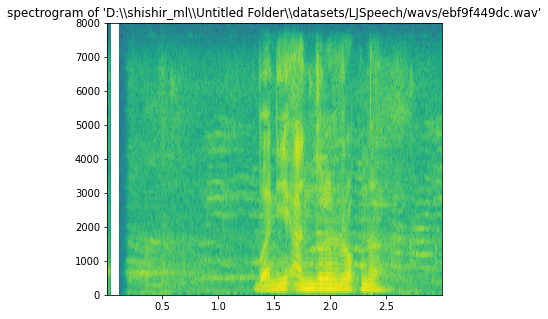

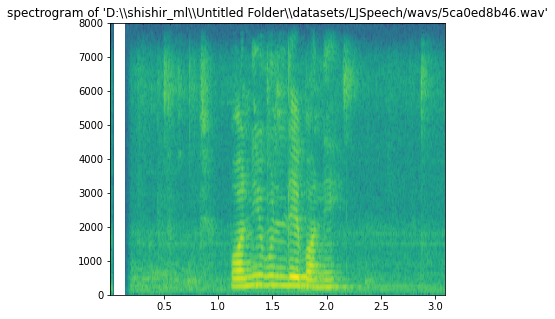

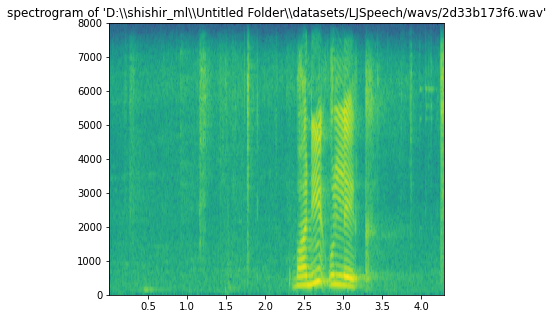

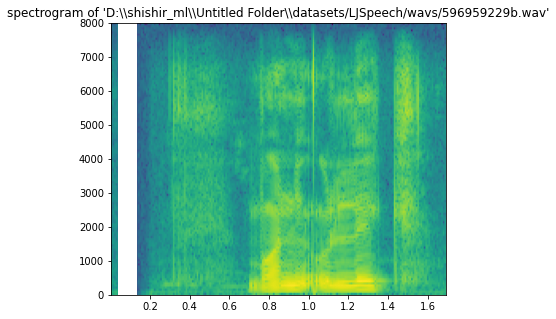

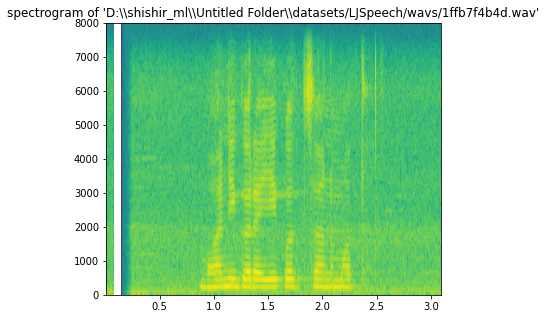

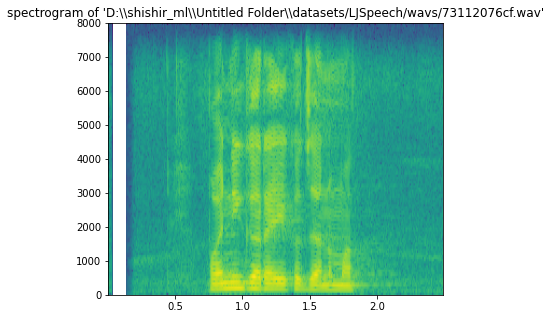

In [18]:
#PRINTING SPECTROGRAM:
import os
import wave
import pylab

myfile = open('D:\\shishir_ml\\Untitled Folder\\datasets/LJSpeech/utt_spk_text.tsv', 'r',encoding = 'utf-8')
Lines = myfile.readlines()

count = 0
my_list=[]
# Strips the newline character
for line in Lines:
    count += 1
    arr = line.split("\t")
    my_list.append(arr)


def graph_spectrogram(audd_path):
    sound_info, frame_rate = get_wav_info(audd_path)
    pylab.figure(num=None, figsize=(6, 5))
    pylab.subplot(111)
    pylab.title('spectrogram of %r' % audd_path)
    pylab.specgram(sound_info, Fs=frame_rate)
    pylab.savefig('spectrogram.png')
def get_wav_info(wav_file):
    wav = wave.open(audd_path, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.fromstring(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate


for xzz in range(100000,100006):

    audd_path="D:\\shishir_ml\\Untitled Folder\\datasets/LJSpeech/wavs/" + my_list[xzz][0]+".wav"
    graph_spectrogram(audd_path)


In [27]:
# Callbacks to display predictions

In [16]:
class DisplayOutputs(keras.callbacks.Callback):
    def __init__(
        self, batch, idx_to_token, target_start_token_idx=27, target_end_token_idx=28
    ):

        self.batch = batch
        print(batch)
        self.target_start_token_idx = target_start_token_idx
        self.target_end_token_idx = target_end_token_idx
        self.idx_to_char = idx_to_token

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 != 0:
            return
        source = self.batch["source"]
        target = self.batch["target"].numpy()
        bs = tf.shape(source)[0]
        preds = self.model.generate(source, self.target_start_token_idx)
        preds = preds.numpy()
        for i in range(bs):
            target_text = "".join([self.idx_to_char[_] for _ in target[i, :]])
            prediction = ""
            for idx in preds[i, :]:
                prediction += self.idx_to_char[idx]
                if idx == self.target_end_token_idx:
                    break
            print(f"target:     {target_text.replace('-','')}")
            print(f"prediction: {prediction}\n")

In [18]:
class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self,
        init_lr=0.00001,
        lr_after_warmup=0.001,
        final_lr=0.00001,
        warmup_epochs=15,
        decay_epochs=85,
        steps_per_epoch=203,
    ):
        super().__init__()
        self.init_lr = init_lr
        self.lr_after_warmup = lr_after_warmup
        self.final_lr = final_lr
        self.warmup_epochs = warmup_epochs
        self.decay_epochs = decay_epochs
        self.steps_per_epoch = steps_per_epoch

    def calculate_lr(self, epoch):
        warmup_lr = (
            self.init_lr
            + ((self.lr_after_warmup - self.init_lr) / (self.warmup_epochs - 1)) * epoch
        )
        decay_lr = tf.math.maximum(
            self.final_lr,
            self.lr_after_warmup
            - (epoch - self.warmup_epochs)
            * (self.lr_after_warmup - self.final_lr)
            / (self.decay_epochs),
        )
        return tf.math.minimum(warmup_lr, decay_lr)

    def __call__(self, step):
        epoch = step // self.steps_per_epoch
        return self.calculate_lr(epoch)


In [19]:
#TRAINING the Model

In [20]:
batch = next(iter(val_ds))

# The vocabulary to convert predicted indices into characters
idx_to_char = vectorizer.get_vocabulary()
display_cb = DisplayOutputs(
    batch, idx_to_char, target_start_token_idx=2, target_end_token_idx=3
)  # set the arguments as per vocabulary index for '<' and '>'

model = Transformer(
    num_hid=200,
    num_head=2,
    num_feed_forward=400,
    target_maxlen=max_target_len,
    num_layers_enc=4,
    num_layers_dec=1,
    num_classes=127,
)
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, label_smoothing=0.1,
)

# accuracy = tf.keras.metrics.CategoricalAccuracy()

learning_rate = CustomSchedule(
    init_lr=0.00001,
    lr_after_warmup=0.001,
    final_lr=0.00001,
    warmup_epochs=15,
    decay_epochs=85,
    steps_per_epoch=len(ds),
)
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(optimizer=optimizer, loss=loss_fn)
#uncomment below if you want to train the model.
# history = model.fit(ds, validation_data=val_ds, callbacks=[display_cb], epochs=15)
# model.save("D:\\shishir_ml\\Untitled Folder\\merolaptopspeechrecognitionEE.model", include_optimizer=False)

{'source': <tf.Tensor: shape=(4, 2754, 129), dtype=float32, numpy=
array([[[ 3.3559372 ,  3.5777593 ,  3.9572067 , ..., -1.4681666 ,
         -1.459797  , -1.4985305 ],
        [ 2.1765413 ,  1.6162517 ,  2.2305877 , ..., -1.182865  ,
         -1.1440591 , -1.1331518 ],
        [ 0.55785406,  1.2318337 ,  1.2865043 , ..., -1.3963728 ,
         -1.299793  , -1.4068626 ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 2.595874  ,  2.424777  ,  0.85644585, ..., -1.1333375 ,
         -1.153964  , -1.148135  ],
        [ 0.4342582 ,  2.6246135 ,  3.5072365 , ..., -0.86056864,
         -0.9010199 , -0.8935862 ],
        [ 1.9567394 ,  2.6379197 ,  2.7372298 , ..., -1.0546178 ,
         -1.0707834 , -1.0748878 ],


In [22]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='MAE (training data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE for ASR')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [97]:
# model_path = "./speechrecognitionE.model"
model_path = r"D:\\shishir_ml\\Untitled Folder\\TestModel\\merospeechrecog"
model.load_weights(model_path)

In [21]:
# PREDICTION WITH THIS MODEL
# Calculating WER and CER

def wer(r, h):
    """
    Calculation of WER with Levenshtein distance.

    """
    # initialisation
    import numpy

    d = numpy.zeros((len(r) + 1) * (len(h) + 1), dtype=numpy.uint8)
    d = d.reshape((len(r) + 1, len(h) + 1))
    for i in range(len(r) + 1):
        for j in range(len(h) + 1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(r) + 1):
        for j in range(1, len(h) + 1):
            if r[i - 1] == h[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                substitution = d[i - 1][j - 1] + 1
                insertion = d[i][j - 1] + 1
                deletion = d[i - 1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)

    return d[len(r)][len(h)]


if __name__ == "__main__":
    import doctest

    doctest.testmod()

In [22]:
##Audio TRANSLATION
# import required libraries
import sounddevice as sd
from scipy.io.wavfile import write
import sounddevice
from playsound import playsound

In [25]:
#WER evaluation for TEST DATASETS. (WORKS FINE FOR DEMO)
# print(len(test_data))
##total no. of test data: 1580 for 99:1 and 31581 for 80:20
# print(test_data[1]["audio"])
# print(test_data[2]["text"])
sen_count=0
werrr_list=[]

for xyz in range(5,10):
    
    test_audio_path=test_data[xyz]["audio"] # D:\shishir_ml\Untitled Folder\datasets/LJSpeech\wavs\fd74e6a25b.wav and ...
#     playsound(test_audio_path)
#     print(test_audio_path)
    x=path_to_audio(test_audio_path)
    test_text=test_data[xyz]["text"]
    referencetexttt=test_text
#     print(test_text)
    x = tf.expand_dims(x, axis=0)
    # print(x.shape)
    idx_to_char = vectorizer.get_vocabulary()
    preds = model.generate(x, 2)
    preds = preds.numpy()
    bs = tf.shape(x)[0]
    for i in range(bs):
        prediction = ""
        for idx in preds[i, :]:
            prediction += idx_to_char[idx]
            if idx == 3:
                break
#     print("reference:", referencetexttt)
#     print("prediction: ", prediction,"\n")
       
    ref= referencetexttt
    hyp= prediction
    new=ref.replace("\n", "")
    new_ref="<"+new+">"
    print("Reference:",new_ref)      #PLEASE UNCOMMENT THIS AND BELOW THIS CODE IMPORTANT
    print("Prediction:",prediction)   #PLEASE UNCOMMENT THIS CODE IMPORTANT .. after calculating cer.
    print(new_ref.split(),hyp.split())
    totError=wer(new_ref.split(),hyp.split())
    print("totalError:",totError)
    werrr=(totError/len(new_ref))*100
    
    
#     print(new_ref.split(),hyp.split())
    totError=wer(new_ref,hyp)
    totworderror=wer(new_ref.split(),hyp.split())
    print("totalCharError:",totError)
    print("totalWordError:",totworderror)
    werrr=(totError/len(new_ref))*100
    werrrr=(totworderror/len(new_ref.split()))*100
    
    werrr_list.append(werrr)
    sen_count+=1
    print("sentence count:",sen_count)
    print("CER:",werrr,"%")
    print("WER:",werrrr,"%")
    

print(werrr_list)
Avg_werr=sum(werrr_list) / len(werrr_list)
print("THE AVERAGE CER IS:")
print(Avg_werr)


Reference: <तिम्रो कल्याण हुनेछ>
Prediction: <तिम्रो कन्यान हुनेछ>
['<तिम्रो', 'कल्याण', 'हुनेछ>'] ['<तिम्रो', 'कन्यान', 'हुनेछ>']
totalError: 1
totalCharError: 2
totalWordError: 1
sentence count: 1
CER: 9.523809523809524 %
WER: 33.33333333333333 %
Reference: <कुरामा रुचि राख्छिन्>
Prediction: <कुरामा रुचि राचीन>
['<कुरामा', 'रुचि', 'राख्छिन्>'] ['<कुरामा', 'रुचि', 'राचीन>']
totalError: 1
totalCharError: 5
totalWordError: 1
sentence count: 2
CER: 22.727272727272727 %
WER: 33.33333333333333 %
Reference: <मलाई लागेन>
Prediction: <मलाई लागिन>
['<मलाई', 'लागेन>'] ['<मलाई', 'लागिन>']
totalError: 1
totalCharError: 1
totalWordError: 1
sentence count: 3
CER: 8.333333333333332 %
WER: 50.0 %
Reference: <अधिक समय पहिलेको मध्ययुगीन>
Prediction: <अधिक समय पहिलेको मध्युगी>
['<अधिक', 'समय', 'पहिलेको', 'मध्ययुगीन>'] ['<अधिक', 'समय', 'पहिलेको', 'मध्युगी>']
totalError: 1
totalCharError: 2
totalWordError: 1
sentence count: 4
CER: 7.142857142857142 %
WER: 25.0 %
Reference: <नेपाली भाषामा>
Prediction: <नेप

In [26]:
print(len(test_data))

3790


In [49]:
###LIVE AUDIO####

In [28]:
##LIVE RECORD TRANSLATION (FOR DEMO)
# import required libraries
import sounddevice as sd
from scipy.io.wavfile import write
#animation imports
import itertools
import threading
import time
import sys
import sounddevice

In [29]:
done = False
#here is the animation
def animate():
    for c in itertools.cycle(['|', '/', '-', '\\']):
        if done:
            break
        sys.stdout.write('\rRecording ' + c)
        sys.stdout.flush()
        time.sleep(0.1)
    sys.stdout.write('\rDone!')

In [99]:
fs= 16000  
second = 5
t = threading.Thread(target=animate)
t.start()
#long process here
print("Please Speak in Nepali")
record_voice = sounddevice.rec( int ( second * fs ) , samplerate = fs , channels = 1, dtype='int16' )
sounddevice.wait()

time.sleep(1)
done = True

aud_path="D:\\shishir_ml\\Untitled Folder/Rec/Audiotest.wav"
write(aud_path,fs,record_voice)
print("Saved in REC folder")



Done!Please Speak in Nepali
Saved in REC folder


In [84]:
#Playing the recorded audio
# import required module
from playsound import playsound
# for playing note.wav file
print("Playing the recorded audio")
playsound(aud_path)

Playing the recorded audio


In [51]:
model_path = "D:\\shishir_ml\\Untitled Folder\\merospeechrecognitionEEE.model"
model.load_weights(model_path)

In [102]:
# model_path = "./speechrecognitionE.model"
model_path = r"D:\\shishir_ml\\Untitled Folder\\TestModeltwo"
model.load_weights(model_path)

In [3]:
#Prediction of the recorded audio.
print("Loading the transcription")
path="D:\\shishir_ml\\Untitled Folder/Rec/Audiotest.wav"

# print(path)
ref=text[0]
x = path_to_audio(path)
#print(x)
x = tf.expand_dims(x, axis=0)
# print(x.shape)
idx_to_char = vectorizer.get_vocabulary()
preds = model.generate(x, 2)
preds = preds.numpy()
bs = tf.shape(x)[0]
for i in range(bs):
    prediction = ""
    for idx in preds[i, :]:
        prediction += idx_to_char[idx]
        if idx == 3:
            break
            
print("prediction: ", prediction)


Loading the transcription
prediction:  <मेरो नाम शिशिर हो>


In [ ]:
####FINISHED HERE#######